# Pix2Pix

**기억할 점**
- **한 도메인에 있는 이미지를 다른 도메인으로 해석해보자**는 관점
- Image to Image Mapping Network에서 Photo-realistic을 추구하고자 함
- GAN의 adverserial을 사용
- U-Net과 PatchGAN 등을 이용해서 성능을 최적화함
- 양쪽 도메인에 대응되는 데이터 쌍이 존재해야 함(반면 cyclegan은 데이터 쌍이 없어도 됨)

## Pix2Pix의 손실함수
- Adverserial Loss

$$L_{cGAN}(G, D) = E_{y\sim p_{data}(y)} \big[\text{log}D(y) \big] + E_{x\sim P_{data}(x), z \sim P_{z}(z)} \big[\| y - G(x, z) \|_{1}\big]$$


- Reconstruction Loss

$$L_{L1}\big(G \big) = E_{x, y \sim P_{data}(x, y), z \sim p_{z}(z)} \big[ \| y - G(x, z) \|_{1} \big]$$

- Total Loss

$$G^{*} = arg \underset{G}{\operatorname{min}} \underset{D}{\operatorname{max}} L_{cGAN}(G, D) + \lambda L_{L1}(G)$$

## 1. Import Libs

In [13]:
from __future__ import print_function
import argparse
import os
from math import log10

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from networks import define_G, define_D, GANLoss, print_network
from data import get_training_set, get_test_set
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter

## 2. Setting Hyperparameters

In [14]:
parser = argparse.ArgumentParser(description='pix2pix-PyTorch-implementation')
parser.add_argument('--dataset', required=False, default='facades',help='facades')
parser.add_argument('--batchSize', type=int, default=4, help='training batch size')
parser.add_argument('--testBatchSize', type=int, default=1, help='testing batch size')
parser.add_argument('--nEpochs', type=int, default=500, help='number of epochs to train for')
parser.add_argument('--input_nc', type=int, default=3, help='input image channels')
parser.add_argument('--output_nc', type=int, default=3, help='output image channels')
parser.add_argument('--ngf', type=int, default=64, help='generator filters in first conv layer')
parser.add_argument('--ndf', type=int, default=64, help='discriminator filters in first conv layer')
parser.add_argument('--lr', type=float, default=0.001, help='Learning Rate. Default=0.002')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', default=True, help='use cuda?')
parser.add_argument('--threads', type=int, default=4, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--lamb', type=int, default=10, help='weight on L1 term in objective')
params = parser.parse_args([])

print(params)

if params.cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

cudnn.benchmark = True

torch.manual_seed(params.seed)
if params.cuda:
    torch.cuda.manual_seed(params.seed)

Namespace(batchSize=4, beta1=0.5, cuda=True, dataset='facades', input_nc=3, lamb=10, lr=0.001, nEpochs=500, ndf=64, ngf=64, output_nc=3, seed=123, testBatchSize=1, threads=4)


## 3. Load Dataset

In [15]:
root_path = '/home/nisnab/workspace/ImageTranslation/Pix2Pix/dataset/'
train_set = get_training_set(root_path + params.dataset)
test_set = get_test_set(root_path + params.dataset)

train_data_loader = DataLoader(dataset=train_set, num_workers=params.threads, batch_size=params.batchSize, shuffle=True)
test_data_loader = DataLoader(dataset=test_set, num_workers=params.threads, batch_size=params.batchSize, shuffle=False)

In [16]:
test_data_loader

## 4. Build Model & Optimizers & Criterions
### 4.1 Build Model

In [17]:
netG = define_G(params.input_nc, params.output_nc, params.ngf, 'batch', False, [0])
netD = define_D(params.input_nc + params.output_nc, params.ndf, 'batch', False, [0])

#print(netG)
#print(netD)

### 4.2 Optimizers

In [18]:
optimizerG = optim.Adam(netG.parameters(), lr=params.lr, betas=(params.beta1, 0.999))
optimizerD = optim.Adam(netD.parameters(), lr=params.lr, betas=(params.beta1, 0.999))
writer=SummaryWriter(f'logs/tensorlogs')

### 4.3 Loss Functions

In [19]:
criterionGAN = GANLoss()
criterionL1 = nn.L1Loss()
criterionMSE = nn.MSELoss()

real_a = torch.FloatTensor(params.batchSize, params.input_nc, 256, 256)
real_b = torch.FloatTensor(params.batchSize, params.output_nc, 256, 256)

if params.cuda:
    netD = netD.cuda()
    netG = netG.cuda()
    criterionGAN = criterionGAN.cuda()
    criterionL1 = criterionL1.cuda()
    criterionMSE = criterionMSE.cuda()
    real_a = real_a.cuda()
    real_b = real_b.cuda()

real_a = Variable(real_a)
real_b = Variable(real_b)

## 5. Training Models

In [20]:
G_losses=[]
D_losses=[]

for epoch in range(1, params.nEpochs + 1):
    for iteration, batch in enumerate(train_data_loader, 1):
        # forward
        real_a_cpu, real_b_cpu = batch[0], batch[1]
        real_a.resize_(real_a_cpu.size()).copy_(real_a_cpu)
        real_b.resize_(real_b_cpu.size()).copy_(real_b_cpu)
        
        fake_b = netG(real_a)
        
        ## Discriminator network : max log(D(x, y)) + log(1 - D(x, G(x)))
        optimizerD.zero_grad()
        
        # train fake
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = netD.forward(fake_ab.detach())
        loss_d_fake = criterionGAN(pred_fake, False)
        
        # train real
        real_ab = torch.cat((real_a, real_b), 1)
        pred_real = netD.forward(real_ab)
        loss_d_real = criterionGAN(pred_real, True)
        
        # combine loss
        loss_d = (loss_d_fake + loss_d_real) * 0.5
        
        loss_d.backward()
        
        optimizerD.step()
        
        ## Generator network : max log(D(x, G(x))) + L1(y, G(x))
        optimizerG.zero_grad()
        
        # 1. G(A) should fake the discriminator
        fake_ab = torch.cat((real_a, fake_b), 1)
        pred_fake = netD.forward(fake_ab)
        loss_g_gan = criterionGAN(pred_fake, True)
        
        # 2. G(A) = B
        loss_g_l1 = criterionL1(fake_b, real_b) * params.lamb
        loss_g = loss_g_gan + loss_g_l1
        loss_g.backward()
        optimizerG.step()
        
        print("===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}".format(
            epoch, iteration, len(train_data_loader), loss_d.data, loss_g.data))
        
        G_losses.append(loss_g.data)
        D_losses.append(loss_d.data)
        
        """
    
    avg_psnr = 0
    for batch in test_data_loader:
        input2, target = Variable(batch[0], volatile=True), Variable(batch[1], volatile=True)
        if params.cuda:
            input2 = input2.cuda()
            target = target.cuda()

        prediction = netG(input2)
        mse = criterionMSE(prediction, target)
        psnr = 10 * log10(1 / mse.data[0])
        avg_psnr += psnr
        #print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(test_data_loader)))
"""
    if epoch % 500 == 0:
        if not os.path.exists('save_model'):
            os.mkdir('save_model')
        if not os.path.exists(os.path.join('save_model', params.dataset)):
            os.mkdir(os.path.join('save_model', params.dataset))
        net_g_model_out_path = "save_model/{}/netG_model_epoch_{}.pkl".format(params.dataset, epoch)
        net_d_model_out_path = 'save_model/{}/netD_model_epoch_{}.pkl'.format(params.dataset, epoch)
        torch.save(netG, net_g_model_out_path)
        torch.save(netD, net_d_model_out_path)
        print("model saved to {}".format("model " + params.dataset))

===> Epoch[1](1/125): Loss_D: 1.5794 Loss_G: 50.8293
===> Epoch[1](2/125): Loss_D: 34.5489 Loss_G: 93.9934
===> Epoch[1](3/125): Loss_D: 87.5620 Loss_G: 22.7133
===> Epoch[1](4/125): Loss_D: 13.0449 Loss_G: 11.3509
===> Epoch[1](5/125): Loss_D: 3.3022 Loss_G: 8.2309
===> Epoch[1](6/125): Loss_D: 1.1032 Loss_G: 8.1228
===> Epoch[1](7/125): Loss_D: 1.0700 Loss_G: 6.6865
===> Epoch[1](8/125): Loss_D: 0.4196 Loss_G: 7.1938
===> Epoch[1](9/125): Loss_D: 0.5675 Loss_G: 6.7902
===> Epoch[1](10/125): Loss_D: 0.3348 Loss_G: 5.5037
===> Epoch[1](11/125): Loss_D: 0.3539 Loss_G: 5.9395
===> Epoch[1](12/125): Loss_D: 0.2754 Loss_G: 5.5685
===> Epoch[1](13/125): Loss_D: 0.2756 Loss_G: 5.3447
===> Epoch[1](14/125): Loss_D: 0.2483 Loss_G: 5.7450
===> Epoch[1](15/125): Loss_D: 0.2629 Loss_G: 5.1321
===> Epoch[1](16/125): Loss_D: 0.3023 Loss_G: 4.5411
===> Epoch[1](17/125): Loss_D: 0.2923 Loss_G: 4.8826
===> Epoch[1](18/125): Loss_D: 0.2291 Loss_G: 6.3144
===> Epoch[1](19/125): Loss_D: 0.2746 Loss_G: 6.

===> Epoch[2](31/125): Loss_D: 0.2248 Loss_G: 4.7927
===> Epoch[2](32/125): Loss_D: 0.2358 Loss_G: 3.4365
===> Epoch[2](33/125): Loss_D: 0.2536 Loss_G: 4.1375
===> Epoch[2](34/125): Loss_D: 0.2682 Loss_G: 3.8157
===> Epoch[2](35/125): Loss_D: 0.3204 Loss_G: 4.5575
===> Epoch[2](36/125): Loss_D: 0.3157 Loss_G: 4.4334
===> Epoch[2](37/125): Loss_D: 0.3289 Loss_G: 4.6698
===> Epoch[2](38/125): Loss_D: 0.3164 Loss_G: 4.7743
===> Epoch[2](39/125): Loss_D: 0.2794 Loss_G: 4.4352
===> Epoch[2](40/125): Loss_D: 0.2869 Loss_G: 5.0622
===> Epoch[2](41/125): Loss_D: 0.2336 Loss_G: 3.8878
===> Epoch[2](42/125): Loss_D: 0.2883 Loss_G: 4.8030
===> Epoch[2](43/125): Loss_D: 0.3420 Loss_G: 3.2126
===> Epoch[2](44/125): Loss_D: 0.4207 Loss_G: 4.8974
===> Epoch[2](45/125): Loss_D: 0.2583 Loss_G: 6.2901
===> Epoch[2](46/125): Loss_D: 0.2702 Loss_G: 3.5931
===> Epoch[2](47/125): Loss_D: 0.2838 Loss_G: 4.6252
===> Epoch[2](48/125): Loss_D: 0.2568 Loss_G: 4.3831
===> Epoch[2](49/125): Loss_D: 0.2958 Loss_G: 

===> Epoch[3](61/125): Loss_D: 0.2499 Loss_G: 6.0682
===> Epoch[3](62/125): Loss_D: 0.2854 Loss_G: 3.9734
===> Epoch[3](63/125): Loss_D: 0.3048 Loss_G: 4.2393
===> Epoch[3](64/125): Loss_D: 0.4404 Loss_G: 4.8053
===> Epoch[3](65/125): Loss_D: 0.5725 Loss_G: 4.3996
===> Epoch[3](66/125): Loss_D: 0.6683 Loss_G: 6.0035
===> Epoch[3](67/125): Loss_D: 0.6943 Loss_G: 5.0282
===> Epoch[3](68/125): Loss_D: 0.5877 Loss_G: 4.8449
===> Epoch[3](69/125): Loss_D: 0.4620 Loss_G: 4.7765
===> Epoch[3](70/125): Loss_D: 0.7165 Loss_G: 6.4776
===> Epoch[3](71/125): Loss_D: 1.8374 Loss_G: 8.8247
===> Epoch[3](72/125): Loss_D: 2.8850 Loss_G: 7.8678
===> Epoch[3](73/125): Loss_D: 3.3553 Loss_G: 12.0151
===> Epoch[3](74/125): Loss_D: 6.4561 Loss_G: 17.0484
===> Epoch[3](75/125): Loss_D: 9.0863 Loss_G: 11.5683
===> Epoch[3](76/125): Loss_D: 5.7664 Loss_G: 7.8683
===> Epoch[3](77/125): Loss_D: 2.9546 Loss_G: 8.0604
===> Epoch[3](78/125): Loss_D: 2.2317 Loss_G: 5.2132
===> Epoch[3](79/125): Loss_D: 0.5297 Loss_

===> Epoch[4](91/125): Loss_D: 0.3149 Loss_G: 4.4024
===> Epoch[4](92/125): Loss_D: 0.3361 Loss_G: 3.8210
===> Epoch[4](93/125): Loss_D: 0.2694 Loss_G: 3.6079
===> Epoch[4](94/125): Loss_D: 0.2553 Loss_G: 3.6058
===> Epoch[4](95/125): Loss_D: 0.2197 Loss_G: 4.3226
===> Epoch[4](96/125): Loss_D: 0.1778 Loss_G: 4.6257
===> Epoch[4](97/125): Loss_D: 0.1987 Loss_G: 3.7876
===> Epoch[4](98/125): Loss_D: 0.2597 Loss_G: 3.3344
===> Epoch[4](99/125): Loss_D: 0.2480 Loss_G: 3.8179
===> Epoch[4](100/125): Loss_D: 0.2354 Loss_G: 4.4545
===> Epoch[4](101/125): Loss_D: 0.2272 Loss_G: 4.4909
===> Epoch[4](102/125): Loss_D: 0.2372 Loss_G: 4.6852
===> Epoch[4](103/125): Loss_D: 0.2164 Loss_G: 4.5718
===> Epoch[4](104/125): Loss_D: 0.2291 Loss_G: 3.9530
===> Epoch[4](105/125): Loss_D: 0.2256 Loss_G: 3.4151
===> Epoch[4](106/125): Loss_D: 0.3131 Loss_G: 3.4212
===> Epoch[4](107/125): Loss_D: 0.3193 Loss_G: 4.3710
===> Epoch[4](108/125): Loss_D: 0.3301 Loss_G: 4.0476
===> Epoch[4](109/125): Loss_D: 0.299

===> Epoch[5](121/125): Loss_D: 0.3263 Loss_G: 4.5008
===> Epoch[5](122/125): Loss_D: 0.2934 Loss_G: 5.1142
===> Epoch[5](123/125): Loss_D: 0.2195 Loss_G: 4.2497
===> Epoch[5](124/125): Loss_D: 0.3244 Loss_G: 4.0950
===> Epoch[5](125/125): Loss_D: 0.2417 Loss_G: 5.0742
===> Epoch[6](1/125): Loss_D: 0.2496 Loss_G: 4.6281
===> Epoch[6](2/125): Loss_D: 0.2521 Loss_G: 3.8620
===> Epoch[6](3/125): Loss_D: 0.2168 Loss_G: 4.2041
===> Epoch[6](4/125): Loss_D: 0.2588 Loss_G: 4.0269
===> Epoch[6](5/125): Loss_D: 0.3251 Loss_G: 4.3823
===> Epoch[6](6/125): Loss_D: 0.2187 Loss_G: 4.2410
===> Epoch[6](7/125): Loss_D: 0.2025 Loss_G: 4.0071
===> Epoch[6](8/125): Loss_D: 0.2668 Loss_G: 4.1323
===> Epoch[6](9/125): Loss_D: 0.2253 Loss_G: 4.2042
===> Epoch[6](10/125): Loss_D: 0.2157 Loss_G: 4.1976
===> Epoch[6](11/125): Loss_D: 0.1974 Loss_G: 4.1710
===> Epoch[6](12/125): Loss_D: 0.1749 Loss_G: 4.2785
===> Epoch[6](13/125): Loss_D: 0.1934 Loss_G: 3.9458
===> Epoch[6](14/125): Loss_D: 0.1751 Loss_G: 3.80

===> Epoch[7](27/125): Loss_D: 0.7620 Loss_G: 4.8150
===> Epoch[7](28/125): Loss_D: 0.9553 Loss_G: 4.3605
===> Epoch[7](29/125): Loss_D: 0.7607 Loss_G: 5.4124
===> Epoch[7](30/125): Loss_D: 1.1396 Loss_G: 4.0869
===> Epoch[7](31/125): Loss_D: 0.7865 Loss_G: 3.9672
===> Epoch[7](32/125): Loss_D: 0.3068 Loss_G: 4.1105
===> Epoch[7](33/125): Loss_D: 0.2635 Loss_G: 4.8409
===> Epoch[7](34/125): Loss_D: 0.3526 Loss_G: 5.8795
===> Epoch[7](35/125): Loss_D: 0.4390 Loss_G: 4.1546
===> Epoch[7](36/125): Loss_D: 0.4482 Loss_G: 3.3180
===> Epoch[7](37/125): Loss_D: 0.3522 Loss_G: 3.4135
===> Epoch[7](38/125): Loss_D: 0.3424 Loss_G: 4.7913
===> Epoch[7](39/125): Loss_D: 0.3376 Loss_G: 3.6168
===> Epoch[7](40/125): Loss_D: 0.3285 Loss_G: 4.4411
===> Epoch[7](41/125): Loss_D: 0.4197 Loss_G: 3.6552
===> Epoch[7](42/125): Loss_D: 0.3789 Loss_G: 3.9284
===> Epoch[7](43/125): Loss_D: 0.1986 Loss_G: 4.0736
===> Epoch[7](44/125): Loss_D: 0.2196 Loss_G: 3.4460
===> Epoch[7](45/125): Loss_D: 0.1736 Loss_G: 

===> Epoch[8](57/125): Loss_D: 0.2459 Loss_G: 3.7052
===> Epoch[8](58/125): Loss_D: 0.3133 Loss_G: 3.3492
===> Epoch[8](59/125): Loss_D: 0.2704 Loss_G: 5.6824
===> Epoch[8](60/125): Loss_D: 0.2395 Loss_G: 3.6750
===> Epoch[8](61/125): Loss_D: 0.2815 Loss_G: 3.8636
===> Epoch[8](62/125): Loss_D: 0.2393 Loss_G: 4.0485
===> Epoch[8](63/125): Loss_D: 0.3868 Loss_G: 4.0756
===> Epoch[8](64/125): Loss_D: 0.3514 Loss_G: 4.9334
===> Epoch[8](65/125): Loss_D: 0.4113 Loss_G: 4.3738
===> Epoch[8](66/125): Loss_D: 0.2725 Loss_G: 4.0967
===> Epoch[8](67/125): Loss_D: 0.2272 Loss_G: 4.2116
===> Epoch[8](68/125): Loss_D: 0.1670 Loss_G: 3.4848
===> Epoch[8](69/125): Loss_D: 0.2516 Loss_G: 4.2688
===> Epoch[8](70/125): Loss_D: 0.1790 Loss_G: 3.6629
===> Epoch[8](71/125): Loss_D: 0.2045 Loss_G: 3.5849
===> Epoch[8](72/125): Loss_D: 0.3475 Loss_G: 3.6428
===> Epoch[8](73/125): Loss_D: 0.2755 Loss_G: 3.2769
===> Epoch[8](74/125): Loss_D: 0.3449 Loss_G: 4.8465
===> Epoch[8](75/125): Loss_D: 0.3221 Loss_G: 

===> Epoch[9](87/125): Loss_D: 0.2573 Loss_G: 4.0170
===> Epoch[9](88/125): Loss_D: 0.3386 Loss_G: 3.3967
===> Epoch[9](89/125): Loss_D: 0.2270 Loss_G: 3.4589
===> Epoch[9](90/125): Loss_D: 0.2003 Loss_G: 3.5648
===> Epoch[9](91/125): Loss_D: 0.2256 Loss_G: 5.1528
===> Epoch[9](92/125): Loss_D: 0.2246 Loss_G: 3.5873
===> Epoch[9](93/125): Loss_D: 0.1523 Loss_G: 5.0011
===> Epoch[9](94/125): Loss_D: 0.0872 Loss_G: 5.7937
===> Epoch[9](95/125): Loss_D: 0.2832 Loss_G: 4.0990
===> Epoch[9](96/125): Loss_D: 0.3933 Loss_G: 4.3087
===> Epoch[9](97/125): Loss_D: 0.2423 Loss_G: 3.5516
===> Epoch[9](98/125): Loss_D: 0.2659 Loss_G: 4.6649
===> Epoch[9](99/125): Loss_D: 0.3248 Loss_G: 3.8436
===> Epoch[9](100/125): Loss_D: 0.2410 Loss_G: 2.9603
===> Epoch[9](101/125): Loss_D: 0.3614 Loss_G: 4.4651
===> Epoch[9](102/125): Loss_D: 0.7037 Loss_G: 5.0664
===> Epoch[9](103/125): Loss_D: 0.6499 Loss_G: 4.9000
===> Epoch[9](104/125): Loss_D: 0.7874 Loss_G: 4.5723
===> Epoch[9](105/125): Loss_D: 0.4403 Lo

===> Epoch[10](115/125): Loss_D: 0.2058 Loss_G: 3.5730
===> Epoch[10](116/125): Loss_D: 0.1658 Loss_G: 4.6413
===> Epoch[10](117/125): Loss_D: 0.2429 Loss_G: 3.0979
===> Epoch[10](118/125): Loss_D: 0.2078 Loss_G: 4.6403
===> Epoch[10](119/125): Loss_D: 0.2746 Loss_G: 4.5977
===> Epoch[10](120/125): Loss_D: 0.2553 Loss_G: 3.5411
===> Epoch[10](121/125): Loss_D: 0.1923 Loss_G: 4.5479
===> Epoch[10](122/125): Loss_D: 0.2028 Loss_G: 4.5836
===> Epoch[10](123/125): Loss_D: 0.1821 Loss_G: 4.3785
===> Epoch[10](124/125): Loss_D: 0.2401 Loss_G: 3.7759
===> Epoch[10](125/125): Loss_D: 0.1843 Loss_G: 4.1126
===> Epoch[11](1/125): Loss_D: 0.1918 Loss_G: 4.0300
===> Epoch[11](2/125): Loss_D: 0.1713 Loss_G: 3.1592
===> Epoch[11](3/125): Loss_D: 0.1732 Loss_G: 3.4618
===> Epoch[11](4/125): Loss_D: 0.1711 Loss_G: 3.7851
===> Epoch[11](5/125): Loss_D: 0.2261 Loss_G: 3.8408
===> Epoch[11](6/125): Loss_D: 0.2301 Loss_G: 3.7666
===> Epoch[11](7/125): Loss_D: 0.2669 Loss_G: 3.9339
===> Epoch[11](8/125): L

===> Epoch[12](17/125): Loss_D: 0.0994 Loss_G: 4.3023
===> Epoch[12](18/125): Loss_D: 0.1511 Loss_G: 4.6863
===> Epoch[12](19/125): Loss_D: 0.1868 Loss_G: 3.2740
===> Epoch[12](20/125): Loss_D: 0.2771 Loss_G: 3.7452
===> Epoch[12](21/125): Loss_D: 0.2248 Loss_G: 3.9067
===> Epoch[12](22/125): Loss_D: 0.1305 Loss_G: 4.9539
===> Epoch[12](23/125): Loss_D: 0.1659 Loss_G: 3.1829
===> Epoch[12](24/125): Loss_D: 0.1130 Loss_G: 3.4571
===> Epoch[12](25/125): Loss_D: 0.1161 Loss_G: 3.4420
===> Epoch[12](26/125): Loss_D: 0.0823 Loss_G: 5.7763
===> Epoch[12](27/125): Loss_D: 0.0965 Loss_G: 4.2996
===> Epoch[12](28/125): Loss_D: 0.1594 Loss_G: 4.1318
===> Epoch[12](29/125): Loss_D: 0.0921 Loss_G: 4.1461
===> Epoch[12](30/125): Loss_D: 0.3151 Loss_G: 4.0474
===> Epoch[12](31/125): Loss_D: 0.2472 Loss_G: 4.6551
===> Epoch[12](32/125): Loss_D: 0.5653 Loss_G: 3.7566
===> Epoch[12](33/125): Loss_D: 0.4185 Loss_G: 4.1991
===> Epoch[12](34/125): Loss_D: 0.4277 Loss_G: 3.2797
===> Epoch[12](35/125): Loss

===> Epoch[13](45/125): Loss_D: 0.8924 Loss_G: 5.1074
===> Epoch[13](46/125): Loss_D: 1.9881 Loss_G: 6.2994
===> Epoch[13](47/125): Loss_D: 4.1052 Loss_G: 10.9160
===> Epoch[13](48/125): Loss_D: 4.8927 Loss_G: 5.5002
===> Epoch[13](49/125): Loss_D: 3.1148 Loss_G: 4.9074
===> Epoch[13](50/125): Loss_D: 0.9848 Loss_G: 4.3178
===> Epoch[13](51/125): Loss_D: 0.9158 Loss_G: 4.6909
===> Epoch[13](52/125): Loss_D: 0.8320 Loss_G: 6.4358
===> Epoch[13](53/125): Loss_D: 1.4514 Loss_G: 4.7982
===> Epoch[13](54/125): Loss_D: 1.5390 Loss_G: 4.7502
===> Epoch[13](55/125): Loss_D: 0.9938 Loss_G: 4.4957
===> Epoch[13](56/125): Loss_D: 2.2392 Loss_G: 6.0018
===> Epoch[13](57/125): Loss_D: 1.7819 Loss_G: 3.2430
===> Epoch[13](58/125): Loss_D: 0.2664 Loss_G: 3.3103
===> Epoch[13](59/125): Loss_D: 0.4867 Loss_G: 3.2920
===> Epoch[13](60/125): Loss_D: 0.2735 Loss_G: 2.9918
===> Epoch[13](61/125): Loss_D: 0.2344 Loss_G: 3.6707
===> Epoch[13](62/125): Loss_D: 0.2036 Loss_G: 4.9707
===> Epoch[13](63/125): Los

===> Epoch[14](73/125): Loss_D: 0.0565 Loss_G: 5.0014
===> Epoch[14](74/125): Loss_D: 0.0686 Loss_G: 3.8443
===> Epoch[14](75/125): Loss_D: 0.0633 Loss_G: 4.2209
===> Epoch[14](76/125): Loss_D: 0.0205 Loss_G: 3.6809
===> Epoch[14](77/125): Loss_D: 0.0210 Loss_G: 4.1047
===> Epoch[14](78/125): Loss_D: 0.0243 Loss_G: 5.3417
===> Epoch[14](79/125): Loss_D: 0.0218 Loss_G: 4.0371
===> Epoch[14](80/125): Loss_D: 0.0199 Loss_G: 3.4969
===> Epoch[14](81/125): Loss_D: 0.0169 Loss_G: 3.5610
===> Epoch[14](82/125): Loss_D: 0.0140 Loss_G: 3.8144
===> Epoch[14](83/125): Loss_D: 0.0178 Loss_G: 4.2527
===> Epoch[14](84/125): Loss_D: 0.0227 Loss_G: 3.7431
===> Epoch[14](85/125): Loss_D: 0.0145 Loss_G: 3.5156
===> Epoch[14](86/125): Loss_D: 0.0152 Loss_G: 4.0800
===> Epoch[14](87/125): Loss_D: 0.0169 Loss_G: 6.2610
===> Epoch[14](88/125): Loss_D: 0.0248 Loss_G: 3.8700
===> Epoch[14](89/125): Loss_D: 0.0551 Loss_G: 3.2731
===> Epoch[14](90/125): Loss_D: 0.0501 Loss_G: 4.3105
===> Epoch[14](91/125): Loss

===> Epoch[15](101/125): Loss_D: 0.0153 Loss_G: 4.0301
===> Epoch[15](102/125): Loss_D: 0.0115 Loss_G: 4.6755
===> Epoch[15](103/125): Loss_D: 0.0084 Loss_G: 4.7309
===> Epoch[15](104/125): Loss_D: 0.0292 Loss_G: 4.4439
===> Epoch[15](105/125): Loss_D: 0.0394 Loss_G: 3.9189
===> Epoch[15](106/125): Loss_D: 0.0160 Loss_G: 4.7540
===> Epoch[15](107/125): Loss_D: 0.0146 Loss_G: 3.6869
===> Epoch[15](108/125): Loss_D: 0.0134 Loss_G: 4.0692
===> Epoch[15](109/125): Loss_D: 0.0106 Loss_G: 4.9032
===> Epoch[15](110/125): Loss_D: 0.0152 Loss_G: 4.7306
===> Epoch[15](111/125): Loss_D: 0.0101 Loss_G: 5.7813
===> Epoch[15](112/125): Loss_D: 0.0117 Loss_G: 3.8402
===> Epoch[15](113/125): Loss_D: 0.0226 Loss_G: 3.7115
===> Epoch[15](114/125): Loss_D: 0.0317 Loss_G: 3.3930
===> Epoch[15](115/125): Loss_D: 0.0194 Loss_G: 4.6865
===> Epoch[15](116/125): Loss_D: 0.0338 Loss_G: 4.3198
===> Epoch[15](117/125): Loss_D: 0.0278 Loss_G: 3.4985
===> Epoch[15](118/125): Loss_D: 0.0145 Loss_G: 3.7974
===> Epoch

===> Epoch[17](3/125): Loss_D: 0.0683 Loss_G: 4.0670
===> Epoch[17](4/125): Loss_D: 0.1584 Loss_G: 4.3626
===> Epoch[17](5/125): Loss_D: 0.0928 Loss_G: 3.6698
===> Epoch[17](6/125): Loss_D: 0.0944 Loss_G: 3.7000
===> Epoch[17](7/125): Loss_D: 0.1080 Loss_G: 3.6373
===> Epoch[17](8/125): Loss_D: 0.0637 Loss_G: 3.5463
===> Epoch[17](9/125): Loss_D: 0.0438 Loss_G: 4.0792
===> Epoch[17](10/125): Loss_D: 0.0399 Loss_G: 4.2905
===> Epoch[17](11/125): Loss_D: 0.1586 Loss_G: 4.1776
===> Epoch[17](12/125): Loss_D: 0.1468 Loss_G: 3.6291
===> Epoch[17](13/125): Loss_D: 0.0261 Loss_G: 3.2385
===> Epoch[17](14/125): Loss_D: 0.0287 Loss_G: 4.1419
===> Epoch[17](15/125): Loss_D: 0.0539 Loss_G: 3.0705
===> Epoch[17](16/125): Loss_D: 0.0400 Loss_G: 3.6133
===> Epoch[17](17/125): Loss_D: 0.0246 Loss_G: 3.7855
===> Epoch[17](18/125): Loss_D: 0.0185 Loss_G: 3.0674
===> Epoch[17](19/125): Loss_D: 0.0167 Loss_G: 3.1960
===> Epoch[17](20/125): Loss_D: 0.0099 Loss_G: 3.9669
===> Epoch[17](21/125): Loss_D: 0.0

===> Epoch[18](31/125): Loss_D: 0.2383 Loss_G: 6.2851
===> Epoch[18](32/125): Loss_D: 0.1873 Loss_G: 5.4215
===> Epoch[18](33/125): Loss_D: 0.2671 Loss_G: 7.0596
===> Epoch[18](34/125): Loss_D: 0.1837 Loss_G: 5.6461
===> Epoch[18](35/125): Loss_D: 0.2506 Loss_G: 4.9494
===> Epoch[18](36/125): Loss_D: 0.1685 Loss_G: 5.3259
===> Epoch[18](37/125): Loss_D: 0.2240 Loss_G: 5.0589
===> Epoch[18](38/125): Loss_D: 0.1957 Loss_G: 4.8181
===> Epoch[18](39/125): Loss_D: 0.1448 Loss_G: 4.9427
===> Epoch[18](40/125): Loss_D: 0.2052 Loss_G: 5.2092
===> Epoch[18](41/125): Loss_D: 0.2441 Loss_G: 5.1931
===> Epoch[18](42/125): Loss_D: 0.1621 Loss_G: 4.6776
===> Epoch[18](43/125): Loss_D: 0.2067 Loss_G: 4.9320
===> Epoch[18](44/125): Loss_D: 0.1803 Loss_G: 5.9019
===> Epoch[18](45/125): Loss_D: 0.1828 Loss_G: 5.1613
===> Epoch[18](46/125): Loss_D: 0.1281 Loss_G: 4.6655
===> Epoch[18](47/125): Loss_D: 0.1208 Loss_G: 4.3531
===> Epoch[18](48/125): Loss_D: 0.2493 Loss_G: 4.2953
===> Epoch[18](49/125): Loss

===> Epoch[19](59/125): Loss_D: 0.2657 Loss_G: 4.4888
===> Epoch[19](60/125): Loss_D: 0.2686 Loss_G: 5.2357
===> Epoch[19](61/125): Loss_D: 0.2457 Loss_G: 3.5801
===> Epoch[19](62/125): Loss_D: 0.2390 Loss_G: 4.1908
===> Epoch[19](63/125): Loss_D: 0.2663 Loss_G: 4.0444
===> Epoch[19](64/125): Loss_D: 0.2410 Loss_G: 3.5241
===> Epoch[19](65/125): Loss_D: 0.2279 Loss_G: 4.1644
===> Epoch[19](66/125): Loss_D: 0.2739 Loss_G: 4.4780
===> Epoch[19](67/125): Loss_D: 0.2350 Loss_G: 4.9833
===> Epoch[19](68/125): Loss_D: 0.2228 Loss_G: 4.1330
===> Epoch[19](69/125): Loss_D: 0.2876 Loss_G: 4.7180
===> Epoch[19](70/125): Loss_D: 0.2831 Loss_G: 4.3801
===> Epoch[19](71/125): Loss_D: 0.2818 Loss_G: 4.5503
===> Epoch[19](72/125): Loss_D: 0.2870 Loss_G: 4.7982
===> Epoch[19](73/125): Loss_D: 0.2896 Loss_G: 4.7255
===> Epoch[19](74/125): Loss_D: 0.2408 Loss_G: 4.2366
===> Epoch[19](75/125): Loss_D: 0.2539 Loss_G: 3.8810
===> Epoch[19](76/125): Loss_D: 0.2804 Loss_G: 3.7081
===> Epoch[19](77/125): Loss

===> Epoch[20](87/125): Loss_D: 0.2498 Loss_G: 3.7335
===> Epoch[20](88/125): Loss_D: 0.2908 Loss_G: 3.7666
===> Epoch[20](89/125): Loss_D: 0.2787 Loss_G: 3.6043
===> Epoch[20](90/125): Loss_D: 0.2047 Loss_G: 3.4955
===> Epoch[20](91/125): Loss_D: 0.2379 Loss_G: 4.1495
===> Epoch[20](92/125): Loss_D: 0.2485 Loss_G: 4.0919
===> Epoch[20](93/125): Loss_D: 0.2309 Loss_G: 4.0018
===> Epoch[20](94/125): Loss_D: 0.2589 Loss_G: 4.1109
===> Epoch[20](95/125): Loss_D: 0.2469 Loss_G: 3.3606
===> Epoch[20](96/125): Loss_D: 0.2442 Loss_G: 3.0509
===> Epoch[20](97/125): Loss_D: 0.2889 Loss_G: 3.5406
===> Epoch[20](98/125): Loss_D: 0.2637 Loss_G: 4.1873
===> Epoch[20](99/125): Loss_D: 0.2756 Loss_G: 4.4280
===> Epoch[20](100/125): Loss_D: 0.2911 Loss_G: 3.7259
===> Epoch[20](101/125): Loss_D: 0.2468 Loss_G: 4.7952
===> Epoch[20](102/125): Loss_D: 0.2638 Loss_G: 3.7189
===> Epoch[20](103/125): Loss_D: 0.3704 Loss_G: 3.9499
===> Epoch[20](104/125): Loss_D: 0.2558 Loss_G: 3.6214
===> Epoch[20](105/125)

===> Epoch[21](115/125): Loss_D: 0.2641 Loss_G: 4.1324
===> Epoch[21](116/125): Loss_D: 0.2892 Loss_G: 4.3244
===> Epoch[21](117/125): Loss_D: 0.2598 Loss_G: 4.3165
===> Epoch[21](118/125): Loss_D: 0.3879 Loss_G: 3.0270
===> Epoch[21](119/125): Loss_D: 0.2697 Loss_G: 3.0931
===> Epoch[21](120/125): Loss_D: 0.2823 Loss_G: 3.9861
===> Epoch[21](121/125): Loss_D: 0.2338 Loss_G: 3.9370
===> Epoch[21](122/125): Loss_D: 0.2573 Loss_G: 3.4230
===> Epoch[21](123/125): Loss_D: 0.2932 Loss_G: 3.8078
===> Epoch[21](124/125): Loss_D: 0.2210 Loss_G: 4.6543
===> Epoch[21](125/125): Loss_D: 0.2610 Loss_G: 3.4999
===> Epoch[22](1/125): Loss_D: 0.3165 Loss_G: 3.4321
===> Epoch[22](2/125): Loss_D: 0.2665 Loss_G: 3.4493
===> Epoch[22](3/125): Loss_D: 0.2430 Loss_G: 3.1378
===> Epoch[22](4/125): Loss_D: 0.2358 Loss_G: 3.2034
===> Epoch[22](5/125): Loss_D: 0.2431 Loss_G: 4.0759
===> Epoch[22](6/125): Loss_D: 0.2592 Loss_G: 3.8953
===> Epoch[22](7/125): Loss_D: 0.2522 Loss_G: 3.3365
===> Epoch[22](8/125): L

===> Epoch[23](17/125): Loss_D: 0.2328 Loss_G: 3.3978
===> Epoch[23](18/125): Loss_D: 0.2629 Loss_G: 2.5668
===> Epoch[23](19/125): Loss_D: 0.2475 Loss_G: 3.4310
===> Epoch[23](20/125): Loss_D: 0.2626 Loss_G: 3.2686
===> Epoch[23](21/125): Loss_D: 0.2678 Loss_G: 3.6960
===> Epoch[23](22/125): Loss_D: 0.2775 Loss_G: 3.0862
===> Epoch[23](23/125): Loss_D: 0.2765 Loss_G: 3.3283
===> Epoch[23](24/125): Loss_D: 0.2345 Loss_G: 3.0715
===> Epoch[23](25/125): Loss_D: 0.2548 Loss_G: 3.3261
===> Epoch[23](26/125): Loss_D: 0.2535 Loss_G: 3.1004
===> Epoch[23](27/125): Loss_D: 0.2580 Loss_G: 3.8153
===> Epoch[23](28/125): Loss_D: 0.2962 Loss_G: 3.9618
===> Epoch[23](29/125): Loss_D: 0.3143 Loss_G: 4.1096
===> Epoch[23](30/125): Loss_D: 0.2630 Loss_G: 3.1600
===> Epoch[23](31/125): Loss_D: 0.2288 Loss_G: 3.3812
===> Epoch[23](32/125): Loss_D: 0.2388 Loss_G: 2.9764
===> Epoch[23](33/125): Loss_D: 0.2115 Loss_G: 3.3423
===> Epoch[23](34/125): Loss_D: 0.2484 Loss_G: 3.1147
===> Epoch[23](35/125): Loss

===> Epoch[24](45/125): Loss_D: 0.3661 Loss_G: 3.6465
===> Epoch[24](46/125): Loss_D: 0.4083 Loss_G: 3.8435
===> Epoch[24](47/125): Loss_D: 0.3476 Loss_G: 2.8988
===> Epoch[24](48/125): Loss_D: 0.2567 Loss_G: 3.7274
===> Epoch[24](49/125): Loss_D: 0.2368 Loss_G: 3.8293
===> Epoch[24](50/125): Loss_D: 0.2432 Loss_G: 3.2809
===> Epoch[24](51/125): Loss_D: 0.2933 Loss_G: 2.9712
===> Epoch[24](52/125): Loss_D: 0.2960 Loss_G: 3.7406
===> Epoch[24](53/125): Loss_D: 0.3102 Loss_G: 3.4006
===> Epoch[24](54/125): Loss_D: 0.2689 Loss_G: 3.6386
===> Epoch[24](55/125): Loss_D: 0.2767 Loss_G: 3.1660
===> Epoch[24](56/125): Loss_D: 0.3163 Loss_G: 3.2754
===> Epoch[24](57/125): Loss_D: 0.2913 Loss_G: 3.6400
===> Epoch[24](58/125): Loss_D: 0.2781 Loss_G: 3.1072
===> Epoch[24](59/125): Loss_D: 0.2420 Loss_G: 3.5199
===> Epoch[24](60/125): Loss_D: 0.2305 Loss_G: 3.1806
===> Epoch[24](61/125): Loss_D: 0.2559 Loss_G: 2.9106
===> Epoch[24](62/125): Loss_D: 0.2837 Loss_G: 3.0205
===> Epoch[24](63/125): Loss

===> Epoch[25](73/125): Loss_D: 0.2300 Loss_G: 3.6249
===> Epoch[25](74/125): Loss_D: 0.2459 Loss_G: 3.0067
===> Epoch[25](75/125): Loss_D: 0.2746 Loss_G: 3.5920
===> Epoch[25](76/125): Loss_D: 0.2929 Loss_G: 3.0839
===> Epoch[25](77/125): Loss_D: 0.2563 Loss_G: 2.9837
===> Epoch[25](78/125): Loss_D: 0.2308 Loss_G: 3.2438
===> Epoch[25](79/125): Loss_D: 0.2452 Loss_G: 4.0034
===> Epoch[25](80/125): Loss_D: 0.2548 Loss_G: 3.2138
===> Epoch[25](81/125): Loss_D: 0.2512 Loss_G: 2.8017
===> Epoch[25](82/125): Loss_D: 0.1960 Loss_G: 3.0299
===> Epoch[25](83/125): Loss_D: 0.2635 Loss_G: 3.2001
===> Epoch[25](84/125): Loss_D: 0.2642 Loss_G: 2.7979
===> Epoch[25](85/125): Loss_D: 0.2535 Loss_G: 3.7087
===> Epoch[25](86/125): Loss_D: 0.2910 Loss_G: 3.0625
===> Epoch[25](87/125): Loss_D: 0.2388 Loss_G: 3.1453
===> Epoch[25](88/125): Loss_D: 0.2530 Loss_G: 2.3807
===> Epoch[25](89/125): Loss_D: 0.2359 Loss_G: 3.5024
===> Epoch[25](90/125): Loss_D: 0.2606 Loss_G: 2.5986
===> Epoch[25](91/125): Loss

===> Epoch[26](101/125): Loss_D: 0.2588 Loss_G: 2.8507
===> Epoch[26](102/125): Loss_D: 0.2426 Loss_G: 3.4279
===> Epoch[26](103/125): Loss_D: 0.2026 Loss_G: 4.9401
===> Epoch[26](104/125): Loss_D: 0.2759 Loss_G: 3.3831
===> Epoch[26](105/125): Loss_D: 0.2438 Loss_G: 3.1553
===> Epoch[26](106/125): Loss_D: 0.3985 Loss_G: 3.0565
===> Epoch[26](107/125): Loss_D: 0.2375 Loss_G: 3.1499
===> Epoch[26](108/125): Loss_D: 0.2149 Loss_G: 3.3842
===> Epoch[26](109/125): Loss_D: 0.2639 Loss_G: 3.4085
===> Epoch[26](110/125): Loss_D: 0.2413 Loss_G: 3.2784
===> Epoch[26](111/125): Loss_D: 0.2434 Loss_G: 3.0184
===> Epoch[26](112/125): Loss_D: 0.2591 Loss_G: 3.0641
===> Epoch[26](113/125): Loss_D: 0.2346 Loss_G: 2.8881
===> Epoch[26](114/125): Loss_D: 0.2553 Loss_G: 2.8461
===> Epoch[26](115/125): Loss_D: 0.2372 Loss_G: 3.9707
===> Epoch[26](116/125): Loss_D: 0.2215 Loss_G: 3.2700
===> Epoch[26](117/125): Loss_D: 0.2340 Loss_G: 3.6975
===> Epoch[26](118/125): Loss_D: 0.2671 Loss_G: 2.8542
===> Epoch

===> Epoch[28](3/125): Loss_D: 0.3686 Loss_G: 4.1154
===> Epoch[28](4/125): Loss_D: 0.3784 Loss_G: 2.6726
===> Epoch[28](5/125): Loss_D: 0.3300 Loss_G: 4.4999
===> Epoch[28](6/125): Loss_D: 0.4033 Loss_G: 3.6045
===> Epoch[28](7/125): Loss_D: 0.3602 Loss_G: 4.2605
===> Epoch[28](8/125): Loss_D: 0.4026 Loss_G: 3.0329
===> Epoch[28](9/125): Loss_D: 0.4716 Loss_G: 4.0054
===> Epoch[28](10/125): Loss_D: 0.3073 Loss_G: 2.8639
===> Epoch[28](11/125): Loss_D: 0.2831 Loss_G: 3.1913
===> Epoch[28](12/125): Loss_D: 0.3022 Loss_G: 4.4421
===> Epoch[28](13/125): Loss_D: 0.2321 Loss_G: 2.7530
===> Epoch[28](14/125): Loss_D: 0.2407 Loss_G: 3.2998
===> Epoch[28](15/125): Loss_D: 0.2543 Loss_G: 3.7891
===> Epoch[28](16/125): Loss_D: 0.2363 Loss_G: 2.8258
===> Epoch[28](17/125): Loss_D: 0.2422 Loss_G: 3.0094
===> Epoch[28](18/125): Loss_D: 0.2464 Loss_G: 2.7275
===> Epoch[28](19/125): Loss_D: 0.2479 Loss_G: 2.6797
===> Epoch[28](20/125): Loss_D: 0.2563 Loss_G: 3.0398
===> Epoch[28](21/125): Loss_D: 0.2

===> Epoch[29](31/125): Loss_D: 0.2367 Loss_G: 3.1392
===> Epoch[29](32/125): Loss_D: 0.2373 Loss_G: 3.0083
===> Epoch[29](33/125): Loss_D: 0.2455 Loss_G: 2.8640
===> Epoch[29](34/125): Loss_D: 0.3419 Loss_G: 3.3078
===> Epoch[29](35/125): Loss_D: 0.4376 Loss_G: 3.1006
===> Epoch[29](36/125): Loss_D: 0.4803 Loss_G: 3.8613
===> Epoch[29](37/125): Loss_D: 0.5056 Loss_G: 4.3606
===> Epoch[29](38/125): Loss_D: 0.8706 Loss_G: 4.0679
===> Epoch[29](39/125): Loss_D: 0.8079 Loss_G: 3.3130
===> Epoch[29](40/125): Loss_D: 0.6263 Loss_G: 3.6231
===> Epoch[29](41/125): Loss_D: 0.3993 Loss_G: 2.9853
===> Epoch[29](42/125): Loss_D: 0.2599 Loss_G: 3.2630
===> Epoch[29](43/125): Loss_D: 0.2881 Loss_G: 3.5210
===> Epoch[29](44/125): Loss_D: 0.2166 Loss_G: 3.6189
===> Epoch[29](45/125): Loss_D: 0.2236 Loss_G: 3.3205
===> Epoch[29](46/125): Loss_D: 0.2024 Loss_G: 2.7039
===> Epoch[29](47/125): Loss_D: 0.2832 Loss_G: 3.1005
===> Epoch[29](48/125): Loss_D: 0.2482 Loss_G: 3.4538
===> Epoch[29](49/125): Loss

===> Epoch[30](59/125): Loss_D: 0.2277 Loss_G: 3.6565
===> Epoch[30](60/125): Loss_D: 0.2374 Loss_G: 2.8323
===> Epoch[30](61/125): Loss_D: 0.1811 Loss_G: 3.3204
===> Epoch[30](62/125): Loss_D: 0.2147 Loss_G: 3.9537
===> Epoch[30](63/125): Loss_D: 0.2146 Loss_G: 3.3003
===> Epoch[30](64/125): Loss_D: 0.2005 Loss_G: 2.9468
===> Epoch[30](65/125): Loss_D: 0.2089 Loss_G: 2.7118
===> Epoch[30](66/125): Loss_D: 0.1690 Loss_G: 3.2947
===> Epoch[30](67/125): Loss_D: 0.1512 Loss_G: 2.3049
===> Epoch[30](68/125): Loss_D: 0.1788 Loss_G: 2.6037
===> Epoch[30](69/125): Loss_D: 0.1615 Loss_G: 3.5976
===> Epoch[30](70/125): Loss_D: 0.1928 Loss_G: 2.9517
===> Epoch[30](71/125): Loss_D: 0.2342 Loss_G: 4.2482
===> Epoch[30](72/125): Loss_D: 0.1738 Loss_G: 3.0675
===> Epoch[30](73/125): Loss_D: 0.1672 Loss_G: 3.6428
===> Epoch[30](74/125): Loss_D: 0.1856 Loss_G: 3.0633
===> Epoch[30](75/125): Loss_D: 0.2287 Loss_G: 3.4132
===> Epoch[30](76/125): Loss_D: 0.2555 Loss_G: 2.8301
===> Epoch[30](77/125): Loss

===> Epoch[31](87/125): Loss_D: 0.1859 Loss_G: 3.2634
===> Epoch[31](88/125): Loss_D: 0.1511 Loss_G: 2.7832
===> Epoch[31](89/125): Loss_D: 0.1812 Loss_G: 2.3153
===> Epoch[31](90/125): Loss_D: 0.1460 Loss_G: 3.0511
===> Epoch[31](91/125): Loss_D: 0.2543 Loss_G: 3.6310
===> Epoch[31](92/125): Loss_D: 0.1736 Loss_G: 2.6762
===> Epoch[31](93/125): Loss_D: 0.1753 Loss_G: 3.1320
===> Epoch[31](94/125): Loss_D: 0.1873 Loss_G: 2.8738
===> Epoch[31](95/125): Loss_D: 0.1881 Loss_G: 2.8833
===> Epoch[31](96/125): Loss_D: 0.1571 Loss_G: 3.4986
===> Epoch[31](97/125): Loss_D: 0.1784 Loss_G: 2.9353
===> Epoch[31](98/125): Loss_D: 0.2367 Loss_G: 2.9333
===> Epoch[31](99/125): Loss_D: 0.2093 Loss_G: 2.6665
===> Epoch[31](100/125): Loss_D: 0.1457 Loss_G: 3.7999
===> Epoch[31](101/125): Loss_D: 0.1760 Loss_G: 3.4305
===> Epoch[31](102/125): Loss_D: 0.2036 Loss_G: 3.0208
===> Epoch[31](103/125): Loss_D: 0.1660 Loss_G: 2.6247
===> Epoch[31](104/125): Loss_D: 0.1718 Loss_G: 3.3634
===> Epoch[31](105/125)

===> Epoch[32](115/125): Loss_D: 0.1644 Loss_G: 4.3915
===> Epoch[32](116/125): Loss_D: 0.2194 Loss_G: 3.9900
===> Epoch[32](117/125): Loss_D: 0.3267 Loss_G: 3.8713
===> Epoch[32](118/125): Loss_D: 0.2594 Loss_G: 3.3990
===> Epoch[32](119/125): Loss_D: 0.1804 Loss_G: 4.1911
===> Epoch[32](120/125): Loss_D: 0.1822 Loss_G: 3.4415
===> Epoch[32](121/125): Loss_D: 0.4191 Loss_G: 3.6304
===> Epoch[32](122/125): Loss_D: 0.1284 Loss_G: 3.7750
===> Epoch[32](123/125): Loss_D: 0.2528 Loss_G: 3.9856
===> Epoch[32](124/125): Loss_D: 0.3111 Loss_G: 3.2104
===> Epoch[32](125/125): Loss_D: 0.1825 Loss_G: 3.5599
===> Epoch[33](1/125): Loss_D: 0.1197 Loss_G: 3.2152
===> Epoch[33](2/125): Loss_D: 0.1452 Loss_G: 3.1902
===> Epoch[33](3/125): Loss_D: 0.1504 Loss_G: 4.0650
===> Epoch[33](4/125): Loss_D: 0.2233 Loss_G: 3.3582
===> Epoch[33](5/125): Loss_D: 0.2107 Loss_G: 3.0826
===> Epoch[33](6/125): Loss_D: 0.1986 Loss_G: 4.2412
===> Epoch[33](7/125): Loss_D: 0.1476 Loss_G: 2.5408
===> Epoch[33](8/125): L

===> Epoch[34](17/125): Loss_D: 0.2428 Loss_G: 3.3448
===> Epoch[34](18/125): Loss_D: 0.2261 Loss_G: 4.0661
===> Epoch[34](19/125): Loss_D: 0.3284 Loss_G: 3.9671
===> Epoch[34](20/125): Loss_D: 0.4075 Loss_G: 3.1163
===> Epoch[34](21/125): Loss_D: 0.2550 Loss_G: 3.1627
===> Epoch[34](22/125): Loss_D: 0.1540 Loss_G: 2.8448
===> Epoch[34](23/125): Loss_D: 0.1564 Loss_G: 3.1940
===> Epoch[34](24/125): Loss_D: 0.1169 Loss_G: 3.1047
===> Epoch[34](25/125): Loss_D: 0.0896 Loss_G: 3.3424
===> Epoch[34](26/125): Loss_D: 0.0605 Loss_G: 3.1348
===> Epoch[34](27/125): Loss_D: 0.0568 Loss_G: 4.1347
===> Epoch[34](28/125): Loss_D: 0.0395 Loss_G: 3.4394
===> Epoch[34](29/125): Loss_D: 0.0731 Loss_G: 3.8743
===> Epoch[34](30/125): Loss_D: 0.1594 Loss_G: 3.2538
===> Epoch[34](31/125): Loss_D: 0.1896 Loss_G: 3.6513
===> Epoch[34](32/125): Loss_D: 0.4906 Loss_G: 5.1245
===> Epoch[34](33/125): Loss_D: 0.3535 Loss_G: 4.0262
===> Epoch[34](34/125): Loss_D: 0.1252 Loss_G: 3.9421
===> Epoch[34](35/125): Loss

===> Epoch[35](45/125): Loss_D: 0.0390 Loss_G: 3.6695
===> Epoch[35](46/125): Loss_D: 0.0302 Loss_G: 3.3939
===> Epoch[35](47/125): Loss_D: 0.0303 Loss_G: 3.4003
===> Epoch[35](48/125): Loss_D: 0.0220 Loss_G: 4.0154
===> Epoch[35](49/125): Loss_D: 0.0336 Loss_G: 3.3917
===> Epoch[35](50/125): Loss_D: 0.0429 Loss_G: 3.1247
===> Epoch[35](51/125): Loss_D: 0.0499 Loss_G: 3.2655
===> Epoch[35](52/125): Loss_D: 0.0471 Loss_G: 4.7127
===> Epoch[35](53/125): Loss_D: 0.0578 Loss_G: 5.3236
===> Epoch[35](54/125): Loss_D: 0.0422 Loss_G: 3.6185
===> Epoch[35](55/125): Loss_D: 0.0693 Loss_G: 3.3615
===> Epoch[35](56/125): Loss_D: 0.0318 Loss_G: 3.6009
===> Epoch[35](57/125): Loss_D: 0.0602 Loss_G: 4.0345
===> Epoch[35](58/125): Loss_D: 0.0326 Loss_G: 3.6289
===> Epoch[35](59/125): Loss_D: 0.0361 Loss_G: 3.3441
===> Epoch[35](60/125): Loss_D: 0.0457 Loss_G: 3.3305
===> Epoch[35](61/125): Loss_D: 0.1130 Loss_G: 3.4210
===> Epoch[35](62/125): Loss_D: 0.0330 Loss_G: 3.6974
===> Epoch[35](63/125): Loss

===> Epoch[36](73/125): Loss_D: 0.2184 Loss_G: 3.4492
===> Epoch[36](74/125): Loss_D: 0.0218 Loss_G: 3.9482
===> Epoch[36](75/125): Loss_D: 0.0935 Loss_G: 2.9065
===> Epoch[36](76/125): Loss_D: 0.0382 Loss_G: 3.2496
===> Epoch[36](77/125): Loss_D: 0.0661 Loss_G: 2.9102
===> Epoch[36](78/125): Loss_D: 0.0657 Loss_G: 3.5362
===> Epoch[36](79/125): Loss_D: 0.0402 Loss_G: 4.7665
===> Epoch[36](80/125): Loss_D: 0.0396 Loss_G: 3.5445
===> Epoch[36](81/125): Loss_D: 0.0172 Loss_G: 3.5006
===> Epoch[36](82/125): Loss_D: 0.0400 Loss_G: 4.7018
===> Epoch[36](83/125): Loss_D: 0.0242 Loss_G: 4.0377
===> Epoch[36](84/125): Loss_D: 0.0346 Loss_G: 4.6303
===> Epoch[36](85/125): Loss_D: 0.0267 Loss_G: 5.6389
===> Epoch[36](86/125): Loss_D: 0.0351 Loss_G: 4.3421
===> Epoch[36](87/125): Loss_D: 0.0479 Loss_G: 4.4327
===> Epoch[36](88/125): Loss_D: 0.0640 Loss_G: 3.8017
===> Epoch[36](89/125): Loss_D: 0.0858 Loss_G: 4.2273
===> Epoch[36](90/125): Loss_D: 0.1117 Loss_G: 4.0007
===> Epoch[36](91/125): Loss

===> Epoch[37](101/125): Loss_D: 0.0315 Loss_G: 2.9970
===> Epoch[37](102/125): Loss_D: 0.0232 Loss_G: 4.3209
===> Epoch[37](103/125): Loss_D: 0.0167 Loss_G: 3.1911
===> Epoch[37](104/125): Loss_D: 0.0323 Loss_G: 3.7353
===> Epoch[37](105/125): Loss_D: 0.0290 Loss_G: 4.4422
===> Epoch[37](106/125): Loss_D: 0.0146 Loss_G: 3.7243
===> Epoch[37](107/125): Loss_D: 0.0290 Loss_G: 3.2543
===> Epoch[37](108/125): Loss_D: 0.0271 Loss_G: 3.7546
===> Epoch[37](109/125): Loss_D: 0.0413 Loss_G: 4.0458
===> Epoch[37](110/125): Loss_D: 0.0364 Loss_G: 3.3564
===> Epoch[37](111/125): Loss_D: 0.0320 Loss_G: 3.8432
===> Epoch[37](112/125): Loss_D: 0.0306 Loss_G: 3.5240
===> Epoch[37](113/125): Loss_D: 0.0185 Loss_G: 3.8325
===> Epoch[37](114/125): Loss_D: 0.0181 Loss_G: 3.2570
===> Epoch[37](115/125): Loss_D: 0.0149 Loss_G: 3.4837
===> Epoch[37](116/125): Loss_D: 0.0413 Loss_G: 3.4565
===> Epoch[37](117/125): Loss_D: 0.0349 Loss_G: 3.3517
===> Epoch[37](118/125): Loss_D: 0.0320 Loss_G: 4.3884
===> Epoch

===> Epoch[39](3/125): Loss_D: 0.0931 Loss_G: 2.9276
===> Epoch[39](4/125): Loss_D: 0.1378 Loss_G: 3.3065
===> Epoch[39](5/125): Loss_D: 0.1313 Loss_G: 3.2702
===> Epoch[39](6/125): Loss_D: 0.2157 Loss_G: 4.1878
===> Epoch[39](7/125): Loss_D: 0.4774 Loss_G: 4.2888
===> Epoch[39](8/125): Loss_D: 0.6248 Loss_G: 4.0258
===> Epoch[39](9/125): Loss_D: 0.3623 Loss_G: 2.7333
===> Epoch[39](10/125): Loss_D: 0.1123 Loss_G: 3.3390
===> Epoch[39](11/125): Loss_D: 0.1572 Loss_G: 3.0040
===> Epoch[39](12/125): Loss_D: 0.1512 Loss_G: 3.5716
===> Epoch[39](13/125): Loss_D: 0.3756 Loss_G: 4.1290
===> Epoch[39](14/125): Loss_D: 0.0900 Loss_G: 4.0279
===> Epoch[39](15/125): Loss_D: 0.1843 Loss_G: 3.4581
===> Epoch[39](16/125): Loss_D: 0.1051 Loss_G: 3.5079
===> Epoch[39](17/125): Loss_D: 0.0772 Loss_G: 3.1433
===> Epoch[39](18/125): Loss_D: 0.0212 Loss_G: 3.7902
===> Epoch[39](19/125): Loss_D: 0.0198 Loss_G: 4.2833
===> Epoch[39](20/125): Loss_D: 0.0816 Loss_G: 3.7624
===> Epoch[39](21/125): Loss_D: 0.0

===> Epoch[40](31/125): Loss_D: 0.4922 Loss_G: 4.1099
===> Epoch[40](32/125): Loss_D: 0.5913 Loss_G: 5.6552
===> Epoch[40](33/125): Loss_D: 0.3984 Loss_G: 3.4547
===> Epoch[40](34/125): Loss_D: 0.2399 Loss_G: 4.1170
===> Epoch[40](35/125): Loss_D: 0.0445 Loss_G: 3.1808
===> Epoch[40](36/125): Loss_D: 0.1120 Loss_G: 3.6341
===> Epoch[40](37/125): Loss_D: 0.0939 Loss_G: 3.4569
===> Epoch[40](38/125): Loss_D: 0.0699 Loss_G: 3.2601
===> Epoch[40](39/125): Loss_D: 0.0463 Loss_G: 3.3862
===> Epoch[40](40/125): Loss_D: 0.0971 Loss_G: 3.5228
===> Epoch[40](41/125): Loss_D: 0.3248 Loss_G: 3.9734
===> Epoch[40](42/125): Loss_D: 0.0579 Loss_G: 2.6996
===> Epoch[40](43/125): Loss_D: 0.0504 Loss_G: 4.2627
===> Epoch[40](44/125): Loss_D: 0.0256 Loss_G: 3.3332
===> Epoch[40](45/125): Loss_D: 0.0431 Loss_G: 3.5451
===> Epoch[40](46/125): Loss_D: 0.0269 Loss_G: 3.7721
===> Epoch[40](47/125): Loss_D: 0.0213 Loss_G: 3.3508
===> Epoch[40](48/125): Loss_D: 0.0163 Loss_G: 3.4517
===> Epoch[40](49/125): Loss

===> Epoch[41](59/125): Loss_D: 0.0192 Loss_G: 3.6240
===> Epoch[41](60/125): Loss_D: 0.0187 Loss_G: 3.4830
===> Epoch[41](61/125): Loss_D: 0.0194 Loss_G: 3.7854
===> Epoch[41](62/125): Loss_D: 0.0147 Loss_G: 3.7963
===> Epoch[41](63/125): Loss_D: 0.0220 Loss_G: 3.6453
===> Epoch[41](64/125): Loss_D: 0.0325 Loss_G: 4.7473
===> Epoch[41](65/125): Loss_D: 0.0316 Loss_G: 3.5695
===> Epoch[41](66/125): Loss_D: 0.0192 Loss_G: 2.9941
===> Epoch[41](67/125): Loss_D: 0.0190 Loss_G: 3.4723
===> Epoch[41](68/125): Loss_D: 0.0163 Loss_G: 3.5866
===> Epoch[41](69/125): Loss_D: 0.0237 Loss_G: 3.9071
===> Epoch[41](70/125): Loss_D: 0.0148 Loss_G: 4.1241
===> Epoch[41](71/125): Loss_D: 0.0807 Loss_G: 4.4572
===> Epoch[41](72/125): Loss_D: 0.1384 Loss_G: 4.3759
===> Epoch[41](73/125): Loss_D: 0.1642 Loss_G: 3.2317
===> Epoch[41](74/125): Loss_D: 0.1447 Loss_G: 3.7911
===> Epoch[41](75/125): Loss_D: 0.0619 Loss_G: 3.5870
===> Epoch[41](76/125): Loss_D: 0.0210 Loss_G: 3.5566
===> Epoch[41](77/125): Loss

===> Epoch[42](87/125): Loss_D: 0.0317 Loss_G: 2.9706
===> Epoch[42](88/125): Loss_D: 0.1407 Loss_G: 4.1237
===> Epoch[42](89/125): Loss_D: 0.0659 Loss_G: 3.4520
===> Epoch[42](90/125): Loss_D: 0.1924 Loss_G: 3.6350
===> Epoch[42](91/125): Loss_D: 0.0327 Loss_G: 3.4837
===> Epoch[42](92/125): Loss_D: 0.2187 Loss_G: 3.1208
===> Epoch[42](93/125): Loss_D: 0.2198 Loss_G: 3.5750
===> Epoch[42](94/125): Loss_D: 0.1426 Loss_G: 3.9613
===> Epoch[42](95/125): Loss_D: 0.1486 Loss_G: 3.7760
===> Epoch[42](96/125): Loss_D: 0.1068 Loss_G: 3.7457
===> Epoch[42](97/125): Loss_D: 0.2540 Loss_G: 3.0999
===> Epoch[42](98/125): Loss_D: 0.1316 Loss_G: 3.8530
===> Epoch[42](99/125): Loss_D: 0.0595 Loss_G: 3.1994
===> Epoch[42](100/125): Loss_D: 0.0453 Loss_G: 4.0956
===> Epoch[42](101/125): Loss_D: 0.0256 Loss_G: 3.3627
===> Epoch[42](102/125): Loss_D: 0.0324 Loss_G: 3.6953
===> Epoch[42](103/125): Loss_D: 0.0418 Loss_G: 3.1822
===> Epoch[42](104/125): Loss_D: 0.0229 Loss_G: 4.1686
===> Epoch[42](105/125)

===> Epoch[43](115/125): Loss_D: 0.0117 Loss_G: 3.0143
===> Epoch[43](116/125): Loss_D: 0.0847 Loss_G: 3.2841
===> Epoch[43](117/125): Loss_D: 0.0254 Loss_G: 3.3697
===> Epoch[43](118/125): Loss_D: 0.0520 Loss_G: 3.4453
===> Epoch[43](119/125): Loss_D: 0.0392 Loss_G: 3.3655
===> Epoch[43](120/125): Loss_D: 0.0404 Loss_G: 2.9468
===> Epoch[43](121/125): Loss_D: 0.0352 Loss_G: 2.9610
===> Epoch[43](122/125): Loss_D: 0.0228 Loss_G: 3.2024
===> Epoch[43](123/125): Loss_D: 0.0177 Loss_G: 3.5216
===> Epoch[43](124/125): Loss_D: 0.0221 Loss_G: 3.7179
===> Epoch[43](125/125): Loss_D: 0.0199 Loss_G: 4.3951
===> Epoch[44](1/125): Loss_D: 0.0259 Loss_G: 3.5107
===> Epoch[44](2/125): Loss_D: 0.0360 Loss_G: 3.5635
===> Epoch[44](3/125): Loss_D: 0.0574 Loss_G: 3.9581
===> Epoch[44](4/125): Loss_D: 0.1104 Loss_G: 3.2096
===> Epoch[44](5/125): Loss_D: 0.1155 Loss_G: 3.9163
===> Epoch[44](6/125): Loss_D: 0.0694 Loss_G: 3.5931
===> Epoch[44](7/125): Loss_D: 0.0685 Loss_G: 4.0033
===> Epoch[44](8/125): L

===> Epoch[45](17/125): Loss_D: 0.0680 Loss_G: 2.6720
===> Epoch[45](18/125): Loss_D: 0.0917 Loss_G: 3.9379
===> Epoch[45](19/125): Loss_D: 0.1224 Loss_G: 2.9282
===> Epoch[45](20/125): Loss_D: 0.1122 Loss_G: 4.4525
===> Epoch[45](21/125): Loss_D: 0.1072 Loss_G: 3.2431
===> Epoch[45](22/125): Loss_D: 0.1248 Loss_G: 2.7930
===> Epoch[45](23/125): Loss_D: 0.0926 Loss_G: 3.0495
===> Epoch[45](24/125): Loss_D: 0.0347 Loss_G: 4.0800
===> Epoch[45](25/125): Loss_D: 0.1816 Loss_G: 4.0496
===> Epoch[45](26/125): Loss_D: 0.2427 Loss_G: 3.6845
===> Epoch[45](27/125): Loss_D: 0.0912 Loss_G: 3.9161
===> Epoch[45](28/125): Loss_D: 0.1150 Loss_G: 3.0319
===> Epoch[45](29/125): Loss_D: 0.1021 Loss_G: 3.7925
===> Epoch[45](30/125): Loss_D: 0.3164 Loss_G: 3.8347
===> Epoch[45](31/125): Loss_D: 0.7148 Loss_G: 4.6278
===> Epoch[45](32/125): Loss_D: 1.0522 Loss_G: 4.4281
===> Epoch[45](33/125): Loss_D: 1.1272 Loss_G: 4.4181
===> Epoch[45](34/125): Loss_D: 0.4101 Loss_G: 3.8631
===> Epoch[45](35/125): Loss

===> Epoch[46](45/125): Loss_D: 0.0103 Loss_G: 3.2130
===> Epoch[46](46/125): Loss_D: 0.0098 Loss_G: 3.4765
===> Epoch[46](47/125): Loss_D: 0.0239 Loss_G: 3.8535
===> Epoch[46](48/125): Loss_D: 0.0411 Loss_G: 3.9711
===> Epoch[46](49/125): Loss_D: 0.0697 Loss_G: 2.9928
===> Epoch[46](50/125): Loss_D: 0.0389 Loss_G: 3.4601
===> Epoch[46](51/125): Loss_D: 0.0202 Loss_G: 3.4092
===> Epoch[46](52/125): Loss_D: 0.0159 Loss_G: 3.2028
===> Epoch[46](53/125): Loss_D: 0.0223 Loss_G: 3.3217
===> Epoch[46](54/125): Loss_D: 0.0168 Loss_G: 4.0883
===> Epoch[46](55/125): Loss_D: 0.0108 Loss_G: 3.8802
===> Epoch[46](56/125): Loss_D: 0.0222 Loss_G: 4.1328
===> Epoch[46](57/125): Loss_D: 0.0231 Loss_G: 3.1453
===> Epoch[46](58/125): Loss_D: 0.0328 Loss_G: 3.5962
===> Epoch[46](59/125): Loss_D: 0.0166 Loss_G: 3.4345
===> Epoch[46](60/125): Loss_D: 0.0224 Loss_G: 3.2439
===> Epoch[46](61/125): Loss_D: 0.0324 Loss_G: 3.7193
===> Epoch[46](62/125): Loss_D: 0.0396 Loss_G: 2.7424
===> Epoch[46](63/125): Loss

===> Epoch[47](73/125): Loss_D: 0.0117 Loss_G: 3.6138
===> Epoch[47](74/125): Loss_D: 0.0060 Loss_G: 3.7167
===> Epoch[47](75/125): Loss_D: 0.0148 Loss_G: 3.4635
===> Epoch[47](76/125): Loss_D: 0.1711 Loss_G: 3.8328
===> Epoch[47](77/125): Loss_D: 0.0269 Loss_G: 3.3655
===> Epoch[47](78/125): Loss_D: 0.0621 Loss_G: 2.6324
===> Epoch[47](79/125): Loss_D: 0.1225 Loss_G: 2.5132
===> Epoch[47](80/125): Loss_D: 0.1258 Loss_G: 3.7329
===> Epoch[47](81/125): Loss_D: 0.0176 Loss_G: 3.5987
===> Epoch[47](82/125): Loss_D: 0.0237 Loss_G: 3.2338
===> Epoch[47](83/125): Loss_D: 0.1507 Loss_G: 3.0238
===> Epoch[47](84/125): Loss_D: 0.3922 Loss_G: 3.2868
===> Epoch[47](85/125): Loss_D: 0.0594 Loss_G: 2.4206
===> Epoch[47](86/125): Loss_D: 0.0296 Loss_G: 3.4738
===> Epoch[47](87/125): Loss_D: 0.0918 Loss_G: 3.3566
===> Epoch[47](88/125): Loss_D: 0.0374 Loss_G: 3.1425
===> Epoch[47](89/125): Loss_D: 0.1007 Loss_G: 2.9349
===> Epoch[47](90/125): Loss_D: 0.1703 Loss_G: 4.2516
===> Epoch[47](91/125): Loss

===> Epoch[48](101/125): Loss_D: 0.0328 Loss_G: 3.8629
===> Epoch[48](102/125): Loss_D: 0.1024 Loss_G: 3.5605
===> Epoch[48](103/125): Loss_D: 0.1586 Loss_G: 4.5129
===> Epoch[48](104/125): Loss_D: 0.2542 Loss_G: 4.3511
===> Epoch[48](105/125): Loss_D: 0.2786 Loss_G: 3.5061
===> Epoch[48](106/125): Loss_D: 0.2017 Loss_G: 3.4064
===> Epoch[48](107/125): Loss_D: 0.1030 Loss_G: 4.0828
===> Epoch[48](108/125): Loss_D: 0.0185 Loss_G: 3.1654
===> Epoch[48](109/125): Loss_D: 0.0187 Loss_G: 3.3619
===> Epoch[48](110/125): Loss_D: 0.0681 Loss_G: 4.8304
===> Epoch[48](111/125): Loss_D: 0.1219 Loss_G: 5.5139
===> Epoch[48](112/125): Loss_D: 0.0532 Loss_G: 2.7948
===> Epoch[48](113/125): Loss_D: 0.0111 Loss_G: 2.8443
===> Epoch[48](114/125): Loss_D: 0.0144 Loss_G: 3.6012
===> Epoch[48](115/125): Loss_D: 0.0147 Loss_G: 3.3254
===> Epoch[48](116/125): Loss_D: 0.0657 Loss_G: 2.7606
===> Epoch[48](117/125): Loss_D: 0.0272 Loss_G: 3.8378
===> Epoch[48](118/125): Loss_D: 0.0279 Loss_G: 3.7782
===> Epoch

===> Epoch[50](3/125): Loss_D: 0.0113 Loss_G: 4.2117
===> Epoch[50](4/125): Loss_D: 0.0092 Loss_G: 3.9519
===> Epoch[50](5/125): Loss_D: 0.0069 Loss_G: 3.5054
===> Epoch[50](6/125): Loss_D: 0.0132 Loss_G: 3.1979
===> Epoch[50](7/125): Loss_D: 0.0283 Loss_G: 3.4474
===> Epoch[50](8/125): Loss_D: 0.0309 Loss_G: 3.5814
===> Epoch[50](9/125): Loss_D: 0.0066 Loss_G: 3.7123
===> Epoch[50](10/125): Loss_D: 0.0096 Loss_G: 4.5697
===> Epoch[50](11/125): Loss_D: 0.0147 Loss_G: 3.2792
===> Epoch[50](12/125): Loss_D: 0.0220 Loss_G: 3.4122
===> Epoch[50](13/125): Loss_D: 0.0353 Loss_G: 3.5505
===> Epoch[50](14/125): Loss_D: 0.0126 Loss_G: 3.5131
===> Epoch[50](15/125): Loss_D: 0.0318 Loss_G: 3.1842
===> Epoch[50](16/125): Loss_D: 0.0337 Loss_G: 4.2767
===> Epoch[50](17/125): Loss_D: 0.0712 Loss_G: 3.3116
===> Epoch[50](18/125): Loss_D: 0.0995 Loss_G: 2.9552
===> Epoch[50](19/125): Loss_D: 0.0516 Loss_G: 3.3746
===> Epoch[50](20/125): Loss_D: 0.0194 Loss_G: 3.1405
===> Epoch[50](21/125): Loss_D: 0.0

===> Epoch[51](31/125): Loss_D: 0.0873 Loss_G: 4.5860
===> Epoch[51](32/125): Loss_D: 0.0705 Loss_G: 3.4919
===> Epoch[51](33/125): Loss_D: 0.1125 Loss_G: 3.3551
===> Epoch[51](34/125): Loss_D: 0.2075 Loss_G: 3.8302
===> Epoch[51](35/125): Loss_D: 0.2673 Loss_G: 2.9452
===> Epoch[51](36/125): Loss_D: 0.2314 Loss_G: 3.7664
===> Epoch[51](37/125): Loss_D: 0.1398 Loss_G: 3.0089
===> Epoch[51](38/125): Loss_D: 0.1037 Loss_G: 3.3438
===> Epoch[51](39/125): Loss_D: 0.0906 Loss_G: 3.3061
===> Epoch[51](40/125): Loss_D: 0.1470 Loss_G: 3.1424
===> Epoch[51](41/125): Loss_D: 0.1380 Loss_G: 3.6381
===> Epoch[51](42/125): Loss_D: 0.0718 Loss_G: 3.0333
===> Epoch[51](43/125): Loss_D: 0.0539 Loss_G: 3.0671
===> Epoch[51](44/125): Loss_D: 0.1445 Loss_G: 3.8088
===> Epoch[51](45/125): Loss_D: 0.2531 Loss_G: 2.9637
===> Epoch[51](46/125): Loss_D: 0.1487 Loss_G: 3.4529
===> Epoch[51](47/125): Loss_D: 0.1143 Loss_G: 2.8469
===> Epoch[51](48/125): Loss_D: 0.2399 Loss_G: 4.0006
===> Epoch[51](49/125): Loss

===> Epoch[52](59/125): Loss_D: 0.0331 Loss_G: 3.7499
===> Epoch[52](60/125): Loss_D: 0.0169 Loss_G: 3.9545
===> Epoch[52](61/125): Loss_D: 0.0484 Loss_G: 3.7407
===> Epoch[52](62/125): Loss_D: 0.0310 Loss_G: 4.8748
===> Epoch[52](63/125): Loss_D: 0.0272 Loss_G: 3.1399
===> Epoch[52](64/125): Loss_D: 0.0245 Loss_G: 3.0447
===> Epoch[52](65/125): Loss_D: 0.0139 Loss_G: 3.3764
===> Epoch[52](66/125): Loss_D: 0.0263 Loss_G: 3.9343
===> Epoch[52](67/125): Loss_D: 0.0282 Loss_G: 3.1395
===> Epoch[52](68/125): Loss_D: 0.0184 Loss_G: 3.3101
===> Epoch[52](69/125): Loss_D: 0.0466 Loss_G: 3.3436
===> Epoch[52](70/125): Loss_D: 0.0109 Loss_G: 3.2660
===> Epoch[52](71/125): Loss_D: 0.0149 Loss_G: 3.7975
===> Epoch[52](72/125): Loss_D: 0.0238 Loss_G: 4.2834
===> Epoch[52](73/125): Loss_D: 0.0745 Loss_G: 3.3659
===> Epoch[52](74/125): Loss_D: 0.0526 Loss_G: 3.4130
===> Epoch[52](75/125): Loss_D: 0.0885 Loss_G: 4.3102
===> Epoch[52](76/125): Loss_D: 0.0719 Loss_G: 3.9913
===> Epoch[52](77/125): Loss

===> Epoch[53](87/125): Loss_D: 0.0156 Loss_G: 3.5578
===> Epoch[53](88/125): Loss_D: 0.0196 Loss_G: 3.0189
===> Epoch[53](89/125): Loss_D: 0.0171 Loss_G: 3.0808
===> Epoch[53](90/125): Loss_D: 0.0175 Loss_G: 3.3633
===> Epoch[53](91/125): Loss_D: 0.0100 Loss_G: 3.6577
===> Epoch[53](92/125): Loss_D: 0.0091 Loss_G: 3.3821
===> Epoch[53](93/125): Loss_D: 0.0135 Loss_G: 3.0850
===> Epoch[53](94/125): Loss_D: 0.0184 Loss_G: 3.0446
===> Epoch[53](95/125): Loss_D: 0.0299 Loss_G: 3.2028
===> Epoch[53](96/125): Loss_D: 0.0236 Loss_G: 3.4289
===> Epoch[53](97/125): Loss_D: 0.0412 Loss_G: 3.4650
===> Epoch[53](98/125): Loss_D: 0.0392 Loss_G: 3.8669
===> Epoch[53](99/125): Loss_D: 0.0501 Loss_G: 3.0398
===> Epoch[53](100/125): Loss_D: 0.0283 Loss_G: 3.1568
===> Epoch[53](101/125): Loss_D: 0.0358 Loss_G: 3.5894
===> Epoch[53](102/125): Loss_D: 0.0116 Loss_G: 3.6687
===> Epoch[53](103/125): Loss_D: 0.0605 Loss_G: 3.3337
===> Epoch[53](104/125): Loss_D: 0.0479 Loss_G: 3.7652
===> Epoch[53](105/125)

===> Epoch[54](115/125): Loss_D: 0.0068 Loss_G: 3.7215
===> Epoch[54](116/125): Loss_D: 0.0093 Loss_G: 3.0630
===> Epoch[54](117/125): Loss_D: 0.0077 Loss_G: 4.1958
===> Epoch[54](118/125): Loss_D: 0.0165 Loss_G: 3.4266
===> Epoch[54](119/125): Loss_D: 0.0309 Loss_G: 3.8040
===> Epoch[54](120/125): Loss_D: 0.0587 Loss_G: 3.4034
===> Epoch[54](121/125): Loss_D: 0.0627 Loss_G: 3.4977
===> Epoch[54](122/125): Loss_D: 0.0631 Loss_G: 3.0886
===> Epoch[54](123/125): Loss_D: 0.0516 Loss_G: 3.0366
===> Epoch[54](124/125): Loss_D: 0.0331 Loss_G: 3.3585
===> Epoch[54](125/125): Loss_D: 0.0127 Loss_G: 3.7887
===> Epoch[55](1/125): Loss_D: 0.0107 Loss_G: 3.4670
===> Epoch[55](2/125): Loss_D: 0.0141 Loss_G: 4.0491
===> Epoch[55](3/125): Loss_D: 0.0040 Loss_G: 3.1320
===> Epoch[55](4/125): Loss_D: 0.0111 Loss_G: 3.1092
===> Epoch[55](5/125): Loss_D: 0.0109 Loss_G: 4.8328
===> Epoch[55](6/125): Loss_D: 0.0149 Loss_G: 3.5960
===> Epoch[55](7/125): Loss_D: 0.0268 Loss_G: 3.3812
===> Epoch[55](8/125): L

===> Epoch[56](17/125): Loss_D: 0.0414 Loss_G: 4.3484
===> Epoch[56](18/125): Loss_D: 0.0301 Loss_G: 3.4519
===> Epoch[56](19/125): Loss_D: 0.0225 Loss_G: 3.1158
===> Epoch[56](20/125): Loss_D: 0.0176 Loss_G: 3.8996
===> Epoch[56](21/125): Loss_D: 0.0217 Loss_G: 3.3429
===> Epoch[56](22/125): Loss_D: 0.0185 Loss_G: 3.4988
===> Epoch[56](23/125): Loss_D: 0.0107 Loss_G: 3.4228
===> Epoch[56](24/125): Loss_D: 0.0092 Loss_G: 3.5408
===> Epoch[56](25/125): Loss_D: 0.0223 Loss_G: 2.9804
===> Epoch[56](26/125): Loss_D: 0.0280 Loss_G: 3.5691
===> Epoch[56](27/125): Loss_D: 0.0622 Loss_G: 3.4617
===> Epoch[56](28/125): Loss_D: 0.1020 Loss_G: 3.1800
===> Epoch[56](29/125): Loss_D: 0.0726 Loss_G: 3.1121
===> Epoch[56](30/125): Loss_D: 0.0938 Loss_G: 2.9514
===> Epoch[56](31/125): Loss_D: 0.0777 Loss_G: 2.9006
===> Epoch[56](32/125): Loss_D: 0.0548 Loss_G: 3.4940
===> Epoch[56](33/125): Loss_D: 0.0378 Loss_G: 4.1518
===> Epoch[56](34/125): Loss_D: 0.0372 Loss_G: 3.8483
===> Epoch[56](35/125): Loss

===> Epoch[57](45/125): Loss_D: 0.0755 Loss_G: 3.3822
===> Epoch[57](46/125): Loss_D: 0.0454 Loss_G: 3.7556
===> Epoch[57](47/125): Loss_D: 0.0193 Loss_G: 3.3449
===> Epoch[57](48/125): Loss_D: 0.0127 Loss_G: 3.2535
===> Epoch[57](49/125): Loss_D: 0.0156 Loss_G: 3.1219
===> Epoch[57](50/125): Loss_D: 0.0249 Loss_G: 3.8992
===> Epoch[57](51/125): Loss_D: 0.0145 Loss_G: 3.4587
===> Epoch[57](52/125): Loss_D: 0.0088 Loss_G: 3.2434
===> Epoch[57](53/125): Loss_D: 0.0099 Loss_G: 3.3517
===> Epoch[57](54/125): Loss_D: 0.0271 Loss_G: 3.6926
===> Epoch[57](55/125): Loss_D: 0.0065 Loss_G: 3.4701
===> Epoch[57](56/125): Loss_D: 0.0103 Loss_G: 3.4117
===> Epoch[57](57/125): Loss_D: 0.0079 Loss_G: 2.9539
===> Epoch[57](58/125): Loss_D: 0.0148 Loss_G: 3.0153
===> Epoch[57](59/125): Loss_D: 0.0069 Loss_G: 3.0671
===> Epoch[57](60/125): Loss_D: 0.0097 Loss_G: 3.3712
===> Epoch[57](61/125): Loss_D: 0.0100 Loss_G: 3.6233
===> Epoch[57](62/125): Loss_D: 0.0140 Loss_G: 3.4699
===> Epoch[57](63/125): Loss

===> Epoch[58](73/125): Loss_D: 0.0105 Loss_G: 3.0593
===> Epoch[58](74/125): Loss_D: 0.0162 Loss_G: 3.4679
===> Epoch[58](75/125): Loss_D: 0.0264 Loss_G: 2.8776
===> Epoch[58](76/125): Loss_D: 0.0184 Loss_G: 2.8696
===> Epoch[58](77/125): Loss_D: 0.0224 Loss_G: 3.2554
===> Epoch[58](78/125): Loss_D: 0.0326 Loss_G: 3.6546
===> Epoch[58](79/125): Loss_D: 0.0241 Loss_G: 3.1925
===> Epoch[58](80/125): Loss_D: 0.0098 Loss_G: 3.4011
===> Epoch[58](81/125): Loss_D: 0.0120 Loss_G: 3.1014
===> Epoch[58](82/125): Loss_D: 0.0065 Loss_G: 3.2858
===> Epoch[58](83/125): Loss_D: 0.0099 Loss_G: 3.8243
===> Epoch[58](84/125): Loss_D: 0.0118 Loss_G: 3.3438
===> Epoch[58](85/125): Loss_D: 0.0189 Loss_G: 2.9451
===> Epoch[58](86/125): Loss_D: 0.0317 Loss_G: 4.0593
===> Epoch[58](87/125): Loss_D: 0.0749 Loss_G: 3.7495
===> Epoch[58](88/125): Loss_D: 0.0547 Loss_G: 4.0726
===> Epoch[58](89/125): Loss_D: 0.0448 Loss_G: 4.0633
===> Epoch[58](90/125): Loss_D: 0.0222 Loss_G: 3.3013
===> Epoch[58](91/125): Loss

===> Epoch[59](101/125): Loss_D: 0.0090 Loss_G: 3.6509
===> Epoch[59](102/125): Loss_D: 0.0072 Loss_G: 3.5300
===> Epoch[59](103/125): Loss_D: 0.0155 Loss_G: 3.2736
===> Epoch[59](104/125): Loss_D: 0.0250 Loss_G: 3.6052
===> Epoch[59](105/125): Loss_D: 0.0523 Loss_G: 2.9532
===> Epoch[59](106/125): Loss_D: 0.0751 Loss_G: 3.9904
===> Epoch[59](107/125): Loss_D: 0.1273 Loss_G: 3.1772
===> Epoch[59](108/125): Loss_D: 0.1557 Loss_G: 4.1800
===> Epoch[59](109/125): Loss_D: 0.0312 Loss_G: 2.8461
===> Epoch[59](110/125): Loss_D: 0.0196 Loss_G: 3.2670
===> Epoch[59](111/125): Loss_D: 0.0192 Loss_G: 3.4033
===> Epoch[59](112/125): Loss_D: 0.0206 Loss_G: 2.9902
===> Epoch[59](113/125): Loss_D: 0.0102 Loss_G: 4.4139
===> Epoch[59](114/125): Loss_D: 0.0130 Loss_G: 3.1528
===> Epoch[59](115/125): Loss_D: 0.0306 Loss_G: 3.7813
===> Epoch[59](116/125): Loss_D: 0.0397 Loss_G: 3.1288
===> Epoch[59](117/125): Loss_D: 0.0545 Loss_G: 3.1800
===> Epoch[59](118/125): Loss_D: 0.0341 Loss_G: 3.4719
===> Epoch

===> Epoch[61](3/125): Loss_D: 0.0290 Loss_G: 3.4556
===> Epoch[61](4/125): Loss_D: 0.0579 Loss_G: 3.5222
===> Epoch[61](5/125): Loss_D: 0.0702 Loss_G: 3.1017
===> Epoch[61](6/125): Loss_D: 0.1201 Loss_G: 3.1534
===> Epoch[61](7/125): Loss_D: 0.1001 Loss_G: 2.9291
===> Epoch[61](8/125): Loss_D: 0.0568 Loss_G: 3.1823
===> Epoch[61](9/125): Loss_D: 0.0227 Loss_G: 3.6773
===> Epoch[61](10/125): Loss_D: 0.0119 Loss_G: 2.8001
===> Epoch[61](11/125): Loss_D: 0.0108 Loss_G: 3.2080
===> Epoch[61](12/125): Loss_D: 0.0200 Loss_G: 3.1005
===> Epoch[61](13/125): Loss_D: 0.0374 Loss_G: 3.6323
===> Epoch[61](14/125): Loss_D: 0.0615 Loss_G: 3.4252
===> Epoch[61](15/125): Loss_D: 0.0407 Loss_G: 3.0779
===> Epoch[61](16/125): Loss_D: 0.0186 Loss_G: 2.7958
===> Epoch[61](17/125): Loss_D: 0.0092 Loss_G: 3.6720
===> Epoch[61](18/125): Loss_D: 0.0084 Loss_G: 3.3722
===> Epoch[61](19/125): Loss_D: 0.0134 Loss_G: 3.7902
===> Epoch[61](20/125): Loss_D: 0.0200 Loss_G: 3.4309
===> Epoch[61](21/125): Loss_D: 0.0

===> Epoch[62](31/125): Loss_D: 0.0154 Loss_G: 3.9677
===> Epoch[62](32/125): Loss_D: 0.0221 Loss_G: 2.9938
===> Epoch[62](33/125): Loss_D: 0.0158 Loss_G: 3.2581
===> Epoch[62](34/125): Loss_D: 0.0203 Loss_G: 3.3424
===> Epoch[62](35/125): Loss_D: 0.0401 Loss_G: 3.2577
===> Epoch[62](36/125): Loss_D: 0.0120 Loss_G: 3.0235
===> Epoch[62](37/125): Loss_D: 0.0145 Loss_G: 3.2047
===> Epoch[62](38/125): Loss_D: 0.0129 Loss_G: 3.2572
===> Epoch[62](39/125): Loss_D: 0.0088 Loss_G: 3.0065
===> Epoch[62](40/125): Loss_D: 0.0080 Loss_G: 3.6102
===> Epoch[62](41/125): Loss_D: 0.0176 Loss_G: 3.2281
===> Epoch[62](42/125): Loss_D: 0.0120 Loss_G: 3.0422
===> Epoch[62](43/125): Loss_D: 0.0244 Loss_G: 3.1172
===> Epoch[62](44/125): Loss_D: 0.0124 Loss_G: 4.2196
===> Epoch[62](45/125): Loss_D: 0.0402 Loss_G: 3.3639
===> Epoch[62](46/125): Loss_D: 0.0393 Loss_G: 2.8799
===> Epoch[62](47/125): Loss_D: 0.0111 Loss_G: 3.5668
===> Epoch[62](48/125): Loss_D: 0.0322 Loss_G: 2.8409
===> Epoch[62](49/125): Loss

===> Epoch[63](59/125): Loss_D: 0.0051 Loss_G: 3.0226
===> Epoch[63](60/125): Loss_D: 0.0122 Loss_G: 3.1791
===> Epoch[63](61/125): Loss_D: 0.0161 Loss_G: 4.8551
===> Epoch[63](62/125): Loss_D: 0.0148 Loss_G: 3.8211
===> Epoch[63](63/125): Loss_D: 0.0185 Loss_G: 3.8302
===> Epoch[63](64/125): Loss_D: 0.0371 Loss_G: 3.2810
===> Epoch[63](65/125): Loss_D: 0.0377 Loss_G: 3.3795
===> Epoch[63](66/125): Loss_D: 0.0235 Loss_G: 3.2645
===> Epoch[63](67/125): Loss_D: 0.0146 Loss_G: 2.9741
===> Epoch[63](68/125): Loss_D: 0.0060 Loss_G: 3.3326
===> Epoch[63](69/125): Loss_D: 0.0102 Loss_G: 3.1242
===> Epoch[63](70/125): Loss_D: 0.0119 Loss_G: 2.5734
===> Epoch[63](71/125): Loss_D: 0.0073 Loss_G: 3.8616
===> Epoch[63](72/125): Loss_D: 0.0157 Loss_G: 3.5266
===> Epoch[63](73/125): Loss_D: 0.0098 Loss_G: 3.4193
===> Epoch[63](74/125): Loss_D: 0.0174 Loss_G: 3.2490
===> Epoch[63](75/125): Loss_D: 0.0153 Loss_G: 3.0181
===> Epoch[63](76/125): Loss_D: 0.0089 Loss_G: 3.2633
===> Epoch[63](77/125): Loss

===> Epoch[64](87/125): Loss_D: 0.4339 Loss_G: 2.8597
===> Epoch[64](88/125): Loss_D: 0.2936 Loss_G: 2.7085
===> Epoch[64](89/125): Loss_D: 0.3005 Loss_G: 2.5865
===> Epoch[64](90/125): Loss_D: 0.2349 Loss_G: 2.8105
===> Epoch[64](91/125): Loss_D: 0.2656 Loss_G: 2.6890
===> Epoch[64](92/125): Loss_D: 0.2551 Loss_G: 2.5907
===> Epoch[64](93/125): Loss_D: 0.2665 Loss_G: 1.9288
===> Epoch[64](94/125): Loss_D: 0.1962 Loss_G: 2.6127
===> Epoch[64](95/125): Loss_D: 0.1699 Loss_G: 2.8099
===> Epoch[64](96/125): Loss_D: 0.2397 Loss_G: 2.1060
===> Epoch[64](97/125): Loss_D: 0.2573 Loss_G: 2.0505
===> Epoch[64](98/125): Loss_D: 0.2448 Loss_G: 2.3471
===> Epoch[64](99/125): Loss_D: 0.3031 Loss_G: 2.4762
===> Epoch[64](100/125): Loss_D: 0.2121 Loss_G: 2.6990
===> Epoch[64](101/125): Loss_D: 0.1536 Loss_G: 2.8921
===> Epoch[64](102/125): Loss_D: 0.2096 Loss_G: 2.1833
===> Epoch[64](103/125): Loss_D: 0.1847 Loss_G: 2.7100
===> Epoch[64](104/125): Loss_D: 0.1829 Loss_G: 2.6659
===> Epoch[64](105/125)

===> Epoch[65](115/125): Loss_D: 0.1445 Loss_G: 4.1218
===> Epoch[65](116/125): Loss_D: 0.0577 Loss_G: 3.7664
===> Epoch[65](117/125): Loss_D: 0.0460 Loss_G: 3.4108
===> Epoch[65](118/125): Loss_D: 0.0513 Loss_G: 2.9242
===> Epoch[65](119/125): Loss_D: 0.0574 Loss_G: 2.6358
===> Epoch[65](120/125): Loss_D: 0.0577 Loss_G: 3.5762
===> Epoch[65](121/125): Loss_D: 0.0980 Loss_G: 3.1143
===> Epoch[65](122/125): Loss_D: 0.0322 Loss_G: 2.8714
===> Epoch[65](123/125): Loss_D: 0.0410 Loss_G: 3.3136
===> Epoch[65](124/125): Loss_D: 0.0453 Loss_G: 3.5352
===> Epoch[65](125/125): Loss_D: 0.0468 Loss_G: 3.0945
===> Epoch[66](1/125): Loss_D: 0.0379 Loss_G: 2.9278
===> Epoch[66](2/125): Loss_D: 0.0287 Loss_G: 3.1512
===> Epoch[66](3/125): Loss_D: 0.0515 Loss_G: 2.9876
===> Epoch[66](4/125): Loss_D: 0.0270 Loss_G: 3.2537
===> Epoch[66](5/125): Loss_D: 0.0226 Loss_G: 2.6859
===> Epoch[66](6/125): Loss_D: 0.0194 Loss_G: 2.9688
===> Epoch[66](7/125): Loss_D: 0.0169 Loss_G: 3.1005
===> Epoch[66](8/125): L

===> Epoch[67](17/125): Loss_D: 0.0330 Loss_G: 3.5222
===> Epoch[67](18/125): Loss_D: 0.0456 Loss_G: 3.2000
===> Epoch[67](19/125): Loss_D: 0.0524 Loss_G: 3.3639
===> Epoch[67](20/125): Loss_D: 0.0329 Loss_G: 3.5978
===> Epoch[67](21/125): Loss_D: 0.2519 Loss_G: 2.8097
===> Epoch[67](22/125): Loss_D: 0.0166 Loss_G: 3.3777
===> Epoch[67](23/125): Loss_D: 0.1141 Loss_G: 2.7219
===> Epoch[67](24/125): Loss_D: 0.0344 Loss_G: 3.0669
===> Epoch[67](25/125): Loss_D: 0.0082 Loss_G: 3.6695
===> Epoch[67](26/125): Loss_D: 0.0173 Loss_G: 3.3825
===> Epoch[67](27/125): Loss_D: 0.0186 Loss_G: 3.1493
===> Epoch[67](28/125): Loss_D: 0.0210 Loss_G: 3.3007
===> Epoch[67](29/125): Loss_D: 0.0270 Loss_G: 2.9539
===> Epoch[67](30/125): Loss_D: 0.0634 Loss_G: 3.1433
===> Epoch[67](31/125): Loss_D: 0.0818 Loss_G: 3.4940
===> Epoch[67](32/125): Loss_D: 0.0359 Loss_G: 3.8461
===> Epoch[67](33/125): Loss_D: 0.0483 Loss_G: 3.0487
===> Epoch[67](34/125): Loss_D: 0.0330 Loss_G: 2.8331
===> Epoch[67](35/125): Loss

===> Epoch[68](45/125): Loss_D: 0.0588 Loss_G: 3.7016
===> Epoch[68](46/125): Loss_D: 0.0140 Loss_G: 3.6062
===> Epoch[68](47/125): Loss_D: 0.0220 Loss_G: 3.5243
===> Epoch[68](48/125): Loss_D: 0.0723 Loss_G: 3.2221
===> Epoch[68](49/125): Loss_D: 0.1188 Loss_G: 3.1610
===> Epoch[68](50/125): Loss_D: 0.1300 Loss_G: 4.0114
===> Epoch[68](51/125): Loss_D: 0.0300 Loss_G: 3.1468
===> Epoch[68](52/125): Loss_D: 0.0334 Loss_G: 3.3347
===> Epoch[68](53/125): Loss_D: 0.0497 Loss_G: 2.8937
===> Epoch[68](54/125): Loss_D: 0.0378 Loss_G: 3.4815
===> Epoch[68](55/125): Loss_D: 0.0214 Loss_G: 3.4574
===> Epoch[68](56/125): Loss_D: 0.0546 Loss_G: 3.5800
===> Epoch[68](57/125): Loss_D: 0.0579 Loss_G: 2.5480
===> Epoch[68](58/125): Loss_D: 0.0440 Loss_G: 3.1309
===> Epoch[68](59/125): Loss_D: 0.0185 Loss_G: 3.1705
===> Epoch[68](60/125): Loss_D: 0.0147 Loss_G: 4.1949
===> Epoch[68](61/125): Loss_D: 0.0569 Loss_G: 3.1461
===> Epoch[68](62/125): Loss_D: 0.1710 Loss_G: 3.7915
===> Epoch[68](63/125): Loss

===> Epoch[69](73/125): Loss_D: 0.0351 Loss_G: 2.8977
===> Epoch[69](74/125): Loss_D: 0.0348 Loss_G: 3.1293
===> Epoch[69](75/125): Loss_D: 0.0264 Loss_G: 3.3717
===> Epoch[69](76/125): Loss_D: 0.0147 Loss_G: 3.1545
===> Epoch[69](77/125): Loss_D: 0.0132 Loss_G: 4.0775
===> Epoch[69](78/125): Loss_D: 0.0053 Loss_G: 2.7142
===> Epoch[69](79/125): Loss_D: 0.0187 Loss_G: 2.4989
===> Epoch[69](80/125): Loss_D: 0.0095 Loss_G: 3.3243
===> Epoch[69](81/125): Loss_D: 0.0105 Loss_G: 3.2200
===> Epoch[69](82/125): Loss_D: 0.0222 Loss_G: 2.7693
===> Epoch[69](83/125): Loss_D: 0.0043 Loss_G: 3.1851
===> Epoch[69](84/125): Loss_D: 0.0062 Loss_G: 3.6678
===> Epoch[69](85/125): Loss_D: 0.0150 Loss_G: 3.1181
===> Epoch[69](86/125): Loss_D: 0.0104 Loss_G: 3.3194
===> Epoch[69](87/125): Loss_D: 0.0366 Loss_G: 3.5822
===> Epoch[69](88/125): Loss_D: 0.0271 Loss_G: 2.9235
===> Epoch[69](89/125): Loss_D: 0.0235 Loss_G: 2.9011
===> Epoch[69](90/125): Loss_D: 0.0098 Loss_G: 3.2599
===> Epoch[69](91/125): Loss

===> Epoch[70](101/125): Loss_D: 0.0256 Loss_G: 3.8838
===> Epoch[70](102/125): Loss_D: 0.0107 Loss_G: 3.3936
===> Epoch[70](103/125): Loss_D: 0.0268 Loss_G: 4.3634
===> Epoch[70](104/125): Loss_D: 0.0115 Loss_G: 3.3479
===> Epoch[70](105/125): Loss_D: 0.0252 Loss_G: 3.0891
===> Epoch[70](106/125): Loss_D: 0.0125 Loss_G: 3.0417
===> Epoch[70](107/125): Loss_D: 0.0101 Loss_G: 3.8659
===> Epoch[70](108/125): Loss_D: 0.0086 Loss_G: 2.9922
===> Epoch[70](109/125): Loss_D: 0.0094 Loss_G: 3.8456
===> Epoch[70](110/125): Loss_D: 0.0071 Loss_G: 3.5242
===> Epoch[70](111/125): Loss_D: 0.0148 Loss_G: 3.3930
===> Epoch[70](112/125): Loss_D: 0.0185 Loss_G: 2.9650
===> Epoch[70](113/125): Loss_D: 0.0283 Loss_G: 3.1204
===> Epoch[70](114/125): Loss_D: 0.0387 Loss_G: 3.9597
===> Epoch[70](115/125): Loss_D: 0.0297 Loss_G: 3.5206
===> Epoch[70](116/125): Loss_D: 0.0450 Loss_G: 3.8169
===> Epoch[70](117/125): Loss_D: 0.0778 Loss_G: 3.1592
===> Epoch[70](118/125): Loss_D: 0.0959 Loss_G: 3.3156
===> Epoch

===> Epoch[72](3/125): Loss_D: 0.0133 Loss_G: 3.0199
===> Epoch[72](4/125): Loss_D: 0.0204 Loss_G: 3.0547
===> Epoch[72](5/125): Loss_D: 0.0138 Loss_G: 3.1315
===> Epoch[72](6/125): Loss_D: 0.0163 Loss_G: 2.9894
===> Epoch[72](7/125): Loss_D: 0.0303 Loss_G: 3.1045
===> Epoch[72](8/125): Loss_D: 0.0634 Loss_G: 3.2956
===> Epoch[72](9/125): Loss_D: 0.0296 Loss_G: 2.8922
===> Epoch[72](10/125): Loss_D: 0.0124 Loss_G: 3.2115
===> Epoch[72](11/125): Loss_D: 0.0563 Loss_G: 2.7376
===> Epoch[72](12/125): Loss_D: 0.0373 Loss_G: 3.2192
===> Epoch[72](13/125): Loss_D: 0.0673 Loss_G: 3.4478
===> Epoch[72](14/125): Loss_D: 0.0162 Loss_G: 3.5746
===> Epoch[72](15/125): Loss_D: 0.0215 Loss_G: 4.3198
===> Epoch[72](16/125): Loss_D: 0.0182 Loss_G: 4.1276
===> Epoch[72](17/125): Loss_D: 0.0344 Loss_G: 3.1449
===> Epoch[72](18/125): Loss_D: 0.0429 Loss_G: 3.3978
===> Epoch[72](19/125): Loss_D: 0.0274 Loss_G: 2.8457
===> Epoch[72](20/125): Loss_D: 0.0367 Loss_G: 3.2136
===> Epoch[72](21/125): Loss_D: 0.0

===> Epoch[73](31/125): Loss_D: 0.1009 Loss_G: 3.0368
===> Epoch[73](32/125): Loss_D: 0.1474 Loss_G: 3.4756
===> Epoch[73](33/125): Loss_D: 0.0263 Loss_G: 3.0083
===> Epoch[73](34/125): Loss_D: 0.0300 Loss_G: 3.1955
===> Epoch[73](35/125): Loss_D: 0.0244 Loss_G: 3.1640
===> Epoch[73](36/125): Loss_D: 0.0901 Loss_G: 3.2964
===> Epoch[73](37/125): Loss_D: 0.0285 Loss_G: 2.7740
===> Epoch[73](38/125): Loss_D: 0.0331 Loss_G: 3.3689
===> Epoch[73](39/125): Loss_D: 0.0627 Loss_G: 2.8685
===> Epoch[73](40/125): Loss_D: 0.0248 Loss_G: 3.3421
===> Epoch[73](41/125): Loss_D: 0.0408 Loss_G: 3.6794
===> Epoch[73](42/125): Loss_D: 0.0181 Loss_G: 3.7010
===> Epoch[73](43/125): Loss_D: 0.0222 Loss_G: 2.9783
===> Epoch[73](44/125): Loss_D: 0.0251 Loss_G: 3.3926
===> Epoch[73](45/125): Loss_D: 0.0487 Loss_G: 3.0470
===> Epoch[73](46/125): Loss_D: 0.0395 Loss_G: 3.6187
===> Epoch[73](47/125): Loss_D: 0.0183 Loss_G: 2.9827
===> Epoch[73](48/125): Loss_D: 0.0111 Loss_G: 3.9827
===> Epoch[73](49/125): Loss

===> Epoch[74](59/125): Loss_D: 0.0100 Loss_G: 2.6605
===> Epoch[74](60/125): Loss_D: 0.0036 Loss_G: 3.1085
===> Epoch[74](61/125): Loss_D: 0.0037 Loss_G: 3.0807
===> Epoch[74](62/125): Loss_D: 0.0074 Loss_G: 3.4102
===> Epoch[74](63/125): Loss_D: 0.0087 Loss_G: 2.9843
===> Epoch[74](64/125): Loss_D: 0.0172 Loss_G: 3.3724
===> Epoch[74](65/125): Loss_D: 0.0099 Loss_G: 2.8992
===> Epoch[74](66/125): Loss_D: 0.0082 Loss_G: 3.4667
===> Epoch[74](67/125): Loss_D: 0.0111 Loss_G: 3.9886
===> Epoch[74](68/125): Loss_D: 0.0267 Loss_G: 3.5110
===> Epoch[74](69/125): Loss_D: 0.0232 Loss_G: 3.2759
===> Epoch[74](70/125): Loss_D: 0.0144 Loss_G: 3.0559
===> Epoch[74](71/125): Loss_D: 0.0150 Loss_G: 3.1699
===> Epoch[74](72/125): Loss_D: 0.0089 Loss_G: 2.9309
===> Epoch[74](73/125): Loss_D: 0.0047 Loss_G: 3.2648
===> Epoch[74](74/125): Loss_D: 0.0083 Loss_G: 3.2668
===> Epoch[74](75/125): Loss_D: 0.0047 Loss_G: 3.4151
===> Epoch[74](76/125): Loss_D: 0.0053 Loss_G: 2.8618
===> Epoch[74](77/125): Loss

===> Epoch[75](87/125): Loss_D: 0.0316 Loss_G: 2.7111
===> Epoch[75](88/125): Loss_D: 0.0176 Loss_G: 3.2883
===> Epoch[75](89/125): Loss_D: 0.0249 Loss_G: 3.9779
===> Epoch[75](90/125): Loss_D: 0.0371 Loss_G: 3.0187
===> Epoch[75](91/125): Loss_D: 0.0502 Loss_G: 2.7865
===> Epoch[75](92/125): Loss_D: 0.0209 Loss_G: 3.0012
===> Epoch[75](93/125): Loss_D: 0.0117 Loss_G: 3.4031
===> Epoch[75](94/125): Loss_D: 0.0164 Loss_G: 3.6722
===> Epoch[75](95/125): Loss_D: 0.0129 Loss_G: 4.3987
===> Epoch[75](96/125): Loss_D: 0.0128 Loss_G: 3.0883
===> Epoch[75](97/125): Loss_D: 0.0227 Loss_G: 3.1596
===> Epoch[75](98/125): Loss_D: 0.0159 Loss_G: 3.5077
===> Epoch[75](99/125): Loss_D: 0.0198 Loss_G: 3.6139
===> Epoch[75](100/125): Loss_D: 0.0228 Loss_G: 3.8118
===> Epoch[75](101/125): Loss_D: 0.0169 Loss_G: 3.0975
===> Epoch[75](102/125): Loss_D: 0.0081 Loss_G: 2.7609
===> Epoch[75](103/125): Loss_D: 0.0062 Loss_G: 3.4767
===> Epoch[75](104/125): Loss_D: 0.0142 Loss_G: 3.4069
===> Epoch[75](105/125)

===> Epoch[76](115/125): Loss_D: 0.0248 Loss_G: 3.2827
===> Epoch[76](116/125): Loss_D: 0.0256 Loss_G: 2.8171
===> Epoch[76](117/125): Loss_D: 0.0228 Loss_G: 3.6127
===> Epoch[76](118/125): Loss_D: 0.0221 Loss_G: 3.3481
===> Epoch[76](119/125): Loss_D: 0.0096 Loss_G: 3.0385
===> Epoch[76](120/125): Loss_D: 0.0113 Loss_G: 3.0689
===> Epoch[76](121/125): Loss_D: 0.0144 Loss_G: 3.2309
===> Epoch[76](122/125): Loss_D: 0.0902 Loss_G: 2.4160
===> Epoch[76](123/125): Loss_D: 0.0397 Loss_G: 3.6336
===> Epoch[76](124/125): Loss_D: 0.0448 Loss_G: 2.9846
===> Epoch[76](125/125): Loss_D: 0.1616 Loss_G: 2.6608
===> Epoch[77](1/125): Loss_D: 0.0328 Loss_G: 4.2709
===> Epoch[77](2/125): Loss_D: 0.0325 Loss_G: 3.2943
===> Epoch[77](3/125): Loss_D: 0.0061 Loss_G: 3.4145
===> Epoch[77](4/125): Loss_D: 0.0057 Loss_G: 3.0490
===> Epoch[77](5/125): Loss_D: 0.0083 Loss_G: 3.8633
===> Epoch[77](6/125): Loss_D: 0.0061 Loss_G: 2.6844
===> Epoch[77](7/125): Loss_D: 0.0137 Loss_G: 3.3867
===> Epoch[77](8/125): L

===> Epoch[78](17/125): Loss_D: 0.0174 Loss_G: 3.0927
===> Epoch[78](18/125): Loss_D: 0.0233 Loss_G: 2.8077
===> Epoch[78](19/125): Loss_D: 0.0407 Loss_G: 3.3349
===> Epoch[78](20/125): Loss_D: 0.0506 Loss_G: 3.2404
===> Epoch[78](21/125): Loss_D: 0.0618 Loss_G: 3.2561
===> Epoch[78](22/125): Loss_D: 0.0442 Loss_G: 2.6225
===> Epoch[78](23/125): Loss_D: 0.0815 Loss_G: 3.0390
===> Epoch[78](24/125): Loss_D: 0.0457 Loss_G: 2.7911
===> Epoch[78](25/125): Loss_D: 0.0372 Loss_G: 3.8059
===> Epoch[78](26/125): Loss_D: 0.0738 Loss_G: 2.9171
===> Epoch[78](27/125): Loss_D: 0.2702 Loss_G: 2.8872
===> Epoch[78](28/125): Loss_D: 0.0505 Loss_G: 3.3101
===> Epoch[78](29/125): Loss_D: 0.2687 Loss_G: 2.8871
===> Epoch[78](30/125): Loss_D: 0.2386 Loss_G: 3.3076
===> Epoch[78](31/125): Loss_D: 0.2287 Loss_G: 2.9382
===> Epoch[78](32/125): Loss_D: 0.2103 Loss_G: 2.7328
===> Epoch[78](33/125): Loss_D: 0.1487 Loss_G: 3.4330
===> Epoch[78](34/125): Loss_D: 0.0312 Loss_G: 2.7646
===> Epoch[78](35/125): Loss

===> Epoch[79](45/125): Loss_D: 0.0480 Loss_G: 2.9240
===> Epoch[79](46/125): Loss_D: 0.0753 Loss_G: 2.7600
===> Epoch[79](47/125): Loss_D: 0.0573 Loss_G: 2.7560
===> Epoch[79](48/125): Loss_D: 0.0238 Loss_G: 2.6065
===> Epoch[79](49/125): Loss_D: 0.0088 Loss_G: 3.3470
===> Epoch[79](50/125): Loss_D: 0.0323 Loss_G: 4.2335
===> Epoch[79](51/125): Loss_D: 0.0491 Loss_G: 3.1363
===> Epoch[79](52/125): Loss_D: 0.0500 Loss_G: 3.3818
===> Epoch[79](53/125): Loss_D: 0.0192 Loss_G: 3.0135
===> Epoch[79](54/125): Loss_D: 0.0087 Loss_G: 2.9151
===> Epoch[79](55/125): Loss_D: 0.0259 Loss_G: 3.0675
===> Epoch[79](56/125): Loss_D: 0.0318 Loss_G: 3.2514
===> Epoch[79](57/125): Loss_D: 0.0159 Loss_G: 2.7713
===> Epoch[79](58/125): Loss_D: 0.0109 Loss_G: 3.2434
===> Epoch[79](59/125): Loss_D: 0.0308 Loss_G: 3.2086
===> Epoch[79](60/125): Loss_D: 0.0446 Loss_G: 3.0288
===> Epoch[79](61/125): Loss_D: 0.0135 Loss_G: 3.1778
===> Epoch[79](62/125): Loss_D: 0.0104 Loss_G: 3.1843
===> Epoch[79](63/125): Loss

===> Epoch[80](73/125): Loss_D: 0.0061 Loss_G: 3.2248
===> Epoch[80](74/125): Loss_D: 0.0052 Loss_G: 3.1215
===> Epoch[80](75/125): Loss_D: 0.0087 Loss_G: 3.0828
===> Epoch[80](76/125): Loss_D: 0.0050 Loss_G: 3.3172
===> Epoch[80](77/125): Loss_D: 0.0070 Loss_G: 2.8290
===> Epoch[80](78/125): Loss_D: 0.0052 Loss_G: 3.0327
===> Epoch[80](79/125): Loss_D: 0.0059 Loss_G: 3.1035
===> Epoch[80](80/125): Loss_D: 0.0139 Loss_G: 3.6857
===> Epoch[80](81/125): Loss_D: 0.0065 Loss_G: 3.5253
===> Epoch[80](82/125): Loss_D: 0.0067 Loss_G: 2.5810
===> Epoch[80](83/125): Loss_D: 0.0071 Loss_G: 2.9298
===> Epoch[80](84/125): Loss_D: 0.0097 Loss_G: 2.6703
===> Epoch[80](85/125): Loss_D: 0.0186 Loss_G: 2.4719
===> Epoch[80](86/125): Loss_D: 0.0226 Loss_G: 3.5306
===> Epoch[80](87/125): Loss_D: 0.0141 Loss_G: 4.0035
===> Epoch[80](88/125): Loss_D: 0.0057 Loss_G: 3.1521
===> Epoch[80](89/125): Loss_D: 0.0060 Loss_G: 2.8212
===> Epoch[80](90/125): Loss_D: 0.0065 Loss_G: 3.3941
===> Epoch[80](91/125): Loss

===> Epoch[81](101/125): Loss_D: 0.0095 Loss_G: 3.0635
===> Epoch[81](102/125): Loss_D: 0.0219 Loss_G: 3.2098
===> Epoch[81](103/125): Loss_D: 0.0156 Loss_G: 2.7220
===> Epoch[81](104/125): Loss_D: 0.0134 Loss_G: 2.8140
===> Epoch[81](105/125): Loss_D: 0.0108 Loss_G: 3.0495
===> Epoch[81](106/125): Loss_D: 0.0081 Loss_G: 2.9212
===> Epoch[81](107/125): Loss_D: 0.0041 Loss_G: 2.8822
===> Epoch[81](108/125): Loss_D: 0.0367 Loss_G: 2.5725
===> Epoch[81](109/125): Loss_D: 0.0098 Loss_G: 3.1185
===> Epoch[81](110/125): Loss_D: 0.0214 Loss_G: 2.8216
===> Epoch[81](111/125): Loss_D: 0.0091 Loss_G: 2.8549
===> Epoch[81](112/125): Loss_D: 0.0106 Loss_G: 2.8156
===> Epoch[81](113/125): Loss_D: 0.0109 Loss_G: 2.8108
===> Epoch[81](114/125): Loss_D: 0.0143 Loss_G: 2.9827
===> Epoch[81](115/125): Loss_D: 0.0090 Loss_G: 2.5914
===> Epoch[81](116/125): Loss_D: 0.0047 Loss_G: 2.5685
===> Epoch[81](117/125): Loss_D: 0.0050 Loss_G: 3.1301
===> Epoch[81](118/125): Loss_D: 0.0149 Loss_G: 2.9394
===> Epoch

===> Epoch[83](3/125): Loss_D: 0.0073 Loss_G: 3.0491
===> Epoch[83](4/125): Loss_D: 0.0217 Loss_G: 2.9131
===> Epoch[83](5/125): Loss_D: 0.0588 Loss_G: 3.0768
===> Epoch[83](6/125): Loss_D: 0.0972 Loss_G: 2.5023
===> Epoch[83](7/125): Loss_D: 0.1431 Loss_G: 3.3077
===> Epoch[83](8/125): Loss_D: 0.2108 Loss_G: 3.3163
===> Epoch[83](9/125): Loss_D: 0.3230 Loss_G: 3.7826
===> Epoch[83](10/125): Loss_D: 0.3031 Loss_G: 3.4736
===> Epoch[83](11/125): Loss_D: 0.1274 Loss_G: 3.1634
===> Epoch[83](12/125): Loss_D: 0.0578 Loss_G: 2.8221
===> Epoch[83](13/125): Loss_D: 0.1067 Loss_G: 2.7908
===> Epoch[83](14/125): Loss_D: 0.2451 Loss_G: 3.2952
===> Epoch[83](15/125): Loss_D: 0.2535 Loss_G: 3.3452
===> Epoch[83](16/125): Loss_D: 0.1882 Loss_G: 3.0576
===> Epoch[83](17/125): Loss_D: 0.1307 Loss_G: 2.6934
===> Epoch[83](18/125): Loss_D: 0.0850 Loss_G: 2.7336
===> Epoch[83](19/125): Loss_D: 0.0556 Loss_G: 3.6813
===> Epoch[83](20/125): Loss_D: 0.0091 Loss_G: 2.5965
===> Epoch[83](21/125): Loss_D: 0.0

===> Epoch[84](31/125): Loss_D: 0.0062 Loss_G: 2.9047
===> Epoch[84](32/125): Loss_D: 0.0100 Loss_G: 2.6360
===> Epoch[84](33/125): Loss_D: 0.0048 Loss_G: 2.8775
===> Epoch[84](34/125): Loss_D: 0.0037 Loss_G: 2.7978
===> Epoch[84](35/125): Loss_D: 0.0078 Loss_G: 2.8591
===> Epoch[84](36/125): Loss_D: 0.0076 Loss_G: 2.4577
===> Epoch[84](37/125): Loss_D: 0.0093 Loss_G: 2.7057
===> Epoch[84](38/125): Loss_D: 0.0080 Loss_G: 2.6635
===> Epoch[84](39/125): Loss_D: 0.0076 Loss_G: 3.4399
===> Epoch[84](40/125): Loss_D: 0.0037 Loss_G: 2.8893
===> Epoch[84](41/125): Loss_D: 0.0042 Loss_G: 2.7012
===> Epoch[84](42/125): Loss_D: 0.0131 Loss_G: 2.8633
===> Epoch[84](43/125): Loss_D: 0.0136 Loss_G: 2.8827
===> Epoch[84](44/125): Loss_D: 0.0143 Loss_G: 2.7811
===> Epoch[84](45/125): Loss_D: 0.0137 Loss_G: 3.2083
===> Epoch[84](46/125): Loss_D: 0.0106 Loss_G: 2.8026
===> Epoch[84](47/125): Loss_D: 0.0109 Loss_G: 3.1108
===> Epoch[84](48/125): Loss_D: 0.0083 Loss_G: 2.8726
===> Epoch[84](49/125): Loss

===> Epoch[85](59/125): Loss_D: 0.0074 Loss_G: 2.8459
===> Epoch[85](60/125): Loss_D: 0.0065 Loss_G: 3.1979
===> Epoch[85](61/125): Loss_D: 0.0056 Loss_G: 3.0038
===> Epoch[85](62/125): Loss_D: 0.0068 Loss_G: 2.6053
===> Epoch[85](63/125): Loss_D: 0.0083 Loss_G: 3.4106
===> Epoch[85](64/125): Loss_D: 0.0111 Loss_G: 3.2748
===> Epoch[85](65/125): Loss_D: 0.0064 Loss_G: 2.8322
===> Epoch[85](66/125): Loss_D: 0.0078 Loss_G: 3.5463
===> Epoch[85](67/125): Loss_D: 0.0059 Loss_G: 2.8998
===> Epoch[85](68/125): Loss_D: 0.0050 Loss_G: 2.8020
===> Epoch[85](69/125): Loss_D: 0.0092 Loss_G: 2.6049
===> Epoch[85](70/125): Loss_D: 0.0055 Loss_G: 2.9484
===> Epoch[85](71/125): Loss_D: 0.0067 Loss_G: 2.8280
===> Epoch[85](72/125): Loss_D: 0.0148 Loss_G: 3.0434
===> Epoch[85](73/125): Loss_D: 0.0034 Loss_G: 3.0332
===> Epoch[85](74/125): Loss_D: 0.0028 Loss_G: 2.8780
===> Epoch[85](75/125): Loss_D: 0.0092 Loss_G: 2.6685
===> Epoch[85](76/125): Loss_D: 0.0061 Loss_G: 3.0432
===> Epoch[85](77/125): Loss

===> Epoch[86](87/125): Loss_D: 0.2612 Loss_G: 2.2460
===> Epoch[86](88/125): Loss_D: 0.2980 Loss_G: 2.1927
===> Epoch[86](89/125): Loss_D: 0.2990 Loss_G: 2.4036
===> Epoch[86](90/125): Loss_D: 0.2628 Loss_G: 2.9261
===> Epoch[86](91/125): Loss_D: 0.2334 Loss_G: 2.0986
===> Epoch[86](92/125): Loss_D: 0.2437 Loss_G: 2.1790
===> Epoch[86](93/125): Loss_D: 0.2628 Loss_G: 2.4759
===> Epoch[86](94/125): Loss_D: 0.2691 Loss_G: 2.2017
===> Epoch[86](95/125): Loss_D: 0.2499 Loss_G: 2.4987
===> Epoch[86](96/125): Loss_D: 0.2514 Loss_G: 2.1535
===> Epoch[86](97/125): Loss_D: 0.2668 Loss_G: 2.1158
===> Epoch[86](98/125): Loss_D: 0.2604 Loss_G: 1.8269
===> Epoch[86](99/125): Loss_D: 0.2972 Loss_G: 2.0439
===> Epoch[86](100/125): Loss_D: 0.2945 Loss_G: 2.4858
===> Epoch[86](101/125): Loss_D: 0.2488 Loss_G: 2.0339
===> Epoch[86](102/125): Loss_D: 0.2687 Loss_G: 2.8465
===> Epoch[86](103/125): Loss_D: 0.2655 Loss_G: 2.4239
===> Epoch[86](104/125): Loss_D: 0.2507 Loss_G: 2.5232
===> Epoch[86](105/125)

===> Epoch[87](115/125): Loss_D: 0.2420 Loss_G: 2.0661
===> Epoch[87](116/125): Loss_D: 0.2524 Loss_G: 2.0164
===> Epoch[87](117/125): Loss_D: 0.2660 Loss_G: 2.0272
===> Epoch[87](118/125): Loss_D: 0.2576 Loss_G: 3.3057
===> Epoch[87](119/125): Loss_D: 0.2463 Loss_G: 2.0634
===> Epoch[87](120/125): Loss_D: 0.2370 Loss_G: 2.5265
===> Epoch[87](121/125): Loss_D: 0.2677 Loss_G: 2.0927
===> Epoch[87](122/125): Loss_D: 0.2569 Loss_G: 2.3715
===> Epoch[87](123/125): Loss_D: 0.2505 Loss_G: 2.0812
===> Epoch[87](124/125): Loss_D: 0.2232 Loss_G: 2.3420
===> Epoch[87](125/125): Loss_D: 0.2397 Loss_G: 1.8882
===> Epoch[88](1/125): Loss_D: 0.2494 Loss_G: 2.0126
===> Epoch[88](2/125): Loss_D: 0.2564 Loss_G: 2.2333
===> Epoch[88](3/125): Loss_D: 0.2256 Loss_G: 2.4690
===> Epoch[88](4/125): Loss_D: 0.2761 Loss_G: 2.4737
===> Epoch[88](5/125): Loss_D: 0.3062 Loss_G: 2.0768
===> Epoch[88](6/125): Loss_D: 0.2608 Loss_G: 2.0625
===> Epoch[88](7/125): Loss_D: 0.2302 Loss_G: 2.3938
===> Epoch[88](8/125): L

===> Epoch[89](17/125): Loss_D: 0.2478 Loss_G: 2.5641
===> Epoch[89](18/125): Loss_D: 0.2265 Loss_G: 2.7102
===> Epoch[89](19/125): Loss_D: 0.1153 Loss_G: 2.8729
===> Epoch[89](20/125): Loss_D: 0.1164 Loss_G: 2.3128
===> Epoch[89](21/125): Loss_D: 0.2371 Loss_G: 2.9203
===> Epoch[89](22/125): Loss_D: 0.1633 Loss_G: 2.3812
===> Epoch[89](23/125): Loss_D: 0.1321 Loss_G: 2.7878
===> Epoch[89](24/125): Loss_D: 0.1080 Loss_G: 2.6956
===> Epoch[89](25/125): Loss_D: 0.1034 Loss_G: 2.2045
===> Epoch[89](26/125): Loss_D: 0.1101 Loss_G: 2.8992
===> Epoch[89](27/125): Loss_D: 0.0959 Loss_G: 3.2883
===> Epoch[89](28/125): Loss_D: 0.0749 Loss_G: 2.5887
===> Epoch[89](29/125): Loss_D: 0.0917 Loss_G: 3.0479
===> Epoch[89](30/125): Loss_D: 0.0802 Loss_G: 2.7366
===> Epoch[89](31/125): Loss_D: 0.0704 Loss_G: 2.4548
===> Epoch[89](32/125): Loss_D: 0.2167 Loss_G: 2.5280
===> Epoch[89](33/125): Loss_D: 0.1454 Loss_G: 2.3217
===> Epoch[89](34/125): Loss_D: 0.1729 Loss_G: 2.7003
===> Epoch[89](35/125): Loss

===> Epoch[90](45/125): Loss_D: 0.1005 Loss_G: 2.7634
===> Epoch[90](46/125): Loss_D: 0.1195 Loss_G: 3.3070
===> Epoch[90](47/125): Loss_D: 0.0835 Loss_G: 3.0429
===> Epoch[90](48/125): Loss_D: 0.0576 Loss_G: 4.0630
===> Epoch[90](49/125): Loss_D: 0.0601 Loss_G: 2.7699
===> Epoch[90](50/125): Loss_D: 0.1436 Loss_G: 2.9479
===> Epoch[90](51/125): Loss_D: 0.1559 Loss_G: 3.3470
===> Epoch[90](52/125): Loss_D: 0.3562 Loss_G: 3.0120
===> Epoch[90](53/125): Loss_D: 0.4554 Loss_G: 2.9644
===> Epoch[90](54/125): Loss_D: 0.3241 Loss_G: 2.3579
===> Epoch[90](55/125): Loss_D: 0.0906 Loss_G: 3.0259
===> Epoch[90](56/125): Loss_D: 0.1365 Loss_G: 2.6461
===> Epoch[90](57/125): Loss_D: 0.0730 Loss_G: 3.2321
===> Epoch[90](58/125): Loss_D: 0.0766 Loss_G: 2.5620
===> Epoch[90](59/125): Loss_D: 0.0567 Loss_G: 2.6937
===> Epoch[90](60/125): Loss_D: 0.0430 Loss_G: 2.6170
===> Epoch[90](61/125): Loss_D: 0.0542 Loss_G: 2.6156
===> Epoch[90](62/125): Loss_D: 0.0265 Loss_G: 2.4372
===> Epoch[90](63/125): Loss

===> Epoch[91](73/125): Loss_D: 0.0343 Loss_G: 3.5111
===> Epoch[91](74/125): Loss_D: 0.0600 Loss_G: 2.8194
===> Epoch[91](75/125): Loss_D: 0.0888 Loss_G: 3.6109
===> Epoch[91](76/125): Loss_D: 0.0390 Loss_G: 2.9178
===> Epoch[91](77/125): Loss_D: 0.0204 Loss_G: 2.8593
===> Epoch[91](78/125): Loss_D: 0.0175 Loss_G: 3.0139
===> Epoch[91](79/125): Loss_D: 0.0330 Loss_G: 2.8411
===> Epoch[91](80/125): Loss_D: 0.0248 Loss_G: 2.6625
===> Epoch[91](81/125): Loss_D: 0.0436 Loss_G: 3.1611
===> Epoch[91](82/125): Loss_D: 0.0329 Loss_G: 2.6281
===> Epoch[91](83/125): Loss_D: 0.0487 Loss_G: 3.2035
===> Epoch[91](84/125): Loss_D: 0.0179 Loss_G: 2.9837
===> Epoch[91](85/125): Loss_D: 0.0196 Loss_G: 2.7362
===> Epoch[91](86/125): Loss_D: 0.0280 Loss_G: 3.1192
===> Epoch[91](87/125): Loss_D: 0.0423 Loss_G: 3.0275
===> Epoch[91](88/125): Loss_D: 0.0227 Loss_G: 3.1206
===> Epoch[91](89/125): Loss_D: 0.0282 Loss_G: 2.6178
===> Epoch[91](90/125): Loss_D: 0.0271 Loss_G: 2.9894
===> Epoch[91](91/125): Loss

===> Epoch[92](101/125): Loss_D: 0.0338 Loss_G: 3.0806
===> Epoch[92](102/125): Loss_D: 0.0419 Loss_G: 3.1171
===> Epoch[92](103/125): Loss_D: 0.0408 Loss_G: 2.6889
===> Epoch[92](104/125): Loss_D: 0.0165 Loss_G: 2.8324
===> Epoch[92](105/125): Loss_D: 0.0187 Loss_G: 2.7656
===> Epoch[92](106/125): Loss_D: 0.0201 Loss_G: 3.7437
===> Epoch[92](107/125): Loss_D: 0.0511 Loss_G: 2.4522
===> Epoch[92](108/125): Loss_D: 0.0547 Loss_G: 3.3175
===> Epoch[92](109/125): Loss_D: 0.0541 Loss_G: 3.5832
===> Epoch[92](110/125): Loss_D: 0.0306 Loss_G: 3.2103
===> Epoch[92](111/125): Loss_D: 0.0296 Loss_G: 2.7201
===> Epoch[92](112/125): Loss_D: 0.0549 Loss_G: 2.6088
===> Epoch[92](113/125): Loss_D: 0.0939 Loss_G: 2.2107
===> Epoch[92](114/125): Loss_D: 0.0517 Loss_G: 2.4271
===> Epoch[92](115/125): Loss_D: 0.0284 Loss_G: 2.7222
===> Epoch[92](116/125): Loss_D: 0.0109 Loss_G: 3.2736
===> Epoch[92](117/125): Loss_D: 0.0335 Loss_G: 2.9479
===> Epoch[92](118/125): Loss_D: 0.0306 Loss_G: 2.7517
===> Epoch

===> Epoch[94](3/125): Loss_D: 0.0537 Loss_G: 2.8856
===> Epoch[94](4/125): Loss_D: 0.0243 Loss_G: 3.2529
===> Epoch[94](5/125): Loss_D: 0.0267 Loss_G: 3.1880
===> Epoch[94](6/125): Loss_D: 0.0385 Loss_G: 2.5272
===> Epoch[94](7/125): Loss_D: 0.0209 Loss_G: 2.8466
===> Epoch[94](8/125): Loss_D: 0.0537 Loss_G: 2.2955
===> Epoch[94](9/125): Loss_D: 0.0242 Loss_G: 3.3195
===> Epoch[94](10/125): Loss_D: 0.0662 Loss_G: 2.9998
===> Epoch[94](11/125): Loss_D: 0.0152 Loss_G: 2.9294
===> Epoch[94](12/125): Loss_D: 0.0133 Loss_G: 2.6039
===> Epoch[94](13/125): Loss_D: 0.0260 Loss_G: 2.6242
===> Epoch[94](14/125): Loss_D: 0.0763 Loss_G: 2.9969
===> Epoch[94](15/125): Loss_D: 0.1308 Loss_G: 2.8682
===> Epoch[94](16/125): Loss_D: 0.0916 Loss_G: 3.4620
===> Epoch[94](17/125): Loss_D: 0.0343 Loss_G: 2.6994
===> Epoch[94](18/125): Loss_D: 0.0140 Loss_G: 2.6303
===> Epoch[94](19/125): Loss_D: 0.0166 Loss_G: 2.7911
===> Epoch[94](20/125): Loss_D: 0.0245 Loss_G: 2.6292
===> Epoch[94](21/125): Loss_D: 0.0

===> Epoch[95](31/125): Loss_D: 0.0351 Loss_G: 2.5275
===> Epoch[95](32/125): Loss_D: 0.0377 Loss_G: 2.4939
===> Epoch[95](33/125): Loss_D: 0.0256 Loss_G: 2.6360
===> Epoch[95](34/125): Loss_D: 0.0579 Loss_G: 3.0058
===> Epoch[95](35/125): Loss_D: 0.0783 Loss_G: 2.5376
===> Epoch[95](36/125): Loss_D: 0.0437 Loss_G: 3.9071
===> Epoch[95](37/125): Loss_D: 0.1036 Loss_G: 3.0654
===> Epoch[95](38/125): Loss_D: 0.0573 Loss_G: 2.9291
===> Epoch[95](39/125): Loss_D: 0.0879 Loss_G: 2.9221
===> Epoch[95](40/125): Loss_D: 0.0663 Loss_G: 3.3118
===> Epoch[95](41/125): Loss_D: 0.0802 Loss_G: 2.4488
===> Epoch[95](42/125): Loss_D: 0.0344 Loss_G: 3.5423
===> Epoch[95](43/125): Loss_D: 0.0390 Loss_G: 2.6791
===> Epoch[95](44/125): Loss_D: 0.0521 Loss_G: 3.1419
===> Epoch[95](45/125): Loss_D: 0.0323 Loss_G: 2.8682
===> Epoch[95](46/125): Loss_D: 0.0180 Loss_G: 3.1643
===> Epoch[95](47/125): Loss_D: 0.0095 Loss_G: 2.9315
===> Epoch[95](48/125): Loss_D: 0.0117 Loss_G: 2.8671
===> Epoch[95](49/125): Loss

===> Epoch[96](59/125): Loss_D: 0.0205 Loss_G: 2.7317
===> Epoch[96](60/125): Loss_D: 0.0119 Loss_G: 2.8167
===> Epoch[96](61/125): Loss_D: 0.0270 Loss_G: 2.4784
===> Epoch[96](62/125): Loss_D: 0.0498 Loss_G: 3.0299
===> Epoch[96](63/125): Loss_D: 0.0624 Loss_G: 2.8236
===> Epoch[96](64/125): Loss_D: 0.0561 Loss_G: 2.9859
===> Epoch[96](65/125): Loss_D: 0.0153 Loss_G: 2.6837
===> Epoch[96](66/125): Loss_D: 0.0357 Loss_G: 2.3990
===> Epoch[96](67/125): Loss_D: 0.0512 Loss_G: 2.9134
===> Epoch[96](68/125): Loss_D: 0.1132 Loss_G: 2.6807
===> Epoch[96](69/125): Loss_D: 0.1391 Loss_G: 2.5210
===> Epoch[96](70/125): Loss_D: 0.0133 Loss_G: 2.1897
===> Epoch[96](71/125): Loss_D: 0.0194 Loss_G: 2.5030
===> Epoch[96](72/125): Loss_D: 0.0357 Loss_G: 3.0437
===> Epoch[96](73/125): Loss_D: 0.0816 Loss_G: 2.7328
===> Epoch[96](74/125): Loss_D: 0.0619 Loss_G: 2.6164
===> Epoch[96](75/125): Loss_D: 0.0790 Loss_G: 2.4874
===> Epoch[96](76/125): Loss_D: 0.0491 Loss_G: 3.0350
===> Epoch[96](77/125): Loss

===> Epoch[97](87/125): Loss_D: 0.0224 Loss_G: 2.4740
===> Epoch[97](88/125): Loss_D: 0.0082 Loss_G: 2.9485
===> Epoch[97](89/125): Loss_D: 0.0069 Loss_G: 2.5366
===> Epoch[97](90/125): Loss_D: 0.0099 Loss_G: 2.6285
===> Epoch[97](91/125): Loss_D: 0.0269 Loss_G: 3.3290
===> Epoch[97](92/125): Loss_D: 0.0133 Loss_G: 2.6748
===> Epoch[97](93/125): Loss_D: 0.0118 Loss_G: 2.9934
===> Epoch[97](94/125): Loss_D: 0.0080 Loss_G: 2.8723
===> Epoch[97](95/125): Loss_D: 0.0074 Loss_G: 3.3385
===> Epoch[97](96/125): Loss_D: 0.0100 Loss_G: 3.0827
===> Epoch[97](97/125): Loss_D: 0.0557 Loss_G: 2.5632
===> Epoch[97](98/125): Loss_D: 0.0520 Loss_G: 2.8069
===> Epoch[97](99/125): Loss_D: 0.0455 Loss_G: 3.1965
===> Epoch[97](100/125): Loss_D: 0.0360 Loss_G: 3.0464
===> Epoch[97](101/125): Loss_D: 0.0198 Loss_G: 2.9986
===> Epoch[97](102/125): Loss_D: 0.0524 Loss_G: 2.9031
===> Epoch[97](103/125): Loss_D: 0.0145 Loss_G: 3.4420
===> Epoch[97](104/125): Loss_D: 0.0164 Loss_G: 2.8956
===> Epoch[97](105/125)

===> Epoch[98](115/125): Loss_D: 0.0706 Loss_G: 2.5980
===> Epoch[98](116/125): Loss_D: 0.0552 Loss_G: 2.5843
===> Epoch[98](117/125): Loss_D: 0.0313 Loss_G: 2.5517
===> Epoch[98](118/125): Loss_D: 0.0256 Loss_G: 2.5084
===> Epoch[98](119/125): Loss_D: 0.0165 Loss_G: 2.7507
===> Epoch[98](120/125): Loss_D: 0.0132 Loss_G: 2.8768
===> Epoch[98](121/125): Loss_D: 0.0134 Loss_G: 3.0039
===> Epoch[98](122/125): Loss_D: 0.0108 Loss_G: 2.6366
===> Epoch[98](123/125): Loss_D: 0.0169 Loss_G: 2.6578
===> Epoch[98](124/125): Loss_D: 0.0526 Loss_G: 2.6203
===> Epoch[98](125/125): Loss_D: 0.0419 Loss_G: 3.0460
===> Epoch[99](1/125): Loss_D: 0.0518 Loss_G: 2.3683
===> Epoch[99](2/125): Loss_D: 0.0295 Loss_G: 2.4323
===> Epoch[99](3/125): Loss_D: 0.0211 Loss_G: 2.6570
===> Epoch[99](4/125): Loss_D: 0.0062 Loss_G: 3.0107
===> Epoch[99](5/125): Loss_D: 0.0107 Loss_G: 2.6723
===> Epoch[99](6/125): Loss_D: 0.0261 Loss_G: 2.3988
===> Epoch[99](7/125): Loss_D: 0.0153 Loss_G: 2.9617
===> Epoch[99](8/125): L

===> Epoch[100](17/125): Loss_D: 0.0481 Loss_G: 2.7473
===> Epoch[100](18/125): Loss_D: 0.0198 Loss_G: 2.6932
===> Epoch[100](19/125): Loss_D: 0.0216 Loss_G: 3.2486
===> Epoch[100](20/125): Loss_D: 0.0208 Loss_G: 3.2757
===> Epoch[100](21/125): Loss_D: 0.0240 Loss_G: 3.2532
===> Epoch[100](22/125): Loss_D: 0.0119 Loss_G: 2.7685
===> Epoch[100](23/125): Loss_D: 0.0297 Loss_G: 2.6412
===> Epoch[100](24/125): Loss_D: 0.0787 Loss_G: 2.5776
===> Epoch[100](25/125): Loss_D: 0.0571 Loss_G: 2.8846
===> Epoch[100](26/125): Loss_D: 0.0239 Loss_G: 2.8935
===> Epoch[100](27/125): Loss_D: 0.0228 Loss_G: 2.3304
===> Epoch[100](28/125): Loss_D: 0.0188 Loss_G: 2.6206
===> Epoch[100](29/125): Loss_D: 0.0211 Loss_G: 2.3258
===> Epoch[100](30/125): Loss_D: 0.0096 Loss_G: 2.5426
===> Epoch[100](31/125): Loss_D: 0.0121 Loss_G: 3.0760
===> Epoch[100](32/125): Loss_D: 0.0126 Loss_G: 3.3193
===> Epoch[100](33/125): Loss_D: 0.0381 Loss_G: 2.3167
===> Epoch[100](34/125): Loss_D: 0.0258 Loss_G: 4.5327
===> Epoch

===> Epoch[101](41/125): Loss_D: 0.0179 Loss_G: 3.6612
===> Epoch[101](42/125): Loss_D: 0.0289 Loss_G: 2.6710
===> Epoch[101](43/125): Loss_D: 0.0089 Loss_G: 2.7328
===> Epoch[101](44/125): Loss_D: 0.0121 Loss_G: 2.6608
===> Epoch[101](45/125): Loss_D: 0.0124 Loss_G: 2.7480
===> Epoch[101](46/125): Loss_D: 0.0142 Loss_G: 2.3691
===> Epoch[101](47/125): Loss_D: 0.0188 Loss_G: 2.6032
===> Epoch[101](48/125): Loss_D: 0.0081 Loss_G: 2.2240
===> Epoch[101](49/125): Loss_D: 0.0450 Loss_G: 2.9204
===> Epoch[101](50/125): Loss_D: 0.0958 Loss_G: 2.5149
===> Epoch[101](51/125): Loss_D: 0.1093 Loss_G: 2.7535
===> Epoch[101](52/125): Loss_D: 0.0420 Loss_G: 2.5891
===> Epoch[101](53/125): Loss_D: 0.0141 Loss_G: 2.4179
===> Epoch[101](54/125): Loss_D: 0.0127 Loss_G: 2.5219
===> Epoch[101](55/125): Loss_D: 0.0255 Loss_G: 2.6194
===> Epoch[101](56/125): Loss_D: 0.0208 Loss_G: 2.3509
===> Epoch[101](57/125): Loss_D: 0.0090 Loss_G: 2.8290
===> Epoch[101](58/125): Loss_D: 0.0065 Loss_G: 2.6166
===> Epoch

===> Epoch[102](65/125): Loss_D: 0.2036 Loss_G: 2.7130
===> Epoch[102](66/125): Loss_D: 0.2152 Loss_G: 2.7780
===> Epoch[102](67/125): Loss_D: 0.2895 Loss_G: 2.7475
===> Epoch[102](68/125): Loss_D: 0.1543 Loss_G: 2.9606
===> Epoch[102](69/125): Loss_D: 0.2122 Loss_G: 2.6701
===> Epoch[102](70/125): Loss_D: 0.1714 Loss_G: 3.4413
===> Epoch[102](71/125): Loss_D: 0.4546 Loss_G: 3.1634
===> Epoch[102](72/125): Loss_D: 0.6250 Loss_G: 3.3481
===> Epoch[102](73/125): Loss_D: 0.5426 Loss_G: 2.0947
===> Epoch[102](74/125): Loss_D: 0.2492 Loss_G: 3.1040
===> Epoch[102](75/125): Loss_D: 0.1088 Loss_G: 2.5435
===> Epoch[102](76/125): Loss_D: 0.2312 Loss_G: 2.4347
===> Epoch[102](77/125): Loss_D: 0.0961 Loss_G: 2.8616
===> Epoch[102](78/125): Loss_D: 0.1741 Loss_G: 2.4743
===> Epoch[102](79/125): Loss_D: 0.1583 Loss_G: 2.4890
===> Epoch[102](80/125): Loss_D: 0.1253 Loss_G: 2.0883
===> Epoch[102](81/125): Loss_D: 0.0541 Loss_G: 2.6900
===> Epoch[102](82/125): Loss_D: 0.0398 Loss_G: 2.5777
===> Epoch

===> Epoch[103](89/125): Loss_D: 0.0173 Loss_G: 2.4281
===> Epoch[103](90/125): Loss_D: 0.0379 Loss_G: 2.5498
===> Epoch[103](91/125): Loss_D: 0.0505 Loss_G: 3.0963
===> Epoch[103](92/125): Loss_D: 0.0720 Loss_G: 2.6157
===> Epoch[103](93/125): Loss_D: 0.1249 Loss_G: 2.8439
===> Epoch[103](94/125): Loss_D: 0.1178 Loss_G: 2.7413
===> Epoch[103](95/125): Loss_D: 0.1061 Loss_G: 2.9181
===> Epoch[103](96/125): Loss_D: 0.0704 Loss_G: 2.3330
===> Epoch[103](97/125): Loss_D: 0.0217 Loss_G: 2.9820
===> Epoch[103](98/125): Loss_D: 0.0170 Loss_G: 2.9954
===> Epoch[103](99/125): Loss_D: 0.0377 Loss_G: 2.7053
===> Epoch[103](100/125): Loss_D: 0.0414 Loss_G: 3.4654
===> Epoch[103](101/125): Loss_D: 0.0120 Loss_G: 2.7556
===> Epoch[103](102/125): Loss_D: 0.0213 Loss_G: 3.2760
===> Epoch[103](103/125): Loss_D: 0.0804 Loss_G: 2.8678
===> Epoch[103](104/125): Loss_D: 0.0668 Loss_G: 2.8780
===> Epoch[103](105/125): Loss_D: 0.0826 Loss_G: 2.9941
===> Epoch[103](106/125): Loss_D: 0.0553 Loss_G: 3.0713
===

===> Epoch[104](113/125): Loss_D: 0.0094 Loss_G: 2.6657
===> Epoch[104](114/125): Loss_D: 0.0099 Loss_G: 2.7437
===> Epoch[104](115/125): Loss_D: 0.0084 Loss_G: 2.5281
===> Epoch[104](116/125): Loss_D: 0.0068 Loss_G: 2.7743
===> Epoch[104](117/125): Loss_D: 0.0044 Loss_G: 2.4287
===> Epoch[104](118/125): Loss_D: 0.0059 Loss_G: 2.7383
===> Epoch[104](119/125): Loss_D: 0.0113 Loss_G: 2.6716
===> Epoch[104](120/125): Loss_D: 0.0086 Loss_G: 2.8415
===> Epoch[104](121/125): Loss_D: 0.0093 Loss_G: 2.6343
===> Epoch[104](122/125): Loss_D: 0.0092 Loss_G: 2.7151
===> Epoch[104](123/125): Loss_D: 0.0111 Loss_G: 2.4788
===> Epoch[104](124/125): Loss_D: 0.0159 Loss_G: 2.6593
===> Epoch[104](125/125): Loss_D: 0.0158 Loss_G: 2.4875
===> Epoch[105](1/125): Loss_D: 0.0156 Loss_G: 2.6724
===> Epoch[105](2/125): Loss_D: 0.0101 Loss_G: 3.0617
===> Epoch[105](3/125): Loss_D: 0.0102 Loss_G: 2.4344
===> Epoch[105](4/125): Loss_D: 0.0097 Loss_G: 2.6966
===> Epoch[105](5/125): Loss_D: 0.0059 Loss_G: 2.2902
==

===> Epoch[106](13/125): Loss_D: 0.0085 Loss_G: 2.4788
===> Epoch[106](14/125): Loss_D: 0.0068 Loss_G: 2.6073
===> Epoch[106](15/125): Loss_D: 0.0243 Loss_G: 2.7846
===> Epoch[106](16/125): Loss_D: 0.0085 Loss_G: 2.8104
===> Epoch[106](17/125): Loss_D: 0.0194 Loss_G: 2.6425
===> Epoch[106](18/125): Loss_D: 0.0229 Loss_G: 2.6541
===> Epoch[106](19/125): Loss_D: 0.0181 Loss_G: 3.1988
===> Epoch[106](20/125): Loss_D: 0.0118 Loss_G: 2.8759
===> Epoch[106](21/125): Loss_D: 0.0136 Loss_G: 2.9034
===> Epoch[106](22/125): Loss_D: 0.0119 Loss_G: 2.7387
===> Epoch[106](23/125): Loss_D: 0.0080 Loss_G: 2.6339
===> Epoch[106](24/125): Loss_D: 0.0049 Loss_G: 2.7026
===> Epoch[106](25/125): Loss_D: 0.0084 Loss_G: 2.7841
===> Epoch[106](26/125): Loss_D: 0.0055 Loss_G: 2.6847
===> Epoch[106](27/125): Loss_D: 0.0058 Loss_G: 2.8131
===> Epoch[106](28/125): Loss_D: 0.0374 Loss_G: 2.6498
===> Epoch[106](29/125): Loss_D: 0.0329 Loss_G: 2.9407
===> Epoch[106](30/125): Loss_D: 0.0951 Loss_G: 2.6158
===> Epoch

===> Epoch[107](37/125): Loss_D: 0.0058 Loss_G: 2.6207
===> Epoch[107](38/125): Loss_D: 0.0091 Loss_G: 2.8374
===> Epoch[107](39/125): Loss_D: 0.0078 Loss_G: 2.6922
===> Epoch[107](40/125): Loss_D: 0.0282 Loss_G: 2.7928
===> Epoch[107](41/125): Loss_D: 0.0476 Loss_G: 2.7366
===> Epoch[107](42/125): Loss_D: 0.0384 Loss_G: 2.2081
===> Epoch[107](43/125): Loss_D: 0.0129 Loss_G: 2.4104
===> Epoch[107](44/125): Loss_D: 0.0092 Loss_G: 2.6275
===> Epoch[107](45/125): Loss_D: 0.0262 Loss_G: 2.4860
===> Epoch[107](46/125): Loss_D: 0.0131 Loss_G: 3.0882
===> Epoch[107](47/125): Loss_D: 0.0131 Loss_G: 2.4123
===> Epoch[107](48/125): Loss_D: 0.0116 Loss_G: 2.5346
===> Epoch[107](49/125): Loss_D: 0.1106 Loss_G: 2.6151
===> Epoch[107](50/125): Loss_D: 0.1808 Loss_G: 2.8863
===> Epoch[107](51/125): Loss_D: 0.3034 Loss_G: 2.2979
===> Epoch[107](52/125): Loss_D: 0.3355 Loss_G: 3.1674
===> Epoch[107](53/125): Loss_D: 0.2859 Loss_G: 2.4105
===> Epoch[107](54/125): Loss_D: 0.1326 Loss_G: 3.2116
===> Epoch

===> Epoch[108](61/125): Loss_D: 0.0208 Loss_G: 2.7668
===> Epoch[108](62/125): Loss_D: 0.0260 Loss_G: 3.0348
===> Epoch[108](63/125): Loss_D: 0.0177 Loss_G: 3.4618
===> Epoch[108](64/125): Loss_D: 0.0183 Loss_G: 3.5159
===> Epoch[108](65/125): Loss_D: 0.0663 Loss_G: 2.9419
===> Epoch[108](66/125): Loss_D: 0.0735 Loss_G: 2.9385
===> Epoch[108](67/125): Loss_D: 0.0598 Loss_G: 2.9515
===> Epoch[108](68/125): Loss_D: 0.0500 Loss_G: 2.9261
===> Epoch[108](69/125): Loss_D: 0.0267 Loss_G: 2.8516
===> Epoch[108](70/125): Loss_D: 0.0085 Loss_G: 2.7288
===> Epoch[108](71/125): Loss_D: 0.0048 Loss_G: 3.0648
===> Epoch[108](72/125): Loss_D: 0.0091 Loss_G: 3.4064
===> Epoch[108](73/125): Loss_D: 0.0146 Loss_G: 3.1210
===> Epoch[108](74/125): Loss_D: 0.0104 Loss_G: 3.0631
===> Epoch[108](75/125): Loss_D: 0.0199 Loss_G: 3.0702
===> Epoch[108](76/125): Loss_D: 0.0371 Loss_G: 2.7792
===> Epoch[108](77/125): Loss_D: 0.0191 Loss_G: 2.9184
===> Epoch[108](78/125): Loss_D: 0.0119 Loss_G: 2.8974
===> Epoch

===> Epoch[109](85/125): Loss_D: 0.1572 Loss_G: 2.4431
===> Epoch[109](86/125): Loss_D: 0.2175 Loss_G: 2.1768
===> Epoch[109](87/125): Loss_D: 0.1478 Loss_G: 2.0599
===> Epoch[109](88/125): Loss_D: 0.1194 Loss_G: 3.0243
===> Epoch[109](89/125): Loss_D: 0.0829 Loss_G: 2.7873
===> Epoch[109](90/125): Loss_D: 0.0197 Loss_G: 2.6231
===> Epoch[109](91/125): Loss_D: 0.0240 Loss_G: 2.3688
===> Epoch[109](92/125): Loss_D: 0.0315 Loss_G: 2.5625
===> Epoch[109](93/125): Loss_D: 0.0238 Loss_G: 2.5237
===> Epoch[109](94/125): Loss_D: 0.0124 Loss_G: 2.6191
===> Epoch[109](95/125): Loss_D: 0.0180 Loss_G: 2.8553
===> Epoch[109](96/125): Loss_D: 0.0088 Loss_G: 2.7404
===> Epoch[109](97/125): Loss_D: 0.0172 Loss_G: 2.3861
===> Epoch[109](98/125): Loss_D: 0.0420 Loss_G: 2.3560
===> Epoch[109](99/125): Loss_D: 0.0237 Loss_G: 2.6038
===> Epoch[109](100/125): Loss_D: 0.0146 Loss_G: 3.1390
===> Epoch[109](101/125): Loss_D: 0.0147 Loss_G: 2.4010
===> Epoch[109](102/125): Loss_D: 0.0235 Loss_G: 2.7970
===> Ep

===> Epoch[110](109/125): Loss_D: 0.0079 Loss_G: 2.2520
===> Epoch[110](110/125): Loss_D: 0.0070 Loss_G: 2.2800
===> Epoch[110](111/125): Loss_D: 0.0096 Loss_G: 3.0526
===> Epoch[110](112/125): Loss_D: 0.0083 Loss_G: 2.5896
===> Epoch[110](113/125): Loss_D: 0.0046 Loss_G: 2.5648
===> Epoch[110](114/125): Loss_D: 0.0251 Loss_G: 3.4456
===> Epoch[110](115/125): Loss_D: 0.0213 Loss_G: 2.8536
===> Epoch[110](116/125): Loss_D: 0.0473 Loss_G: 2.7564
===> Epoch[110](117/125): Loss_D: 0.0465 Loss_G: 3.2081
===> Epoch[110](118/125): Loss_D: 0.0325 Loss_G: 2.5482
===> Epoch[110](119/125): Loss_D: 0.0369 Loss_G: 2.4495
===> Epoch[110](120/125): Loss_D: 0.0155 Loss_G: 2.8425
===> Epoch[110](121/125): Loss_D: 0.0116 Loss_G: 2.7800
===> Epoch[110](122/125): Loss_D: 0.0127 Loss_G: 2.5444
===> Epoch[110](123/125): Loss_D: 0.0067 Loss_G: 3.0981
===> Epoch[110](124/125): Loss_D: 0.0108 Loss_G: 3.0364
===> Epoch[110](125/125): Loss_D: 0.0171 Loss_G: 2.8334
===> Epoch[111](1/125): Loss_D: 0.0151 Loss_G: 2

===> Epoch[112](9/125): Loss_D: 0.0058 Loss_G: 2.3206
===> Epoch[112](10/125): Loss_D: 0.0069 Loss_G: 2.7509
===> Epoch[112](11/125): Loss_D: 0.0111 Loss_G: 2.7211
===> Epoch[112](12/125): Loss_D: 0.0221 Loss_G: 2.3540
===> Epoch[112](13/125): Loss_D: 0.0194 Loss_G: 2.2110
===> Epoch[112](14/125): Loss_D: 0.0102 Loss_G: 2.6936
===> Epoch[112](15/125): Loss_D: 0.0081 Loss_G: 2.8133
===> Epoch[112](16/125): Loss_D: 0.0055 Loss_G: 2.4958
===> Epoch[112](17/125): Loss_D: 0.0066 Loss_G: 2.6594
===> Epoch[112](18/125): Loss_D: 0.0065 Loss_G: 2.5321
===> Epoch[112](19/125): Loss_D: 0.0126 Loss_G: 2.6061
===> Epoch[112](20/125): Loss_D: 0.0026 Loss_G: 2.4999
===> Epoch[112](21/125): Loss_D: 0.0078 Loss_G: 2.3834
===> Epoch[112](22/125): Loss_D: 0.0126 Loss_G: 2.3706
===> Epoch[112](23/125): Loss_D: 0.0116 Loss_G: 2.8609
===> Epoch[112](24/125): Loss_D: 0.0061 Loss_G: 2.8685
===> Epoch[112](25/125): Loss_D: 0.0121 Loss_G: 2.7601
===> Epoch[112](26/125): Loss_D: 0.0302 Loss_G: 2.5378
===> Epoch[

===> Epoch[113](33/125): Loss_D: 0.0229 Loss_G: 2.5914
===> Epoch[113](34/125): Loss_D: 0.0246 Loss_G: 2.7317
===> Epoch[113](35/125): Loss_D: 0.2307 Loss_G: 3.4976
===> Epoch[113](36/125): Loss_D: 0.0606 Loss_G: 2.9867
===> Epoch[113](37/125): Loss_D: 0.1264 Loss_G: 2.4386
===> Epoch[113](38/125): Loss_D: 0.1219 Loss_G: 2.1768
===> Epoch[113](39/125): Loss_D: 0.0377 Loss_G: 2.5111
===> Epoch[113](40/125): Loss_D: 0.1356 Loss_G: 2.0607
===> Epoch[113](41/125): Loss_D: 0.0709 Loss_G: 3.0031
===> Epoch[113](42/125): Loss_D: 0.0556 Loss_G: 2.3747
===> Epoch[113](43/125): Loss_D: 0.0240 Loss_G: 2.4087
===> Epoch[113](44/125): Loss_D: 0.0138 Loss_G: 2.6861
===> Epoch[113](45/125): Loss_D: 0.0282 Loss_G: 2.4801
===> Epoch[113](46/125): Loss_D: 0.0178 Loss_G: 2.7710
===> Epoch[113](47/125): Loss_D: 0.0114 Loss_G: 2.8052
===> Epoch[113](48/125): Loss_D: 0.0196 Loss_G: 3.2486
===> Epoch[113](49/125): Loss_D: 0.0082 Loss_G: 2.8772
===> Epoch[113](50/125): Loss_D: 0.0155 Loss_G: 2.6598
===> Epoch

===> Epoch[114](57/125): Loss_D: 0.0234 Loss_G: 2.8772
===> Epoch[114](58/125): Loss_D: 0.0335 Loss_G: 2.4944
===> Epoch[114](59/125): Loss_D: 0.0208 Loss_G: 2.4442
===> Epoch[114](60/125): Loss_D: 0.0255 Loss_G: 2.2932
===> Epoch[114](61/125): Loss_D: 0.0296 Loss_G: 3.2031
===> Epoch[114](62/125): Loss_D: 0.0398 Loss_G: 2.6508
===> Epoch[114](63/125): Loss_D: 0.0317 Loss_G: 2.8121
===> Epoch[114](64/125): Loss_D: 0.0157 Loss_G: 2.7674
===> Epoch[114](65/125): Loss_D: 0.0123 Loss_G: 2.7354
===> Epoch[114](66/125): Loss_D: 0.0155 Loss_G: 2.7528
===> Epoch[114](67/125): Loss_D: 0.0056 Loss_G: 2.4630
===> Epoch[114](68/125): Loss_D: 0.0131 Loss_G: 2.9273
===> Epoch[114](69/125): Loss_D: 0.0216 Loss_G: 2.8337
===> Epoch[114](70/125): Loss_D: 0.0142 Loss_G: 2.4678
===> Epoch[114](71/125): Loss_D: 0.0343 Loss_G: 3.1326
===> Epoch[114](72/125): Loss_D: 0.0955 Loss_G: 3.3850
===> Epoch[114](73/125): Loss_D: 0.0824 Loss_G: 2.3817
===> Epoch[114](74/125): Loss_D: 0.0485 Loss_G: 2.4435
===> Epoch

===> Epoch[115](81/125): Loss_D: 0.0179 Loss_G: 2.6885
===> Epoch[115](82/125): Loss_D: 0.0089 Loss_G: 2.6991
===> Epoch[115](83/125): Loss_D: 0.0327 Loss_G: 2.0617
===> Epoch[115](84/125): Loss_D: 0.0143 Loss_G: 2.6144
===> Epoch[115](85/125): Loss_D: 0.0083 Loss_G: 2.5405
===> Epoch[115](86/125): Loss_D: 0.0134 Loss_G: 2.5387
===> Epoch[115](87/125): Loss_D: 0.0096 Loss_G: 2.6199
===> Epoch[115](88/125): Loss_D: 0.0331 Loss_G: 2.7225
===> Epoch[115](89/125): Loss_D: 0.0355 Loss_G: 2.7806
===> Epoch[115](90/125): Loss_D: 0.0590 Loss_G: 2.5667
===> Epoch[115](91/125): Loss_D: 0.0541 Loss_G: 2.7151
===> Epoch[115](92/125): Loss_D: 0.0157 Loss_G: 2.7679
===> Epoch[115](93/125): Loss_D: 0.0131 Loss_G: 2.6891
===> Epoch[115](94/125): Loss_D: 0.0255 Loss_G: 2.4267
===> Epoch[115](95/125): Loss_D: 0.0244 Loss_G: 2.7687
===> Epoch[115](96/125): Loss_D: 0.0117 Loss_G: 2.6173
===> Epoch[115](97/125): Loss_D: 0.0041 Loss_G: 2.3337
===> Epoch[115](98/125): Loss_D: 0.0168 Loss_G: 2.5718
===> Epoch

===> Epoch[116](105/125): Loss_D: 0.0061 Loss_G: 2.1852
===> Epoch[116](106/125): Loss_D: 0.0075 Loss_G: 2.5127
===> Epoch[116](107/125): Loss_D: 0.0075 Loss_G: 2.5850
===> Epoch[116](108/125): Loss_D: 0.0079 Loss_G: 3.0535
===> Epoch[116](109/125): Loss_D: 0.0115 Loss_G: 2.4205
===> Epoch[116](110/125): Loss_D: 0.0141 Loss_G: 2.6117
===> Epoch[116](111/125): Loss_D: 0.0110 Loss_G: 2.2952
===> Epoch[116](112/125): Loss_D: 0.0058 Loss_G: 2.7443
===> Epoch[116](113/125): Loss_D: 0.0159 Loss_G: 2.3867
===> Epoch[116](114/125): Loss_D: 0.0051 Loss_G: 2.4932
===> Epoch[116](115/125): Loss_D: 0.0072 Loss_G: 2.8501
===> Epoch[116](116/125): Loss_D: 0.0070 Loss_G: 2.3497
===> Epoch[116](117/125): Loss_D: 0.0096 Loss_G: 2.6682
===> Epoch[116](118/125): Loss_D: 0.0110 Loss_G: 2.6791
===> Epoch[116](119/125): Loss_D: 0.0052 Loss_G: 2.5907
===> Epoch[116](120/125): Loss_D: 0.0049 Loss_G: 2.4327
===> Epoch[116](121/125): Loss_D: 0.0045 Loss_G: 3.6877
===> Epoch[116](122/125): Loss_D: 0.0168 Loss_G:

===> Epoch[118](5/125): Loss_D: 0.0046 Loss_G: 2.1239
===> Epoch[118](6/125): Loss_D: 0.0081 Loss_G: 2.7619
===> Epoch[118](7/125): Loss_D: 0.0112 Loss_G: 2.9337
===> Epoch[118](8/125): Loss_D: 0.0170 Loss_G: 2.6103
===> Epoch[118](9/125): Loss_D: 0.0133 Loss_G: 2.3989
===> Epoch[118](10/125): Loss_D: 0.0212 Loss_G: 2.5770
===> Epoch[118](11/125): Loss_D: 0.0295 Loss_G: 2.4001
===> Epoch[118](12/125): Loss_D: 0.0153 Loss_G: 2.4948
===> Epoch[118](13/125): Loss_D: 0.0086 Loss_G: 2.3252
===> Epoch[118](14/125): Loss_D: 0.0270 Loss_G: 2.1618
===> Epoch[118](15/125): Loss_D: 0.0306 Loss_G: 2.8558
===> Epoch[118](16/125): Loss_D: 0.0080 Loss_G: 2.3949
===> Epoch[118](17/125): Loss_D: 0.0177 Loss_G: 2.8517
===> Epoch[118](18/125): Loss_D: 0.0261 Loss_G: 2.5527
===> Epoch[118](19/125): Loss_D: 0.0252 Loss_G: 2.6881
===> Epoch[118](20/125): Loss_D: 0.0210 Loss_G: 2.4396
===> Epoch[118](21/125): Loss_D: 0.0096 Loss_G: 2.6493
===> Epoch[118](22/125): Loss_D: 0.0059 Loss_G: 2.9918
===> Epoch[118]

===> Epoch[119](29/125): Loss_D: 0.1800 Loss_G: 2.1660
===> Epoch[119](30/125): Loss_D: 0.1195 Loss_G: 2.0577
===> Epoch[119](31/125): Loss_D: 0.1047 Loss_G: 2.2403
===> Epoch[119](32/125): Loss_D: 0.1560 Loss_G: 2.2786
===> Epoch[119](33/125): Loss_D: 0.0762 Loss_G: 2.1494
===> Epoch[119](34/125): Loss_D: 0.0734 Loss_G: 2.9766
===> Epoch[119](35/125): Loss_D: 0.0581 Loss_G: 2.5953
===> Epoch[119](36/125): Loss_D: 0.0979 Loss_G: 2.1719
===> Epoch[119](37/125): Loss_D: 0.0474 Loss_G: 2.6689
===> Epoch[119](38/125): Loss_D: 0.1480 Loss_G: 2.3164
===> Epoch[119](39/125): Loss_D: 0.0584 Loss_G: 2.3624
===> Epoch[119](40/125): Loss_D: 0.0103 Loss_G: 2.2362
===> Epoch[119](41/125): Loss_D: 0.0256 Loss_G: 2.8883
===> Epoch[119](42/125): Loss_D: 0.0398 Loss_G: 2.2592
===> Epoch[119](43/125): Loss_D: 0.0367 Loss_G: 2.2479
===> Epoch[119](44/125): Loss_D: 0.0922 Loss_G: 2.4743
===> Epoch[119](45/125): Loss_D: 0.0300 Loss_G: 2.5046
===> Epoch[119](46/125): Loss_D: 0.0470 Loss_G: 2.8033
===> Epoch

===> Epoch[120](53/125): Loss_D: 0.0057 Loss_G: 3.2259
===> Epoch[120](54/125): Loss_D: 0.0036 Loss_G: 3.1165
===> Epoch[120](55/125): Loss_D: 0.0100 Loss_G: 2.1755
===> Epoch[120](56/125): Loss_D: 0.0115 Loss_G: 2.4124
===> Epoch[120](57/125): Loss_D: 0.0054 Loss_G: 2.3182
===> Epoch[120](58/125): Loss_D: 0.0054 Loss_G: 2.3871
===> Epoch[120](59/125): Loss_D: 0.0047 Loss_G: 2.2196
===> Epoch[120](60/125): Loss_D: 0.0047 Loss_G: 2.9155
===> Epoch[120](61/125): Loss_D: 0.0039 Loss_G: 2.8739
===> Epoch[120](62/125): Loss_D: 0.0094 Loss_G: 2.3043
===> Epoch[120](63/125): Loss_D: 0.0050 Loss_G: 2.4546
===> Epoch[120](64/125): Loss_D: 0.0088 Loss_G: 2.4482
===> Epoch[120](65/125): Loss_D: 0.0079 Loss_G: 2.4316
===> Epoch[120](66/125): Loss_D: 0.0057 Loss_G: 2.5621
===> Epoch[120](67/125): Loss_D: 0.0032 Loss_G: 2.3865
===> Epoch[120](68/125): Loss_D: 0.0200 Loss_G: 2.1902
===> Epoch[120](69/125): Loss_D: 0.0109 Loss_G: 2.3552
===> Epoch[120](70/125): Loss_D: 0.0080 Loss_G: 2.5304
===> Epoch

===> Epoch[121](77/125): Loss_D: 0.0032 Loss_G: 2.5886
===> Epoch[121](78/125): Loss_D: 0.0026 Loss_G: 2.3045
===> Epoch[121](79/125): Loss_D: 0.0089 Loss_G: 2.4783
===> Epoch[121](80/125): Loss_D: 0.0040 Loss_G: 2.6775
===> Epoch[121](81/125): Loss_D: 0.0061 Loss_G: 2.5213
===> Epoch[121](82/125): Loss_D: 0.0028 Loss_G: 2.5957
===> Epoch[121](83/125): Loss_D: 0.0051 Loss_G: 2.2593
===> Epoch[121](84/125): Loss_D: 0.0041 Loss_G: 2.7973
===> Epoch[121](85/125): Loss_D: 0.0025 Loss_G: 2.5213
===> Epoch[121](86/125): Loss_D: 0.0127 Loss_G: 2.5229
===> Epoch[121](87/125): Loss_D: 0.0030 Loss_G: 2.6535
===> Epoch[121](88/125): Loss_D: 0.0033 Loss_G: 2.6622
===> Epoch[121](89/125): Loss_D: 0.0056 Loss_G: 2.7263
===> Epoch[121](90/125): Loss_D: 0.0042 Loss_G: 2.5121
===> Epoch[121](91/125): Loss_D: 0.0025 Loss_G: 2.2365
===> Epoch[121](92/125): Loss_D: 0.0040 Loss_G: 2.5634
===> Epoch[121](93/125): Loss_D: 0.0048 Loss_G: 2.3417
===> Epoch[121](94/125): Loss_D: 0.0062 Loss_G: 2.7137
===> Epoch

===> Epoch[122](101/125): Loss_D: 0.1951 Loss_G: 2.8349
===> Epoch[122](102/125): Loss_D: 0.1390 Loss_G: 2.3121
===> Epoch[122](103/125): Loss_D: 0.0713 Loss_G: 2.6480
===> Epoch[122](104/125): Loss_D: 0.0483 Loss_G: 2.5098
===> Epoch[122](105/125): Loss_D: 0.0507 Loss_G: 2.7099
===> Epoch[122](106/125): Loss_D: 0.0351 Loss_G: 1.9755
===> Epoch[122](107/125): Loss_D: 0.0244 Loss_G: 2.7183
===> Epoch[122](108/125): Loss_D: 0.0134 Loss_G: 2.4923
===> Epoch[122](109/125): Loss_D: 0.0219 Loss_G: 2.2123
===> Epoch[122](110/125): Loss_D: 0.0075 Loss_G: 3.0342
===> Epoch[122](111/125): Loss_D: 0.0167 Loss_G: 2.5426
===> Epoch[122](112/125): Loss_D: 0.0153 Loss_G: 2.3444
===> Epoch[122](113/125): Loss_D: 0.0218 Loss_G: 2.7043
===> Epoch[122](114/125): Loss_D: 0.0319 Loss_G: 2.2666
===> Epoch[122](115/125): Loss_D: 0.0337 Loss_G: 2.8330
===> Epoch[122](116/125): Loss_D: 0.0570 Loss_G: 2.1483
===> Epoch[122](117/125): Loss_D: 0.0126 Loss_G: 2.7040
===> Epoch[122](118/125): Loss_D: 0.0316 Loss_G:

===> Epoch[123](125/125): Loss_D: 0.0096 Loss_G: 2.8649
===> Epoch[124](1/125): Loss_D: 0.0122 Loss_G: 2.3265
===> Epoch[124](2/125): Loss_D: 0.0108 Loss_G: 2.7949
===> Epoch[124](3/125): Loss_D: 0.0070 Loss_G: 2.4132
===> Epoch[124](4/125): Loss_D: 0.0040 Loss_G: 2.2009
===> Epoch[124](5/125): Loss_D: 0.0037 Loss_G: 2.7414
===> Epoch[124](6/125): Loss_D: 0.0103 Loss_G: 2.8506
===> Epoch[124](7/125): Loss_D: 0.0053 Loss_G: 2.4440
===> Epoch[124](8/125): Loss_D: 0.0060 Loss_G: 2.1844
===> Epoch[124](9/125): Loss_D: 0.0043 Loss_G: 2.3859
===> Epoch[124](10/125): Loss_D: 0.0065 Loss_G: 2.4476
===> Epoch[124](11/125): Loss_D: 0.0479 Loss_G: 2.2420
===> Epoch[124](12/125): Loss_D: 0.0123 Loss_G: 2.2947
===> Epoch[124](13/125): Loss_D: 0.0101 Loss_G: 2.5174
===> Epoch[124](14/125): Loss_D: 0.0083 Loss_G: 2.3357
===> Epoch[124](15/125): Loss_D: 0.0062 Loss_G: 3.2768
===> Epoch[124](16/125): Loss_D: 0.0122 Loss_G: 2.4607
===> Epoch[124](17/125): Loss_D: 0.0093 Loss_G: 2.2082
===> Epoch[124](18

===> Epoch[125](25/125): Loss_D: 0.0121 Loss_G: 2.5454
===> Epoch[125](26/125): Loss_D: 0.0083 Loss_G: 2.5194
===> Epoch[125](27/125): Loss_D: 0.0078 Loss_G: 2.8556
===> Epoch[125](28/125): Loss_D: 0.0137 Loss_G: 2.4267
===> Epoch[125](29/125): Loss_D: 0.0208 Loss_G: 2.3250
===> Epoch[125](30/125): Loss_D: 0.0402 Loss_G: 2.2318
===> Epoch[125](31/125): Loss_D: 0.0358 Loss_G: 2.3162
===> Epoch[125](32/125): Loss_D: 0.0203 Loss_G: 2.6118
===> Epoch[125](33/125): Loss_D: 0.0152 Loss_G: 2.6917
===> Epoch[125](34/125): Loss_D: 0.0117 Loss_G: 2.5702
===> Epoch[125](35/125): Loss_D: 0.0144 Loss_G: 2.5858
===> Epoch[125](36/125): Loss_D: 0.0153 Loss_G: 2.2861
===> Epoch[125](37/125): Loss_D: 0.0102 Loss_G: 2.8136
===> Epoch[125](38/125): Loss_D: 0.0133 Loss_G: 2.9769
===> Epoch[125](39/125): Loss_D: 0.0131 Loss_G: 2.4613
===> Epoch[125](40/125): Loss_D: 0.0116 Loss_G: 2.3433
===> Epoch[125](41/125): Loss_D: 0.0237 Loss_G: 3.0979
===> Epoch[125](42/125): Loss_D: 0.0331 Loss_G: 2.3233
===> Epoch

===> Epoch[126](49/125): Loss_D: 0.0077 Loss_G: 2.4681
===> Epoch[126](50/125): Loss_D: 0.0057 Loss_G: 2.6555
===> Epoch[126](51/125): Loss_D: 0.0730 Loss_G: 2.1755
===> Epoch[126](52/125): Loss_D: 0.0303 Loss_G: 2.6853
===> Epoch[126](53/125): Loss_D: 0.1198 Loss_G: 1.5707
===> Epoch[126](54/125): Loss_D: 0.0757 Loss_G: 2.4567
===> Epoch[126](55/125): Loss_D: 0.1843 Loss_G: 1.8507
===> Epoch[126](56/125): Loss_D: 0.0989 Loss_G: 2.2629
===> Epoch[126](57/125): Loss_D: 0.1189 Loss_G: 2.8372
===> Epoch[126](58/125): Loss_D: 0.3037 Loss_G: 3.2870
===> Epoch[126](59/125): Loss_D: 0.4882 Loss_G: 3.0524
===> Epoch[126](60/125): Loss_D: 0.4103 Loss_G: 2.2156
===> Epoch[126](61/125): Loss_D: 0.1946 Loss_G: 2.6766
===> Epoch[126](62/125): Loss_D: 0.0875 Loss_G: 2.3319
===> Epoch[126](63/125): Loss_D: 0.1281 Loss_G: 2.5615
===> Epoch[126](64/125): Loss_D: 0.1006 Loss_G: 2.8389
===> Epoch[126](65/125): Loss_D: 0.1449 Loss_G: 3.2742
===> Epoch[126](66/125): Loss_D: 0.0411 Loss_G: 2.5635
===> Epoch

===> Epoch[127](73/125): Loss_D: 0.0036 Loss_G: 2.4938
===> Epoch[127](74/125): Loss_D: 0.0039 Loss_G: 2.2747
===> Epoch[127](75/125): Loss_D: 0.0062 Loss_G: 2.3695
===> Epoch[127](76/125): Loss_D: 0.0074 Loss_G: 2.5430
===> Epoch[127](77/125): Loss_D: 0.0139 Loss_G: 2.5006
===> Epoch[127](78/125): Loss_D: 0.0221 Loss_G: 2.3276
===> Epoch[127](79/125): Loss_D: 0.0448 Loss_G: 3.3571
===> Epoch[127](80/125): Loss_D: 0.0396 Loss_G: 2.4238
===> Epoch[127](81/125): Loss_D: 0.0137 Loss_G: 2.6961
===> Epoch[127](82/125): Loss_D: 0.0045 Loss_G: 2.1425
===> Epoch[127](83/125): Loss_D: 0.0042 Loss_G: 2.3962
===> Epoch[127](84/125): Loss_D: 0.0067 Loss_G: 2.2811
===> Epoch[127](85/125): Loss_D: 0.0070 Loss_G: 2.5179
===> Epoch[127](86/125): Loss_D: 0.0054 Loss_G: 2.4858
===> Epoch[127](87/125): Loss_D: 0.0189 Loss_G: 2.8655
===> Epoch[127](88/125): Loss_D: 0.0218 Loss_G: 2.1566
===> Epoch[127](89/125): Loss_D: 0.0073 Loss_G: 2.7281
===> Epoch[127](90/125): Loss_D: 0.0093 Loss_G: 2.4604
===> Epoch

===> Epoch[128](97/125): Loss_D: 0.0065 Loss_G: 2.3905
===> Epoch[128](98/125): Loss_D: 0.0117 Loss_G: 2.6856
===> Epoch[128](99/125): Loss_D: 0.0163 Loss_G: 2.4965
===> Epoch[128](100/125): Loss_D: 0.0316 Loss_G: 2.4681
===> Epoch[128](101/125): Loss_D: 0.0437 Loss_G: 2.4816
===> Epoch[128](102/125): Loss_D: 0.0384 Loss_G: 2.5712
===> Epoch[128](103/125): Loss_D: 0.0121 Loss_G: 2.4859
===> Epoch[128](104/125): Loss_D: 0.0047 Loss_G: 2.8472
===> Epoch[128](105/125): Loss_D: 0.0069 Loss_G: 2.7314
===> Epoch[128](106/125): Loss_D: 0.0039 Loss_G: 2.5094
===> Epoch[128](107/125): Loss_D: 0.0042 Loss_G: 2.3112
===> Epoch[128](108/125): Loss_D: 0.0034 Loss_G: 2.2702
===> Epoch[128](109/125): Loss_D: 0.0060 Loss_G: 2.4960
===> Epoch[128](110/125): Loss_D: 0.0072 Loss_G: 2.2178
===> Epoch[128](111/125): Loss_D: 0.0048 Loss_G: 2.4601
===> Epoch[128](112/125): Loss_D: 0.0125 Loss_G: 3.0226
===> Epoch[128](113/125): Loss_D: 0.0042 Loss_G: 2.3989
===> Epoch[128](114/125): Loss_D: 0.0062 Loss_G: 2.

===> Epoch[129](121/125): Loss_D: 0.0237 Loss_G: 2.0560
===> Epoch[129](122/125): Loss_D: 0.0166 Loss_G: 2.4116
===> Epoch[129](123/125): Loss_D: 0.0143 Loss_G: 2.3365
===> Epoch[129](124/125): Loss_D: 0.0184 Loss_G: 2.9057
===> Epoch[129](125/125): Loss_D: 0.0090 Loss_G: 2.2318
===> Epoch[130](1/125): Loss_D: 0.0087 Loss_G: 2.7883
===> Epoch[130](2/125): Loss_D: 0.0051 Loss_G: 2.3586
===> Epoch[130](3/125): Loss_D: 0.0096 Loss_G: 2.6926
===> Epoch[130](4/125): Loss_D: 0.0107 Loss_G: 2.3683
===> Epoch[130](5/125): Loss_D: 0.0279 Loss_G: 2.3607
===> Epoch[130](6/125): Loss_D: 0.0164 Loss_G: 2.4197
===> Epoch[130](7/125): Loss_D: 0.0047 Loss_G: 2.3040
===> Epoch[130](8/125): Loss_D: 0.0052 Loss_G: 2.0639
===> Epoch[130](9/125): Loss_D: 0.0126 Loss_G: 2.2575
===> Epoch[130](10/125): Loss_D: 0.0152 Loss_G: 2.6082
===> Epoch[130](11/125): Loss_D: 0.0064 Loss_G: 2.2551
===> Epoch[130](12/125): Loss_D: 0.0086 Loss_G: 2.3384
===> Epoch[130](13/125): Loss_D: 0.0434 Loss_G: 2.1179
===> Epoch[130

===> Epoch[131](21/125): Loss_D: 0.0072 Loss_G: 2.3221
===> Epoch[131](22/125): Loss_D: 0.0049 Loss_G: 2.2935
===> Epoch[131](23/125): Loss_D: 0.0053 Loss_G: 2.2492
===> Epoch[131](24/125): Loss_D: 0.0038 Loss_G: 2.5144
===> Epoch[131](25/125): Loss_D: 0.0053 Loss_G: 2.5979
===> Epoch[131](26/125): Loss_D: 0.0114 Loss_G: 2.6510
===> Epoch[131](27/125): Loss_D: 0.0077 Loss_G: 2.5849
===> Epoch[131](28/125): Loss_D: 0.0204 Loss_G: 2.8627
===> Epoch[131](29/125): Loss_D: 0.0038 Loss_G: 2.8849
===> Epoch[131](30/125): Loss_D: 0.0085 Loss_G: 2.0829
===> Epoch[131](31/125): Loss_D: 0.0048 Loss_G: 2.3725
===> Epoch[131](32/125): Loss_D: 0.0035 Loss_G: 2.8708
===> Epoch[131](33/125): Loss_D: 0.0046 Loss_G: 2.3299
===> Epoch[131](34/125): Loss_D: 0.0028 Loss_G: 2.4892
===> Epoch[131](35/125): Loss_D: 0.0038 Loss_G: 2.3492
===> Epoch[131](36/125): Loss_D: 0.0076 Loss_G: 2.2767
===> Epoch[131](37/125): Loss_D: 0.0048 Loss_G: 2.6654
===> Epoch[131](38/125): Loss_D: 0.0082 Loss_G: 3.0939
===> Epoch

===> Epoch[132](45/125): Loss_D: 0.0104 Loss_G: 2.3342
===> Epoch[132](46/125): Loss_D: 0.0146 Loss_G: 2.4494
===> Epoch[132](47/125): Loss_D: 0.0082 Loss_G: 2.2216
===> Epoch[132](48/125): Loss_D: 0.0845 Loss_G: 2.6485
===> Epoch[132](49/125): Loss_D: 0.0175 Loss_G: 2.2888
===> Epoch[132](50/125): Loss_D: 0.0439 Loss_G: 2.3906
===> Epoch[132](51/125): Loss_D: 0.0326 Loss_G: 2.4441
===> Epoch[132](52/125): Loss_D: 0.0171 Loss_G: 2.3660
===> Epoch[132](53/125): Loss_D: 0.0117 Loss_G: 2.4032
===> Epoch[132](54/125): Loss_D: 0.0097 Loss_G: 2.5116
===> Epoch[132](55/125): Loss_D: 0.0065 Loss_G: 2.6315
===> Epoch[132](56/125): Loss_D: 0.0103 Loss_G: 2.4203
===> Epoch[132](57/125): Loss_D: 0.0129 Loss_G: 2.3346
===> Epoch[132](58/125): Loss_D: 0.0169 Loss_G: 2.2266
===> Epoch[132](59/125): Loss_D: 0.0198 Loss_G: 2.2974
===> Epoch[132](60/125): Loss_D: 0.0064 Loss_G: 2.4713
===> Epoch[132](61/125): Loss_D: 0.0197 Loss_G: 2.3772
===> Epoch[132](62/125): Loss_D: 0.0169 Loss_G: 2.5255
===> Epoch

===> Epoch[133](69/125): Loss_D: 0.0125 Loss_G: 2.2392
===> Epoch[133](70/125): Loss_D: 0.0066 Loss_G: 2.3089
===> Epoch[133](71/125): Loss_D: 0.0039 Loss_G: 2.1914
===> Epoch[133](72/125): Loss_D: 0.0067 Loss_G: 3.0705
===> Epoch[133](73/125): Loss_D: 0.0030 Loss_G: 2.4575
===> Epoch[133](74/125): Loss_D: 0.0034 Loss_G: 2.8127
===> Epoch[133](75/125): Loss_D: 0.0041 Loss_G: 2.2917
===> Epoch[133](76/125): Loss_D: 0.0062 Loss_G: 2.5207
===> Epoch[133](77/125): Loss_D: 0.0034 Loss_G: 2.2359
===> Epoch[133](78/125): Loss_D: 0.0044 Loss_G: 2.2728
===> Epoch[133](79/125): Loss_D: 0.0090 Loss_G: 2.3342
===> Epoch[133](80/125): Loss_D: 0.0033 Loss_G: 2.1418
===> Epoch[133](81/125): Loss_D: 0.0026 Loss_G: 2.7320
===> Epoch[133](82/125): Loss_D: 0.0033 Loss_G: 2.3403
===> Epoch[133](83/125): Loss_D: 0.0075 Loss_G: 2.4882
===> Epoch[133](84/125): Loss_D: 0.0080 Loss_G: 2.6426
===> Epoch[133](85/125): Loss_D: 0.0049 Loss_G: 2.4372
===> Epoch[133](86/125): Loss_D: 0.0034 Loss_G: 2.3146
===> Epoch

===> Epoch[134](93/125): Loss_D: 0.0087 Loss_G: 2.2995
===> Epoch[134](94/125): Loss_D: 0.0055 Loss_G: 2.6187
===> Epoch[134](95/125): Loss_D: 0.0076 Loss_G: 2.3858
===> Epoch[134](96/125): Loss_D: 0.0044 Loss_G: 2.5484
===> Epoch[134](97/125): Loss_D: 0.0061 Loss_G: 2.8040
===> Epoch[134](98/125): Loss_D: 0.0140 Loss_G: 1.9123
===> Epoch[134](99/125): Loss_D: 0.0260 Loss_G: 2.2504
===> Epoch[134](100/125): Loss_D: 0.0379 Loss_G: 2.4352
===> Epoch[134](101/125): Loss_D: 0.0461 Loss_G: 2.3547
===> Epoch[134](102/125): Loss_D: 0.0088 Loss_G: 2.6195
===> Epoch[134](103/125): Loss_D: 0.0116 Loss_G: 2.2579
===> Epoch[134](104/125): Loss_D: 0.0352 Loss_G: 2.7332
===> Epoch[134](105/125): Loss_D: 0.0874 Loss_G: 2.1931
===> Epoch[134](106/125): Loss_D: 0.0639 Loss_G: 2.4180
===> Epoch[134](107/125): Loss_D: 0.1499 Loss_G: 1.8707
===> Epoch[134](108/125): Loss_D: 0.3141 Loss_G: 3.1001
===> Epoch[134](109/125): Loss_D: 0.2502 Loss_G: 2.4377
===> Epoch[134](110/125): Loss_D: 0.0807 Loss_G: 2.2100

===> Epoch[135](117/125): Loss_D: 0.0128 Loss_G: 2.0449
===> Epoch[135](118/125): Loss_D: 0.0213 Loss_G: 2.5337
===> Epoch[135](119/125): Loss_D: 0.0222 Loss_G: 2.3575
===> Epoch[135](120/125): Loss_D: 0.0114 Loss_G: 2.4125
===> Epoch[135](121/125): Loss_D: 0.0043 Loss_G: 2.4035
===> Epoch[135](122/125): Loss_D: 0.0072 Loss_G: 2.6031
===> Epoch[135](123/125): Loss_D: 0.0033 Loss_G: 2.3293
===> Epoch[135](124/125): Loss_D: 0.0042 Loss_G: 2.4197
===> Epoch[135](125/125): Loss_D: 0.0038 Loss_G: 2.5843
===> Epoch[136](1/125): Loss_D: 0.0050 Loss_G: 3.1123
===> Epoch[136](2/125): Loss_D: 0.0038 Loss_G: 2.7744
===> Epoch[136](3/125): Loss_D: 0.0041 Loss_G: 2.5116
===> Epoch[136](4/125): Loss_D: 0.0147 Loss_G: 2.9822
===> Epoch[136](5/125): Loss_D: 0.0207 Loss_G: 2.5070
===> Epoch[136](6/125): Loss_D: 0.0199 Loss_G: 2.2713
===> Epoch[136](7/125): Loss_D: 0.0039 Loss_G: 2.5177
===> Epoch[136](8/125): Loss_D: 0.0104 Loss_G: 2.3966
===> Epoch[136](9/125): Loss_D: 0.0062 Loss_G: 2.0688
===> Epoch

===> Epoch[137](17/125): Loss_D: 0.0087 Loss_G: 2.6712
===> Epoch[137](18/125): Loss_D: 0.0094 Loss_G: 2.3743
===> Epoch[137](19/125): Loss_D: 0.0166 Loss_G: 2.1681
===> Epoch[137](20/125): Loss_D: 0.0087 Loss_G: 2.5947
===> Epoch[137](21/125): Loss_D: 0.0037 Loss_G: 2.2197
===> Epoch[137](22/125): Loss_D: 0.0043 Loss_G: 2.6561
===> Epoch[137](23/125): Loss_D: 0.0047 Loss_G: 2.1713
===> Epoch[137](24/125): Loss_D: 0.0057 Loss_G: 2.7530
===> Epoch[137](25/125): Loss_D: 0.0154 Loss_G: 2.1191
===> Epoch[137](26/125): Loss_D: 0.0083 Loss_G: 2.4754
===> Epoch[137](27/125): Loss_D: 0.0235 Loss_G: 2.1149
===> Epoch[137](28/125): Loss_D: 0.0087 Loss_G: 2.2537
===> Epoch[137](29/125): Loss_D: 0.0096 Loss_G: 2.1135
===> Epoch[137](30/125): Loss_D: 0.0094 Loss_G: 2.2904
===> Epoch[137](31/125): Loss_D: 0.0072 Loss_G: 2.6592
===> Epoch[137](32/125): Loss_D: 0.0079 Loss_G: 2.3253
===> Epoch[137](33/125): Loss_D: 0.0045 Loss_G: 2.3447
===> Epoch[137](34/125): Loss_D: 0.0038 Loss_G: 2.5878
===> Epoch

===> Epoch[138](41/125): Loss_D: 0.0059 Loss_G: 2.3183
===> Epoch[138](42/125): Loss_D: 0.0045 Loss_G: 2.1064
===> Epoch[138](43/125): Loss_D: 0.0044 Loss_G: 2.3343
===> Epoch[138](44/125): Loss_D: 0.0047 Loss_G: 2.2348
===> Epoch[138](45/125): Loss_D: 0.0058 Loss_G: 2.2523
===> Epoch[138](46/125): Loss_D: 0.0080 Loss_G: 2.3656
===> Epoch[138](47/125): Loss_D: 0.0076 Loss_G: 2.5177
===> Epoch[138](48/125): Loss_D: 0.0052 Loss_G: 2.2828
===> Epoch[138](49/125): Loss_D: 0.0027 Loss_G: 2.4152
===> Epoch[138](50/125): Loss_D: 0.0060 Loss_G: 2.2392
===> Epoch[138](51/125): Loss_D: 0.0027 Loss_G: 2.9011
===> Epoch[138](52/125): Loss_D: 0.0025 Loss_G: 2.8690
===> Epoch[138](53/125): Loss_D: 0.0029 Loss_G: 2.4616
===> Epoch[138](54/125): Loss_D: 0.0029 Loss_G: 2.2919
===> Epoch[138](55/125): Loss_D: 0.0054 Loss_G: 2.8129
===> Epoch[138](56/125): Loss_D: 0.0086 Loss_G: 2.4669
===> Epoch[138](57/125): Loss_D: 0.0050 Loss_G: 2.3138
===> Epoch[138](58/125): Loss_D: 0.0051 Loss_G: 2.3388
===> Epoch

===> Epoch[139](65/125): Loss_D: 0.0339 Loss_G: 2.3380
===> Epoch[139](66/125): Loss_D: 0.0246 Loss_G: 2.4411
===> Epoch[139](67/125): Loss_D: 0.0149 Loss_G: 2.3285
===> Epoch[139](68/125): Loss_D: 0.0242 Loss_G: 2.2777
===> Epoch[139](69/125): Loss_D: 0.0395 Loss_G: 2.5510
===> Epoch[139](70/125): Loss_D: 0.0382 Loss_G: 2.4638
===> Epoch[139](71/125): Loss_D: 0.0630 Loss_G: 2.0562
===> Epoch[139](72/125): Loss_D: 0.0306 Loss_G: 2.3546
===> Epoch[139](73/125): Loss_D: 0.2965 Loss_G: 1.6803
===> Epoch[139](74/125): Loss_D: 0.1169 Loss_G: 2.1446
===> Epoch[139](75/125): Loss_D: 0.1976 Loss_G: 1.8860
===> Epoch[139](76/125): Loss_D: 0.0903 Loss_G: 2.1302
===> Epoch[139](77/125): Loss_D: 0.2844 Loss_G: 2.0493
===> Epoch[139](78/125): Loss_D: 0.1560 Loss_G: 2.1569
===> Epoch[139](79/125): Loss_D: 0.1813 Loss_G: 3.0720
===> Epoch[139](80/125): Loss_D: 0.2491 Loss_G: 2.3783
===> Epoch[139](81/125): Loss_D: 0.0578 Loss_G: 2.3764
===> Epoch[139](82/125): Loss_D: 0.1210 Loss_G: 2.2385
===> Epoch

===> Epoch[140](89/125): Loss_D: 0.0298 Loss_G: 2.2507
===> Epoch[140](90/125): Loss_D: 0.0485 Loss_G: 2.3828
===> Epoch[140](91/125): Loss_D: 0.0503 Loss_G: 2.4986
===> Epoch[140](92/125): Loss_D: 0.0251 Loss_G: 2.4659
===> Epoch[140](93/125): Loss_D: 0.0153 Loss_G: 2.1893
===> Epoch[140](94/125): Loss_D: 0.0085 Loss_G: 2.2201
===> Epoch[140](95/125): Loss_D: 0.0084 Loss_G: 2.1924
===> Epoch[140](96/125): Loss_D: 0.0178 Loss_G: 2.2394
===> Epoch[140](97/125): Loss_D: 0.0086 Loss_G: 2.2359
===> Epoch[140](98/125): Loss_D: 0.0057 Loss_G: 2.2652
===> Epoch[140](99/125): Loss_D: 0.0081 Loss_G: 2.5887
===> Epoch[140](100/125): Loss_D: 0.0229 Loss_G: 2.4803
===> Epoch[140](101/125): Loss_D: 0.0320 Loss_G: 2.2043
===> Epoch[140](102/125): Loss_D: 0.0200 Loss_G: 2.1987
===> Epoch[140](103/125): Loss_D: 0.0033 Loss_G: 2.6025
===> Epoch[140](104/125): Loss_D: 0.0054 Loss_G: 2.2383
===> Epoch[140](105/125): Loss_D: 0.0218 Loss_G: 1.9972
===> Epoch[140](106/125): Loss_D: 0.0144 Loss_G: 2.4421
===

===> Epoch[141](113/125): Loss_D: 0.0073 Loss_G: 2.3517
===> Epoch[141](114/125): Loss_D: 0.0073 Loss_G: 2.3776
===> Epoch[141](115/125): Loss_D: 0.0227 Loss_G: 2.4888
===> Epoch[141](116/125): Loss_D: 0.0212 Loss_G: 2.2488
===> Epoch[141](117/125): Loss_D: 0.0058 Loss_G: 2.3842
===> Epoch[141](118/125): Loss_D: 0.0092 Loss_G: 2.5227
===> Epoch[141](119/125): Loss_D: 0.0148 Loss_G: 1.9555
===> Epoch[141](120/125): Loss_D: 0.0177 Loss_G: 2.4942
===> Epoch[141](121/125): Loss_D: 0.0250 Loss_G: 2.3713
===> Epoch[141](122/125): Loss_D: 0.0245 Loss_G: 2.4841
===> Epoch[141](123/125): Loss_D: 0.0361 Loss_G: 2.4099
===> Epoch[141](124/125): Loss_D: 0.0860 Loss_G: 2.8544
===> Epoch[141](125/125): Loss_D: 0.0615 Loss_G: 2.0440
===> Epoch[142](1/125): Loss_D: 0.0163 Loss_G: 2.2961
===> Epoch[142](2/125): Loss_D: 0.0143 Loss_G: 2.3721
===> Epoch[142](3/125): Loss_D: 0.0126 Loss_G: 2.1448
===> Epoch[142](4/125): Loss_D: 0.0270 Loss_G: 2.3276
===> Epoch[142](5/125): Loss_D: 0.0417 Loss_G: 2.1062
==

===> Epoch[143](13/125): Loss_D: 0.0862 Loss_G: 2.1147
===> Epoch[143](14/125): Loss_D: 0.0835 Loss_G: 2.2017
===> Epoch[143](15/125): Loss_D: 0.0297 Loss_G: 2.3812
===> Epoch[143](16/125): Loss_D: 0.0241 Loss_G: 2.3239
===> Epoch[143](17/125): Loss_D: 0.0130 Loss_G: 2.7309
===> Epoch[143](18/125): Loss_D: 0.0111 Loss_G: 2.4049
===> Epoch[143](19/125): Loss_D: 0.0077 Loss_G: 2.3695
===> Epoch[143](20/125): Loss_D: 0.0084 Loss_G: 2.3780
===> Epoch[143](21/125): Loss_D: 0.0353 Loss_G: 2.2109
===> Epoch[143](22/125): Loss_D: 0.0120 Loss_G: 2.7559
===> Epoch[143](23/125): Loss_D: 0.0126 Loss_G: 2.5495
===> Epoch[143](24/125): Loss_D: 0.0130 Loss_G: 2.6674
===> Epoch[143](25/125): Loss_D: 0.0795 Loss_G: 2.0869
===> Epoch[143](26/125): Loss_D: 0.0384 Loss_G: 2.4800
===> Epoch[143](27/125): Loss_D: 0.0161 Loss_G: 2.2824
===> Epoch[143](28/125): Loss_D: 0.0071 Loss_G: 2.3947
===> Epoch[143](29/125): Loss_D: 0.0133 Loss_G: 2.2367
===> Epoch[143](30/125): Loss_D: 0.0141 Loss_G: 2.2721
===> Epoch

===> Epoch[144](37/125): Loss_D: 0.0156 Loss_G: 2.3742
===> Epoch[144](38/125): Loss_D: 0.0069 Loss_G: 2.1945
===> Epoch[144](39/125): Loss_D: 0.0058 Loss_G: 2.3879
===> Epoch[144](40/125): Loss_D: 0.0125 Loss_G: 2.1292
===> Epoch[144](41/125): Loss_D: 0.0077 Loss_G: 2.8224
===> Epoch[144](42/125): Loss_D: 0.0063 Loss_G: 2.3678
===> Epoch[144](43/125): Loss_D: 0.0074 Loss_G: 2.3551
===> Epoch[144](44/125): Loss_D: 0.0047 Loss_G: 2.2715
===> Epoch[144](45/125): Loss_D: 0.0068 Loss_G: 2.5083
===> Epoch[144](46/125): Loss_D: 0.0127 Loss_G: 2.5460
===> Epoch[144](47/125): Loss_D: 0.0165 Loss_G: 2.4202
===> Epoch[144](48/125): Loss_D: 0.0040 Loss_G: 2.1468
===> Epoch[144](49/125): Loss_D: 0.0108 Loss_G: 2.5097
===> Epoch[144](50/125): Loss_D: 0.0065 Loss_G: 2.5533
===> Epoch[144](51/125): Loss_D: 0.0072 Loss_G: 2.9717
===> Epoch[144](52/125): Loss_D: 0.0078 Loss_G: 2.5633
===> Epoch[144](53/125): Loss_D: 0.0027 Loss_G: 2.3592
===> Epoch[144](54/125): Loss_D: 0.0034 Loss_G: 2.3370
===> Epoch

===> Epoch[145](61/125): Loss_D: 0.0034 Loss_G: 2.2535
===> Epoch[145](62/125): Loss_D: 0.0026 Loss_G: 2.1975
===> Epoch[145](63/125): Loss_D: 0.0020 Loss_G: 2.0560
===> Epoch[145](64/125): Loss_D: 0.0044 Loss_G: 2.3036
===> Epoch[145](65/125): Loss_D: 0.0020 Loss_G: 2.1299
===> Epoch[145](66/125): Loss_D: 0.0032 Loss_G: 2.1198
===> Epoch[145](67/125): Loss_D: 0.0026 Loss_G: 2.4850
===> Epoch[145](68/125): Loss_D: 0.0028 Loss_G: 2.3238
===> Epoch[145](69/125): Loss_D: 0.0051 Loss_G: 2.6305
===> Epoch[145](70/125): Loss_D: 0.0029 Loss_G: 2.1789
===> Epoch[145](71/125): Loss_D: 0.0026 Loss_G: 2.1971
===> Epoch[145](72/125): Loss_D: 0.0052 Loss_G: 2.1795
===> Epoch[145](73/125): Loss_D: 0.0039 Loss_G: 2.5972
===> Epoch[145](74/125): Loss_D: 0.0052 Loss_G: 2.2812
===> Epoch[145](75/125): Loss_D: 0.0029 Loss_G: 2.5799
===> Epoch[145](76/125): Loss_D: 0.0035 Loss_G: 2.2383
===> Epoch[145](77/125): Loss_D: 0.0034 Loss_G: 2.1460
===> Epoch[145](78/125): Loss_D: 0.0061 Loss_G: 2.4481
===> Epoch

===> Epoch[146](85/125): Loss_D: 0.0036 Loss_G: 2.3003
===> Epoch[146](86/125): Loss_D: 0.0033 Loss_G: 2.2557
===> Epoch[146](87/125): Loss_D: 0.0048 Loss_G: 2.8313
===> Epoch[146](88/125): Loss_D: 0.0034 Loss_G: 2.4157
===> Epoch[146](89/125): Loss_D: 0.0031 Loss_G: 2.3347
===> Epoch[146](90/125): Loss_D: 0.0017 Loss_G: 2.4432
===> Epoch[146](91/125): Loss_D: 0.0056 Loss_G: 2.1139
===> Epoch[146](92/125): Loss_D: 0.0032 Loss_G: 2.5890
===> Epoch[146](93/125): Loss_D: 0.0052 Loss_G: 2.4731
===> Epoch[146](94/125): Loss_D: 0.0044 Loss_G: 2.3247
===> Epoch[146](95/125): Loss_D: 0.0032 Loss_G: 2.3486
===> Epoch[146](96/125): Loss_D: 0.0041 Loss_G: 2.2617
===> Epoch[146](97/125): Loss_D: 0.0068 Loss_G: 2.3548
===> Epoch[146](98/125): Loss_D: 0.0023 Loss_G: 2.3287
===> Epoch[146](99/125): Loss_D: 0.0050 Loss_G: 2.6784
===> Epoch[146](100/125): Loss_D: 0.0056 Loss_G: 2.1335
===> Epoch[146](101/125): Loss_D: 0.0018 Loss_G: 2.7543
===> Epoch[146](102/125): Loss_D: 0.0037 Loss_G: 2.5418
===> Ep

===> Epoch[147](109/125): Loss_D: 0.0025 Loss_G: 2.2025
===> Epoch[147](110/125): Loss_D: 0.0047 Loss_G: 2.0172
===> Epoch[147](111/125): Loss_D: 0.0021 Loss_G: 2.3373
===> Epoch[147](112/125): Loss_D: 0.0032 Loss_G: 2.1928
===> Epoch[147](113/125): Loss_D: 0.0025 Loss_G: 2.1416
===> Epoch[147](114/125): Loss_D: 0.0040 Loss_G: 2.2751
===> Epoch[147](115/125): Loss_D: 0.0018 Loss_G: 2.5991
===> Epoch[147](116/125): Loss_D: 0.0249 Loss_G: 2.9383
===> Epoch[147](117/125): Loss_D: 0.0102 Loss_G: 2.3821
===> Epoch[147](118/125): Loss_D: 0.0090 Loss_G: 2.7820
===> Epoch[147](119/125): Loss_D: 0.0036 Loss_G: 2.4010
===> Epoch[147](120/125): Loss_D: 0.0056 Loss_G: 2.3180
===> Epoch[147](121/125): Loss_D: 0.0044 Loss_G: 2.5501
===> Epoch[147](122/125): Loss_D: 0.0048 Loss_G: 2.1863
===> Epoch[147](123/125): Loss_D: 0.0042 Loss_G: 2.2624
===> Epoch[147](124/125): Loss_D: 0.0020 Loss_G: 2.5124
===> Epoch[147](125/125): Loss_D: 0.0011 Loss_G: 2.5926
===> Epoch[148](1/125): Loss_D: 0.0019 Loss_G: 2

===> Epoch[149](9/125): Loss_D: 0.0051 Loss_G: 2.2790
===> Epoch[149](10/125): Loss_D: 0.0102 Loss_G: 2.4719
===> Epoch[149](11/125): Loss_D: 0.0048 Loss_G: 2.1852
===> Epoch[149](12/125): Loss_D: 0.0046 Loss_G: 2.3772
===> Epoch[149](13/125): Loss_D: 0.0062 Loss_G: 2.0655
===> Epoch[149](14/125): Loss_D: 0.0061 Loss_G: 2.3675
===> Epoch[149](15/125): Loss_D: 0.0035 Loss_G: 2.1312
===> Epoch[149](16/125): Loss_D: 0.0042 Loss_G: 2.1803
===> Epoch[149](17/125): Loss_D: 0.0041 Loss_G: 2.1150
===> Epoch[149](18/125): Loss_D: 0.0071 Loss_G: 2.3650
===> Epoch[149](19/125): Loss_D: 0.0356 Loss_G: 2.2533
===> Epoch[149](20/125): Loss_D: 0.0402 Loss_G: 2.3738
===> Epoch[149](21/125): Loss_D: 0.0358 Loss_G: 2.2384
===> Epoch[149](22/125): Loss_D: 0.0165 Loss_G: 2.4289
===> Epoch[149](23/125): Loss_D: 0.0093 Loss_G: 2.4716
===> Epoch[149](24/125): Loss_D: 0.0047 Loss_G: 2.3778
===> Epoch[149](25/125): Loss_D: 0.0063 Loss_G: 2.1056
===> Epoch[149](26/125): Loss_D: 0.0057 Loss_G: 2.3015
===> Epoch[

===> Epoch[150](33/125): Loss_D: 0.0929 Loss_G: 1.9185
===> Epoch[150](34/125): Loss_D: 0.1218 Loss_G: 1.7003
===> Epoch[150](35/125): Loss_D: 0.0559 Loss_G: 2.2174
===> Epoch[150](36/125): Loss_D: 0.1228 Loss_G: 1.9333
===> Epoch[150](37/125): Loss_D: 0.0983 Loss_G: 2.7507
===> Epoch[150](38/125): Loss_D: 0.0756 Loss_G: 1.9773
===> Epoch[150](39/125): Loss_D: 0.1314 Loss_G: 1.8890
===> Epoch[150](40/125): Loss_D: 0.1339 Loss_G: 1.9149
===> Epoch[150](41/125): Loss_D: 0.1189 Loss_G: 2.0350
===> Epoch[150](42/125): Loss_D: 0.1267 Loss_G: 1.8271
===> Epoch[150](43/125): Loss_D: 0.1813 Loss_G: 1.5968
===> Epoch[150](44/125): Loss_D: 0.1223 Loss_G: 2.1686
===> Epoch[150](45/125): Loss_D: 0.2845 Loss_G: 2.6328
===> Epoch[150](46/125): Loss_D: 0.1280 Loss_G: 2.2783
===> Epoch[150](47/125): Loss_D: 0.1530 Loss_G: 1.8831
===> Epoch[150](48/125): Loss_D: 0.1023 Loss_G: 1.7638
===> Epoch[150](49/125): Loss_D: 0.0896 Loss_G: 2.2156
===> Epoch[150](50/125): Loss_D: 0.1016 Loss_G: 2.0191
===> Epoch

===> Epoch[151](57/125): Loss_D: 0.0305 Loss_G: 2.0454
===> Epoch[151](58/125): Loss_D: 0.0193 Loss_G: 2.0923
===> Epoch[151](59/125): Loss_D: 0.0644 Loss_G: 2.1545
===> Epoch[151](60/125): Loss_D: 0.0255 Loss_G: 2.2430
===> Epoch[151](61/125): Loss_D: 0.0635 Loss_G: 2.6450
===> Epoch[151](62/125): Loss_D: 0.0185 Loss_G: 2.2746
===> Epoch[151](63/125): Loss_D: 0.0378 Loss_G: 2.3476
===> Epoch[151](64/125): Loss_D: 0.1077 Loss_G: 1.7714
===> Epoch[151](65/125): Loss_D: 0.0505 Loss_G: 1.8936
===> Epoch[151](66/125): Loss_D: 0.0551 Loss_G: 2.3425
===> Epoch[151](67/125): Loss_D: 0.0449 Loss_G: 2.1999
===> Epoch[151](68/125): Loss_D: 0.0202 Loss_G: 2.3801
===> Epoch[151](69/125): Loss_D: 0.0230 Loss_G: 2.4594
===> Epoch[151](70/125): Loss_D: 0.0129 Loss_G: 2.4004
===> Epoch[151](71/125): Loss_D: 0.0185 Loss_G: 2.0651
===> Epoch[151](72/125): Loss_D: 0.0191 Loss_G: 2.3457
===> Epoch[151](73/125): Loss_D: 0.1595 Loss_G: 2.2249
===> Epoch[151](74/125): Loss_D: 0.0261 Loss_G: 2.2672
===> Epoch

===> Epoch[152](81/125): Loss_D: 0.0270 Loss_G: 2.7463
===> Epoch[152](82/125): Loss_D: 0.0371 Loss_G: 2.1827
===> Epoch[152](83/125): Loss_D: 0.0180 Loss_G: 2.1102
===> Epoch[152](84/125): Loss_D: 0.0181 Loss_G: 2.0832
===> Epoch[152](85/125): Loss_D: 0.0361 Loss_G: 2.1336
===> Epoch[152](86/125): Loss_D: 0.0347 Loss_G: 2.4167
===> Epoch[152](87/125): Loss_D: 0.0175 Loss_G: 2.2930
===> Epoch[152](88/125): Loss_D: 0.0122 Loss_G: 2.5368
===> Epoch[152](89/125): Loss_D: 0.0123 Loss_G: 2.1187
===> Epoch[152](90/125): Loss_D: 0.0093 Loss_G: 2.2720
===> Epoch[152](91/125): Loss_D: 0.0119 Loss_G: 2.3724
===> Epoch[152](92/125): Loss_D: 0.0069 Loss_G: 2.0727
===> Epoch[152](93/125): Loss_D: 0.0070 Loss_G: 2.2655
===> Epoch[152](94/125): Loss_D: 0.0094 Loss_G: 2.2057
===> Epoch[152](95/125): Loss_D: 0.0122 Loss_G: 2.9625
===> Epoch[152](96/125): Loss_D: 0.0121 Loss_G: 2.3885
===> Epoch[152](97/125): Loss_D: 0.0125 Loss_G: 2.1385
===> Epoch[152](98/125): Loss_D: 0.0170 Loss_G: 1.9523
===> Epoch

===> Epoch[153](105/125): Loss_D: 0.0438 Loss_G: 2.7589
===> Epoch[153](106/125): Loss_D: 0.0206 Loss_G: 2.6908
===> Epoch[153](107/125): Loss_D: 0.0182 Loss_G: 2.4813
===> Epoch[153](108/125): Loss_D: 0.0112 Loss_G: 2.1635
===> Epoch[153](109/125): Loss_D: 0.0211 Loss_G: 2.5989
===> Epoch[153](110/125): Loss_D: 0.0264 Loss_G: 2.7197
===> Epoch[153](111/125): Loss_D: 0.0234 Loss_G: 2.3657
===> Epoch[153](112/125): Loss_D: 0.0235 Loss_G: 2.2265
===> Epoch[153](113/125): Loss_D: 0.0126 Loss_G: 2.4926
===> Epoch[153](114/125): Loss_D: 0.0318 Loss_G: 2.5781
===> Epoch[153](115/125): Loss_D: 0.0178 Loss_G: 3.1057
===> Epoch[153](116/125): Loss_D: 0.0169 Loss_G: 2.5196
===> Epoch[153](117/125): Loss_D: 0.0590 Loss_G: 2.2335
===> Epoch[153](118/125): Loss_D: 0.0143 Loss_G: 2.1674
===> Epoch[153](119/125): Loss_D: 0.0207 Loss_G: 2.2876
===> Epoch[153](120/125): Loss_D: 0.0169 Loss_G: 2.4566
===> Epoch[153](121/125): Loss_D: 0.0193 Loss_G: 2.2910
===> Epoch[153](122/125): Loss_D: 0.0484 Loss_G:

===> Epoch[155](5/125): Loss_D: 0.0084 Loss_G: 1.9340
===> Epoch[155](6/125): Loss_D: 0.0062 Loss_G: 1.9307
===> Epoch[155](7/125): Loss_D: 0.0078 Loss_G: 2.0977
===> Epoch[155](8/125): Loss_D: 0.0081 Loss_G: 2.1500
===> Epoch[155](9/125): Loss_D: 0.0123 Loss_G: 2.1742
===> Epoch[155](10/125): Loss_D: 0.0059 Loss_G: 2.0380
===> Epoch[155](11/125): Loss_D: 0.0069 Loss_G: 2.2677
===> Epoch[155](12/125): Loss_D: 0.0090 Loss_G: 2.2558
===> Epoch[155](13/125): Loss_D: 0.0899 Loss_G: 2.5287
===> Epoch[155](14/125): Loss_D: 0.0117 Loss_G: 2.3906
===> Epoch[155](15/125): Loss_D: 0.0943 Loss_G: 2.0818
===> Epoch[155](16/125): Loss_D: 0.0383 Loss_G: 2.4458
===> Epoch[155](17/125): Loss_D: 0.0161 Loss_G: 1.9963
===> Epoch[155](18/125): Loss_D: 0.0345 Loss_G: 2.0606
===> Epoch[155](19/125): Loss_D: 0.0907 Loss_G: 2.1511
===> Epoch[155](20/125): Loss_D: 0.0723 Loss_G: 2.1437
===> Epoch[155](21/125): Loss_D: 0.0570 Loss_G: 2.4311
===> Epoch[155](22/125): Loss_D: 0.0568 Loss_G: 1.9980
===> Epoch[155]

===> Epoch[156](29/125): Loss_D: 0.0219 Loss_G: 2.1016
===> Epoch[156](30/125): Loss_D: 0.0189 Loss_G: 2.1709
===> Epoch[156](31/125): Loss_D: 0.0137 Loss_G: 2.3180
===> Epoch[156](32/125): Loss_D: 0.0256 Loss_G: 2.0152
===> Epoch[156](33/125): Loss_D: 0.0269 Loss_G: 3.2021
===> Epoch[156](34/125): Loss_D: 0.0182 Loss_G: 1.9841
===> Epoch[156](35/125): Loss_D: 0.0125 Loss_G: 2.1489
===> Epoch[156](36/125): Loss_D: 0.0116 Loss_G: 2.4907
===> Epoch[156](37/125): Loss_D: 0.0125 Loss_G: 2.3953
===> Epoch[156](38/125): Loss_D: 0.0163 Loss_G: 2.1531
===> Epoch[156](39/125): Loss_D: 0.0127 Loss_G: 2.7542
===> Epoch[156](40/125): Loss_D: 0.0116 Loss_G: 2.6922
===> Epoch[156](41/125): Loss_D: 0.0089 Loss_G: 2.1324
===> Epoch[156](42/125): Loss_D: 0.0066 Loss_G: 2.1547
===> Epoch[156](43/125): Loss_D: 0.0058 Loss_G: 2.7865
===> Epoch[156](44/125): Loss_D: 0.0105 Loss_G: 1.9815
===> Epoch[156](45/125): Loss_D: 0.0099 Loss_G: 2.0782
===> Epoch[156](46/125): Loss_D: 0.0093 Loss_G: 2.7906
===> Epoch

===> Epoch[157](53/125): Loss_D: 0.0833 Loss_G: 2.2848
===> Epoch[157](54/125): Loss_D: 0.0196 Loss_G: 2.1675
===> Epoch[157](55/125): Loss_D: 0.0226 Loss_G: 2.2137
===> Epoch[157](56/125): Loss_D: 0.0248 Loss_G: 2.1376
===> Epoch[157](57/125): Loss_D: 0.1643 Loss_G: 2.0501
===> Epoch[157](58/125): Loss_D: 0.0741 Loss_G: 2.0855
===> Epoch[157](59/125): Loss_D: 0.0362 Loss_G: 2.3054
===> Epoch[157](60/125): Loss_D: 0.0279 Loss_G: 2.0981
===> Epoch[157](61/125): Loss_D: 0.0194 Loss_G: 2.1188
===> Epoch[157](62/125): Loss_D: 0.0106 Loss_G: 2.1720
===> Epoch[157](63/125): Loss_D: 0.0111 Loss_G: 2.2037
===> Epoch[157](64/125): Loss_D: 0.0112 Loss_G: 2.1541
===> Epoch[157](65/125): Loss_D: 0.0057 Loss_G: 2.1919
===> Epoch[157](66/125): Loss_D: 0.0094 Loss_G: 2.6796
===> Epoch[157](67/125): Loss_D: 0.0181 Loss_G: 2.1756
===> Epoch[157](68/125): Loss_D: 0.0161 Loss_G: 2.3341
===> Epoch[157](69/125): Loss_D: 0.0092 Loss_G: 2.1813
===> Epoch[157](70/125): Loss_D: 0.0295 Loss_G: 2.4887
===> Epoch

===> Epoch[158](77/125): Loss_D: 0.0229 Loss_G: 2.2287
===> Epoch[158](78/125): Loss_D: 0.0109 Loss_G: 2.1759
===> Epoch[158](79/125): Loss_D: 0.0493 Loss_G: 2.4758
===> Epoch[158](80/125): Loss_D: 0.0179 Loss_G: 2.0157
===> Epoch[158](81/125): Loss_D: 0.0262 Loss_G: 2.1083
===> Epoch[158](82/125): Loss_D: 0.0251 Loss_G: 2.1003
===> Epoch[158](83/125): Loss_D: 0.0054 Loss_G: 2.6287
===> Epoch[158](84/125): Loss_D: 0.0126 Loss_G: 2.3506
===> Epoch[158](85/125): Loss_D: 0.0108 Loss_G: 2.4405
===> Epoch[158](86/125): Loss_D: 0.0064 Loss_G: 2.3562
===> Epoch[158](87/125): Loss_D: 0.0083 Loss_G: 2.2318
===> Epoch[158](88/125): Loss_D: 0.0058 Loss_G: 2.2550
===> Epoch[158](89/125): Loss_D: 0.0161 Loss_G: 2.6000
===> Epoch[158](90/125): Loss_D: 0.0084 Loss_G: 2.2897
===> Epoch[158](91/125): Loss_D: 0.0128 Loss_G: 1.9901
===> Epoch[158](92/125): Loss_D: 0.0604 Loss_G: 1.9132
===> Epoch[158](93/125): Loss_D: 0.0169 Loss_G: 2.2542
===> Epoch[158](94/125): Loss_D: 0.0145 Loss_G: 2.2887
===> Epoch

===> Epoch[159](101/125): Loss_D: 0.1545 Loss_G: 1.7804
===> Epoch[159](102/125): Loss_D: 0.1157 Loss_G: 1.7326
===> Epoch[159](103/125): Loss_D: 0.7164 Loss_G: 1.7886
===> Epoch[159](104/125): Loss_D: 0.3007 Loss_G: 1.9767
===> Epoch[159](105/125): Loss_D: 0.1716 Loss_G: 2.2800
===> Epoch[159](106/125): Loss_D: 0.0701 Loss_G: 2.5883
===> Epoch[159](107/125): Loss_D: 0.0580 Loss_G: 1.9617
===> Epoch[159](108/125): Loss_D: 0.0465 Loss_G: 1.9440
===> Epoch[159](109/125): Loss_D: 0.1673 Loss_G: 2.2095
===> Epoch[159](110/125): Loss_D: 0.1415 Loss_G: 2.1000
===> Epoch[159](111/125): Loss_D: 0.0688 Loss_G: 2.0379
===> Epoch[159](112/125): Loss_D: 0.0577 Loss_G: 2.3316
===> Epoch[159](113/125): Loss_D: 0.0267 Loss_G: 2.7601
===> Epoch[159](114/125): Loss_D: 0.0105 Loss_G: 2.2982
===> Epoch[159](115/125): Loss_D: 0.0120 Loss_G: 2.2104
===> Epoch[159](116/125): Loss_D: 0.0100 Loss_G: 2.8759
===> Epoch[159](117/125): Loss_D: 0.0105 Loss_G: 2.0250
===> Epoch[159](118/125): Loss_D: 0.0059 Loss_G:

===> Epoch[160](125/125): Loss_D: 0.0060 Loss_G: 2.6152
===> Epoch[161](1/125): Loss_D: 0.0160 Loss_G: 2.8473
===> Epoch[161](2/125): Loss_D: 0.0048 Loss_G: 2.1076
===> Epoch[161](3/125): Loss_D: 0.0045 Loss_G: 2.2089
===> Epoch[161](4/125): Loss_D: 0.0096 Loss_G: 2.2538
===> Epoch[161](5/125): Loss_D: 0.0048 Loss_G: 2.1686
===> Epoch[161](6/125): Loss_D: 0.0037 Loss_G: 2.2550
===> Epoch[161](7/125): Loss_D: 0.0058 Loss_G: 2.1434
===> Epoch[161](8/125): Loss_D: 0.0046 Loss_G: 2.1772
===> Epoch[161](9/125): Loss_D: 0.0073 Loss_G: 2.0518
===> Epoch[161](10/125): Loss_D: 0.0044 Loss_G: 2.0766
===> Epoch[161](11/125): Loss_D: 0.0052 Loss_G: 2.4328
===> Epoch[161](12/125): Loss_D: 0.0028 Loss_G: 2.1242
===> Epoch[161](13/125): Loss_D: 0.0092 Loss_G: 2.0701
===> Epoch[161](14/125): Loss_D: 0.0058 Loss_G: 2.4154
===> Epoch[161](15/125): Loss_D: 0.0068 Loss_G: 2.6249
===> Epoch[161](16/125): Loss_D: 0.0113 Loss_G: 2.3721
===> Epoch[161](17/125): Loss_D: 0.0056 Loss_G: 2.2955
===> Epoch[161](18

===> Epoch[162](25/125): Loss_D: 0.0049 Loss_G: 2.6187
===> Epoch[162](26/125): Loss_D: 0.0018 Loss_G: 2.3722
===> Epoch[162](27/125): Loss_D: 0.0048 Loss_G: 2.5819
===> Epoch[162](28/125): Loss_D: 0.0043 Loss_G: 2.5970
===> Epoch[162](29/125): Loss_D: 0.0064 Loss_G: 2.3243
===> Epoch[162](30/125): Loss_D: 0.0034 Loss_G: 2.7031
===> Epoch[162](31/125): Loss_D: 0.0029 Loss_G: 3.0570
===> Epoch[162](32/125): Loss_D: 0.0078 Loss_G: 2.8600
===> Epoch[162](33/125): Loss_D: 0.0052 Loss_G: 2.7925
===> Epoch[162](34/125): Loss_D: 0.0052 Loss_G: 2.3709
===> Epoch[162](35/125): Loss_D: 0.0113 Loss_G: 2.7045
===> Epoch[162](36/125): Loss_D: 0.0032 Loss_G: 2.3038
===> Epoch[162](37/125): Loss_D: 0.0062 Loss_G: 2.7652
===> Epoch[162](38/125): Loss_D: 0.0155 Loss_G: 2.9995
===> Epoch[162](39/125): Loss_D: 0.0060 Loss_G: 2.2797
===> Epoch[162](40/125): Loss_D: 0.0047 Loss_G: 2.7632
===> Epoch[162](41/125): Loss_D: 0.0101 Loss_G: 2.6446
===> Epoch[162](42/125): Loss_D: 0.0043 Loss_G: 2.4723
===> Epoch

===> Epoch[163](49/125): Loss_D: 0.0124 Loss_G: 2.1689
===> Epoch[163](50/125): Loss_D: 0.0086 Loss_G: 2.4035
===> Epoch[163](51/125): Loss_D: 0.0080 Loss_G: 2.3069
===> Epoch[163](52/125): Loss_D: 0.0079 Loss_G: 2.4602
===> Epoch[163](53/125): Loss_D: 0.0082 Loss_G: 2.1706
===> Epoch[163](54/125): Loss_D: 0.0054 Loss_G: 2.3151
===> Epoch[163](55/125): Loss_D: 0.0244 Loss_G: 2.0755
===> Epoch[163](56/125): Loss_D: 0.0215 Loss_G: 2.3668
===> Epoch[163](57/125): Loss_D: 0.0080 Loss_G: 2.3657
===> Epoch[163](58/125): Loss_D: 0.0056 Loss_G: 2.2778
===> Epoch[163](59/125): Loss_D: 0.0047 Loss_G: 2.1987
===> Epoch[163](60/125): Loss_D: 0.0038 Loss_G: 2.4707
===> Epoch[163](61/125): Loss_D: 0.0046 Loss_G: 2.4537
===> Epoch[163](62/125): Loss_D: 0.0063 Loss_G: 2.2554
===> Epoch[163](63/125): Loss_D: 0.0157 Loss_G: 2.2923
===> Epoch[163](64/125): Loss_D: 0.0258 Loss_G: 2.1779
===> Epoch[163](65/125): Loss_D: 0.0082 Loss_G: 2.3220
===> Epoch[163](66/125): Loss_D: 0.0055 Loss_G: 2.1517
===> Epoch

===> Epoch[164](73/125): Loss_D: 0.0411 Loss_G: 1.9756
===> Epoch[164](74/125): Loss_D: 0.0174 Loss_G: 2.2681
===> Epoch[164](75/125): Loss_D: 0.0365 Loss_G: 2.4846
===> Epoch[164](76/125): Loss_D: 0.0225 Loss_G: 2.4189
===> Epoch[164](77/125): Loss_D: 0.0247 Loss_G: 2.2375
===> Epoch[164](78/125): Loss_D: 0.0195 Loss_G: 2.1445
===> Epoch[164](79/125): Loss_D: 0.0261 Loss_G: 2.6968
===> Epoch[164](80/125): Loss_D: 0.0206 Loss_G: 2.2777
===> Epoch[164](81/125): Loss_D: 0.0137 Loss_G: 2.6825
===> Epoch[164](82/125): Loss_D: 0.0133 Loss_G: 2.2940
===> Epoch[164](83/125): Loss_D: 0.0114 Loss_G: 2.3388
===> Epoch[164](84/125): Loss_D: 0.0108 Loss_G: 2.2150
===> Epoch[164](85/125): Loss_D: 0.0326 Loss_G: 2.1817
===> Epoch[164](86/125): Loss_D: 0.0247 Loss_G: 2.3830
===> Epoch[164](87/125): Loss_D: 0.0428 Loss_G: 2.7413
===> Epoch[164](88/125): Loss_D: 0.0219 Loss_G: 2.6498
===> Epoch[164](89/125): Loss_D: 0.0131 Loss_G: 2.5368
===> Epoch[164](90/125): Loss_D: 0.0080 Loss_G: 2.6625
===> Epoch

===> Epoch[165](97/125): Loss_D: 0.0130 Loss_G: 2.0068
===> Epoch[165](98/125): Loss_D: 0.0184 Loss_G: 1.9797
===> Epoch[165](99/125): Loss_D: 0.0063 Loss_G: 2.1878
===> Epoch[165](100/125): Loss_D: 0.0052 Loss_G: 2.0124
===> Epoch[165](101/125): Loss_D: 0.0055 Loss_G: 2.5291
===> Epoch[165](102/125): Loss_D: 0.0111 Loss_G: 1.9952
===> Epoch[165](103/125): Loss_D: 0.0432 Loss_G: 2.0506
===> Epoch[165](104/125): Loss_D: 0.0142 Loss_G: 2.1280
===> Epoch[165](105/125): Loss_D: 0.0360 Loss_G: 2.0090
===> Epoch[165](106/125): Loss_D: 0.0075 Loss_G: 2.5498
===> Epoch[165](107/125): Loss_D: 0.0135 Loss_G: 1.9611
===> Epoch[165](108/125): Loss_D: 0.0203 Loss_G: 2.3113
===> Epoch[165](109/125): Loss_D: 0.0331 Loss_G: 2.2470
===> Epoch[165](110/125): Loss_D: 0.0500 Loss_G: 2.2290
===> Epoch[165](111/125): Loss_D: 0.0453 Loss_G: 2.1090
===> Epoch[165](112/125): Loss_D: 0.0223 Loss_G: 2.4233
===> Epoch[165](113/125): Loss_D: 0.0398 Loss_G: 2.2030
===> Epoch[165](114/125): Loss_D: 0.0553 Loss_G: 2.

===> Epoch[166](121/125): Loss_D: 0.0158 Loss_G: 2.5534
===> Epoch[166](122/125): Loss_D: 0.0100 Loss_G: 2.3806
===> Epoch[166](123/125): Loss_D: 0.0112 Loss_G: 2.4568
===> Epoch[166](124/125): Loss_D: 0.0040 Loss_G: 2.2324
===> Epoch[166](125/125): Loss_D: 0.0030 Loss_G: 2.5938
===> Epoch[167](1/125): Loss_D: 0.0095 Loss_G: 2.1192
===> Epoch[167](2/125): Loss_D: 0.0059 Loss_G: 2.2145
===> Epoch[167](3/125): Loss_D: 0.0067 Loss_G: 1.9786
===> Epoch[167](4/125): Loss_D: 0.0120 Loss_G: 2.2197
===> Epoch[167](5/125): Loss_D: 0.0130 Loss_G: 2.3001
===> Epoch[167](6/125): Loss_D: 0.0045 Loss_G: 1.9727
===> Epoch[167](7/125): Loss_D: 0.0034 Loss_G: 2.1611
===> Epoch[167](8/125): Loss_D: 0.0083 Loss_G: 1.9749
===> Epoch[167](9/125): Loss_D: 0.0078 Loss_G: 2.3028
===> Epoch[167](10/125): Loss_D: 0.0038 Loss_G: 2.2420
===> Epoch[167](11/125): Loss_D: 0.0055 Loss_G: 2.4652
===> Epoch[167](12/125): Loss_D: 0.0420 Loss_G: 2.8607
===> Epoch[167](13/125): Loss_D: 0.0287 Loss_G: 2.7837
===> Epoch[167

===> Epoch[168](21/125): Loss_D: 0.0057 Loss_G: 1.9668
===> Epoch[168](22/125): Loss_D: 0.0018 Loss_G: 2.3518
===> Epoch[168](23/125): Loss_D: 0.0023 Loss_G: 2.3456
===> Epoch[168](24/125): Loss_D: 0.0051 Loss_G: 2.1597
===> Epoch[168](25/125): Loss_D: 0.0035 Loss_G: 2.0535
===> Epoch[168](26/125): Loss_D: 0.0132 Loss_G: 2.2973
===> Epoch[168](27/125): Loss_D: 0.0067 Loss_G: 2.1518
===> Epoch[168](28/125): Loss_D: 0.0060 Loss_G: 2.5335
===> Epoch[168](29/125): Loss_D: 0.0045 Loss_G: 2.0853
===> Epoch[168](30/125): Loss_D: 0.0069 Loss_G: 2.0050
===> Epoch[168](31/125): Loss_D: 0.0044 Loss_G: 2.3010
===> Epoch[168](32/125): Loss_D: 0.0035 Loss_G: 2.1014
===> Epoch[168](33/125): Loss_D: 0.0047 Loss_G: 2.3257
===> Epoch[168](34/125): Loss_D: 0.0025 Loss_G: 2.7621
===> Epoch[168](35/125): Loss_D: 0.0034 Loss_G: 2.0611
===> Epoch[168](36/125): Loss_D: 0.0053 Loss_G: 1.9014
===> Epoch[168](37/125): Loss_D: 0.0050 Loss_G: 2.0983
===> Epoch[168](38/125): Loss_D: 0.0033 Loss_G: 2.1020
===> Epoch

===> Epoch[169](45/125): Loss_D: 0.0071 Loss_G: 2.1161
===> Epoch[169](46/125): Loss_D: 0.0037 Loss_G: 2.3564
===> Epoch[169](47/125): Loss_D: 0.0059 Loss_G: 2.0600
===> Epoch[169](48/125): Loss_D: 0.0041 Loss_G: 2.1852
===> Epoch[169](49/125): Loss_D: 0.0031 Loss_G: 2.0729
===> Epoch[169](50/125): Loss_D: 0.0034 Loss_G: 2.2531
===> Epoch[169](51/125): Loss_D: 0.0033 Loss_G: 2.0577
===> Epoch[169](52/125): Loss_D: 0.0061 Loss_G: 2.2115
===> Epoch[169](53/125): Loss_D: 0.0037 Loss_G: 2.3604
===> Epoch[169](54/125): Loss_D: 0.0064 Loss_G: 2.0407
===> Epoch[169](55/125): Loss_D: 0.0115 Loss_G: 2.3665
===> Epoch[169](56/125): Loss_D: 0.0069 Loss_G: 2.2292
===> Epoch[169](57/125): Loss_D: 0.0053 Loss_G: 2.5791
===> Epoch[169](58/125): Loss_D: 0.0059 Loss_G: 2.1780
===> Epoch[169](59/125): Loss_D: 0.0100 Loss_G: 3.2083
===> Epoch[169](60/125): Loss_D: 0.0074 Loss_G: 2.0090
===> Epoch[169](61/125): Loss_D: 0.0039 Loss_G: 2.5134
===> Epoch[169](62/125): Loss_D: 0.0025 Loss_G: 2.0223
===> Epoch

===> Epoch[170](69/125): Loss_D: 0.0038 Loss_G: 1.9876
===> Epoch[170](70/125): Loss_D: 0.0036 Loss_G: 2.1915
===> Epoch[170](71/125): Loss_D: 0.0032 Loss_G: 2.1167
===> Epoch[170](72/125): Loss_D: 0.0033 Loss_G: 2.0914
===> Epoch[170](73/125): Loss_D: 0.0044 Loss_G: 2.1712
===> Epoch[170](74/125): Loss_D: 0.0060 Loss_G: 2.3275
===> Epoch[170](75/125): Loss_D: 0.0037 Loss_G: 2.0733
===> Epoch[170](76/125): Loss_D: 0.0086 Loss_G: 2.2134
===> Epoch[170](77/125): Loss_D: 0.0161 Loss_G: 2.0880
===> Epoch[170](78/125): Loss_D: 0.0169 Loss_G: 2.0472
===> Epoch[170](79/125): Loss_D: 0.0035 Loss_G: 2.2402
===> Epoch[170](80/125): Loss_D: 0.0069 Loss_G: 2.1106
===> Epoch[170](81/125): Loss_D: 0.0075 Loss_G: 2.4666
===> Epoch[170](82/125): Loss_D: 0.0123 Loss_G: 2.2782
===> Epoch[170](83/125): Loss_D: 0.0155 Loss_G: 2.2845
===> Epoch[170](84/125): Loss_D: 0.0222 Loss_G: 2.4204
===> Epoch[170](85/125): Loss_D: 0.0145 Loss_G: 1.9923
===> Epoch[170](86/125): Loss_D: 0.0179 Loss_G: 2.2172
===> Epoch

===> Epoch[171](93/125): Loss_D: 0.4376 Loss_G: 1.5747
===> Epoch[171](94/125): Loss_D: 0.3172 Loss_G: 1.4500
===> Epoch[171](95/125): Loss_D: 0.3022 Loss_G: 1.4077
===> Epoch[171](96/125): Loss_D: 0.2805 Loss_G: 1.3982
===> Epoch[171](97/125): Loss_D: 0.2768 Loss_G: 1.3481
===> Epoch[171](98/125): Loss_D: 0.2893 Loss_G: 1.5387
===> Epoch[171](99/125): Loss_D: 0.2799 Loss_G: 1.5075
===> Epoch[171](100/125): Loss_D: 0.2643 Loss_G: 1.1868
===> Epoch[171](101/125): Loss_D: 0.2471 Loss_G: 1.3911
===> Epoch[171](102/125): Loss_D: 0.2549 Loss_G: 1.4992
===> Epoch[171](103/125): Loss_D: 0.2427 Loss_G: 1.3882
===> Epoch[171](104/125): Loss_D: 0.2724 Loss_G: 1.4379
===> Epoch[171](105/125): Loss_D: 0.2883 Loss_G: 1.3736
===> Epoch[171](106/125): Loss_D: 0.2633 Loss_G: 1.2592
===> Epoch[171](107/125): Loss_D: 0.2540 Loss_G: 1.2850
===> Epoch[171](108/125): Loss_D: 0.2918 Loss_G: 1.5847
===> Epoch[171](109/125): Loss_D: 0.3884 Loss_G: 1.4523
===> Epoch[171](110/125): Loss_D: 0.3289 Loss_G: 1.1710

===> Epoch[172](117/125): Loss_D: 0.2119 Loss_G: 2.1570
===> Epoch[172](118/125): Loss_D: 0.1777 Loss_G: 1.9171
===> Epoch[172](119/125): Loss_D: 0.1733 Loss_G: 1.8351
===> Epoch[172](120/125): Loss_D: 0.1775 Loss_G: 1.6724
===> Epoch[172](121/125): Loss_D: 0.0971 Loss_G: 1.8489
===> Epoch[172](122/125): Loss_D: 0.1264 Loss_G: 1.7512
===> Epoch[172](123/125): Loss_D: 0.1628 Loss_G: 1.6849
===> Epoch[172](124/125): Loss_D: 0.1083 Loss_G: 1.8266
===> Epoch[172](125/125): Loss_D: 0.0760 Loss_G: 1.7970
===> Epoch[173](1/125): Loss_D: 0.1048 Loss_G: 1.8352
===> Epoch[173](2/125): Loss_D: 0.0460 Loss_G: 1.9515
===> Epoch[173](3/125): Loss_D: 0.1263 Loss_G: 1.7005
===> Epoch[173](4/125): Loss_D: 0.0352 Loss_G: 2.3936
===> Epoch[173](5/125): Loss_D: 0.0893 Loss_G: 2.0710
===> Epoch[173](6/125): Loss_D: 0.0801 Loss_G: 1.7381
===> Epoch[173](7/125): Loss_D: 0.0918 Loss_G: 1.7992
===> Epoch[173](8/125): Loss_D: 0.0435 Loss_G: 1.9655
===> Epoch[173](9/125): Loss_D: 0.0661 Loss_G: 2.0835
===> Epoch

===> Epoch[174](17/125): Loss_D: 0.0190 Loss_G: 2.3255
===> Epoch[174](18/125): Loss_D: 0.0090 Loss_G: 2.6129
===> Epoch[174](19/125): Loss_D: 0.0201 Loss_G: 1.8934
===> Epoch[174](20/125): Loss_D: 0.0212 Loss_G: 1.9521
===> Epoch[174](21/125): Loss_D: 0.0280 Loss_G: 2.0058
===> Epoch[174](22/125): Loss_D: 0.0086 Loss_G: 2.2568
===> Epoch[174](23/125): Loss_D: 0.0077 Loss_G: 2.0302
===> Epoch[174](24/125): Loss_D: 0.0169 Loss_G: 1.8386
===> Epoch[174](25/125): Loss_D: 0.0328 Loss_G: 2.4395
===> Epoch[174](26/125): Loss_D: 0.0162 Loss_G: 2.6636
===> Epoch[174](27/125): Loss_D: 0.0112 Loss_G: 2.3667
===> Epoch[174](28/125): Loss_D: 0.1460 Loss_G: 2.4317
===> Epoch[174](29/125): Loss_D: 0.1835 Loss_G: 1.9597
===> Epoch[174](30/125): Loss_D: 0.0899 Loss_G: 2.0676
===> Epoch[174](31/125): Loss_D: 0.0399 Loss_G: 2.2768
===> Epoch[174](32/125): Loss_D: 0.0329 Loss_G: 2.3669
===> Epoch[174](33/125): Loss_D: 0.0370 Loss_G: 2.4402
===> Epoch[174](34/125): Loss_D: 0.0170 Loss_G: 1.8819
===> Epoch

===> Epoch[175](41/125): Loss_D: 0.0090 Loss_G: 1.9930
===> Epoch[175](42/125): Loss_D: 0.0094 Loss_G: 2.1377
===> Epoch[175](43/125): Loss_D: 0.0055 Loss_G: 2.4842
===> Epoch[175](44/125): Loss_D: 0.0075 Loss_G: 2.1970
===> Epoch[175](45/125): Loss_D: 0.0105 Loss_G: 2.0174
===> Epoch[175](46/125): Loss_D: 0.0158 Loss_G: 2.4707
===> Epoch[175](47/125): Loss_D: 0.0158 Loss_G: 2.5293
===> Epoch[175](48/125): Loss_D: 0.0228 Loss_G: 2.6386
===> Epoch[175](49/125): Loss_D: 0.0072 Loss_G: 2.3176
===> Epoch[175](50/125): Loss_D: 0.0145 Loss_G: 1.9429
===> Epoch[175](51/125): Loss_D: 0.0157 Loss_G: 2.1804
===> Epoch[175](52/125): Loss_D: 0.0057 Loss_G: 2.5751
===> Epoch[175](53/125): Loss_D: 0.0132 Loss_G: 2.3512
===> Epoch[175](54/125): Loss_D: 0.0097 Loss_G: 2.6015
===> Epoch[175](55/125): Loss_D: 0.0120 Loss_G: 2.3066
===> Epoch[175](56/125): Loss_D: 0.0078 Loss_G: 2.4272
===> Epoch[175](57/125): Loss_D: 0.0109 Loss_G: 2.2888
===> Epoch[175](58/125): Loss_D: 0.0081 Loss_G: 3.0807
===> Epoch

===> Epoch[176](65/125): Loss_D: 0.0049 Loss_G: 1.9922
===> Epoch[176](66/125): Loss_D: 0.0120 Loss_G: 2.3453
===> Epoch[176](67/125): Loss_D: 0.0087 Loss_G: 2.2273
===> Epoch[176](68/125): Loss_D: 0.0071 Loss_G: 2.0414
===> Epoch[176](69/125): Loss_D: 0.0028 Loss_G: 1.9986
===> Epoch[176](70/125): Loss_D: 0.0065 Loss_G: 2.3071
===> Epoch[176](71/125): Loss_D: 0.0078 Loss_G: 1.9823
===> Epoch[176](72/125): Loss_D: 0.0071 Loss_G: 2.2361
===> Epoch[176](73/125): Loss_D: 0.0090 Loss_G: 2.1143
===> Epoch[176](74/125): Loss_D: 0.0032 Loss_G: 2.4087
===> Epoch[176](75/125): Loss_D: 0.0085 Loss_G: 2.3369
===> Epoch[176](76/125): Loss_D: 0.0053 Loss_G: 2.2749
===> Epoch[176](77/125): Loss_D: 0.0046 Loss_G: 2.2254
===> Epoch[176](78/125): Loss_D: 0.0112 Loss_G: 2.3489
===> Epoch[176](79/125): Loss_D: 0.0160 Loss_G: 2.3252
===> Epoch[176](80/125): Loss_D: 0.0058 Loss_G: 2.1628
===> Epoch[176](81/125): Loss_D: 0.0044 Loss_G: 2.1424
===> Epoch[176](82/125): Loss_D: 0.0044 Loss_G: 2.1362
===> Epoch

===> Epoch[177](89/125): Loss_D: 0.0083 Loss_G: 2.4760
===> Epoch[177](90/125): Loss_D: 0.0052 Loss_G: 2.2578
===> Epoch[177](91/125): Loss_D: 0.0059 Loss_G: 2.3283
===> Epoch[177](92/125): Loss_D: 0.0033 Loss_G: 2.4256
===> Epoch[177](93/125): Loss_D: 0.0035 Loss_G: 2.1319
===> Epoch[177](94/125): Loss_D: 0.0031 Loss_G: 2.0358
===> Epoch[177](95/125): Loss_D: 0.0031 Loss_G: 2.0615
===> Epoch[177](96/125): Loss_D: 0.0031 Loss_G: 2.3042
===> Epoch[177](97/125): Loss_D: 0.0027 Loss_G: 2.2323
===> Epoch[177](98/125): Loss_D: 0.0040 Loss_G: 2.2854
===> Epoch[177](99/125): Loss_D: 0.0036 Loss_G: 2.4705
===> Epoch[177](100/125): Loss_D: 0.0037 Loss_G: 2.4347
===> Epoch[177](101/125): Loss_D: 0.0032 Loss_G: 2.0621
===> Epoch[177](102/125): Loss_D: 0.0024 Loss_G: 2.4109
===> Epoch[177](103/125): Loss_D: 0.0036 Loss_G: 2.1256
===> Epoch[177](104/125): Loss_D: 0.0042 Loss_G: 2.2747
===> Epoch[177](105/125): Loss_D: 0.0038 Loss_G: 2.2150
===> Epoch[177](106/125): Loss_D: 0.0035 Loss_G: 2.2158
===

===> Epoch[178](113/125): Loss_D: 0.0044 Loss_G: 2.0349
===> Epoch[178](114/125): Loss_D: 0.0057 Loss_G: 2.2003
===> Epoch[178](115/125): Loss_D: 0.0155 Loss_G: 2.3799
===> Epoch[178](116/125): Loss_D: 0.0060 Loss_G: 2.1885
===> Epoch[178](117/125): Loss_D: 0.0051 Loss_G: 2.1084
===> Epoch[178](118/125): Loss_D: 0.0024 Loss_G: 2.4293
===> Epoch[178](119/125): Loss_D: 0.0025 Loss_G: 2.3390
===> Epoch[178](120/125): Loss_D: 0.0027 Loss_G: 1.9508
===> Epoch[178](121/125): Loss_D: 0.0039 Loss_G: 2.0285
===> Epoch[178](122/125): Loss_D: 0.0023 Loss_G: 2.0791
===> Epoch[178](123/125): Loss_D: 0.0025 Loss_G: 2.2170
===> Epoch[178](124/125): Loss_D: 0.0023 Loss_G: 2.3134
===> Epoch[178](125/125): Loss_D: 0.0027 Loss_G: 2.2353
===> Epoch[179](1/125): Loss_D: 0.0094 Loss_G: 2.3071
===> Epoch[179](2/125): Loss_D: 0.0022 Loss_G: 2.1365
===> Epoch[179](3/125): Loss_D: 0.0072 Loss_G: 1.9915
===> Epoch[179](4/125): Loss_D: 0.0071 Loss_G: 1.9216
===> Epoch[179](5/125): Loss_D: 0.0034 Loss_G: 2.0529
==

===> Epoch[180](13/125): Loss_D: 0.2234 Loss_G: 1.9737
===> Epoch[180](14/125): Loss_D: 0.3360 Loss_G: 1.3329
===> Epoch[180](15/125): Loss_D: 0.3216 Loss_G: 1.7943
===> Epoch[180](16/125): Loss_D: 0.5493 Loss_G: 1.6142
===> Epoch[180](17/125): Loss_D: 0.3567 Loss_G: 1.4358
===> Epoch[180](18/125): Loss_D: 0.2050 Loss_G: 1.7054
===> Epoch[180](19/125): Loss_D: 0.3969 Loss_G: 1.9397
===> Epoch[180](20/125): Loss_D: 0.2245 Loss_G: 1.7861
===> Epoch[180](21/125): Loss_D: 0.0601 Loss_G: 2.0421
===> Epoch[180](22/125): Loss_D: 0.0792 Loss_G: 1.8436
===> Epoch[180](23/125): Loss_D: 0.0587 Loss_G: 1.9273
===> Epoch[180](24/125): Loss_D: 0.0308 Loss_G: 2.3393
===> Epoch[180](25/125): Loss_D: 0.0728 Loss_G: 2.5951
===> Epoch[180](26/125): Loss_D: 0.0352 Loss_G: 2.1105
===> Epoch[180](27/125): Loss_D: 0.0509 Loss_G: 1.8482
===> Epoch[180](28/125): Loss_D: 0.0266 Loss_G: 2.2854
===> Epoch[180](29/125): Loss_D: 0.0214 Loss_G: 2.2188
===> Epoch[180](30/125): Loss_D: 0.0188 Loss_G: 1.9769
===> Epoch

===> Epoch[181](37/125): Loss_D: 0.0233 Loss_G: 2.0937
===> Epoch[181](38/125): Loss_D: 0.0235 Loss_G: 2.1801
===> Epoch[181](39/125): Loss_D: 0.0101 Loss_G: 2.3462
===> Epoch[181](40/125): Loss_D: 0.0196 Loss_G: 2.3084
===> Epoch[181](41/125): Loss_D: 0.0062 Loss_G: 2.2320
===> Epoch[181](42/125): Loss_D: 0.0076 Loss_G: 2.1643
===> Epoch[181](43/125): Loss_D: 0.0062 Loss_G: 2.1806
===> Epoch[181](44/125): Loss_D: 0.0037 Loss_G: 2.1953
===> Epoch[181](45/125): Loss_D: 0.0206 Loss_G: 1.9585
===> Epoch[181](46/125): Loss_D: 0.0036 Loss_G: 2.2225
===> Epoch[181](47/125): Loss_D: 0.0047 Loss_G: 2.2302
===> Epoch[181](48/125): Loss_D: 0.0060 Loss_G: 2.4942
===> Epoch[181](49/125): Loss_D: 0.0322 Loss_G: 2.0466
===> Epoch[181](50/125): Loss_D: 0.0158 Loss_G: 2.1579
===> Epoch[181](51/125): Loss_D: 0.0178 Loss_G: 2.2771
===> Epoch[181](52/125): Loss_D: 0.0041 Loss_G: 2.0471
===> Epoch[181](53/125): Loss_D: 0.0053 Loss_G: 2.1270
===> Epoch[181](54/125): Loss_D: 0.0130 Loss_G: 2.4568
===> Epoch

===> Epoch[182](61/125): Loss_D: 0.0036 Loss_G: 2.1586
===> Epoch[182](62/125): Loss_D: 0.0025 Loss_G: 1.9959
===> Epoch[182](63/125): Loss_D: 0.0036 Loss_G: 2.2025
===> Epoch[182](64/125): Loss_D: 0.0045 Loss_G: 1.9990
===> Epoch[182](65/125): Loss_D: 0.0028 Loss_G: 2.1230
===> Epoch[182](66/125): Loss_D: 0.0083 Loss_G: 1.8902
===> Epoch[182](67/125): Loss_D: 0.0054 Loss_G: 2.0561
===> Epoch[182](68/125): Loss_D: 0.0054 Loss_G: 2.1671
===> Epoch[182](69/125): Loss_D: 0.0026 Loss_G: 2.1205
===> Epoch[182](70/125): Loss_D: 0.0037 Loss_G: 2.4373
===> Epoch[182](71/125): Loss_D: 0.0047 Loss_G: 2.1985
===> Epoch[182](72/125): Loss_D: 0.0030 Loss_G: 2.3581
===> Epoch[182](73/125): Loss_D: 0.0028 Loss_G: 2.1138
===> Epoch[182](74/125): Loss_D: 0.0031 Loss_G: 2.4797
===> Epoch[182](75/125): Loss_D: 0.0016 Loss_G: 2.2852
===> Epoch[182](76/125): Loss_D: 0.0021 Loss_G: 2.1462
===> Epoch[182](77/125): Loss_D: 0.0024 Loss_G: 1.9605
===> Epoch[182](78/125): Loss_D: 0.0016 Loss_G: 2.1004
===> Epoch

===> Epoch[183](85/125): Loss_D: 0.0026 Loss_G: 2.1006
===> Epoch[183](86/125): Loss_D: 0.0092 Loss_G: 2.2162
===> Epoch[183](87/125): Loss_D: 0.0180 Loss_G: 2.5357
===> Epoch[183](88/125): Loss_D: 0.0134 Loss_G: 2.0820
===> Epoch[183](89/125): Loss_D: 0.0068 Loss_G: 2.1581
===> Epoch[183](90/125): Loss_D: 0.0070 Loss_G: 2.6856
===> Epoch[183](91/125): Loss_D: 0.0026 Loss_G: 2.3365
===> Epoch[183](92/125): Loss_D: 0.0015 Loss_G: 2.2717
===> Epoch[183](93/125): Loss_D: 0.0040 Loss_G: 2.5531
===> Epoch[183](94/125): Loss_D: 0.0032 Loss_G: 2.3253
===> Epoch[183](95/125): Loss_D: 0.0017 Loss_G: 2.3701
===> Epoch[183](96/125): Loss_D: 0.0036 Loss_G: 2.2614
===> Epoch[183](97/125): Loss_D: 0.0074 Loss_G: 2.1541
===> Epoch[183](98/125): Loss_D: 0.0021 Loss_G: 2.1882
===> Epoch[183](99/125): Loss_D: 0.0040 Loss_G: 2.1437
===> Epoch[183](100/125): Loss_D: 0.0025 Loss_G: 2.3098
===> Epoch[183](101/125): Loss_D: 0.0016 Loss_G: 2.2528
===> Epoch[183](102/125): Loss_D: 0.0024 Loss_G: 2.0880
===> Ep

===> Epoch[184](109/125): Loss_D: 0.0047 Loss_G: 2.4087
===> Epoch[184](110/125): Loss_D: 0.0061 Loss_G: 2.2641
===> Epoch[184](111/125): Loss_D: 0.0060 Loss_G: 2.3331
===> Epoch[184](112/125): Loss_D: 0.0062 Loss_G: 2.0634
===> Epoch[184](113/125): Loss_D: 0.0084 Loss_G: 2.2779
===> Epoch[184](114/125): Loss_D: 0.0068 Loss_G: 2.2728
===> Epoch[184](115/125): Loss_D: 0.0045 Loss_G: 2.2322
===> Epoch[184](116/125): Loss_D: 0.0050 Loss_G: 2.3716
===> Epoch[184](117/125): Loss_D: 0.0026 Loss_G: 2.1421
===> Epoch[184](118/125): Loss_D: 0.0082 Loss_G: 2.0906
===> Epoch[184](119/125): Loss_D: 0.0210 Loss_G: 2.4089
===> Epoch[184](120/125): Loss_D: 0.0048 Loss_G: 2.0771
===> Epoch[184](121/125): Loss_D: 0.0737 Loss_G: 2.1653
===> Epoch[184](122/125): Loss_D: 0.0230 Loss_G: 2.0119
===> Epoch[184](123/125): Loss_D: 0.0116 Loss_G: 2.2740
===> Epoch[184](124/125): Loss_D: 0.0162 Loss_G: 2.1194
===> Epoch[184](125/125): Loss_D: 0.0107 Loss_G: 2.3441
===> Epoch[185](1/125): Loss_D: 0.0087 Loss_G: 2

===> Epoch[186](9/125): Loss_D: 0.2369 Loss_G: 2.0633
===> Epoch[186](10/125): Loss_D: 0.2421 Loss_G: 1.4267
===> Epoch[186](11/125): Loss_D: 0.0936 Loss_G: 1.9367
===> Epoch[186](12/125): Loss_D: 0.2328 Loss_G: 1.8087
===> Epoch[186](13/125): Loss_D: 0.1686 Loss_G: 1.8766
===> Epoch[186](14/125): Loss_D: 0.0690 Loss_G: 2.2657
===> Epoch[186](15/125): Loss_D: 0.0388 Loss_G: 2.1567
===> Epoch[186](16/125): Loss_D: 0.0331 Loss_G: 1.8739
===> Epoch[186](17/125): Loss_D: 0.2455 Loss_G: 2.3288
===> Epoch[186](18/125): Loss_D: 0.1064 Loss_G: 1.8984
===> Epoch[186](19/125): Loss_D: 0.1165 Loss_G: 2.0929
===> Epoch[186](20/125): Loss_D: 0.0425 Loss_G: 1.8498
===> Epoch[186](21/125): Loss_D: 0.1392 Loss_G: 1.7509
===> Epoch[186](22/125): Loss_D: 0.3060 Loss_G: 2.0375
===> Epoch[186](23/125): Loss_D: 0.1478 Loss_G: 2.1345
===> Epoch[186](24/125): Loss_D: 0.1542 Loss_G: 1.8348
===> Epoch[186](25/125): Loss_D: 0.0365 Loss_G: 2.4260
===> Epoch[186](26/125): Loss_D: 0.0127 Loss_G: 1.9209
===> Epoch[

===> Epoch[187](33/125): Loss_D: 0.0015 Loss_G: 1.9529
===> Epoch[187](34/125): Loss_D: 0.0016 Loss_G: 1.9148
===> Epoch[187](35/125): Loss_D: 0.0016 Loss_G: 2.1867
===> Epoch[187](36/125): Loss_D: 0.0018 Loss_G: 1.9132
===> Epoch[187](37/125): Loss_D: 0.0015 Loss_G: 1.9993
===> Epoch[187](38/125): Loss_D: 0.0028 Loss_G: 2.0483
===> Epoch[187](39/125): Loss_D: 0.0028 Loss_G: 1.9746
===> Epoch[187](40/125): Loss_D: 0.0059 Loss_G: 2.2719
===> Epoch[187](41/125): Loss_D: 0.0028 Loss_G: 2.0120
===> Epoch[187](42/125): Loss_D: 0.0017 Loss_G: 2.1467
===> Epoch[187](43/125): Loss_D: 0.0060 Loss_G: 2.1497
===> Epoch[187](44/125): Loss_D: 0.0107 Loss_G: 2.0953
===> Epoch[187](45/125): Loss_D: 0.0023 Loss_G: 2.1994
===> Epoch[187](46/125): Loss_D: 0.0018 Loss_G: 2.1244
===> Epoch[187](47/125): Loss_D: 0.0021 Loss_G: 2.0117
===> Epoch[187](48/125): Loss_D: 0.0026 Loss_G: 2.1825
===> Epoch[187](49/125): Loss_D: 0.0035 Loss_G: 2.0230
===> Epoch[187](50/125): Loss_D: 0.0025 Loss_G: 1.7973
===> Epoch

===> Epoch[188](57/125): Loss_D: 0.0150 Loss_G: 2.2040
===> Epoch[188](58/125): Loss_D: 0.0074 Loss_G: 2.0269
===> Epoch[188](59/125): Loss_D: 0.0257 Loss_G: 1.9662
===> Epoch[188](60/125): Loss_D: 0.0107 Loss_G: 2.0313
===> Epoch[188](61/125): Loss_D: 0.0084 Loss_G: 2.2931
===> Epoch[188](62/125): Loss_D: 0.0079 Loss_G: 1.9680
===> Epoch[188](63/125): Loss_D: 0.0106 Loss_G: 2.2013
===> Epoch[188](64/125): Loss_D: 0.0069 Loss_G: 2.0037
===> Epoch[188](65/125): Loss_D: 0.0066 Loss_G: 2.1251
===> Epoch[188](66/125): Loss_D: 0.0107 Loss_G: 2.2029
===> Epoch[188](67/125): Loss_D: 0.0114 Loss_G: 2.0411
===> Epoch[188](68/125): Loss_D: 0.0034 Loss_G: 2.1374
===> Epoch[188](69/125): Loss_D: 0.0031 Loss_G: 2.1384
===> Epoch[188](70/125): Loss_D: 0.0037 Loss_G: 1.9288
===> Epoch[188](71/125): Loss_D: 0.0033 Loss_G: 2.0073
===> Epoch[188](72/125): Loss_D: 0.0026 Loss_G: 2.5156
===> Epoch[188](73/125): Loss_D: 0.0034 Loss_G: 2.0063
===> Epoch[188](74/125): Loss_D: 0.0036 Loss_G: 2.5047
===> Epoch

===> Epoch[189](81/125): Loss_D: 0.0025 Loss_G: 2.0393
===> Epoch[189](82/125): Loss_D: 0.0033 Loss_G: 2.0366
===> Epoch[189](83/125): Loss_D: 0.0019 Loss_G: 1.9751
===> Epoch[189](84/125): Loss_D: 0.0028 Loss_G: 2.1646
===> Epoch[189](85/125): Loss_D: 0.0027 Loss_G: 1.8287
===> Epoch[189](86/125): Loss_D: 0.0021 Loss_G: 1.8663
===> Epoch[189](87/125): Loss_D: 0.0042 Loss_G: 1.9516
===> Epoch[189](88/125): Loss_D: 0.0044 Loss_G: 2.2294
===> Epoch[189](89/125): Loss_D: 0.0019 Loss_G: 2.0927
===> Epoch[189](90/125): Loss_D: 0.0043 Loss_G: 1.8313
===> Epoch[189](91/125): Loss_D: 0.0072 Loss_G: 2.3027
===> Epoch[189](92/125): Loss_D: 0.0095 Loss_G: 1.9479
===> Epoch[189](93/125): Loss_D: 0.0044 Loss_G: 2.2252
===> Epoch[189](94/125): Loss_D: 0.0051 Loss_G: 2.0822
===> Epoch[189](95/125): Loss_D: 0.0023 Loss_G: 2.0778
===> Epoch[189](96/125): Loss_D: 0.0073 Loss_G: 1.8435
===> Epoch[189](97/125): Loss_D: 0.0086 Loss_G: 2.2857
===> Epoch[189](98/125): Loss_D: 0.0063 Loss_G: 2.2009
===> Epoch

===> Epoch[190](105/125): Loss_D: 0.0025 Loss_G: 2.2232
===> Epoch[190](106/125): Loss_D: 0.0039 Loss_G: 2.1953
===> Epoch[190](107/125): Loss_D: 0.0044 Loss_G: 2.1615
===> Epoch[190](108/125): Loss_D: 0.0271 Loss_G: 2.1970
===> Epoch[190](109/125): Loss_D: 0.0225 Loss_G: 1.9615
===> Epoch[190](110/125): Loss_D: 0.0172 Loss_G: 2.0920
===> Epoch[190](111/125): Loss_D: 0.0184 Loss_G: 2.2289
===> Epoch[190](112/125): Loss_D: 0.0087 Loss_G: 2.1244
===> Epoch[190](113/125): Loss_D: 0.0039 Loss_G: 2.1375
===> Epoch[190](114/125): Loss_D: 0.0052 Loss_G: 2.1882
===> Epoch[190](115/125): Loss_D: 0.0039 Loss_G: 2.0504
===> Epoch[190](116/125): Loss_D: 0.0050 Loss_G: 2.0487
===> Epoch[190](117/125): Loss_D: 0.0036 Loss_G: 2.1477
===> Epoch[190](118/125): Loss_D: 0.0021 Loss_G: 2.1782
===> Epoch[190](119/125): Loss_D: 0.0381 Loss_G: 2.2187
===> Epoch[190](120/125): Loss_D: 0.0248 Loss_G: 2.3344
===> Epoch[190](121/125): Loss_D: 0.0207 Loss_G: 1.9910
===> Epoch[190](122/125): Loss_D: 0.0145 Loss_G:

===> Epoch[192](5/125): Loss_D: 0.0063 Loss_G: 2.0705
===> Epoch[192](6/125): Loss_D: 0.0047 Loss_G: 2.2848
===> Epoch[192](7/125): Loss_D: 0.0066 Loss_G: 2.0391
===> Epoch[192](8/125): Loss_D: 0.0058 Loss_G: 2.2141
===> Epoch[192](9/125): Loss_D: 0.0034 Loss_G: 2.1267
===> Epoch[192](10/125): Loss_D: 0.0038 Loss_G: 1.8586
===> Epoch[192](11/125): Loss_D: 0.0014 Loss_G: 2.0055
===> Epoch[192](12/125): Loss_D: 0.0035 Loss_G: 1.9527
===> Epoch[192](13/125): Loss_D: 0.0024 Loss_G: 1.9303
===> Epoch[192](14/125): Loss_D: 0.0038 Loss_G: 2.1949
===> Epoch[192](15/125): Loss_D: 0.0046 Loss_G: 2.4898
===> Epoch[192](16/125): Loss_D: 0.0035 Loss_G: 1.8400
===> Epoch[192](17/125): Loss_D: 0.0141 Loss_G: 2.0875
===> Epoch[192](18/125): Loss_D: 0.0125 Loss_G: 2.1943
===> Epoch[192](19/125): Loss_D: 0.0042 Loss_G: 1.9017
===> Epoch[192](20/125): Loss_D: 0.0055 Loss_G: 1.9479
===> Epoch[192](21/125): Loss_D: 0.0293 Loss_G: 1.9319
===> Epoch[192](22/125): Loss_D: 0.0126 Loss_G: 2.0560
===> Epoch[192]

===> Epoch[193](29/125): Loss_D: 0.0105 Loss_G: 1.9635
===> Epoch[193](30/125): Loss_D: 0.0092 Loss_G: 2.1218
===> Epoch[193](31/125): Loss_D: 0.0057 Loss_G: 2.0268
===> Epoch[193](32/125): Loss_D: 0.0069 Loss_G: 2.1173
===> Epoch[193](33/125): Loss_D: 0.0035 Loss_G: 2.5380
===> Epoch[193](34/125): Loss_D: 0.0040 Loss_G: 2.2163
===> Epoch[193](35/125): Loss_D: 0.0024 Loss_G: 2.2475
===> Epoch[193](36/125): Loss_D: 0.0033 Loss_G: 2.1167
===> Epoch[193](37/125): Loss_D: 0.0042 Loss_G: 2.3688
===> Epoch[193](38/125): Loss_D: 0.0045 Loss_G: 2.1362
===> Epoch[193](39/125): Loss_D: 0.0035 Loss_G: 2.0576
===> Epoch[193](40/125): Loss_D: 0.0059 Loss_G: 2.1823
===> Epoch[193](41/125): Loss_D: 0.0044 Loss_G: 2.1363
===> Epoch[193](42/125): Loss_D: 0.0041 Loss_G: 2.2427
===> Epoch[193](43/125): Loss_D: 0.0054 Loss_G: 2.0557
===> Epoch[193](44/125): Loss_D: 0.0056 Loss_G: 2.1172
===> Epoch[193](45/125): Loss_D: 0.0022 Loss_G: 2.0711
===> Epoch[193](46/125): Loss_D: 0.0038 Loss_G: 2.4393
===> Epoch

===> Epoch[194](53/125): Loss_D: 0.1198 Loss_G: 1.9534
===> Epoch[194](54/125): Loss_D: 0.4816 Loss_G: 1.4453
===> Epoch[194](55/125): Loss_D: 0.3429 Loss_G: 1.4939
===> Epoch[194](56/125): Loss_D: 0.4604 Loss_G: 1.8715
===> Epoch[194](57/125): Loss_D: 0.5287 Loss_G: 1.6018
===> Epoch[194](58/125): Loss_D: 0.2815 Loss_G: 1.4752
===> Epoch[194](59/125): Loss_D: 0.3485 Loss_G: 1.3351
===> Epoch[194](60/125): Loss_D: 0.3222 Loss_G: 1.3326
===> Epoch[194](61/125): Loss_D: 0.4364 Loss_G: 2.1908
===> Epoch[194](62/125): Loss_D: 0.5522 Loss_G: 1.3923
===> Epoch[194](63/125): Loss_D: 0.4015 Loss_G: 1.3610
===> Epoch[194](64/125): Loss_D: 0.2994 Loss_G: 1.4693
===> Epoch[194](65/125): Loss_D: 0.2448 Loss_G: 1.3676
===> Epoch[194](66/125): Loss_D: 0.2504 Loss_G: 1.4762
===> Epoch[194](67/125): Loss_D: 0.2588 Loss_G: 1.5422
===> Epoch[194](68/125): Loss_D: 0.2590 Loss_G: 1.2371
===> Epoch[194](69/125): Loss_D: 0.2727 Loss_G: 1.5435
===> Epoch[194](70/125): Loss_D: 0.2417 Loss_G: 1.5046
===> Epoch

===> Epoch[195](77/125): Loss_D: 0.0322 Loss_G: 1.9413
===> Epoch[195](78/125): Loss_D: 0.0266 Loss_G: 2.1388
===> Epoch[195](79/125): Loss_D: 0.0197 Loss_G: 2.3354
===> Epoch[195](80/125): Loss_D: 0.0192 Loss_G: 2.1004
===> Epoch[195](81/125): Loss_D: 0.0222 Loss_G: 2.2710
===> Epoch[195](82/125): Loss_D: 0.0123 Loss_G: 2.2895
===> Epoch[195](83/125): Loss_D: 0.0074 Loss_G: 1.8463
===> Epoch[195](84/125): Loss_D: 0.0141 Loss_G: 2.4956
===> Epoch[195](85/125): Loss_D: 0.0177 Loss_G: 2.2324
===> Epoch[195](86/125): Loss_D: 0.0101 Loss_G: 2.1633
===> Epoch[195](87/125): Loss_D: 0.0037 Loss_G: 1.9479
===> Epoch[195](88/125): Loss_D: 0.0199 Loss_G: 2.1336
===> Epoch[195](89/125): Loss_D: 0.0189 Loss_G: 2.2515
===> Epoch[195](90/125): Loss_D: 0.0248 Loss_G: 1.9605
===> Epoch[195](91/125): Loss_D: 0.0153 Loss_G: 2.1312
===> Epoch[195](92/125): Loss_D: 0.0044 Loss_G: 2.1591
===> Epoch[195](93/125): Loss_D: 0.0092 Loss_G: 2.1866
===> Epoch[195](94/125): Loss_D: 0.0062 Loss_G: 2.0776
===> Epoch

===> Epoch[196](101/125): Loss_D: 0.1013 Loss_G: 1.7394
===> Epoch[196](102/125): Loss_D: 0.0577 Loss_G: 2.1220
===> Epoch[196](103/125): Loss_D: 0.0383 Loss_G: 2.1309
===> Epoch[196](104/125): Loss_D: 0.0411 Loss_G: 1.7877
===> Epoch[196](105/125): Loss_D: 0.0375 Loss_G: 1.7340
===> Epoch[196](106/125): Loss_D: 0.0617 Loss_G: 1.9590
===> Epoch[196](107/125): Loss_D: 0.0491 Loss_G: 2.1806
===> Epoch[196](108/125): Loss_D: 0.0632 Loss_G: 1.5255
===> Epoch[196](109/125): Loss_D: 0.0293 Loss_G: 1.9668
===> Epoch[196](110/125): Loss_D: 0.0345 Loss_G: 1.7986
===> Epoch[196](111/125): Loss_D: 0.0452 Loss_G: 2.1153
===> Epoch[196](112/125): Loss_D: 0.0460 Loss_G: 1.8572
===> Epoch[196](113/125): Loss_D: 0.0763 Loss_G: 2.0875
===> Epoch[196](114/125): Loss_D: 0.0491 Loss_G: 2.0782
===> Epoch[196](115/125): Loss_D: 0.0324 Loss_G: 2.0488
===> Epoch[196](116/125): Loss_D: 0.0213 Loss_G: 2.2244
===> Epoch[196](117/125): Loss_D: 0.0491 Loss_G: 2.0558
===> Epoch[196](118/125): Loss_D: 0.0206 Loss_G:

===> Epoch[197](125/125): Loss_D: 0.0035 Loss_G: 2.1649
===> Epoch[198](1/125): Loss_D: 0.0033 Loss_G: 2.2404
===> Epoch[198](2/125): Loss_D: 0.0017 Loss_G: 2.1186
===> Epoch[198](3/125): Loss_D: 0.0038 Loss_G: 2.0721
===> Epoch[198](4/125): Loss_D: 0.0018 Loss_G: 2.0310
===> Epoch[198](5/125): Loss_D: 0.0040 Loss_G: 2.1972
===> Epoch[198](6/125): Loss_D: 0.0092 Loss_G: 2.1164
===> Epoch[198](7/125): Loss_D: 0.0044 Loss_G: 1.9895
===> Epoch[198](8/125): Loss_D: 0.0023 Loss_G: 2.3193
===> Epoch[198](9/125): Loss_D: 0.0037 Loss_G: 1.7365
===> Epoch[198](10/125): Loss_D: 0.0021 Loss_G: 2.0941
===> Epoch[198](11/125): Loss_D: 0.0030 Loss_G: 1.9946
===> Epoch[198](12/125): Loss_D: 0.0017 Loss_G: 1.8091
===> Epoch[198](13/125): Loss_D: 0.0018 Loss_G: 2.0484
===> Epoch[198](14/125): Loss_D: 0.0049 Loss_G: 2.1829
===> Epoch[198](15/125): Loss_D: 0.0022 Loss_G: 1.9551
===> Epoch[198](16/125): Loss_D: 0.0028 Loss_G: 2.1239
===> Epoch[198](17/125): Loss_D: 0.0040 Loss_G: 2.0540
===> Epoch[198](18

===> Epoch[199](25/125): Loss_D: 0.0028 Loss_G: 2.2321
===> Epoch[199](26/125): Loss_D: 0.0064 Loss_G: 1.8921
===> Epoch[199](27/125): Loss_D: 0.0133 Loss_G: 1.8974
===> Epoch[199](28/125): Loss_D: 0.0033 Loss_G: 1.8855
===> Epoch[199](29/125): Loss_D: 0.0038 Loss_G: 1.9108
===> Epoch[199](30/125): Loss_D: 0.0040 Loss_G: 1.8987
===> Epoch[199](31/125): Loss_D: 0.0029 Loss_G: 2.0019
===> Epoch[199](32/125): Loss_D: 0.0030 Loss_G: 2.0524
===> Epoch[199](33/125): Loss_D: 0.0030 Loss_G: 2.1252
===> Epoch[199](34/125): Loss_D: 0.0146 Loss_G: 2.2047
===> Epoch[199](35/125): Loss_D: 0.0028 Loss_G: 1.8945
===> Epoch[199](36/125): Loss_D: 0.0071 Loss_G: 2.3069
===> Epoch[199](37/125): Loss_D: 0.0027 Loss_G: 2.1980
===> Epoch[199](38/125): Loss_D: 0.0026 Loss_G: 2.2306
===> Epoch[199](39/125): Loss_D: 0.0026 Loss_G: 2.0943
===> Epoch[199](40/125): Loss_D: 0.0020 Loss_G: 2.2059
===> Epoch[199](41/125): Loss_D: 0.0090 Loss_G: 2.0247
===> Epoch[199](42/125): Loss_D: 0.0039 Loss_G: 1.9845
===> Epoch

===> Epoch[200](49/125): Loss_D: 0.0030 Loss_G: 2.4760
===> Epoch[200](50/125): Loss_D: 0.0574 Loss_G: 2.2494
===> Epoch[200](51/125): Loss_D: 0.0092 Loss_G: 1.7910
===> Epoch[200](52/125): Loss_D: 0.0226 Loss_G: 2.0662
===> Epoch[200](53/125): Loss_D: 0.0083 Loss_G: 2.0642
===> Epoch[200](54/125): Loss_D: 0.0041 Loss_G: 1.7870
===> Epoch[200](55/125): Loss_D: 0.0175 Loss_G: 1.9768
===> Epoch[200](56/125): Loss_D: 0.0207 Loss_G: 1.7760
===> Epoch[200](57/125): Loss_D: 0.0445 Loss_G: 1.5775
===> Epoch[200](58/125): Loss_D: 0.0127 Loss_G: 2.2452
===> Epoch[200](59/125): Loss_D: 0.0562 Loss_G: 2.0494
===> Epoch[200](60/125): Loss_D: 0.0287 Loss_G: 2.2369
===> Epoch[200](61/125): Loss_D: 0.0105 Loss_G: 2.2687
===> Epoch[200](62/125): Loss_D: 0.0076 Loss_G: 2.1661
===> Epoch[200](63/125): Loss_D: 0.0057 Loss_G: 2.2543
===> Epoch[200](64/125): Loss_D: 0.0052 Loss_G: 2.1586
===> Epoch[200](65/125): Loss_D: 0.0050 Loss_G: 2.2646
===> Epoch[200](66/125): Loss_D: 0.0025 Loss_G: 2.1604
===> Epoch

===> Epoch[201](73/125): Loss_D: 0.0016 Loss_G: 1.9641
===> Epoch[201](74/125): Loss_D: 0.0019 Loss_G: 2.1273
===> Epoch[201](75/125): Loss_D: 0.0027 Loss_G: 2.0966
===> Epoch[201](76/125): Loss_D: 0.0029 Loss_G: 2.2155
===> Epoch[201](77/125): Loss_D: 0.0026 Loss_G: 2.5240
===> Epoch[201](78/125): Loss_D: 0.0019 Loss_G: 2.2376
===> Epoch[201](79/125): Loss_D: 0.0035 Loss_G: 2.2223
===> Epoch[201](80/125): Loss_D: 0.0032 Loss_G: 1.9696
===> Epoch[201](81/125): Loss_D: 0.0018 Loss_G: 2.1060
===> Epoch[201](82/125): Loss_D: 0.0184 Loss_G: 2.1140
===> Epoch[201](83/125): Loss_D: 0.0051 Loss_G: 2.2435
===> Epoch[201](84/125): Loss_D: 0.0030 Loss_G: 2.3005
===> Epoch[201](85/125): Loss_D: 0.0052 Loss_G: 2.0956
===> Epoch[201](86/125): Loss_D: 0.0090 Loss_G: 1.8199
===> Epoch[201](87/125): Loss_D: 0.0055 Loss_G: 2.1663
===> Epoch[201](88/125): Loss_D: 0.0025 Loss_G: 1.9587
===> Epoch[201](89/125): Loss_D: 0.0033 Loss_G: 2.2161
===> Epoch[201](90/125): Loss_D: 0.0024 Loss_G: 2.1314
===> Epoch

===> Epoch[202](97/125): Loss_D: 0.0023 Loss_G: 1.9319
===> Epoch[202](98/125): Loss_D: 0.0015 Loss_G: 1.9934
===> Epoch[202](99/125): Loss_D: 0.0027 Loss_G: 2.2106
===> Epoch[202](100/125): Loss_D: 0.0019 Loss_G: 2.2333
===> Epoch[202](101/125): Loss_D: 0.0021 Loss_G: 2.1501
===> Epoch[202](102/125): Loss_D: 0.0016 Loss_G: 2.0126
===> Epoch[202](103/125): Loss_D: 0.0041 Loss_G: 2.2836
===> Epoch[202](104/125): Loss_D: 0.0074 Loss_G: 2.1299
===> Epoch[202](105/125): Loss_D: 0.0054 Loss_G: 2.2766
===> Epoch[202](106/125): Loss_D: 0.0029 Loss_G: 1.8707
===> Epoch[202](107/125): Loss_D: 0.0024 Loss_G: 1.9872
===> Epoch[202](108/125): Loss_D: 0.0036 Loss_G: 2.1984
===> Epoch[202](109/125): Loss_D: 0.0013 Loss_G: 1.8296
===> Epoch[202](110/125): Loss_D: 0.0021 Loss_G: 2.2220
===> Epoch[202](111/125): Loss_D: 0.0010 Loss_G: 2.0892
===> Epoch[202](112/125): Loss_D: 0.0012 Loss_G: 1.9566
===> Epoch[202](113/125): Loss_D: 0.0014 Loss_G: 2.3364
===> Epoch[202](114/125): Loss_D: 0.0018 Loss_G: 1.

===> Epoch[203](121/125): Loss_D: 0.0032 Loss_G: 2.1911
===> Epoch[203](122/125): Loss_D: 0.0019 Loss_G: 2.0602
===> Epoch[203](123/125): Loss_D: 0.0020 Loss_G: 2.1900
===> Epoch[203](124/125): Loss_D: 0.0034 Loss_G: 2.6399
===> Epoch[203](125/125): Loss_D: 0.0020 Loss_G: 1.9215
===> Epoch[204](1/125): Loss_D: 0.0009 Loss_G: 1.9171
===> Epoch[204](2/125): Loss_D: 0.0010 Loss_G: 1.8904
===> Epoch[204](3/125): Loss_D: 0.0023 Loss_G: 1.9663
===> Epoch[204](4/125): Loss_D: 0.0010 Loss_G: 1.9909
===> Epoch[204](5/125): Loss_D: 0.0009 Loss_G: 1.9821
===> Epoch[204](6/125): Loss_D: 0.0018 Loss_G: 1.9492
===> Epoch[204](7/125): Loss_D: 0.0017 Loss_G: 2.2433
===> Epoch[204](8/125): Loss_D: 0.0015 Loss_G: 1.9087
===> Epoch[204](9/125): Loss_D: 0.0018 Loss_G: 1.8967
===> Epoch[204](10/125): Loss_D: 0.0015 Loss_G: 2.0482
===> Epoch[204](11/125): Loss_D: 0.0064 Loss_G: 2.4105
===> Epoch[204](12/125): Loss_D: 0.0018 Loss_G: 2.0403
===> Epoch[204](13/125): Loss_D: 0.0041 Loss_G: 2.2261
===> Epoch[204

===> Epoch[205](21/125): Loss_D: 0.0012 Loss_G: 2.1113
===> Epoch[205](22/125): Loss_D: 0.0009 Loss_G: 1.8458
===> Epoch[205](23/125): Loss_D: 0.0013 Loss_G: 1.9875
===> Epoch[205](24/125): Loss_D: 0.0008 Loss_G: 2.1218
===> Epoch[205](25/125): Loss_D: 0.0008 Loss_G: 2.0451
===> Epoch[205](26/125): Loss_D: 0.0010 Loss_G: 2.0228
===> Epoch[205](27/125): Loss_D: 0.0014 Loss_G: 1.9519
===> Epoch[205](28/125): Loss_D: 0.0043 Loss_G: 1.9143
===> Epoch[205](29/125): Loss_D: 0.0023 Loss_G: 2.4288
===> Epoch[205](30/125): Loss_D: 0.0024 Loss_G: 2.0674
===> Epoch[205](31/125): Loss_D: 0.0022 Loss_G: 2.1099
===> Epoch[205](32/125): Loss_D: 0.0036 Loss_G: 2.0698
===> Epoch[205](33/125): Loss_D: 0.0033 Loss_G: 2.0793
===> Epoch[205](34/125): Loss_D: 0.0021 Loss_G: 2.0769
===> Epoch[205](35/125): Loss_D: 0.0038 Loss_G: 2.0365
===> Epoch[205](36/125): Loss_D: 0.0037 Loss_G: 2.1560
===> Epoch[205](37/125): Loss_D: 0.0080 Loss_G: 2.0761
===> Epoch[205](38/125): Loss_D: 0.0226 Loss_G: 1.8648
===> Epoch

===> Epoch[206](45/125): Loss_D: 0.0013 Loss_G: 2.1322
===> Epoch[206](46/125): Loss_D: 0.0018 Loss_G: 2.0150
===> Epoch[206](47/125): Loss_D: 0.0011 Loss_G: 2.0497
===> Epoch[206](48/125): Loss_D: 0.0046 Loss_G: 2.2175
===> Epoch[206](49/125): Loss_D: 0.0026 Loss_G: 1.9878
===> Epoch[206](50/125): Loss_D: 0.0034 Loss_G: 1.9038
===> Epoch[206](51/125): Loss_D: 0.0091 Loss_G: 2.1508
===> Epoch[206](52/125): Loss_D: 0.0041 Loss_G: 1.9173
===> Epoch[206](53/125): Loss_D: 0.0047 Loss_G: 1.8008
===> Epoch[206](54/125): Loss_D: 0.0147 Loss_G: 2.1543
===> Epoch[206](55/125): Loss_D: 0.0087 Loss_G: 1.7953
===> Epoch[206](56/125): Loss_D: 0.0052 Loss_G: 2.2520
===> Epoch[206](57/125): Loss_D: 0.0038 Loss_G: 2.0298
===> Epoch[206](58/125): Loss_D: 0.0033 Loss_G: 1.9678
===> Epoch[206](59/125): Loss_D: 0.0035 Loss_G: 2.2968
===> Epoch[206](60/125): Loss_D: 0.0041 Loss_G: 1.9969
===> Epoch[206](61/125): Loss_D: 0.0035 Loss_G: 2.0671
===> Epoch[206](62/125): Loss_D: 0.0148 Loss_G: 2.3761
===> Epoch

===> Epoch[207](69/125): Loss_D: 0.0028 Loss_G: 2.0768
===> Epoch[207](70/125): Loss_D: 0.0034 Loss_G: 2.0889
===> Epoch[207](71/125): Loss_D: 0.0034 Loss_G: 1.9506
===> Epoch[207](72/125): Loss_D: 0.0036 Loss_G: 2.2339
===> Epoch[207](73/125): Loss_D: 0.0015 Loss_G: 1.9384
===> Epoch[207](74/125): Loss_D: 0.0115 Loss_G: 1.8288
===> Epoch[207](75/125): Loss_D: 0.0054 Loss_G: 2.1362
===> Epoch[207](76/125): Loss_D: 0.0020 Loss_G: 2.0444
===> Epoch[207](77/125): Loss_D: 0.0031 Loss_G: 2.2538
===> Epoch[207](78/125): Loss_D: 0.0074 Loss_G: 2.0647
===> Epoch[207](79/125): Loss_D: 0.0049 Loss_G: 2.0511
===> Epoch[207](80/125): Loss_D: 0.0048 Loss_G: 1.8796
===> Epoch[207](81/125): Loss_D: 0.0032 Loss_G: 2.2271
===> Epoch[207](82/125): Loss_D: 0.0106 Loss_G: 2.3870
===> Epoch[207](83/125): Loss_D: 0.0086 Loss_G: 2.1238
===> Epoch[207](84/125): Loss_D: 0.0042 Loss_G: 2.2739
===> Epoch[207](85/125): Loss_D: 0.0040 Loss_G: 2.1048
===> Epoch[207](86/125): Loss_D: 0.0039 Loss_G: 2.2160
===> Epoch

===> Epoch[208](93/125): Loss_D: 0.2140 Loss_G: 1.2666
===> Epoch[208](94/125): Loss_D: 0.2305 Loss_G: 1.4336
===> Epoch[208](95/125): Loss_D: 0.2015 Loss_G: 1.3658
===> Epoch[208](96/125): Loss_D: 0.1974 Loss_G: 1.3853
===> Epoch[208](97/125): Loss_D: 0.1959 Loss_G: 1.8527
===> Epoch[208](98/125): Loss_D: 0.2277 Loss_G: 1.8911
===> Epoch[208](99/125): Loss_D: 0.2411 Loss_G: 1.3974
===> Epoch[208](100/125): Loss_D: 0.1670 Loss_G: 1.5227
===> Epoch[208](101/125): Loss_D: 0.1373 Loss_G: 1.7755
===> Epoch[208](102/125): Loss_D: 0.1381 Loss_G: 1.4494
===> Epoch[208](103/125): Loss_D: 0.1008 Loss_G: 1.6259
===> Epoch[208](104/125): Loss_D: 0.2665 Loss_G: 1.4065
===> Epoch[208](105/125): Loss_D: 0.0952 Loss_G: 1.7560
===> Epoch[208](106/125): Loss_D: 0.0820 Loss_G: 2.1187
===> Epoch[208](107/125): Loss_D: 0.1200 Loss_G: 1.8644
===> Epoch[208](108/125): Loss_D: 0.0682 Loss_G: 2.3088
===> Epoch[208](109/125): Loss_D: 0.0553 Loss_G: 1.9740
===> Epoch[208](110/125): Loss_D: 0.2213 Loss_G: 1.7533

===> Epoch[209](117/125): Loss_D: 0.0044 Loss_G: 1.9921
===> Epoch[209](118/125): Loss_D: 0.0039 Loss_G: 1.9481
===> Epoch[209](119/125): Loss_D: 0.0055 Loss_G: 1.8272
===> Epoch[209](120/125): Loss_D: 0.0013 Loss_G: 1.9037
===> Epoch[209](121/125): Loss_D: 0.0046 Loss_G: 1.9399
===> Epoch[209](122/125): Loss_D: 0.0026 Loss_G: 1.8129
===> Epoch[209](123/125): Loss_D: 0.0028 Loss_G: 1.9608
===> Epoch[209](124/125): Loss_D: 0.0038 Loss_G: 1.8686
===> Epoch[209](125/125): Loss_D: 0.0027 Loss_G: 2.1374
===> Epoch[210](1/125): Loss_D: 0.0030 Loss_G: 2.0827
===> Epoch[210](2/125): Loss_D: 0.0023 Loss_G: 1.8959
===> Epoch[210](3/125): Loss_D: 0.0023 Loss_G: 1.9016
===> Epoch[210](4/125): Loss_D: 0.0026 Loss_G: 1.9967
===> Epoch[210](5/125): Loss_D: 0.0034 Loss_G: 1.8840
===> Epoch[210](6/125): Loss_D: 0.0042 Loss_G: 1.9899
===> Epoch[210](7/125): Loss_D: 0.0038 Loss_G: 2.0455
===> Epoch[210](8/125): Loss_D: 0.0029 Loss_G: 2.0956
===> Epoch[210](9/125): Loss_D: 0.0025 Loss_G: 2.0594
===> Epoch

===> Epoch[211](17/125): Loss_D: 0.0058 Loss_G: 2.1827
===> Epoch[211](18/125): Loss_D: 0.0058 Loss_G: 2.0551
===> Epoch[211](19/125): Loss_D: 0.0043 Loss_G: 2.3353
===> Epoch[211](20/125): Loss_D: 0.0217 Loss_G: 2.3263
===> Epoch[211](21/125): Loss_D: 0.0124 Loss_G: 2.1318
===> Epoch[211](22/125): Loss_D: 0.0096 Loss_G: 2.1637
===> Epoch[211](23/125): Loss_D: 0.0094 Loss_G: 1.8449
===> Epoch[211](24/125): Loss_D: 0.0064 Loss_G: 1.9492
===> Epoch[211](25/125): Loss_D: 0.0096 Loss_G: 2.2268
===> Epoch[211](26/125): Loss_D: 0.0057 Loss_G: 2.0131
===> Epoch[211](27/125): Loss_D: 0.0102 Loss_G: 2.3929
===> Epoch[211](28/125): Loss_D: 0.0065 Loss_G: 1.9602
===> Epoch[211](29/125): Loss_D: 0.0152 Loss_G: 2.0578
===> Epoch[211](30/125): Loss_D: 0.0073 Loss_G: 2.1528
===> Epoch[211](31/125): Loss_D: 0.0130 Loss_G: 2.4732
===> Epoch[211](32/125): Loss_D: 0.0042 Loss_G: 1.9421
===> Epoch[211](33/125): Loss_D: 0.0048 Loss_G: 2.3871
===> Epoch[211](34/125): Loss_D: 0.0047 Loss_G: 2.3803
===> Epoch

===> Epoch[212](41/125): Loss_D: 0.0013 Loss_G: 1.9023
===> Epoch[212](42/125): Loss_D: 0.0095 Loss_G: 1.9218
===> Epoch[212](43/125): Loss_D: 0.0087 Loss_G: 2.2256
===> Epoch[212](44/125): Loss_D: 0.0060 Loss_G: 2.0300
===> Epoch[212](45/125): Loss_D: 0.0040 Loss_G: 2.3669
===> Epoch[212](46/125): Loss_D: 0.0027 Loss_G: 2.1238
===> Epoch[212](47/125): Loss_D: 0.0018 Loss_G: 2.2074
===> Epoch[212](48/125): Loss_D: 0.0020 Loss_G: 1.9420
===> Epoch[212](49/125): Loss_D: 0.0042 Loss_G: 1.9157
===> Epoch[212](50/125): Loss_D: 0.0034 Loss_G: 1.9709
===> Epoch[212](51/125): Loss_D: 0.0031 Loss_G: 2.1880
===> Epoch[212](52/125): Loss_D: 0.0028 Loss_G: 2.4547
===> Epoch[212](53/125): Loss_D: 0.0017 Loss_G: 2.0116
===> Epoch[212](54/125): Loss_D: 0.0021 Loss_G: 1.9996
===> Epoch[212](55/125): Loss_D: 0.0044 Loss_G: 2.0364
===> Epoch[212](56/125): Loss_D: 0.0061 Loss_G: 2.2836
===> Epoch[212](57/125): Loss_D: 0.0024 Loss_G: 1.9547
===> Epoch[212](58/125): Loss_D: 0.0024 Loss_G: 2.3844
===> Epoch

===> Epoch[213](65/125): Loss_D: 0.0069 Loss_G: 2.0438
===> Epoch[213](66/125): Loss_D: 0.0089 Loss_G: 2.1717
===> Epoch[213](67/125): Loss_D: 0.0055 Loss_G: 1.9773
===> Epoch[213](68/125): Loss_D: 0.0439 Loss_G: 2.1002
===> Epoch[213](69/125): Loss_D: 0.2493 Loss_G: 1.6985
===> Epoch[213](70/125): Loss_D: 0.1500 Loss_G: 1.7106
===> Epoch[213](71/125): Loss_D: 0.1563 Loss_G: 1.5883
===> Epoch[213](72/125): Loss_D: 0.0866 Loss_G: 1.7529
===> Epoch[213](73/125): Loss_D: 0.0414 Loss_G: 2.0973
===> Epoch[213](74/125): Loss_D: 0.0632 Loss_G: 1.7220
===> Epoch[213](75/125): Loss_D: 0.0165 Loss_G: 1.9282
===> Epoch[213](76/125): Loss_D: 0.0344 Loss_G: 2.0527
===> Epoch[213](77/125): Loss_D: 0.0195 Loss_G: 1.9683
===> Epoch[213](78/125): Loss_D: 0.0701 Loss_G: 2.2991
===> Epoch[213](79/125): Loss_D: 0.0497 Loss_G: 2.2143
===> Epoch[213](80/125): Loss_D: 0.0256 Loss_G: 2.0780
===> Epoch[213](81/125): Loss_D: 0.0138 Loss_G: 2.4437
===> Epoch[213](82/125): Loss_D: 0.0087 Loss_G: 2.3435
===> Epoch

===> Epoch[214](89/125): Loss_D: 0.0184 Loss_G: 1.8122
===> Epoch[214](90/125): Loss_D: 0.1489 Loss_G: 1.7747
===> Epoch[214](91/125): Loss_D: 0.0794 Loss_G: 1.7813
===> Epoch[214](92/125): Loss_D: 0.1149 Loss_G: 1.9521
===> Epoch[214](93/125): Loss_D: 0.0696 Loss_G: 1.9715
===> Epoch[214](94/125): Loss_D: 0.0429 Loss_G: 2.5461
===> Epoch[214](95/125): Loss_D: 0.0094 Loss_G: 2.1413
===> Epoch[214](96/125): Loss_D: 0.0144 Loss_G: 2.2629
===> Epoch[214](97/125): Loss_D: 0.0070 Loss_G: 2.3350
===> Epoch[214](98/125): Loss_D: 0.0104 Loss_G: 2.0978
===> Epoch[214](99/125): Loss_D: 0.0040 Loss_G: 2.5467
===> Epoch[214](100/125): Loss_D: 0.0040 Loss_G: 2.0061
===> Epoch[214](101/125): Loss_D: 0.0029 Loss_G: 1.9967
===> Epoch[214](102/125): Loss_D: 0.0075 Loss_G: 2.0718
===> Epoch[214](103/125): Loss_D: 0.0391 Loss_G: 1.9512
===> Epoch[214](104/125): Loss_D: 0.0085 Loss_G: 1.9886
===> Epoch[214](105/125): Loss_D: 0.0061 Loss_G: 2.1960
===> Epoch[214](106/125): Loss_D: 0.0106 Loss_G: 2.1725
===

===> Epoch[215](113/125): Loss_D: 0.0044 Loss_G: 2.1778
===> Epoch[215](114/125): Loss_D: 0.0018 Loss_G: 1.9840
===> Epoch[215](115/125): Loss_D: 0.0020 Loss_G: 1.9277
===> Epoch[215](116/125): Loss_D: 0.0018 Loss_G: 1.9040
===> Epoch[215](117/125): Loss_D: 0.0029 Loss_G: 2.1844
===> Epoch[215](118/125): Loss_D: 0.0034 Loss_G: 1.9969
===> Epoch[215](119/125): Loss_D: 0.0022 Loss_G: 2.0586
===> Epoch[215](120/125): Loss_D: 0.0042 Loss_G: 1.8201
===> Epoch[215](121/125): Loss_D: 0.0017 Loss_G: 2.1544
===> Epoch[215](122/125): Loss_D: 0.0019 Loss_G: 2.0231
===> Epoch[215](123/125): Loss_D: 0.0018 Loss_G: 2.0810
===> Epoch[215](124/125): Loss_D: 0.0019 Loss_G: 1.9964
===> Epoch[215](125/125): Loss_D: 0.0033 Loss_G: 1.9386
===> Epoch[216](1/125): Loss_D: 0.0021 Loss_G: 1.9386
===> Epoch[216](2/125): Loss_D: 0.0040 Loss_G: 2.2919
===> Epoch[216](3/125): Loss_D: 0.0033 Loss_G: 1.9187
===> Epoch[216](4/125): Loss_D: 0.0020 Loss_G: 1.9055
===> Epoch[216](5/125): Loss_D: 0.0045 Loss_G: 2.3861
==

===> Epoch[217](13/125): Loss_D: 0.0017 Loss_G: 2.1144
===> Epoch[217](14/125): Loss_D: 0.0030 Loss_G: 2.0553
===> Epoch[217](15/125): Loss_D: 0.0026 Loss_G: 2.2025
===> Epoch[217](16/125): Loss_D: 0.0020 Loss_G: 1.9360
===> Epoch[217](17/125): Loss_D: 0.0017 Loss_G: 2.0598
===> Epoch[217](18/125): Loss_D: 0.0023 Loss_G: 1.8996
===> Epoch[217](19/125): Loss_D: 0.0019 Loss_G: 2.1913
===> Epoch[217](20/125): Loss_D: 0.0023 Loss_G: 2.0449
===> Epoch[217](21/125): Loss_D: 0.0025 Loss_G: 2.4021
===> Epoch[217](22/125): Loss_D: 0.0015 Loss_G: 2.0124
===> Epoch[217](23/125): Loss_D: 0.0018 Loss_G: 2.0755
===> Epoch[217](24/125): Loss_D: 0.0067 Loss_G: 2.0418
===> Epoch[217](25/125): Loss_D: 0.0021 Loss_G: 2.1992
===> Epoch[217](26/125): Loss_D: 0.0031 Loss_G: 2.0293
===> Epoch[217](27/125): Loss_D: 0.0016 Loss_G: 2.1708
===> Epoch[217](28/125): Loss_D: 0.0025 Loss_G: 1.9286
===> Epoch[217](29/125): Loss_D: 0.0027 Loss_G: 2.0704
===> Epoch[217](30/125): Loss_D: 0.0019 Loss_G: 2.1840
===> Epoch

===> Epoch[218](37/125): Loss_D: 0.0032 Loss_G: 2.0115
===> Epoch[218](38/125): Loss_D: 0.0019 Loss_G: 2.0054
===> Epoch[218](39/125): Loss_D: 0.0023 Loss_G: 2.0124
===> Epoch[218](40/125): Loss_D: 0.0030 Loss_G: 1.7996
===> Epoch[218](41/125): Loss_D: 0.0019 Loss_G: 2.0786
===> Epoch[218](42/125): Loss_D: 0.0021 Loss_G: 1.8316
===> Epoch[218](43/125): Loss_D: 0.0016 Loss_G: 2.1105
===> Epoch[218](44/125): Loss_D: 0.0016 Loss_G: 2.1817
===> Epoch[218](45/125): Loss_D: 0.0026 Loss_G: 1.8641
===> Epoch[218](46/125): Loss_D: 0.0014 Loss_G: 2.2961
===> Epoch[218](47/125): Loss_D: 0.0014 Loss_G: 2.2255
===> Epoch[218](48/125): Loss_D: 0.0018 Loss_G: 1.8727
===> Epoch[218](49/125): Loss_D: 0.0018 Loss_G: 1.9607
===> Epoch[218](50/125): Loss_D: 0.0012 Loss_G: 2.3029
===> Epoch[218](51/125): Loss_D: 0.0036 Loss_G: 1.9476
===> Epoch[218](52/125): Loss_D: 0.0039 Loss_G: 2.0328
===> Epoch[218](53/125): Loss_D: 0.0022 Loss_G: 2.0321
===> Epoch[218](54/125): Loss_D: 0.0017 Loss_G: 1.9959
===> Epoch

===> Epoch[219](61/125): Loss_D: 0.1354 Loss_G: 1.8576
===> Epoch[219](62/125): Loss_D: 0.0896 Loss_G: 1.7973
===> Epoch[219](63/125): Loss_D: 0.0880 Loss_G: 1.4504
===> Epoch[219](64/125): Loss_D: 0.1067 Loss_G: 1.7788
===> Epoch[219](65/125): Loss_D: 0.0758 Loss_G: 1.9720
===> Epoch[219](66/125): Loss_D: 0.0838 Loss_G: 2.0288
===> Epoch[219](67/125): Loss_D: 0.0950 Loss_G: 1.7371
===> Epoch[219](68/125): Loss_D: 0.0422 Loss_G: 2.0128
===> Epoch[219](69/125): Loss_D: 0.0711 Loss_G: 1.8374
===> Epoch[219](70/125): Loss_D: 0.0694 Loss_G: 1.8329
===> Epoch[219](71/125): Loss_D: 0.0993 Loss_G: 1.8106
===> Epoch[219](72/125): Loss_D: 0.0492 Loss_G: 1.7822
===> Epoch[219](73/125): Loss_D: 0.1088 Loss_G: 1.8400
===> Epoch[219](74/125): Loss_D: 0.0773 Loss_G: 2.1860
===> Epoch[219](75/125): Loss_D: 0.0223 Loss_G: 2.0511
===> Epoch[219](76/125): Loss_D: 0.0331 Loss_G: 1.8796
===> Epoch[219](77/125): Loss_D: 0.0228 Loss_G: 1.9492
===> Epoch[219](78/125): Loss_D: 0.0549 Loss_G: 2.1135
===> Epoch

===> Epoch[220](85/125): Loss_D: 0.0271 Loss_G: 1.7856
===> Epoch[220](86/125): Loss_D: 0.0084 Loss_G: 2.1108
===> Epoch[220](87/125): Loss_D: 0.0104 Loss_G: 2.1623
===> Epoch[220](88/125): Loss_D: 0.0117 Loss_G: 1.8588
===> Epoch[220](89/125): Loss_D: 0.0144 Loss_G: 1.8489
===> Epoch[220](90/125): Loss_D: 0.0164 Loss_G: 1.7869
===> Epoch[220](91/125): Loss_D: 0.0065 Loss_G: 1.9675
===> Epoch[220](92/125): Loss_D: 0.0061 Loss_G: 1.9756
===> Epoch[220](93/125): Loss_D: 0.0059 Loss_G: 1.9493
===> Epoch[220](94/125): Loss_D: 0.0060 Loss_G: 1.8560
===> Epoch[220](95/125): Loss_D: 0.0041 Loss_G: 2.2354
===> Epoch[220](96/125): Loss_D: 0.0051 Loss_G: 1.9706
===> Epoch[220](97/125): Loss_D: 0.0061 Loss_G: 1.9401
===> Epoch[220](98/125): Loss_D: 0.0073 Loss_G: 1.9207
===> Epoch[220](99/125): Loss_D: 0.0085 Loss_G: 1.9716
===> Epoch[220](100/125): Loss_D: 0.0080 Loss_G: 2.1382
===> Epoch[220](101/125): Loss_D: 0.0101 Loss_G: 1.8696
===> Epoch[220](102/125): Loss_D: 0.0185 Loss_G: 1.9749
===> Ep

===> Epoch[221](109/125): Loss_D: 0.0025 Loss_G: 1.9802
===> Epoch[221](110/125): Loss_D: 0.0034 Loss_G: 1.8873
===> Epoch[221](111/125): Loss_D: 0.0030 Loss_G: 1.9238
===> Epoch[221](112/125): Loss_D: 0.0050 Loss_G: 1.8749
===> Epoch[221](113/125): Loss_D: 0.0031 Loss_G: 2.0726
===> Epoch[221](114/125): Loss_D: 0.0047 Loss_G: 1.9382
===> Epoch[221](115/125): Loss_D: 0.0070 Loss_G: 1.9519
===> Epoch[221](116/125): Loss_D: 0.0044 Loss_G: 2.1675
===> Epoch[221](117/125): Loss_D: 0.0027 Loss_G: 1.9190
===> Epoch[221](118/125): Loss_D: 0.0037 Loss_G: 1.8451
===> Epoch[221](119/125): Loss_D: 0.0029 Loss_G: 1.7852
===> Epoch[221](120/125): Loss_D: 0.0060 Loss_G: 1.9714
===> Epoch[221](121/125): Loss_D: 0.0089 Loss_G: 1.6841
===> Epoch[221](122/125): Loss_D: 0.0058 Loss_G: 2.1432
===> Epoch[221](123/125): Loss_D: 0.0463 Loss_G: 2.0881
===> Epoch[221](124/125): Loss_D: 0.0097 Loss_G: 1.9755
===> Epoch[221](125/125): Loss_D: 0.0038 Loss_G: 2.2221
===> Epoch[222](1/125): Loss_D: 0.0172 Loss_G: 1

===> Epoch[223](9/125): Loss_D: 0.0023 Loss_G: 1.9168
===> Epoch[223](10/125): Loss_D: 0.0038 Loss_G: 2.0391
===> Epoch[223](11/125): Loss_D: 0.0051 Loss_G: 2.0625
===> Epoch[223](12/125): Loss_D: 0.0061 Loss_G: 1.8385
===> Epoch[223](13/125): Loss_D: 0.0081 Loss_G: 1.9532
===> Epoch[223](14/125): Loss_D: 0.0034 Loss_G: 2.2315
===> Epoch[223](15/125): Loss_D: 0.0026 Loss_G: 1.7751
===> Epoch[223](16/125): Loss_D: 0.0062 Loss_G: 1.7964
===> Epoch[223](17/125): Loss_D: 0.0018 Loss_G: 1.9956
===> Epoch[223](18/125): Loss_D: 0.0046 Loss_G: 2.0535
===> Epoch[223](19/125): Loss_D: 0.0031 Loss_G: 2.1726
===> Epoch[223](20/125): Loss_D: 0.0030 Loss_G: 2.0886
===> Epoch[223](21/125): Loss_D: 0.0020 Loss_G: 1.8457
===> Epoch[223](22/125): Loss_D: 0.0031 Loss_G: 1.8072
===> Epoch[223](23/125): Loss_D: 0.0019 Loss_G: 1.6421
===> Epoch[223](24/125): Loss_D: 0.0015 Loss_G: 2.0680
===> Epoch[223](25/125): Loss_D: 0.0020 Loss_G: 1.8990
===> Epoch[223](26/125): Loss_D: 0.0020 Loss_G: 1.9145
===> Epoch[

===> Epoch[224](33/125): Loss_D: 0.0026 Loss_G: 2.3115
===> Epoch[224](34/125): Loss_D: 0.0043 Loss_G: 2.0007
===> Epoch[224](35/125): Loss_D: 0.0025 Loss_G: 2.0669
===> Epoch[224](36/125): Loss_D: 0.0018 Loss_G: 1.8881
===> Epoch[224](37/125): Loss_D: 0.0028 Loss_G: 2.4081
===> Epoch[224](38/125): Loss_D: 0.0024 Loss_G: 2.0255
===> Epoch[224](39/125): Loss_D: 0.0027 Loss_G: 2.0781
===> Epoch[224](40/125): Loss_D: 0.0046 Loss_G: 2.0440
===> Epoch[224](41/125): Loss_D: 0.0073 Loss_G: 2.0920
===> Epoch[224](42/125): Loss_D: 0.0028 Loss_G: 1.9612
===> Epoch[224](43/125): Loss_D: 0.0076 Loss_G: 1.9965
===> Epoch[224](44/125): Loss_D: 0.0017 Loss_G: 1.9541
===> Epoch[224](45/125): Loss_D: 0.0027 Loss_G: 1.7586
===> Epoch[224](46/125): Loss_D: 0.0029 Loss_G: 1.8652
===> Epoch[224](47/125): Loss_D: 0.0023 Loss_G: 1.8650
===> Epoch[224](48/125): Loss_D: 0.0016 Loss_G: 1.9000
===> Epoch[224](49/125): Loss_D: 0.0016 Loss_G: 1.9438
===> Epoch[224](50/125): Loss_D: 0.0018 Loss_G: 2.1486
===> Epoch

===> Epoch[225](57/125): Loss_D: 0.0129 Loss_G: 2.3754
===> Epoch[225](58/125): Loss_D: 0.0021 Loss_G: 2.0665
===> Epoch[225](59/125): Loss_D: 0.0017 Loss_G: 2.0546
===> Epoch[225](60/125): Loss_D: 0.0020 Loss_G: 2.1686
===> Epoch[225](61/125): Loss_D: 0.0043 Loss_G: 2.0651
===> Epoch[225](62/125): Loss_D: 0.0041 Loss_G: 1.9819
===> Epoch[225](63/125): Loss_D: 0.0025 Loss_G: 2.1906
===> Epoch[225](64/125): Loss_D: 0.0022 Loss_G: 2.1937
===> Epoch[225](65/125): Loss_D: 0.0032 Loss_G: 2.2001
===> Epoch[225](66/125): Loss_D: 0.0018 Loss_G: 2.0282
===> Epoch[225](67/125): Loss_D: 0.0028 Loss_G: 1.8270
===> Epoch[225](68/125): Loss_D: 0.0021 Loss_G: 1.9042
===> Epoch[225](69/125): Loss_D: 0.0029 Loss_G: 2.0754
===> Epoch[225](70/125): Loss_D: 0.0037 Loss_G: 2.3264
===> Epoch[225](71/125): Loss_D: 0.0031 Loss_G: 1.8454
===> Epoch[225](72/125): Loss_D: 0.0019 Loss_G: 1.7623
===> Epoch[225](73/125): Loss_D: 0.0019 Loss_G: 2.0424
===> Epoch[225](74/125): Loss_D: 0.0016 Loss_G: 1.8692
===> Epoch

===> Epoch[226](81/125): Loss_D: 0.0028 Loss_G: 2.3301
===> Epoch[226](82/125): Loss_D: 0.0016 Loss_G: 2.3809
===> Epoch[226](83/125): Loss_D: 0.0012 Loss_G: 2.3625
===> Epoch[226](84/125): Loss_D: 0.0018 Loss_G: 2.5154
===> Epoch[226](85/125): Loss_D: 0.0020 Loss_G: 2.3187
===> Epoch[226](86/125): Loss_D: 0.0018 Loss_G: 2.5878
===> Epoch[226](87/125): Loss_D: 0.0024 Loss_G: 2.3089
===> Epoch[226](88/125): Loss_D: 0.0044 Loss_G: 1.8674
===> Epoch[226](89/125): Loss_D: 0.0022 Loss_G: 2.2057
===> Epoch[226](90/125): Loss_D: 0.0037 Loss_G: 2.4223
===> Epoch[226](91/125): Loss_D: 0.0021 Loss_G: 2.1374
===> Epoch[226](92/125): Loss_D: 0.0033 Loss_G: 2.4442
===> Epoch[226](93/125): Loss_D: 0.0024 Loss_G: 2.4250
===> Epoch[226](94/125): Loss_D: 0.0025 Loss_G: 2.2726
===> Epoch[226](95/125): Loss_D: 0.0016 Loss_G: 2.5433
===> Epoch[226](96/125): Loss_D: 0.0020 Loss_G: 2.5096
===> Epoch[226](97/125): Loss_D: 0.0016 Loss_G: 1.9922
===> Epoch[226](98/125): Loss_D: 0.0022 Loss_G: 2.5378
===> Epoch

===> Epoch[227](105/125): Loss_D: 0.0015 Loss_G: 2.0539
===> Epoch[227](106/125): Loss_D: 0.0016 Loss_G: 2.5425
===> Epoch[227](107/125): Loss_D: 0.0023 Loss_G: 2.0969
===> Epoch[227](108/125): Loss_D: 0.0021 Loss_G: 2.0286
===> Epoch[227](109/125): Loss_D: 0.0038 Loss_G: 2.0431
===> Epoch[227](110/125): Loss_D: 0.0018 Loss_G: 1.8950
===> Epoch[227](111/125): Loss_D: 0.0019 Loss_G: 2.1863
===> Epoch[227](112/125): Loss_D: 0.0022 Loss_G: 1.8857
===> Epoch[227](113/125): Loss_D: 0.0027 Loss_G: 1.9758
===> Epoch[227](114/125): Loss_D: 0.0019 Loss_G: 1.9959
===> Epoch[227](115/125): Loss_D: 0.0135 Loss_G: 2.3738
===> Epoch[227](116/125): Loss_D: 0.0040 Loss_G: 1.9525
===> Epoch[227](117/125): Loss_D: 0.0107 Loss_G: 1.9311
===> Epoch[227](118/125): Loss_D: 0.0039 Loss_G: 1.9267
===> Epoch[227](119/125): Loss_D: 0.0038 Loss_G: 2.0681
===> Epoch[227](120/125): Loss_D: 0.0030 Loss_G: 1.7930
===> Epoch[227](121/125): Loss_D: 0.0030 Loss_G: 1.8206
===> Epoch[227](122/125): Loss_D: 0.0029 Loss_G:

===> Epoch[229](5/125): Loss_D: 0.0028 Loss_G: 1.8899
===> Epoch[229](6/125): Loss_D: 0.0037 Loss_G: 1.8541
===> Epoch[229](7/125): Loss_D: 0.0026 Loss_G: 2.2807
===> Epoch[229](8/125): Loss_D: 0.0077 Loss_G: 1.6669
===> Epoch[229](9/125): Loss_D: 0.0020 Loss_G: 1.9521
===> Epoch[229](10/125): Loss_D: 0.0028 Loss_G: 1.8288
===> Epoch[229](11/125): Loss_D: 0.0021 Loss_G: 1.8449
===> Epoch[229](12/125): Loss_D: 0.0019 Loss_G: 2.1539
===> Epoch[229](13/125): Loss_D: 0.0041 Loss_G: 2.4999
===> Epoch[229](14/125): Loss_D: 0.0048 Loss_G: 2.2754
===> Epoch[229](15/125): Loss_D: 0.0027 Loss_G: 2.1024
===> Epoch[229](16/125): Loss_D: 0.0024 Loss_G: 2.1436
===> Epoch[229](17/125): Loss_D: 0.0054 Loss_G: 1.9328
===> Epoch[229](18/125): Loss_D: 0.0024 Loss_G: 2.1252
===> Epoch[229](19/125): Loss_D: 0.0043 Loss_G: 1.8864
===> Epoch[229](20/125): Loss_D: 0.0240 Loss_G: 2.0994
===> Epoch[229](21/125): Loss_D: 0.0053 Loss_G: 1.8454
===> Epoch[229](22/125): Loss_D: 0.0041 Loss_G: 2.1091
===> Epoch[229]

===> Epoch[230](29/125): Loss_D: 0.0017 Loss_G: 2.0640
===> Epoch[230](30/125): Loss_D: 0.0020 Loss_G: 1.8745
===> Epoch[230](31/125): Loss_D: 0.0011 Loss_G: 2.0128
===> Epoch[230](32/125): Loss_D: 0.0022 Loss_G: 2.0082
===> Epoch[230](33/125): Loss_D: 0.0016 Loss_G: 1.8618
===> Epoch[230](34/125): Loss_D: 0.0026 Loss_G: 2.1089
===> Epoch[230](35/125): Loss_D: 0.0019 Loss_G: 1.9920
===> Epoch[230](36/125): Loss_D: 0.0021 Loss_G: 2.2305
===> Epoch[230](37/125): Loss_D: 0.0015 Loss_G: 1.9115
===> Epoch[230](38/125): Loss_D: 0.0022 Loss_G: 1.9781
===> Epoch[230](39/125): Loss_D: 0.0038 Loss_G: 2.0215
===> Epoch[230](40/125): Loss_D: 0.0026 Loss_G: 1.8324
===> Epoch[230](41/125): Loss_D: 0.0023 Loss_G: 2.2373
===> Epoch[230](42/125): Loss_D: 0.0026 Loss_G: 1.9631
===> Epoch[230](43/125): Loss_D: 0.0038 Loss_G: 2.3516
===> Epoch[230](44/125): Loss_D: 0.0049 Loss_G: 1.9202
===> Epoch[230](45/125): Loss_D: 0.0048 Loss_G: 2.2949
===> Epoch[230](46/125): Loss_D: 0.0031 Loss_G: 1.9448
===> Epoch

===> Epoch[231](53/125): Loss_D: 0.0022 Loss_G: 1.9234
===> Epoch[231](54/125): Loss_D: 0.0039 Loss_G: 1.9909
===> Epoch[231](55/125): Loss_D: 0.0014 Loss_G: 2.0725
===> Epoch[231](56/125): Loss_D: 0.0033 Loss_G: 1.9591
===> Epoch[231](57/125): Loss_D: 0.0033 Loss_G: 1.9398
===> Epoch[231](58/125): Loss_D: 0.0343 Loss_G: 2.2427
===> Epoch[231](59/125): Loss_D: 0.0047 Loss_G: 1.9778
===> Epoch[231](60/125): Loss_D: 0.0060 Loss_G: 2.3067
===> Epoch[231](61/125): Loss_D: 0.0118 Loss_G: 2.1017
===> Epoch[231](62/125): Loss_D: 0.0161 Loss_G: 1.9303
===> Epoch[231](63/125): Loss_D: 0.0077 Loss_G: 2.0265
===> Epoch[231](64/125): Loss_D: 0.0059 Loss_G: 2.1129
===> Epoch[231](65/125): Loss_D: 0.0081 Loss_G: 1.9912
===> Epoch[231](66/125): Loss_D: 0.0073 Loss_G: 1.9413
===> Epoch[231](67/125): Loss_D: 0.0063 Loss_G: 2.3733
===> Epoch[231](68/125): Loss_D: 0.0119 Loss_G: 1.8746
===> Epoch[231](69/125): Loss_D: 0.0172 Loss_G: 1.9465
===> Epoch[231](70/125): Loss_D: 0.0054 Loss_G: 2.0736
===> Epoch

===> Epoch[232](77/125): Loss_D: 0.0288 Loss_G: 1.8977
===> Epoch[232](78/125): Loss_D: 0.0151 Loss_G: 2.0315
===> Epoch[232](79/125): Loss_D: 0.0085 Loss_G: 1.9922
===> Epoch[232](80/125): Loss_D: 0.0128 Loss_G: 2.0091
===> Epoch[232](81/125): Loss_D: 0.0143 Loss_G: 2.1805
===> Epoch[232](82/125): Loss_D: 0.0109 Loss_G: 2.0426
===> Epoch[232](83/125): Loss_D: 0.0090 Loss_G: 2.2102
===> Epoch[232](84/125): Loss_D: 0.0047 Loss_G: 1.9256
===> Epoch[232](85/125): Loss_D: 0.0119 Loss_G: 1.8596
===> Epoch[232](86/125): Loss_D: 0.0041 Loss_G: 2.1293
===> Epoch[232](87/125): Loss_D: 0.0034 Loss_G: 2.2838
===> Epoch[232](88/125): Loss_D: 0.0155 Loss_G: 2.3613
===> Epoch[232](89/125): Loss_D: 0.0380 Loss_G: 2.2396
===> Epoch[232](90/125): Loss_D: 0.0142 Loss_G: 1.9974
===> Epoch[232](91/125): Loss_D: 0.0293 Loss_G: 2.0081
===> Epoch[232](92/125): Loss_D: 0.0198 Loss_G: 1.5222
===> Epoch[232](93/125): Loss_D: 0.0110 Loss_G: 2.2619
===> Epoch[232](94/125): Loss_D: 0.0121 Loss_G: 1.9427
===> Epoch

===> Epoch[233](101/125): Loss_D: 0.0040 Loss_G: 2.2094
===> Epoch[233](102/125): Loss_D: 0.0032 Loss_G: 1.9350
===> Epoch[233](103/125): Loss_D: 0.0021 Loss_G: 2.0309
===> Epoch[233](104/125): Loss_D: 0.0025 Loss_G: 2.0078
===> Epoch[233](105/125): Loss_D: 0.0025 Loss_G: 1.8421
===> Epoch[233](106/125): Loss_D: 0.0036 Loss_G: 1.8635
===> Epoch[233](107/125): Loss_D: 0.0040 Loss_G: 2.5074
===> Epoch[233](108/125): Loss_D: 0.0060 Loss_G: 1.7214
===> Epoch[233](109/125): Loss_D: 0.0066 Loss_G: 2.0781
===> Epoch[233](110/125): Loss_D: 0.0062 Loss_G: 1.7757
===> Epoch[233](111/125): Loss_D: 0.0076 Loss_G: 1.8604
===> Epoch[233](112/125): Loss_D: 0.0018 Loss_G: 1.8465
===> Epoch[233](113/125): Loss_D: 0.0049 Loss_G: 1.9651
===> Epoch[233](114/125): Loss_D: 0.0040 Loss_G: 1.8277
===> Epoch[233](115/125): Loss_D: 0.0051 Loss_G: 2.0637
===> Epoch[233](116/125): Loss_D: 0.0038 Loss_G: 2.0214
===> Epoch[233](117/125): Loss_D: 0.0038 Loss_G: 2.2720
===> Epoch[233](118/125): Loss_D: 0.0027 Loss_G:

===> Epoch[234](125/125): Loss_D: 0.0036 Loss_G: 2.0422
===> Epoch[235](1/125): Loss_D: 0.0059 Loss_G: 2.0572
===> Epoch[235](2/125): Loss_D: 0.0055 Loss_G: 2.1409
===> Epoch[235](3/125): Loss_D: 0.0064 Loss_G: 1.9355
===> Epoch[235](4/125): Loss_D: 0.0064 Loss_G: 1.9728
===> Epoch[235](5/125): Loss_D: 0.0098 Loss_G: 1.9608
===> Epoch[235](6/125): Loss_D: 0.0146 Loss_G: 2.0050
===> Epoch[235](7/125): Loss_D: 0.0072 Loss_G: 2.3085
===> Epoch[235](8/125): Loss_D: 0.0055 Loss_G: 2.1329
===> Epoch[235](9/125): Loss_D: 0.0072 Loss_G: 2.0581
===> Epoch[235](10/125): Loss_D: 0.0044 Loss_G: 2.2746
===> Epoch[235](11/125): Loss_D: 0.0045 Loss_G: 2.0699
===> Epoch[235](12/125): Loss_D: 0.0047 Loss_G: 1.9979
===> Epoch[235](13/125): Loss_D: 0.0046 Loss_G: 2.0493
===> Epoch[235](14/125): Loss_D: 0.0047 Loss_G: 2.1922
===> Epoch[235](15/125): Loss_D: 0.0026 Loss_G: 2.0908
===> Epoch[235](16/125): Loss_D: 0.0033 Loss_G: 2.1337
===> Epoch[235](17/125): Loss_D: 0.0421 Loss_G: 1.7161
===> Epoch[235](18

===> Epoch[236](25/125): Loss_D: 0.0029 Loss_G: 2.4007
===> Epoch[236](26/125): Loss_D: 0.0019 Loss_G: 1.8133
===> Epoch[236](27/125): Loss_D: 0.0024 Loss_G: 1.9116
===> Epoch[236](28/125): Loss_D: 0.0027 Loss_G: 2.0588
===> Epoch[236](29/125): Loss_D: 0.0017 Loss_G: 1.9521
===> Epoch[236](30/125): Loss_D: 0.0017 Loss_G: 1.7073
===> Epoch[236](31/125): Loss_D: 0.0015 Loss_G: 2.0542
===> Epoch[236](32/125): Loss_D: 0.0022 Loss_G: 1.9537
===> Epoch[236](33/125): Loss_D: 0.0029 Loss_G: 1.9295
===> Epoch[236](34/125): Loss_D: 0.0041 Loss_G: 1.7651
===> Epoch[236](35/125): Loss_D: 0.0038 Loss_G: 1.9691
===> Epoch[236](36/125): Loss_D: 0.0021 Loss_G: 2.0293
===> Epoch[236](37/125): Loss_D: 0.0050 Loss_G: 2.0354
===> Epoch[236](38/125): Loss_D: 0.0018 Loss_G: 1.9782
===> Epoch[236](39/125): Loss_D: 0.0014 Loss_G: 2.2916
===> Epoch[236](40/125): Loss_D: 0.0047 Loss_G: 2.0863
===> Epoch[236](41/125): Loss_D: 0.0033 Loss_G: 1.9212
===> Epoch[236](42/125): Loss_D: 0.0018 Loss_G: 2.1495
===> Epoch

===> Epoch[237](49/125): Loss_D: 0.0239 Loss_G: 2.1194
===> Epoch[237](50/125): Loss_D: 0.0030 Loss_G: 1.9555
===> Epoch[237](51/125): Loss_D: 0.0202 Loss_G: 1.6895
===> Epoch[237](52/125): Loss_D: 0.0077 Loss_G: 1.8611
===> Epoch[237](53/125): Loss_D: 0.0058 Loss_G: 1.7622
===> Epoch[237](54/125): Loss_D: 0.0058 Loss_G: 2.5643
===> Epoch[237](55/125): Loss_D: 0.0028 Loss_G: 2.1382
===> Epoch[237](56/125): Loss_D: 0.0027 Loss_G: 2.1148
===> Epoch[237](57/125): Loss_D: 0.0023 Loss_G: 2.0433
===> Epoch[237](58/125): Loss_D: 0.0024 Loss_G: 2.1106
===> Epoch[237](59/125): Loss_D: 0.0029 Loss_G: 2.1812
===> Epoch[237](60/125): Loss_D: 0.0038 Loss_G: 2.0110
===> Epoch[237](61/125): Loss_D: 0.0016 Loss_G: 1.9852
===> Epoch[237](62/125): Loss_D: 0.0020 Loss_G: 1.8737
===> Epoch[237](63/125): Loss_D: 0.0021 Loss_G: 2.1474
===> Epoch[237](64/125): Loss_D: 0.0064 Loss_G: 2.5026
===> Epoch[237](65/125): Loss_D: 0.0037 Loss_G: 1.8561
===> Epoch[237](66/125): Loss_D: 0.0033 Loss_G: 2.1587
===> Epoch

===> Epoch[238](73/125): Loss_D: 0.0032 Loss_G: 2.1220
===> Epoch[238](74/125): Loss_D: 0.0049 Loss_G: 1.8800
===> Epoch[238](75/125): Loss_D: 0.0014 Loss_G: 1.9207
===> Epoch[238](76/125): Loss_D: 0.0011 Loss_G: 1.8639
===> Epoch[238](77/125): Loss_D: 0.0019 Loss_G: 1.9710
===> Epoch[238](78/125): Loss_D: 0.0013 Loss_G: 1.8199
===> Epoch[238](79/125): Loss_D: 0.0016 Loss_G: 1.7472
===> Epoch[238](80/125): Loss_D: 0.0013 Loss_G: 1.7153
===> Epoch[238](81/125): Loss_D: 0.0015 Loss_G: 1.8583
===> Epoch[238](82/125): Loss_D: 0.0011 Loss_G: 1.9127
===> Epoch[238](83/125): Loss_D: 0.0027 Loss_G: 1.9780
===> Epoch[238](84/125): Loss_D: 0.0013 Loss_G: 1.9202
===> Epoch[238](85/125): Loss_D: 0.0030 Loss_G: 2.0325
===> Epoch[238](86/125): Loss_D: 0.0026 Loss_G: 1.7973
===> Epoch[238](87/125): Loss_D: 0.0017 Loss_G: 1.9748
===> Epoch[238](88/125): Loss_D: 0.0011 Loss_G: 2.0876
===> Epoch[238](89/125): Loss_D: 0.0010 Loss_G: 1.8826
===> Epoch[238](90/125): Loss_D: 0.0008 Loss_G: 1.7716
===> Epoch

===> Epoch[239](97/125): Loss_D: 0.0017 Loss_G: 2.1148
===> Epoch[239](98/125): Loss_D: 0.0019 Loss_G: 2.0040
===> Epoch[239](99/125): Loss_D: 0.0010 Loss_G: 1.9251
===> Epoch[239](100/125): Loss_D: 0.0015 Loss_G: 1.8628
===> Epoch[239](101/125): Loss_D: 0.0012 Loss_G: 1.9629
===> Epoch[239](102/125): Loss_D: 0.0014 Loss_G: 1.8265
===> Epoch[239](103/125): Loss_D: 0.0009 Loss_G: 2.1447
===> Epoch[239](104/125): Loss_D: 0.0023 Loss_G: 1.9248
===> Epoch[239](105/125): Loss_D: 0.0025 Loss_G: 1.9316
===> Epoch[239](106/125): Loss_D: 0.0011 Loss_G: 1.7575
===> Epoch[239](107/125): Loss_D: 0.0019 Loss_G: 2.1253
===> Epoch[239](108/125): Loss_D: 0.0030 Loss_G: 1.7358
===> Epoch[239](109/125): Loss_D: 0.0037 Loss_G: 1.9723
===> Epoch[239](110/125): Loss_D: 0.0055 Loss_G: 2.2550
===> Epoch[239](111/125): Loss_D: 0.0018 Loss_G: 2.0418
===> Epoch[239](112/125): Loss_D: 0.0018 Loss_G: 2.2526
===> Epoch[239](113/125): Loss_D: 0.0006 Loss_G: 2.1660
===> Epoch[239](114/125): Loss_D: 0.0017 Loss_G: 2.

===> Epoch[240](121/125): Loss_D: 0.0020 Loss_G: 2.0566
===> Epoch[240](122/125): Loss_D: 0.0011 Loss_G: 1.9128
===> Epoch[240](123/125): Loss_D: 0.0032 Loss_G: 1.9024
===> Epoch[240](124/125): Loss_D: 0.0020 Loss_G: 2.0982
===> Epoch[240](125/125): Loss_D: 0.0015 Loss_G: 1.8518
===> Epoch[241](1/125): Loss_D: 0.0033 Loss_G: 1.7715
===> Epoch[241](2/125): Loss_D: 0.0028 Loss_G: 1.8930
===> Epoch[241](3/125): Loss_D: 0.0020 Loss_G: 1.7621
===> Epoch[241](4/125): Loss_D: 0.0027 Loss_G: 1.7764
===> Epoch[241](5/125): Loss_D: 0.0017 Loss_G: 1.9025
===> Epoch[241](6/125): Loss_D: 0.0024 Loss_G: 1.8994
===> Epoch[241](7/125): Loss_D: 0.0016 Loss_G: 1.8411
===> Epoch[241](8/125): Loss_D: 0.0008 Loss_G: 1.8121
===> Epoch[241](9/125): Loss_D: 0.0014 Loss_G: 2.2062
===> Epoch[241](10/125): Loss_D: 0.0041 Loss_G: 1.9544
===> Epoch[241](11/125): Loss_D: 0.0014 Loss_G: 1.9458
===> Epoch[241](12/125): Loss_D: 0.0049 Loss_G: 1.8133
===> Epoch[241](13/125): Loss_D: 0.0027 Loss_G: 1.9160
===> Epoch[241

===> Epoch[242](21/125): Loss_D: 0.0052 Loss_G: 1.8106
===> Epoch[242](22/125): Loss_D: 0.0021 Loss_G: 2.2460
===> Epoch[242](23/125): Loss_D: 0.0162 Loss_G: 2.1916
===> Epoch[242](24/125): Loss_D: 0.0477 Loss_G: 1.9832
===> Epoch[242](25/125): Loss_D: 0.0237 Loss_G: 2.1881
===> Epoch[242](26/125): Loss_D: 0.0242 Loss_G: 2.0490
===> Epoch[242](27/125): Loss_D: 0.0100 Loss_G: 1.8224
===> Epoch[242](28/125): Loss_D: 0.0123 Loss_G: 1.9173
===> Epoch[242](29/125): Loss_D: 0.0062 Loss_G: 1.8775
===> Epoch[242](30/125): Loss_D: 0.0201 Loss_G: 2.2038
===> Epoch[242](31/125): Loss_D: 0.0108 Loss_G: 1.8400
===> Epoch[242](32/125): Loss_D: 0.0106 Loss_G: 2.3008
===> Epoch[242](33/125): Loss_D: 0.0051 Loss_G: 1.7815
===> Epoch[242](34/125): Loss_D: 0.0046 Loss_G: 2.0736
===> Epoch[242](35/125): Loss_D: 0.0054 Loss_G: 1.9453
===> Epoch[242](36/125): Loss_D: 0.0032 Loss_G: 1.9955
===> Epoch[242](37/125): Loss_D: 0.0127 Loss_G: 2.2094
===> Epoch[242](38/125): Loss_D: 0.0041 Loss_G: 2.0816
===> Epoch

===> Epoch[243](45/125): Loss_D: 0.0076 Loss_G: 2.1338
===> Epoch[243](46/125): Loss_D: 0.0048 Loss_G: 1.9509
===> Epoch[243](47/125): Loss_D: 0.0051 Loss_G: 1.8617
===> Epoch[243](48/125): Loss_D: 0.0033 Loss_G: 2.2846
===> Epoch[243](49/125): Loss_D: 0.0034 Loss_G: 1.8328
===> Epoch[243](50/125): Loss_D: 0.0028 Loss_G: 2.0010
===> Epoch[243](51/125): Loss_D: 0.0061 Loss_G: 1.7969
===> Epoch[243](52/125): Loss_D: 0.0021 Loss_G: 1.8099
===> Epoch[243](53/125): Loss_D: 0.0033 Loss_G: 2.0051
===> Epoch[243](54/125): Loss_D: 0.0025 Loss_G: 2.1022
===> Epoch[243](55/125): Loss_D: 0.0040 Loss_G: 2.0859
===> Epoch[243](56/125): Loss_D: 0.0046 Loss_G: 1.9440
===> Epoch[243](57/125): Loss_D: 0.0187 Loss_G: 2.0349
===> Epoch[243](58/125): Loss_D: 0.0966 Loss_G: 1.9594
===> Epoch[243](59/125): Loss_D: 0.0071 Loss_G: 2.0321
===> Epoch[243](60/125): Loss_D: 0.0105 Loss_G: 2.0924
===> Epoch[243](61/125): Loss_D: 0.0098 Loss_G: 1.8615
===> Epoch[243](62/125): Loss_D: 0.0051 Loss_G: 2.2543
===> Epoch

===> Epoch[244](69/125): Loss_D: 0.0022 Loss_G: 1.8928
===> Epoch[244](70/125): Loss_D: 0.0027 Loss_G: 1.9717
===> Epoch[244](71/125): Loss_D: 0.0017 Loss_G: 2.0207
===> Epoch[244](72/125): Loss_D: 0.0043 Loss_G: 1.9714
===> Epoch[244](73/125): Loss_D: 0.0022 Loss_G: 2.1829
===> Epoch[244](74/125): Loss_D: 0.0025 Loss_G: 2.0950
===> Epoch[244](75/125): Loss_D: 0.0043 Loss_G: 1.9171
===> Epoch[244](76/125): Loss_D: 0.0011 Loss_G: 2.0956
===> Epoch[244](77/125): Loss_D: 0.0018 Loss_G: 2.0483
===> Epoch[244](78/125): Loss_D: 0.0009 Loss_G: 2.0519
===> Epoch[244](79/125): Loss_D: 0.0013 Loss_G: 2.0477
===> Epoch[244](80/125): Loss_D: 0.0020 Loss_G: 2.1963
===> Epoch[244](81/125): Loss_D: 0.0021 Loss_G: 1.8840
===> Epoch[244](82/125): Loss_D: 0.0015 Loss_G: 2.0168
===> Epoch[244](83/125): Loss_D: 0.0020 Loss_G: 1.9800
===> Epoch[244](84/125): Loss_D: 0.0013 Loss_G: 1.9459
===> Epoch[244](85/125): Loss_D: 0.0022 Loss_G: 2.2034
===> Epoch[244](86/125): Loss_D: 0.0024 Loss_G: 1.7826
===> Epoch

===> Epoch[245](93/125): Loss_D: 0.0051 Loss_G: 2.1635
===> Epoch[245](94/125): Loss_D: 0.0030 Loss_G: 1.8377
===> Epoch[245](95/125): Loss_D: 0.0025 Loss_G: 1.9237
===> Epoch[245](96/125): Loss_D: 0.0022 Loss_G: 1.7951
===> Epoch[245](97/125): Loss_D: 0.0012 Loss_G: 1.9620
===> Epoch[245](98/125): Loss_D: 0.0011 Loss_G: 1.7856
===> Epoch[245](99/125): Loss_D: 0.0018 Loss_G: 2.0183
===> Epoch[245](100/125): Loss_D: 0.0018 Loss_G: 1.8579
===> Epoch[245](101/125): Loss_D: 0.0018 Loss_G: 2.1487
===> Epoch[245](102/125): Loss_D: 0.0020 Loss_G: 1.7697
===> Epoch[245](103/125): Loss_D: 0.0016 Loss_G: 2.1714
===> Epoch[245](104/125): Loss_D: 0.0023 Loss_G: 2.1326
===> Epoch[245](105/125): Loss_D: 0.0369 Loss_G: 1.8968
===> Epoch[245](106/125): Loss_D: 0.0084 Loss_G: 2.0238
===> Epoch[245](107/125): Loss_D: 0.0049 Loss_G: 2.2381
===> Epoch[245](108/125): Loss_D: 0.0037 Loss_G: 2.0437
===> Epoch[245](109/125): Loss_D: 0.0019 Loss_G: 1.8482
===> Epoch[245](110/125): Loss_D: 0.0029 Loss_G: 1.9674

===> Epoch[246](117/125): Loss_D: 0.0021 Loss_G: 2.0128
===> Epoch[246](118/125): Loss_D: 0.0024 Loss_G: 2.0890
===> Epoch[246](119/125): Loss_D: 0.0017 Loss_G: 1.9499
===> Epoch[246](120/125): Loss_D: 0.0012 Loss_G: 1.9393
===> Epoch[246](121/125): Loss_D: 0.0011 Loss_G: 1.7885
===> Epoch[246](122/125): Loss_D: 0.0007 Loss_G: 1.8728
===> Epoch[246](123/125): Loss_D: 0.0013 Loss_G: 2.2042
===> Epoch[246](124/125): Loss_D: 0.0022 Loss_G: 2.2912
===> Epoch[246](125/125): Loss_D: 0.0010 Loss_G: 1.8539
===> Epoch[247](1/125): Loss_D: 0.0009 Loss_G: 2.0370
===> Epoch[247](2/125): Loss_D: 0.0024 Loss_G: 1.7850
===> Epoch[247](3/125): Loss_D: 0.0010 Loss_G: 1.8270
===> Epoch[247](4/125): Loss_D: 0.0016 Loss_G: 1.7456
===> Epoch[247](5/125): Loss_D: 0.0018 Loss_G: 2.0143
===> Epoch[247](6/125): Loss_D: 0.0010 Loss_G: 1.8506
===> Epoch[247](7/125): Loss_D: 0.0009 Loss_G: 1.9141
===> Epoch[247](8/125): Loss_D: 0.0009 Loss_G: 1.8201
===> Epoch[247](9/125): Loss_D: 0.0015 Loss_G: 2.0919
===> Epoch

===> Epoch[248](17/125): Loss_D: 0.0018 Loss_G: 2.1699
===> Epoch[248](18/125): Loss_D: 0.0016 Loss_G: 2.2190
===> Epoch[248](19/125): Loss_D: 0.0010 Loss_G: 1.9611
===> Epoch[248](20/125): Loss_D: 0.0008 Loss_G: 2.0687
===> Epoch[248](21/125): Loss_D: 0.0007 Loss_G: 1.9696
===> Epoch[248](22/125): Loss_D: 0.0010 Loss_G: 1.8873
===> Epoch[248](23/125): Loss_D: 0.0008 Loss_G: 1.8493
===> Epoch[248](24/125): Loss_D: 0.0006 Loss_G: 2.1968
===> Epoch[248](25/125): Loss_D: 0.0010 Loss_G: 2.3255
===> Epoch[248](26/125): Loss_D: 0.0032 Loss_G: 2.3121
===> Epoch[248](27/125): Loss_D: 0.0014 Loss_G: 2.0452
===> Epoch[248](28/125): Loss_D: 0.0009 Loss_G: 1.7722
===> Epoch[248](29/125): Loss_D: 0.0028 Loss_G: 1.9583
===> Epoch[248](30/125): Loss_D: 0.0018 Loss_G: 1.8418
===> Epoch[248](31/125): Loss_D: 0.0009 Loss_G: 1.9228
===> Epoch[248](32/125): Loss_D: 0.0007 Loss_G: 1.9118
===> Epoch[248](33/125): Loss_D: 0.0006 Loss_G: 1.8992
===> Epoch[248](34/125): Loss_D: 0.0007 Loss_G: 1.9356
===> Epoch

===> Epoch[249](41/125): Loss_D: 0.0018 Loss_G: 1.9809
===> Epoch[249](42/125): Loss_D: 0.0013 Loss_G: 1.9122
===> Epoch[249](43/125): Loss_D: 0.0015 Loss_G: 1.8688
===> Epoch[249](44/125): Loss_D: 0.0019 Loss_G: 1.9789
===> Epoch[249](45/125): Loss_D: 0.0015 Loss_G: 2.0254
===> Epoch[249](46/125): Loss_D: 0.0017 Loss_G: 2.0951
===> Epoch[249](47/125): Loss_D: 0.0025 Loss_G: 2.0297
===> Epoch[249](48/125): Loss_D: 0.0018 Loss_G: 2.2555
===> Epoch[249](49/125): Loss_D: 0.0020 Loss_G: 1.8250
===> Epoch[249](50/125): Loss_D: 0.0019 Loss_G: 1.9897
===> Epoch[249](51/125): Loss_D: 0.0027 Loss_G: 1.7212
===> Epoch[249](52/125): Loss_D: 0.0031 Loss_G: 1.9564
===> Epoch[249](53/125): Loss_D: 0.0028 Loss_G: 1.8069
===> Epoch[249](54/125): Loss_D: 0.0032 Loss_G: 1.9779
===> Epoch[249](55/125): Loss_D: 0.0134 Loss_G: 1.9096
===> Epoch[249](56/125): Loss_D: 0.0213 Loss_G: 1.9272
===> Epoch[249](57/125): Loss_D: 0.0040 Loss_G: 2.2513
===> Epoch[249](58/125): Loss_D: 0.0030 Loss_G: 1.8580
===> Epoch

===> Epoch[250](65/125): Loss_D: 0.0016 Loss_G: 2.0045
===> Epoch[250](66/125): Loss_D: 0.0010 Loss_G: 1.8766
===> Epoch[250](67/125): Loss_D: 0.0097 Loss_G: 1.8387
===> Epoch[250](68/125): Loss_D: 0.0022 Loss_G: 2.2275
===> Epoch[250](69/125): Loss_D: 0.0018 Loss_G: 1.9827
===> Epoch[250](70/125): Loss_D: 0.0011 Loss_G: 1.8706
===> Epoch[250](71/125): Loss_D: 0.0018 Loss_G: 1.7965
===> Epoch[250](72/125): Loss_D: 0.0017 Loss_G: 1.8964
===> Epoch[250](73/125): Loss_D: 0.0014 Loss_G: 2.0189
===> Epoch[250](74/125): Loss_D: 0.0017 Loss_G: 1.8570
===> Epoch[250](75/125): Loss_D: 0.0016 Loss_G: 1.8342
===> Epoch[250](76/125): Loss_D: 0.0013 Loss_G: 1.8735
===> Epoch[250](77/125): Loss_D: 0.0020 Loss_G: 1.9472
===> Epoch[250](78/125): Loss_D: 0.0020 Loss_G: 1.8374
===> Epoch[250](79/125): Loss_D: 0.0025 Loss_G: 1.9868
===> Epoch[250](80/125): Loss_D: 0.0025 Loss_G: 1.8575
===> Epoch[250](81/125): Loss_D: 0.0028 Loss_G: 2.1783
===> Epoch[250](82/125): Loss_D: 0.0014 Loss_G: 2.0115
===> Epoch

===> Epoch[251](89/125): Loss_D: 0.0058 Loss_G: 2.0129
===> Epoch[251](90/125): Loss_D: 0.0137 Loss_G: 1.6748
===> Epoch[251](91/125): Loss_D: 0.0068 Loss_G: 1.9782
===> Epoch[251](92/125): Loss_D: 0.0036 Loss_G: 1.9000
===> Epoch[251](93/125): Loss_D: 0.0032 Loss_G: 1.9814
===> Epoch[251](94/125): Loss_D: 0.0020 Loss_G: 1.7169
===> Epoch[251](95/125): Loss_D: 0.0017 Loss_G: 2.2701
===> Epoch[251](96/125): Loss_D: 0.0014 Loss_G: 2.1160
===> Epoch[251](97/125): Loss_D: 0.0043 Loss_G: 1.9184
===> Epoch[251](98/125): Loss_D: 0.0056 Loss_G: 1.8866
===> Epoch[251](99/125): Loss_D: 0.0011 Loss_G: 2.0848
===> Epoch[251](100/125): Loss_D: 0.0021 Loss_G: 1.8827
===> Epoch[251](101/125): Loss_D: 0.0015 Loss_G: 1.8835
===> Epoch[251](102/125): Loss_D: 0.0026 Loss_G: 1.8840
===> Epoch[251](103/125): Loss_D: 0.0033 Loss_G: 2.0876
===> Epoch[251](104/125): Loss_D: 0.0025 Loss_G: 2.0648
===> Epoch[251](105/125): Loss_D: 0.0020 Loss_G: 2.0747
===> Epoch[251](106/125): Loss_D: 0.0016 Loss_G: 1.9999
===

===> Epoch[252](113/125): Loss_D: 0.0112 Loss_G: 1.8954
===> Epoch[252](114/125): Loss_D: 0.0234 Loss_G: 2.0206
===> Epoch[252](115/125): Loss_D: 0.0060 Loss_G: 1.9319
===> Epoch[252](116/125): Loss_D: 0.0035 Loss_G: 2.0256
===> Epoch[252](117/125): Loss_D: 0.0040 Loss_G: 1.9945
===> Epoch[252](118/125): Loss_D: 0.0023 Loss_G: 1.9099
===> Epoch[252](119/125): Loss_D: 0.0019 Loss_G: 1.9753
===> Epoch[252](120/125): Loss_D: 0.0032 Loss_G: 2.0870
===> Epoch[252](121/125): Loss_D: 0.0076 Loss_G: 2.0838
===> Epoch[252](122/125): Loss_D: 0.0103 Loss_G: 2.0286
===> Epoch[252](123/125): Loss_D: 0.0059 Loss_G: 1.9735
===> Epoch[252](124/125): Loss_D: 0.0033 Loss_G: 1.9954
===> Epoch[252](125/125): Loss_D: 0.0046 Loss_G: 1.9196
===> Epoch[253](1/125): Loss_D: 0.0016 Loss_G: 1.9572
===> Epoch[253](2/125): Loss_D: 0.0029 Loss_G: 1.7608
===> Epoch[253](3/125): Loss_D: 0.0019 Loss_G: 1.8332
===> Epoch[253](4/125): Loss_D: 0.0021 Loss_G: 1.8422
===> Epoch[253](5/125): Loss_D: 0.0022 Loss_G: 2.0224
==

===> Epoch[254](13/125): Loss_D: 0.0016 Loss_G: 1.9076
===> Epoch[254](14/125): Loss_D: 0.0027 Loss_G: 1.9637
===> Epoch[254](15/125): Loss_D: 0.0015 Loss_G: 2.0115
===> Epoch[254](16/125): Loss_D: 0.0021 Loss_G: 1.8250
===> Epoch[254](17/125): Loss_D: 0.0032 Loss_G: 1.8218
===> Epoch[254](18/125): Loss_D: 0.0031 Loss_G: 1.8053
===> Epoch[254](19/125): Loss_D: 0.0041 Loss_G: 2.0638
===> Epoch[254](20/125): Loss_D: 0.0021 Loss_G: 2.0656
===> Epoch[254](21/125): Loss_D: 0.0025 Loss_G: 2.0644
===> Epoch[254](22/125): Loss_D: 0.0131 Loss_G: 1.9878
===> Epoch[254](23/125): Loss_D: 0.0049 Loss_G: 1.8873
===> Epoch[254](24/125): Loss_D: 0.0032 Loss_G: 1.9232
===> Epoch[254](25/125): Loss_D: 0.0032 Loss_G: 2.0192
===> Epoch[254](26/125): Loss_D: 0.0014 Loss_G: 2.0458
===> Epoch[254](27/125): Loss_D: 0.0025 Loss_G: 1.9546
===> Epoch[254](28/125): Loss_D: 0.0017 Loss_G: 1.8555
===> Epoch[254](29/125): Loss_D: 0.0018 Loss_G: 2.0107
===> Epoch[254](30/125): Loss_D: 0.0010 Loss_G: 2.0751
===> Epoch

===> Epoch[255](37/125): Loss_D: 0.0083 Loss_G: 1.9296
===> Epoch[255](38/125): Loss_D: 0.0035 Loss_G: 1.8161
===> Epoch[255](39/125): Loss_D: 0.0054 Loss_G: 2.0697
===> Epoch[255](40/125): Loss_D: 0.0032 Loss_G: 2.3440
===> Epoch[255](41/125): Loss_D: 0.0018 Loss_G: 2.1591
===> Epoch[255](42/125): Loss_D: 0.0032 Loss_G: 1.7479
===> Epoch[255](43/125): Loss_D: 0.0019 Loss_G: 1.8144
===> Epoch[255](44/125): Loss_D: 0.0026 Loss_G: 1.8934
===> Epoch[255](45/125): Loss_D: 0.0014 Loss_G: 1.9426
===> Epoch[255](46/125): Loss_D: 0.0022 Loss_G: 1.9810
===> Epoch[255](47/125): Loss_D: 0.0056 Loss_G: 1.8266
===> Epoch[255](48/125): Loss_D: 0.0031 Loss_G: 1.7730
===> Epoch[255](49/125): Loss_D: 0.0023 Loss_G: 2.0526
===> Epoch[255](50/125): Loss_D: 0.0053 Loss_G: 1.9380
===> Epoch[255](51/125): Loss_D: 0.0033 Loss_G: 1.9692
===> Epoch[255](52/125): Loss_D: 0.0026 Loss_G: 2.0323
===> Epoch[255](53/125): Loss_D: 0.0034 Loss_G: 1.7807
===> Epoch[255](54/125): Loss_D: 0.0020 Loss_G: 2.0484
===> Epoch

===> Epoch[256](61/125): Loss_D: 0.0017 Loss_G: 1.9136
===> Epoch[256](62/125): Loss_D: 0.0029 Loss_G: 1.8554
===> Epoch[256](63/125): Loss_D: 0.0026 Loss_G: 2.2108
===> Epoch[256](64/125): Loss_D: 0.0015 Loss_G: 1.8814
===> Epoch[256](65/125): Loss_D: 0.0011 Loss_G: 1.9384
===> Epoch[256](66/125): Loss_D: 0.0017 Loss_G: 2.1473
===> Epoch[256](67/125): Loss_D: 0.0018 Loss_G: 2.0134
===> Epoch[256](68/125): Loss_D: 0.0025 Loss_G: 1.8735
===> Epoch[256](69/125): Loss_D: 0.0025 Loss_G: 1.9407
===> Epoch[256](70/125): Loss_D: 0.0013 Loss_G: 1.8419
===> Epoch[256](71/125): Loss_D: 0.0018 Loss_G: 1.9269
===> Epoch[256](72/125): Loss_D: 0.0038 Loss_G: 1.7016
===> Epoch[256](73/125): Loss_D: 0.0018 Loss_G: 1.7977
===> Epoch[256](74/125): Loss_D: 0.0025 Loss_G: 2.1024
===> Epoch[256](75/125): Loss_D: 0.0026 Loss_G: 1.9147
===> Epoch[256](76/125): Loss_D: 0.0015 Loss_G: 1.9341
===> Epoch[256](77/125): Loss_D: 0.0023 Loss_G: 1.7072
===> Epoch[256](78/125): Loss_D: 0.0013 Loss_G: 2.2001
===> Epoch

===> Epoch[257](85/125): Loss_D: 0.0012 Loss_G: 2.1826
===> Epoch[257](86/125): Loss_D: 0.0007 Loss_G: 2.0688
===> Epoch[257](87/125): Loss_D: 0.0006 Loss_G: 2.1397
===> Epoch[257](88/125): Loss_D: 0.0018 Loss_G: 1.7599
===> Epoch[257](89/125): Loss_D: 0.0007 Loss_G: 1.7959
===> Epoch[257](90/125): Loss_D: 0.0009 Loss_G: 1.8125
===> Epoch[257](91/125): Loss_D: 0.0012 Loss_G: 1.9138
===> Epoch[257](92/125): Loss_D: 0.0009 Loss_G: 1.8643
===> Epoch[257](93/125): Loss_D: 0.0007 Loss_G: 1.9446
===> Epoch[257](94/125): Loss_D: 0.0014 Loss_G: 2.1917
===> Epoch[257](95/125): Loss_D: 0.0026 Loss_G: 1.9344
===> Epoch[257](96/125): Loss_D: 0.0011 Loss_G: 2.0032
===> Epoch[257](97/125): Loss_D: 0.0022 Loss_G: 1.9817
===> Epoch[257](98/125): Loss_D: 0.0027 Loss_G: 1.9526
===> Epoch[257](99/125): Loss_D: 0.0014 Loss_G: 1.8587
===> Epoch[257](100/125): Loss_D: 0.0010 Loss_G: 2.2392
===> Epoch[257](101/125): Loss_D: 0.0017 Loss_G: 1.7830
===> Epoch[257](102/125): Loss_D: 0.0009 Loss_G: 1.7721
===> Ep

===> Epoch[258](109/125): Loss_D: 0.0006 Loss_G: 2.1944
===> Epoch[258](110/125): Loss_D: 0.0007 Loss_G: 1.8387
===> Epoch[258](111/125): Loss_D: 0.0021 Loss_G: 2.0218
===> Epoch[258](112/125): Loss_D: 0.0009 Loss_G: 2.2032
===> Epoch[258](113/125): Loss_D: 0.0011 Loss_G: 1.9212
===> Epoch[258](114/125): Loss_D: 0.0007 Loss_G: 1.8709
===> Epoch[258](115/125): Loss_D: 0.0013 Loss_G: 2.1296
===> Epoch[258](116/125): Loss_D: 0.0031 Loss_G: 1.9202
===> Epoch[258](117/125): Loss_D: 0.0012 Loss_G: 2.0788
===> Epoch[258](118/125): Loss_D: 0.0010 Loss_G: 2.2992
===> Epoch[258](119/125): Loss_D: 0.0007 Loss_G: 1.8864
===> Epoch[258](120/125): Loss_D: 0.0009 Loss_G: 2.0786
===> Epoch[258](121/125): Loss_D: 0.0009 Loss_G: 2.4429
===> Epoch[258](122/125): Loss_D: 0.0016 Loss_G: 1.8990
===> Epoch[258](123/125): Loss_D: 0.0042 Loss_G: 1.8230
===> Epoch[258](124/125): Loss_D: 0.0030 Loss_G: 2.1204
===> Epoch[258](125/125): Loss_D: 0.0019 Loss_G: 2.2178
===> Epoch[259](1/125): Loss_D: 0.0021 Loss_G: 2

===> Epoch[260](9/125): Loss_D: 0.0009 Loss_G: 2.0046
===> Epoch[260](10/125): Loss_D: 0.0011 Loss_G: 2.0913
===> Epoch[260](11/125): Loss_D: 0.0012 Loss_G: 1.7439
===> Epoch[260](12/125): Loss_D: 0.0006 Loss_G: 1.8019
===> Epoch[260](13/125): Loss_D: 0.0009 Loss_G: 2.1174
===> Epoch[260](14/125): Loss_D: 0.0012 Loss_G: 1.8708
===> Epoch[260](15/125): Loss_D: 0.0021 Loss_G: 1.9029
===> Epoch[260](16/125): Loss_D: 0.0018 Loss_G: 1.9694
===> Epoch[260](17/125): Loss_D: 0.0017 Loss_G: 2.0013
===> Epoch[260](18/125): Loss_D: 0.0005 Loss_G: 2.0275
===> Epoch[260](19/125): Loss_D: 0.0008 Loss_G: 1.8891
===> Epoch[260](20/125): Loss_D: 0.0005 Loss_G: 1.8087
===> Epoch[260](21/125): Loss_D: 0.0010 Loss_G: 1.8988
===> Epoch[260](22/125): Loss_D: 0.0006 Loss_G: 1.8149
===> Epoch[260](23/125): Loss_D: 0.0010 Loss_G: 1.9218
===> Epoch[260](24/125): Loss_D: 0.0005 Loss_G: 1.7532
===> Epoch[260](25/125): Loss_D: 0.0014 Loss_G: 2.3206
===> Epoch[260](26/125): Loss_D: 0.0012 Loss_G: 1.9977
===> Epoch[

===> Epoch[261](33/125): Loss_D: 0.0015 Loss_G: 1.8991
===> Epoch[261](34/125): Loss_D: 0.0017 Loss_G: 1.9794
===> Epoch[261](35/125): Loss_D: 0.0036 Loss_G: 1.9064
===> Epoch[261](36/125): Loss_D: 0.0015 Loss_G: 1.8582
===> Epoch[261](37/125): Loss_D: 0.0014 Loss_G: 1.9203
===> Epoch[261](38/125): Loss_D: 0.0013 Loss_G: 1.9978
===> Epoch[261](39/125): Loss_D: 0.0010 Loss_G: 2.0847
===> Epoch[261](40/125): Loss_D: 0.0007 Loss_G: 1.9176
===> Epoch[261](41/125): Loss_D: 0.0012 Loss_G: 1.8423
===> Epoch[261](42/125): Loss_D: 0.0022 Loss_G: 2.1180
===> Epoch[261](43/125): Loss_D: 0.0018 Loss_G: 1.9123
===> Epoch[261](44/125): Loss_D: 0.0011 Loss_G: 1.8227
===> Epoch[261](45/125): Loss_D: 0.0009 Loss_G: 1.9626
===> Epoch[261](46/125): Loss_D: 0.0016 Loss_G: 1.9851
===> Epoch[261](47/125): Loss_D: 0.0009 Loss_G: 1.8859
===> Epoch[261](48/125): Loss_D: 0.0010 Loss_G: 1.9885
===> Epoch[261](49/125): Loss_D: 0.0007 Loss_G: 2.1666
===> Epoch[261](50/125): Loss_D: 0.0020 Loss_G: 1.9296
===> Epoch

===> Epoch[262](57/125): Loss_D: 0.0041 Loss_G: 1.9723
===> Epoch[262](58/125): Loss_D: 0.0039 Loss_G: 1.8582
===> Epoch[262](59/125): Loss_D: 0.0021 Loss_G: 1.8467
===> Epoch[262](60/125): Loss_D: 0.0034 Loss_G: 1.9684
===> Epoch[262](61/125): Loss_D: 0.0051 Loss_G: 2.2192
===> Epoch[262](62/125): Loss_D: 0.0070 Loss_G: 1.7998
===> Epoch[262](63/125): Loss_D: 0.0047 Loss_G: 1.8205
===> Epoch[262](64/125): Loss_D: 0.0136 Loss_G: 1.9718
===> Epoch[262](65/125): Loss_D: 0.0020 Loss_G: 1.9982
===> Epoch[262](66/125): Loss_D: 0.0023 Loss_G: 1.9735
===> Epoch[262](67/125): Loss_D: 0.0031 Loss_G: 1.9355
===> Epoch[262](68/125): Loss_D: 0.0048 Loss_G: 1.8715
===> Epoch[262](69/125): Loss_D: 0.0031 Loss_G: 2.0631
===> Epoch[262](70/125): Loss_D: 0.0036 Loss_G: 1.7380
===> Epoch[262](71/125): Loss_D: 0.0039 Loss_G: 2.0664
===> Epoch[262](72/125): Loss_D: 0.0368 Loss_G: 2.2224
===> Epoch[262](73/125): Loss_D: 0.0064 Loss_G: 2.4417
===> Epoch[262](74/125): Loss_D: 0.0334 Loss_G: 1.7846
===> Epoch

===> Epoch[263](81/125): Loss_D: 0.0008 Loss_G: 1.7769
===> Epoch[263](82/125): Loss_D: 0.0033 Loss_G: 2.2731
===> Epoch[263](83/125): Loss_D: 0.0031 Loss_G: 1.9946
===> Epoch[263](84/125): Loss_D: 0.0023 Loss_G: 1.8229
===> Epoch[263](85/125): Loss_D: 0.0013 Loss_G: 1.8856
===> Epoch[263](86/125): Loss_D: 0.0010 Loss_G: 1.8056
===> Epoch[263](87/125): Loss_D: 0.0017 Loss_G: 1.7392
===> Epoch[263](88/125): Loss_D: 0.0009 Loss_G: 1.8819
===> Epoch[263](89/125): Loss_D: 0.0012 Loss_G: 1.8401
===> Epoch[263](90/125): Loss_D: 0.0007 Loss_G: 1.8717
===> Epoch[263](91/125): Loss_D: 0.0009 Loss_G: 1.7745
===> Epoch[263](92/125): Loss_D: 0.0034 Loss_G: 2.0565
===> Epoch[263](93/125): Loss_D: 0.0020 Loss_G: 2.1199
===> Epoch[263](94/125): Loss_D: 0.0017 Loss_G: 2.1379
===> Epoch[263](95/125): Loss_D: 0.0022 Loss_G: 2.0894
===> Epoch[263](96/125): Loss_D: 0.0010 Loss_G: 1.8930
===> Epoch[263](97/125): Loss_D: 0.0005 Loss_G: 1.8556
===> Epoch[263](98/125): Loss_D: 0.0013 Loss_G: 1.9487
===> Epoch

===> Epoch[264](105/125): Loss_D: 0.0012 Loss_G: 1.8482
===> Epoch[264](106/125): Loss_D: 0.0011 Loss_G: 2.0015
===> Epoch[264](107/125): Loss_D: 0.0231 Loss_G: 1.7671
===> Epoch[264](108/125): Loss_D: 0.0038 Loss_G: 2.0952
===> Epoch[264](109/125): Loss_D: 0.0052 Loss_G: 2.0354
===> Epoch[264](110/125): Loss_D: 0.0052 Loss_G: 2.0040
===> Epoch[264](111/125): Loss_D: 0.0031 Loss_G: 1.8709
===> Epoch[264](112/125): Loss_D: 0.0018 Loss_G: 1.7718
===> Epoch[264](113/125): Loss_D: 0.0029 Loss_G: 1.8255
===> Epoch[264](114/125): Loss_D: 0.0015 Loss_G: 1.8085
===> Epoch[264](115/125): Loss_D: 0.0016 Loss_G: 1.9271
===> Epoch[264](116/125): Loss_D: 0.0016 Loss_G: 1.9033
===> Epoch[264](117/125): Loss_D: 0.0022 Loss_G: 1.5550
===> Epoch[264](118/125): Loss_D: 0.0028 Loss_G: 1.8186
===> Epoch[264](119/125): Loss_D: 0.0021 Loss_G: 1.9519
===> Epoch[264](120/125): Loss_D: 0.0018 Loss_G: 2.0258
===> Epoch[264](121/125): Loss_D: 0.0016 Loss_G: 1.8343
===> Epoch[264](122/125): Loss_D: 0.0021 Loss_G:

===> Epoch[266](5/125): Loss_D: 0.0013 Loss_G: 2.0324
===> Epoch[266](6/125): Loss_D: 0.0017 Loss_G: 1.7338
===> Epoch[266](7/125): Loss_D: 0.0014 Loss_G: 1.9050
===> Epoch[266](8/125): Loss_D: 0.0014 Loss_G: 2.0884
===> Epoch[266](9/125): Loss_D: 0.0041 Loss_G: 2.1606
===> Epoch[266](10/125): Loss_D: 0.0029 Loss_G: 1.7794
===> Epoch[266](11/125): Loss_D: 0.0043 Loss_G: 1.8599
===> Epoch[266](12/125): Loss_D: 0.0035 Loss_G: 1.9560
===> Epoch[266](13/125): Loss_D: 0.0012 Loss_G: 1.8581
===> Epoch[266](14/125): Loss_D: 0.0021 Loss_G: 1.8726
===> Epoch[266](15/125): Loss_D: 0.0014 Loss_G: 1.7393
===> Epoch[266](16/125): Loss_D: 0.0012 Loss_G: 1.7944
===> Epoch[266](17/125): Loss_D: 0.0037 Loss_G: 1.9544
===> Epoch[266](18/125): Loss_D: 0.0052 Loss_G: 1.9523
===> Epoch[266](19/125): Loss_D: 0.0019 Loss_G: 1.9018
===> Epoch[266](20/125): Loss_D: 0.0050 Loss_G: 2.0771
===> Epoch[266](21/125): Loss_D: 0.0010 Loss_G: 1.9307
===> Epoch[266](22/125): Loss_D: 0.0024 Loss_G: 1.7548
===> Epoch[266]

===> Epoch[267](29/125): Loss_D: 0.0009 Loss_G: 1.6657
===> Epoch[267](30/125): Loss_D: 0.0013 Loss_G: 2.0929
===> Epoch[267](31/125): Loss_D: 0.0099 Loss_G: 2.2227
===> Epoch[267](32/125): Loss_D: 0.0041 Loss_G: 1.8805
===> Epoch[267](33/125): Loss_D: 0.0028 Loss_G: 1.8741
===> Epoch[267](34/125): Loss_D: 0.0017 Loss_G: 1.8781
===> Epoch[267](35/125): Loss_D: 0.0010 Loss_G: 1.9217
===> Epoch[267](36/125): Loss_D: 0.0019 Loss_G: 1.7302
===> Epoch[267](37/125): Loss_D: 0.0037 Loss_G: 1.6818
===> Epoch[267](38/125): Loss_D: 0.0027 Loss_G: 2.0890
===> Epoch[267](39/125): Loss_D: 0.0020 Loss_G: 2.0887
===> Epoch[267](40/125): Loss_D: 0.0011 Loss_G: 1.9106
===> Epoch[267](41/125): Loss_D: 0.0008 Loss_G: 1.9254
===> Epoch[267](42/125): Loss_D: 0.0010 Loss_G: 1.7105
===> Epoch[267](43/125): Loss_D: 0.0008 Loss_G: 1.7686
===> Epoch[267](44/125): Loss_D: 0.0014 Loss_G: 1.7163
===> Epoch[267](45/125): Loss_D: 0.0009 Loss_G: 1.9089
===> Epoch[267](46/125): Loss_D: 0.0009 Loss_G: 1.6686
===> Epoch

===> Epoch[268](53/125): Loss_D: 0.0019 Loss_G: 2.2327
===> Epoch[268](54/125): Loss_D: 0.0012 Loss_G: 1.8646
===> Epoch[268](55/125): Loss_D: 0.0012 Loss_G: 1.7948
===> Epoch[268](56/125): Loss_D: 0.0012 Loss_G: 1.8373
===> Epoch[268](57/125): Loss_D: 0.0028 Loss_G: 1.7789
===> Epoch[268](58/125): Loss_D: 0.0011 Loss_G: 2.0210
===> Epoch[268](59/125): Loss_D: 0.0011 Loss_G: 1.8259
===> Epoch[268](60/125): Loss_D: 0.0011 Loss_G: 1.8931
===> Epoch[268](61/125): Loss_D: 0.0010 Loss_G: 2.0182
===> Epoch[268](62/125): Loss_D: 0.0029 Loss_G: 1.8802
===> Epoch[268](63/125): Loss_D: 0.0035 Loss_G: 1.6189
===> Epoch[268](64/125): Loss_D: 0.0017 Loss_G: 1.8049
===> Epoch[268](65/125): Loss_D: 0.0042 Loss_G: 1.8189
===> Epoch[268](66/125): Loss_D: 0.0055 Loss_G: 1.8623
===> Epoch[268](67/125): Loss_D: 0.0011 Loss_G: 2.0658
===> Epoch[268](68/125): Loss_D: 0.0020 Loss_G: 2.0361
===> Epoch[268](69/125): Loss_D: 0.0012 Loss_G: 1.7452
===> Epoch[268](70/125): Loss_D: 0.0027 Loss_G: 1.9355
===> Epoch

===> Epoch[269](77/125): Loss_D: 0.0017 Loss_G: 1.8836
===> Epoch[269](78/125): Loss_D: 0.0015 Loss_G: 1.8798
===> Epoch[269](79/125): Loss_D: 0.0017 Loss_G: 1.9374
===> Epoch[269](80/125): Loss_D: 0.0012 Loss_G: 2.1614
===> Epoch[269](81/125): Loss_D: 0.0006 Loss_G: 1.9564
===> Epoch[269](82/125): Loss_D: 0.0013 Loss_G: 1.9562
===> Epoch[269](83/125): Loss_D: 0.0026 Loss_G: 1.7888
===> Epoch[269](84/125): Loss_D: 0.0019 Loss_G: 1.9387
===> Epoch[269](85/125): Loss_D: 0.0019 Loss_G: 2.0806
===> Epoch[269](86/125): Loss_D: 0.0011 Loss_G: 1.7367
===> Epoch[269](87/125): Loss_D: 0.0011 Loss_G: 1.8103
===> Epoch[269](88/125): Loss_D: 0.0011 Loss_G: 1.9377
===> Epoch[269](89/125): Loss_D: 0.0016 Loss_G: 1.7780
===> Epoch[269](90/125): Loss_D: 0.0010 Loss_G: 1.8920
===> Epoch[269](91/125): Loss_D: 0.0011 Loss_G: 1.7658
===> Epoch[269](92/125): Loss_D: 0.0008 Loss_G: 1.7832
===> Epoch[269](93/125): Loss_D: 0.0007 Loss_G: 1.8489
===> Epoch[269](94/125): Loss_D: 0.0006 Loss_G: 2.0418
===> Epoch

===> Epoch[270](101/125): Loss_D: 0.0014 Loss_G: 1.8725
===> Epoch[270](102/125): Loss_D: 0.0011 Loss_G: 1.8593
===> Epoch[270](103/125): Loss_D: 0.0006 Loss_G: 1.8328
===> Epoch[270](104/125): Loss_D: 0.0009 Loss_G: 2.1540
===> Epoch[270](105/125): Loss_D: 0.0013 Loss_G: 1.9720
===> Epoch[270](106/125): Loss_D: 0.0009 Loss_G: 1.9399
===> Epoch[270](107/125): Loss_D: 0.0014 Loss_G: 2.1165
===> Epoch[270](108/125): Loss_D: 0.0008 Loss_G: 1.8094
===> Epoch[270](109/125): Loss_D: 0.0007 Loss_G: 1.8368
===> Epoch[270](110/125): Loss_D: 0.0005 Loss_G: 1.7201
===> Epoch[270](111/125): Loss_D: 0.0009 Loss_G: 2.1166
===> Epoch[270](112/125): Loss_D: 0.0012 Loss_G: 2.1771
===> Epoch[270](113/125): Loss_D: 0.0011 Loss_G: 2.1429
===> Epoch[270](114/125): Loss_D: 0.0014 Loss_G: 2.0667
===> Epoch[270](115/125): Loss_D: 0.0035 Loss_G: 1.8293
===> Epoch[270](116/125): Loss_D: 0.0028 Loss_G: 1.7794
===> Epoch[270](117/125): Loss_D: 0.0015 Loss_G: 1.7941
===> Epoch[270](118/125): Loss_D: 0.0012 Loss_G:

===> Epoch[271](125/125): Loss_D: 0.0007 Loss_G: 1.9008
===> Epoch[272](1/125): Loss_D: 0.0015 Loss_G: 1.9747
===> Epoch[272](2/125): Loss_D: 0.0026 Loss_G: 1.7369
===> Epoch[272](3/125): Loss_D: 0.0066 Loss_G: 1.9198
===> Epoch[272](4/125): Loss_D: 0.0015 Loss_G: 2.2666
===> Epoch[272](5/125): Loss_D: 0.0028 Loss_G: 1.9186
===> Epoch[272](6/125): Loss_D: 0.0018 Loss_G: 1.8367
===> Epoch[272](7/125): Loss_D: 0.0019 Loss_G: 1.8267
===> Epoch[272](8/125): Loss_D: 0.0008 Loss_G: 1.7580
===> Epoch[272](9/125): Loss_D: 0.0019 Loss_G: 1.9872
===> Epoch[272](10/125): Loss_D: 0.0014 Loss_G: 1.7764
===> Epoch[272](11/125): Loss_D: 0.0027 Loss_G: 1.8163
===> Epoch[272](12/125): Loss_D: 0.0018 Loss_G: 2.3699
===> Epoch[272](13/125): Loss_D: 0.0011 Loss_G: 1.8737
===> Epoch[272](14/125): Loss_D: 0.0026 Loss_G: 1.8879
===> Epoch[272](15/125): Loss_D: 0.0014 Loss_G: 1.9189
===> Epoch[272](16/125): Loss_D: 0.0022 Loss_G: 1.7897
===> Epoch[272](17/125): Loss_D: 0.0012 Loss_G: 1.7599
===> Epoch[272](18

===> Epoch[273](25/125): Loss_D: 0.2518 Loss_G: 1.1500
===> Epoch[273](26/125): Loss_D: 0.2510 Loss_G: 1.2918
===> Epoch[273](27/125): Loss_D: 0.2540 Loss_G: 1.2258
===> Epoch[273](28/125): Loss_D: 0.2559 Loss_G: 1.1678
===> Epoch[273](29/125): Loss_D: 0.2806 Loss_G: 1.1587
===> Epoch[273](30/125): Loss_D: 0.2575 Loss_G: 1.0628
===> Epoch[273](31/125): Loss_D: 0.2525 Loss_G: 1.6430
===> Epoch[273](32/125): Loss_D: 0.2559 Loss_G: 1.3367
===> Epoch[273](33/125): Loss_D: 0.2545 Loss_G: 1.1465
===> Epoch[273](34/125): Loss_D: 0.2554 Loss_G: 1.0707
===> Epoch[273](35/125): Loss_D: 0.2465 Loss_G: 1.2149
===> Epoch[273](36/125): Loss_D: 0.2540 Loss_G: 1.1030
===> Epoch[273](37/125): Loss_D: 0.2550 Loss_G: 0.9333
===> Epoch[273](38/125): Loss_D: 0.2535 Loss_G: 0.9889
===> Epoch[273](39/125): Loss_D: 0.2555 Loss_G: 1.0969
===> Epoch[273](40/125): Loss_D: 0.2510 Loss_G: 1.3120
===> Epoch[273](41/125): Loss_D: 0.2580 Loss_G: 1.1865
===> Epoch[273](42/125): Loss_D: 0.2528 Loss_G: 1.0437
===> Epoch

===> Epoch[274](49/125): Loss_D: 0.2506 Loss_G: 1.1661
===> Epoch[274](50/125): Loss_D: 0.2534 Loss_G: 1.0328
===> Epoch[274](51/125): Loss_D: 0.2488 Loss_G: 1.0467
===> Epoch[274](52/125): Loss_D: 0.2478 Loss_G: 1.2053
===> Epoch[274](53/125): Loss_D: 0.2491 Loss_G: 1.0500
===> Epoch[274](54/125): Loss_D: 0.2536 Loss_G: 0.9200
===> Epoch[274](55/125): Loss_D: 0.2508 Loss_G: 1.3986
===> Epoch[274](56/125): Loss_D: 0.2533 Loss_G: 1.2018
===> Epoch[274](57/125): Loss_D: 0.2510 Loss_G: 0.9888
===> Epoch[274](58/125): Loss_D: 0.2528 Loss_G: 1.1976
===> Epoch[274](59/125): Loss_D: 0.2523 Loss_G: 1.0794
===> Epoch[274](60/125): Loss_D: 0.2525 Loss_G: 1.3080
===> Epoch[274](61/125): Loss_D: 0.2515 Loss_G: 1.0597
===> Epoch[274](62/125): Loss_D: 0.2507 Loss_G: 1.0442
===> Epoch[274](63/125): Loss_D: 0.2514 Loss_G: 1.2163
===> Epoch[274](64/125): Loss_D: 0.2516 Loss_G: 1.0258
===> Epoch[274](65/125): Loss_D: 0.2497 Loss_G: 1.1167
===> Epoch[274](66/125): Loss_D: 0.2517 Loss_G: 1.0554
===> Epoch

===> Epoch[275](73/125): Loss_D: 0.2531 Loss_G: 1.2266
===> Epoch[275](74/125): Loss_D: 0.2502 Loss_G: 1.3213
===> Epoch[275](75/125): Loss_D: 0.2521 Loss_G: 1.3659
===> Epoch[275](76/125): Loss_D: 0.2511 Loss_G: 1.0896
===> Epoch[275](77/125): Loss_D: 0.2511 Loss_G: 1.0457
===> Epoch[275](78/125): Loss_D: 0.2506 Loss_G: 1.0345
===> Epoch[275](79/125): Loss_D: 0.2505 Loss_G: 1.1611
===> Epoch[275](80/125): Loss_D: 0.2507 Loss_G: 1.1698
===> Epoch[275](81/125): Loss_D: 0.2510 Loss_G: 1.0310
===> Epoch[275](82/125): Loss_D: 0.2502 Loss_G: 1.0527
===> Epoch[275](83/125): Loss_D: 0.2532 Loss_G: 1.1311
===> Epoch[275](84/125): Loss_D: 0.2497 Loss_G: 1.3225
===> Epoch[275](85/125): Loss_D: 0.2508 Loss_G: 1.5212
===> Epoch[275](86/125): Loss_D: 0.2503 Loss_G: 1.0001
===> Epoch[275](87/125): Loss_D: 0.2480 Loss_G: 1.1373
===> Epoch[275](88/125): Loss_D: 0.2503 Loss_G: 0.9863
===> Epoch[275](89/125): Loss_D: 0.2499 Loss_G: 1.3546
===> Epoch[275](90/125): Loss_D: 0.2491 Loss_G: 1.3707
===> Epoch

===> Epoch[276](97/125): Loss_D: 0.2533 Loss_G: 1.1444
===> Epoch[276](98/125): Loss_D: 0.2522 Loss_G: 1.1364
===> Epoch[276](99/125): Loss_D: 0.2616 Loss_G: 0.8819
===> Epoch[276](100/125): Loss_D: 0.2531 Loss_G: 1.0302
===> Epoch[276](101/125): Loss_D: 0.2549 Loss_G: 0.9475
===> Epoch[276](102/125): Loss_D: 0.2497 Loss_G: 1.2589
===> Epoch[276](103/125): Loss_D: 0.2510 Loss_G: 1.2596
===> Epoch[276](104/125): Loss_D: 0.2508 Loss_G: 1.2768
===> Epoch[276](105/125): Loss_D: 0.2514 Loss_G: 1.0101
===> Epoch[276](106/125): Loss_D: 0.2516 Loss_G: 1.4280
===> Epoch[276](107/125): Loss_D: 0.2507 Loss_G: 1.0605
===> Epoch[276](108/125): Loss_D: 0.2498 Loss_G: 1.3800
===> Epoch[276](109/125): Loss_D: 0.2514 Loss_G: 1.0196
===> Epoch[276](110/125): Loss_D: 0.2510 Loss_G: 1.0328
===> Epoch[276](111/125): Loss_D: 0.2514 Loss_G: 1.0219
===> Epoch[276](112/125): Loss_D: 0.2494 Loss_G: 1.1461
===> Epoch[276](113/125): Loss_D: 0.2511 Loss_G: 1.1248
===> Epoch[276](114/125): Loss_D: 0.2519 Loss_G: 0.

===> Epoch[277](121/125): Loss_D: 0.2494 Loss_G: 1.1974
===> Epoch[277](122/125): Loss_D: 0.2492 Loss_G: 1.1531
===> Epoch[277](123/125): Loss_D: 0.2487 Loss_G: 1.3990
===> Epoch[277](124/125): Loss_D: 0.2535 Loss_G: 1.2752
===> Epoch[277](125/125): Loss_D: 0.2503 Loss_G: 1.1608
===> Epoch[278](1/125): Loss_D: 0.2474 Loss_G: 0.9857
===> Epoch[278](2/125): Loss_D: 0.2513 Loss_G: 1.0239
===> Epoch[278](3/125): Loss_D: 0.2521 Loss_G: 1.1287
===> Epoch[278](4/125): Loss_D: 0.2504 Loss_G: 1.0522
===> Epoch[278](5/125): Loss_D: 0.2514 Loss_G: 1.0168
===> Epoch[278](6/125): Loss_D: 0.2519 Loss_G: 1.1500
===> Epoch[278](7/125): Loss_D: 0.2515 Loss_G: 0.9164
===> Epoch[278](8/125): Loss_D: 0.2503 Loss_G: 0.9466
===> Epoch[278](9/125): Loss_D: 0.2508 Loss_G: 1.1300
===> Epoch[278](10/125): Loss_D: 0.2492 Loss_G: 0.9990
===> Epoch[278](11/125): Loss_D: 0.2500 Loss_G: 1.0963
===> Epoch[278](12/125): Loss_D: 0.2508 Loss_G: 1.1870
===> Epoch[278](13/125): Loss_D: 0.2518 Loss_G: 1.1380
===> Epoch[278

===> Epoch[279](21/125): Loss_D: 0.2502 Loss_G: 1.0864
===> Epoch[279](22/125): Loss_D: 0.2512 Loss_G: 1.2584
===> Epoch[279](23/125): Loss_D: 0.2511 Loss_G: 1.1213
===> Epoch[279](24/125): Loss_D: 0.2503 Loss_G: 1.1502
===> Epoch[279](25/125): Loss_D: 0.2501 Loss_G: 1.0408
===> Epoch[279](26/125): Loss_D: 0.2500 Loss_G: 1.1309
===> Epoch[279](27/125): Loss_D: 0.2485 Loss_G: 1.1866
===> Epoch[279](28/125): Loss_D: 0.2501 Loss_G: 1.0553
===> Epoch[279](29/125): Loss_D: 0.2504 Loss_G: 1.0915
===> Epoch[279](30/125): Loss_D: 0.2510 Loss_G: 0.9176
===> Epoch[279](31/125): Loss_D: 0.2506 Loss_G: 0.9837
===> Epoch[279](32/125): Loss_D: 0.2513 Loss_G: 1.3105
===> Epoch[279](33/125): Loss_D: 0.2509 Loss_G: 1.0565
===> Epoch[279](34/125): Loss_D: 0.2506 Loss_G: 1.3084
===> Epoch[279](35/125): Loss_D: 0.2511 Loss_G: 1.1400
===> Epoch[279](36/125): Loss_D: 0.2531 Loss_G: 1.1519
===> Epoch[279](37/125): Loss_D: 0.2491 Loss_G: 1.0061
===> Epoch[279](38/125): Loss_D: 0.2494 Loss_G: 1.2674
===> Epoch

===> Epoch[280](45/125): Loss_D: 0.2491 Loss_G: 0.9287
===> Epoch[280](46/125): Loss_D: 0.2515 Loss_G: 0.9280
===> Epoch[280](47/125): Loss_D: 0.2504 Loss_G: 1.0987
===> Epoch[280](48/125): Loss_D: 0.2513 Loss_G: 1.1404
===> Epoch[280](49/125): Loss_D: 0.2504 Loss_G: 1.0067
===> Epoch[280](50/125): Loss_D: 0.2504 Loss_G: 1.1321
===> Epoch[280](51/125): Loss_D: 0.2506 Loss_G: 1.1280
===> Epoch[280](52/125): Loss_D: 0.2469 Loss_G: 1.0656
===> Epoch[280](53/125): Loss_D: 0.2504 Loss_G: 0.9518
===> Epoch[280](54/125): Loss_D: 0.2499 Loss_G: 1.0875
===> Epoch[280](55/125): Loss_D: 0.2515 Loss_G: 1.0796
===> Epoch[280](56/125): Loss_D: 0.2506 Loss_G: 1.1155
===> Epoch[280](57/125): Loss_D: 0.2492 Loss_G: 1.2234
===> Epoch[280](58/125): Loss_D: 0.2487 Loss_G: 1.0037
===> Epoch[280](59/125): Loss_D: 0.2487 Loss_G: 1.0730
===> Epoch[280](60/125): Loss_D: 0.2514 Loss_G: 0.9709
===> Epoch[280](61/125): Loss_D: 0.2493 Loss_G: 0.9573
===> Epoch[280](62/125): Loss_D: 0.2490 Loss_G: 1.2599
===> Epoch

===> Epoch[281](69/125): Loss_D: 0.2501 Loss_G: 1.1193
===> Epoch[281](70/125): Loss_D: 0.2498 Loss_G: 0.9180
===> Epoch[281](71/125): Loss_D: 0.2505 Loss_G: 1.1682
===> Epoch[281](72/125): Loss_D: 0.2507 Loss_G: 1.1394
===> Epoch[281](73/125): Loss_D: 0.2501 Loss_G: 1.1642
===> Epoch[281](74/125): Loss_D: 0.2493 Loss_G: 1.0828
===> Epoch[281](75/125): Loss_D: 0.2507 Loss_G: 1.3004
===> Epoch[281](76/125): Loss_D: 0.2499 Loss_G: 1.1218
===> Epoch[281](77/125): Loss_D: 0.2499 Loss_G: 1.0137
===> Epoch[281](78/125): Loss_D: 0.2505 Loss_G: 0.9645
===> Epoch[281](79/125): Loss_D: 0.2491 Loss_G: 1.3508
===> Epoch[281](80/125): Loss_D: 0.2501 Loss_G: 1.1115
===> Epoch[281](81/125): Loss_D: 0.2505 Loss_G: 1.3079
===> Epoch[281](82/125): Loss_D: 0.2503 Loss_G: 1.1741
===> Epoch[281](83/125): Loss_D: 0.2495 Loss_G: 1.1612
===> Epoch[281](84/125): Loss_D: 0.2504 Loss_G: 1.1371
===> Epoch[281](85/125): Loss_D: 0.2449 Loss_G: 1.0869
===> Epoch[281](86/125): Loss_D: 0.2483 Loss_G: 1.3810
===> Epoch

===> Epoch[282](93/125): Loss_D: 0.2495 Loss_G: 1.2822
===> Epoch[282](94/125): Loss_D: 0.2510 Loss_G: 1.1554
===> Epoch[282](95/125): Loss_D: 0.2495 Loss_G: 1.3356
===> Epoch[282](96/125): Loss_D: 0.2514 Loss_G: 1.1876
===> Epoch[282](97/125): Loss_D: 0.2519 Loss_G: 1.3696
===> Epoch[282](98/125): Loss_D: 0.2501 Loss_G: 1.1599
===> Epoch[282](99/125): Loss_D: 0.2506 Loss_G: 0.9505
===> Epoch[282](100/125): Loss_D: 0.2513 Loss_G: 1.0548
===> Epoch[282](101/125): Loss_D: 0.2499 Loss_G: 1.3180
===> Epoch[282](102/125): Loss_D: 0.2507 Loss_G: 1.1271
===> Epoch[282](103/125): Loss_D: 0.2487 Loss_G: 1.2337
===> Epoch[282](104/125): Loss_D: 0.2451 Loss_G: 1.1910
===> Epoch[282](105/125): Loss_D: 0.2504 Loss_G: 1.0160
===> Epoch[282](106/125): Loss_D: 0.2492 Loss_G: 1.0839
===> Epoch[282](107/125): Loss_D: 0.2489 Loss_G: 1.1283
===> Epoch[282](108/125): Loss_D: 0.2492 Loss_G: 0.8680
===> Epoch[282](109/125): Loss_D: 0.2500 Loss_G: 1.0390
===> Epoch[282](110/125): Loss_D: 0.2496 Loss_G: 0.9174

===> Epoch[283](117/125): Loss_D: 0.2504 Loss_G: 0.9952
===> Epoch[283](118/125): Loss_D: 0.2478 Loss_G: 1.1717
===> Epoch[283](119/125): Loss_D: 0.2475 Loss_G: 1.0273
===> Epoch[283](120/125): Loss_D: 0.2476 Loss_G: 1.2226
===> Epoch[283](121/125): Loss_D: 0.2565 Loss_G: 1.4599
===> Epoch[283](122/125): Loss_D: 0.2488 Loss_G: 1.0590
===> Epoch[283](123/125): Loss_D: 0.2477 Loss_G: 1.2584
===> Epoch[283](124/125): Loss_D: 0.2530 Loss_G: 1.1038
===> Epoch[283](125/125): Loss_D: 0.2490 Loss_G: 0.9519
===> Epoch[284](1/125): Loss_D: 0.2491 Loss_G: 1.0364
===> Epoch[284](2/125): Loss_D: 0.2490 Loss_G: 1.1901
===> Epoch[284](3/125): Loss_D: 0.2473 Loss_G: 1.0604
===> Epoch[284](4/125): Loss_D: 0.2487 Loss_G: 1.0443
===> Epoch[284](5/125): Loss_D: 0.2460 Loss_G: 1.0748
===> Epoch[284](6/125): Loss_D: 0.2445 Loss_G: 1.0806
===> Epoch[284](7/125): Loss_D: 0.2453 Loss_G: 1.1597
===> Epoch[284](8/125): Loss_D: 0.2473 Loss_G: 1.1982
===> Epoch[284](9/125): Loss_D: 0.2447 Loss_G: 1.5599
===> Epoch

===> Epoch[285](17/125): Loss_D: 0.0115 Loss_G: 2.1716
===> Epoch[285](18/125): Loss_D: 0.0115 Loss_G: 1.9376
===> Epoch[285](19/125): Loss_D: 0.0124 Loss_G: 1.8427
===> Epoch[285](20/125): Loss_D: 0.0126 Loss_G: 2.0939
===> Epoch[285](21/125): Loss_D: 0.0151 Loss_G: 1.5944
===> Epoch[285](22/125): Loss_D: 0.0129 Loss_G: 1.7895
===> Epoch[285](23/125): Loss_D: 0.0093 Loss_G: 1.7692
===> Epoch[285](24/125): Loss_D: 0.0083 Loss_G: 2.1902
===> Epoch[285](25/125): Loss_D: 0.0106 Loss_G: 1.8553
===> Epoch[285](26/125): Loss_D: 0.0133 Loss_G: 1.9663
===> Epoch[285](27/125): Loss_D: 0.0066 Loss_G: 1.9745
===> Epoch[285](28/125): Loss_D: 0.0188 Loss_G: 2.2688
===> Epoch[285](29/125): Loss_D: 0.0104 Loss_G: 1.8710
===> Epoch[285](30/125): Loss_D: 0.0064 Loss_G: 2.0698
===> Epoch[285](31/125): Loss_D: 0.0127 Loss_G: 1.8390
===> Epoch[285](32/125): Loss_D: 0.0161 Loss_G: 1.8052
===> Epoch[285](33/125): Loss_D: 0.0068 Loss_G: 1.9825
===> Epoch[285](34/125): Loss_D: 0.0107 Loss_G: 1.9154
===> Epoch

===> Epoch[286](41/125): Loss_D: 0.0033 Loss_G: 1.7895
===> Epoch[286](42/125): Loss_D: 0.0200 Loss_G: 1.7925
===> Epoch[286](43/125): Loss_D: 0.0079 Loss_G: 1.9235
===> Epoch[286](44/125): Loss_D: 0.0148 Loss_G: 2.0126
===> Epoch[286](45/125): Loss_D: 0.0087 Loss_G: 1.9712
===> Epoch[286](46/125): Loss_D: 0.0098 Loss_G: 1.9377
===> Epoch[286](47/125): Loss_D: 0.0072 Loss_G: 1.8977
===> Epoch[286](48/125): Loss_D: 0.1867 Loss_G: 2.0443
===> Epoch[286](49/125): Loss_D: 0.0716 Loss_G: 1.9609
===> Epoch[286](50/125): Loss_D: 0.0455 Loss_G: 1.9404
===> Epoch[286](51/125): Loss_D: 0.0514 Loss_G: 1.6966
===> Epoch[286](52/125): Loss_D: 0.0484 Loss_G: 2.0056
===> Epoch[286](53/125): Loss_D: 0.0206 Loss_G: 1.6509
===> Epoch[286](54/125): Loss_D: 0.0238 Loss_G: 1.9388
===> Epoch[286](55/125): Loss_D: 0.0176 Loss_G: 1.7174
===> Epoch[286](56/125): Loss_D: 0.0250 Loss_G: 1.6976
===> Epoch[286](57/125): Loss_D: 0.0622 Loss_G: 1.8812
===> Epoch[286](58/125): Loss_D: 0.0213 Loss_G: 2.4497
===> Epoch

===> Epoch[287](65/125): Loss_D: 0.0122 Loss_G: 1.9685
===> Epoch[287](66/125): Loss_D: 0.0038 Loss_G: 1.7062
===> Epoch[287](67/125): Loss_D: 0.0035 Loss_G: 2.0004
===> Epoch[287](68/125): Loss_D: 0.0072 Loss_G: 1.7528
===> Epoch[287](69/125): Loss_D: 0.0039 Loss_G: 1.7083
===> Epoch[287](70/125): Loss_D: 0.0069 Loss_G: 1.8240
===> Epoch[287](71/125): Loss_D: 0.0040 Loss_G: 1.9538
===> Epoch[287](72/125): Loss_D: 0.0024 Loss_G: 1.9852
===> Epoch[287](73/125): Loss_D: 0.0040 Loss_G: 1.7443
===> Epoch[287](74/125): Loss_D: 0.0023 Loss_G: 1.8914
===> Epoch[287](75/125): Loss_D: 0.0050 Loss_G: 1.7835
===> Epoch[287](76/125): Loss_D: 0.0028 Loss_G: 1.9620
===> Epoch[287](77/125): Loss_D: 0.0026 Loss_G: 1.6893
===> Epoch[287](78/125): Loss_D: 0.0018 Loss_G: 1.9807
===> Epoch[287](79/125): Loss_D: 0.0018 Loss_G: 1.9666
===> Epoch[287](80/125): Loss_D: 0.0042 Loss_G: 1.9566
===> Epoch[287](81/125): Loss_D: 0.0032 Loss_G: 1.9053
===> Epoch[287](82/125): Loss_D: 0.0021 Loss_G: 1.9069
===> Epoch

===> Epoch[288](89/125): Loss_D: 0.0021 Loss_G: 1.8313
===> Epoch[288](90/125): Loss_D: 0.0033 Loss_G: 1.8110
===> Epoch[288](91/125): Loss_D: 0.0020 Loss_G: 2.0409
===> Epoch[288](92/125): Loss_D: 0.0013 Loss_G: 1.9523
===> Epoch[288](93/125): Loss_D: 0.0015 Loss_G: 2.0263
===> Epoch[288](94/125): Loss_D: 0.0013 Loss_G: 1.7208
===> Epoch[288](95/125): Loss_D: 0.0012 Loss_G: 1.6635
===> Epoch[288](96/125): Loss_D: 0.0018 Loss_G: 1.8180
===> Epoch[288](97/125): Loss_D: 0.0100 Loss_G: 2.2470
===> Epoch[288](98/125): Loss_D: 0.0021 Loss_G: 1.9784
===> Epoch[288](99/125): Loss_D: 0.0053 Loss_G: 1.6169
===> Epoch[288](100/125): Loss_D: 0.0042 Loss_G: 1.7560
===> Epoch[288](101/125): Loss_D: 0.0061 Loss_G: 1.7794
===> Epoch[288](102/125): Loss_D: 0.0048 Loss_G: 2.0126
===> Epoch[288](103/125): Loss_D: 0.0040 Loss_G: 1.8557
===> Epoch[288](104/125): Loss_D: 0.0033 Loss_G: 1.7401
===> Epoch[288](105/125): Loss_D: 0.0332 Loss_G: 1.8733
===> Epoch[288](106/125): Loss_D: 0.0640 Loss_G: 1.8735
===

===> Epoch[289](113/125): Loss_D: 0.0048 Loss_G: 1.8588
===> Epoch[289](114/125): Loss_D: 0.0031 Loss_G: 2.0508
===> Epoch[289](115/125): Loss_D: 0.0031 Loss_G: 1.7751
===> Epoch[289](116/125): Loss_D: 0.0047 Loss_G: 1.9840
===> Epoch[289](117/125): Loss_D: 0.0031 Loss_G: 1.7991
===> Epoch[289](118/125): Loss_D: 0.0085 Loss_G: 1.9137
===> Epoch[289](119/125): Loss_D: 0.0044 Loss_G: 1.8723
===> Epoch[289](120/125): Loss_D: 0.0035 Loss_G: 1.8911
===> Epoch[289](121/125): Loss_D: 0.0355 Loss_G: 1.6611
===> Epoch[289](122/125): Loss_D: 0.0116 Loss_G: 1.9854
===> Epoch[289](123/125): Loss_D: 0.0071 Loss_G: 2.3879
===> Epoch[289](124/125): Loss_D: 0.0023 Loss_G: 1.9389
===> Epoch[289](125/125): Loss_D: 0.0037 Loss_G: 1.8981
===> Epoch[290](1/125): Loss_D: 0.0107 Loss_G: 2.0762
===> Epoch[290](2/125): Loss_D: 0.0081 Loss_G: 1.8462
===> Epoch[290](3/125): Loss_D: 0.0080 Loss_G: 1.9672
===> Epoch[290](4/125): Loss_D: 0.0043 Loss_G: 1.8945
===> Epoch[290](5/125): Loss_D: 0.0048 Loss_G: 1.8514
==

===> Epoch[291](13/125): Loss_D: 0.0030 Loss_G: 1.9225
===> Epoch[291](14/125): Loss_D: 0.0028 Loss_G: 2.0748
===> Epoch[291](15/125): Loss_D: 0.0026 Loss_G: 1.9044
===> Epoch[291](16/125): Loss_D: 0.0024 Loss_G: 1.9250
===> Epoch[291](17/125): Loss_D: 0.0029 Loss_G: 1.8105
===> Epoch[291](18/125): Loss_D: 0.0031 Loss_G: 1.8807
===> Epoch[291](19/125): Loss_D: 0.0025 Loss_G: 1.8185
===> Epoch[291](20/125): Loss_D: 0.0019 Loss_G: 1.9488
===> Epoch[291](21/125): Loss_D: 0.0044 Loss_G: 2.2330
===> Epoch[291](22/125): Loss_D: 0.0012 Loss_G: 1.9581
===> Epoch[291](23/125): Loss_D: 0.0039 Loss_G: 2.2929
===> Epoch[291](24/125): Loss_D: 0.0019 Loss_G: 2.0577
===> Epoch[291](25/125): Loss_D: 0.0043 Loss_G: 2.0841
===> Epoch[291](26/125): Loss_D: 0.0025 Loss_G: 1.6982
===> Epoch[291](27/125): Loss_D: 0.0036 Loss_G: 1.8617
===> Epoch[291](28/125): Loss_D: 0.0059 Loss_G: 1.8218
===> Epoch[291](29/125): Loss_D: 0.0033 Loss_G: 1.8853
===> Epoch[291](30/125): Loss_D: 0.0020 Loss_G: 1.8183
===> Epoch

===> Epoch[292](38/125): Loss_D: 0.0016 Loss_G: 2.0037
===> Epoch[292](39/125): Loss_D: 0.0085 Loss_G: 1.9054
===> Epoch[292](40/125): Loss_D: 0.0028 Loss_G: 1.7960
===> Epoch[292](41/125): Loss_D: 0.0042 Loss_G: 1.7768
===> Epoch[292](42/125): Loss_D: 0.0046 Loss_G: 1.8605
===> Epoch[292](43/125): Loss_D: 0.0018 Loss_G: 1.8874
===> Epoch[292](44/125): Loss_D: 0.0068 Loss_G: 2.1197
===> Epoch[292](45/125): Loss_D: 0.0021 Loss_G: 1.8310
===> Epoch[292](46/125): Loss_D: 0.0031 Loss_G: 2.1320
===> Epoch[292](47/125): Loss_D: 0.0032 Loss_G: 1.7847
===> Epoch[292](48/125): Loss_D: 0.0178 Loss_G: 1.8036
===> Epoch[292](49/125): Loss_D: 0.0107 Loss_G: 1.9247
===> Epoch[292](50/125): Loss_D: 0.0040 Loss_G: 2.3102
===> Epoch[292](51/125): Loss_D: 0.0034 Loss_G: 1.8225
===> Epoch[292](52/125): Loss_D: 0.0029 Loss_G: 1.8849
===> Epoch[292](53/125): Loss_D: 0.0026 Loss_G: 1.7208
===> Epoch[292](54/125): Loss_D: 0.0028 Loss_G: 1.8475
===> Epoch[292](55/125): Loss_D: 0.0031 Loss_G: 1.8351
===> Epoch

===> Epoch[293](62/125): Loss_D: 0.0032 Loss_G: 1.9357
===> Epoch[293](63/125): Loss_D: 0.0018 Loss_G: 1.9338
===> Epoch[293](64/125): Loss_D: 0.0022 Loss_G: 2.0398
===> Epoch[293](65/125): Loss_D: 0.0015 Loss_G: 2.2579
===> Epoch[293](66/125): Loss_D: 0.0012 Loss_G: 1.9007
===> Epoch[293](67/125): Loss_D: 0.0013 Loss_G: 2.0782
===> Epoch[293](68/125): Loss_D: 0.0015 Loss_G: 1.9430
===> Epoch[293](69/125): Loss_D: 0.0016 Loss_G: 1.8359
===> Epoch[293](70/125): Loss_D: 0.0021 Loss_G: 2.2379
===> Epoch[293](71/125): Loss_D: 0.0028 Loss_G: 1.7262
===> Epoch[293](72/125): Loss_D: 0.0014 Loss_G: 1.8982
===> Epoch[293](73/125): Loss_D: 0.0025 Loss_G: 1.9734
===> Epoch[293](74/125): Loss_D: 0.0016 Loss_G: 2.0130
===> Epoch[293](75/125): Loss_D: 0.0036 Loss_G: 2.0690
===> Epoch[293](76/125): Loss_D: 0.0027 Loss_G: 1.8973
===> Epoch[293](77/125): Loss_D: 0.0035 Loss_G: 1.8283
===> Epoch[293](78/125): Loss_D: 0.0036 Loss_G: 1.9466
===> Epoch[293](79/125): Loss_D: 0.0110 Loss_G: 2.1199
===> Epoch

===> Epoch[294](87/125): Loss_D: 0.0027 Loss_G: 1.9002
===> Epoch[294](88/125): Loss_D: 0.0029 Loss_G: 1.9525
===> Epoch[294](89/125): Loss_D: 0.0014 Loss_G: 1.7540
===> Epoch[294](90/125): Loss_D: 0.0034 Loss_G: 1.8510
===> Epoch[294](91/125): Loss_D: 0.0019 Loss_G: 1.8445
===> Epoch[294](92/125): Loss_D: 0.0055 Loss_G: 1.8894
===> Epoch[294](93/125): Loss_D: 0.0042 Loss_G: 1.7003
===> Epoch[294](94/125): Loss_D: 0.0083 Loss_G: 1.7781
===> Epoch[294](95/125): Loss_D: 0.0024 Loss_G: 2.1599
===> Epoch[294](96/125): Loss_D: 0.0021 Loss_G: 2.0017
===> Epoch[294](97/125): Loss_D: 0.0017 Loss_G: 2.1311
===> Epoch[294](98/125): Loss_D: 0.0016 Loss_G: 1.9934
===> Epoch[294](99/125): Loss_D: 0.0017 Loss_G: 1.8578
===> Epoch[294](100/125): Loss_D: 0.0025 Loss_G: 1.8698
===> Epoch[294](101/125): Loss_D: 0.0025 Loss_G: 2.1272
===> Epoch[294](102/125): Loss_D: 0.0009 Loss_G: 1.8703
===> Epoch[294](103/125): Loss_D: 0.0024 Loss_G: 2.5797
===> Epoch[294](104/125): Loss_D: 0.0025 Loss_G: 1.9782
===> 

===> Epoch[295](111/125): Loss_D: 0.0014 Loss_G: 2.1137
===> Epoch[295](112/125): Loss_D: 0.0015 Loss_G: 1.9239
===> Epoch[295](113/125): Loss_D: 0.0013 Loss_G: 1.8439
===> Epoch[295](114/125): Loss_D: 0.0007 Loss_G: 1.7737
===> Epoch[295](115/125): Loss_D: 0.0022 Loss_G: 1.8187
===> Epoch[295](116/125): Loss_D: 0.0011 Loss_G: 1.9724
===> Epoch[295](117/125): Loss_D: 0.0064 Loss_G: 1.8732
===> Epoch[295](118/125): Loss_D: 0.0019 Loss_G: 1.8127
===> Epoch[295](119/125): Loss_D: 0.0013 Loss_G: 1.9763
===> Epoch[295](120/125): Loss_D: 0.0013 Loss_G: 1.7338
===> Epoch[295](121/125): Loss_D: 0.0017 Loss_G: 1.8257
===> Epoch[295](122/125): Loss_D: 0.0015 Loss_G: 1.8701
===> Epoch[295](123/125): Loss_D: 0.0025 Loss_G: 1.8171
===> Epoch[295](124/125): Loss_D: 0.0028 Loss_G: 1.6952
===> Epoch[295](125/125): Loss_D: 0.0013 Loss_G: 1.6091
===> Epoch[296](1/125): Loss_D: 0.0029 Loss_G: 1.9395
===> Epoch[296](2/125): Loss_D: 0.0019 Loss_G: 1.9445
===> Epoch[296](3/125): Loss_D: 0.0012 Loss_G: 2.054

===> Epoch[297](11/125): Loss_D: 0.0015 Loss_G: 1.8756
===> Epoch[297](12/125): Loss_D: 0.0027 Loss_G: 1.8434
===> Epoch[297](13/125): Loss_D: 0.0099 Loss_G: 1.9279
===> Epoch[297](14/125): Loss_D: 0.0021 Loss_G: 1.7315
===> Epoch[297](15/125): Loss_D: 0.0019 Loss_G: 1.8481
===> Epoch[297](16/125): Loss_D: 0.0017 Loss_G: 1.9052
===> Epoch[297](17/125): Loss_D: 0.0017 Loss_G: 1.9328
===> Epoch[297](18/125): Loss_D: 0.0018 Loss_G: 1.9068
===> Epoch[297](19/125): Loss_D: 0.0023 Loss_G: 1.9128
===> Epoch[297](20/125): Loss_D: 0.0013 Loss_G: 1.8510
===> Epoch[297](21/125): Loss_D: 0.0014 Loss_G: 1.9418
===> Epoch[297](22/125): Loss_D: 0.0010 Loss_G: 1.7265
===> Epoch[297](23/125): Loss_D: 0.0018 Loss_G: 1.7892
===> Epoch[297](24/125): Loss_D: 0.0009 Loss_G: 1.8469
===> Epoch[297](25/125): Loss_D: 0.0106 Loss_G: 1.9049
===> Epoch[297](26/125): Loss_D: 0.0037 Loss_G: 1.8303
===> Epoch[297](27/125): Loss_D: 0.0060 Loss_G: 1.9114
===> Epoch[297](28/125): Loss_D: 0.0013 Loss_G: 1.8364
===> Epoch

===> Epoch[298](35/125): Loss_D: 0.0014 Loss_G: 1.7064
===> Epoch[298](36/125): Loss_D: 0.0015 Loss_G: 1.8492
===> Epoch[298](37/125): Loss_D: 0.0029 Loss_G: 1.8766
===> Epoch[298](38/125): Loss_D: 0.0020 Loss_G: 2.0420
===> Epoch[298](39/125): Loss_D: 0.0015 Loss_G: 1.9485
===> Epoch[298](40/125): Loss_D: 0.0040 Loss_G: 1.7809
===> Epoch[298](41/125): Loss_D: 0.0113 Loss_G: 1.9697
===> Epoch[298](42/125): Loss_D: 0.0040 Loss_G: 1.8796
===> Epoch[298](43/125): Loss_D: 0.0020 Loss_G: 1.9146
===> Epoch[298](44/125): Loss_D: 0.0013 Loss_G: 1.8802
===> Epoch[298](45/125): Loss_D: 0.0032 Loss_G: 1.9610
===> Epoch[298](46/125): Loss_D: 0.0019 Loss_G: 1.7829
===> Epoch[298](47/125): Loss_D: 0.0012 Loss_G: 1.7739
===> Epoch[298](48/125): Loss_D: 0.0020 Loss_G: 1.6748
===> Epoch[298](49/125): Loss_D: 0.0009 Loss_G: 1.7207
===> Epoch[298](50/125): Loss_D: 0.0011 Loss_G: 1.8857
===> Epoch[298](51/125): Loss_D: 0.0018 Loss_G: 1.9594
===> Epoch[298](52/125): Loss_D: 0.0015 Loss_G: 1.7282
===> Epoch

===> Epoch[299](60/125): Loss_D: 0.0012 Loss_G: 1.8993
===> Epoch[299](61/125): Loss_D: 0.0041 Loss_G: 1.6195
===> Epoch[299](62/125): Loss_D: 0.0028 Loss_G: 1.8316
===> Epoch[299](63/125): Loss_D: 0.0023 Loss_G: 1.9376
===> Epoch[299](64/125): Loss_D: 0.0017 Loss_G: 1.8840
===> Epoch[299](65/125): Loss_D: 0.0011 Loss_G: 1.7323
===> Epoch[299](66/125): Loss_D: 0.0024 Loss_G: 1.9396
===> Epoch[299](67/125): Loss_D: 0.0018 Loss_G: 1.8593
===> Epoch[299](68/125): Loss_D: 0.0021 Loss_G: 1.8213
===> Epoch[299](69/125): Loss_D: 0.0178 Loss_G: 1.6523
===> Epoch[299](70/125): Loss_D: 0.0078 Loss_G: 1.8603
===> Epoch[299](71/125): Loss_D: 0.0120 Loss_G: 1.8010
===> Epoch[299](72/125): Loss_D: 0.0041 Loss_G: 1.8505
===> Epoch[299](73/125): Loss_D: 0.0329 Loss_G: 1.6784
===> Epoch[299](74/125): Loss_D: 0.0720 Loss_G: 1.9495
===> Epoch[299](75/125): Loss_D: 0.0444 Loss_G: 1.7388
===> Epoch[299](76/125): Loss_D: 0.2523 Loss_G: 0.9624
===> Epoch[299](77/125): Loss_D: 0.1970 Loss_G: 1.4384
===> Epoch

===> Epoch[300](85/125): Loss_D: 0.0055 Loss_G: 1.8944
===> Epoch[300](86/125): Loss_D: 0.0025 Loss_G: 2.2547
===> Epoch[300](87/125): Loss_D: 0.0043 Loss_G: 1.9205
===> Epoch[300](88/125): Loss_D: 0.0024 Loss_G: 2.0432
===> Epoch[300](89/125): Loss_D: 0.0022 Loss_G: 1.9299
===> Epoch[300](90/125): Loss_D: 0.0024 Loss_G: 1.7584
===> Epoch[300](91/125): Loss_D: 0.0037 Loss_G: 1.6239
===> Epoch[300](92/125): Loss_D: 0.0016 Loss_G: 1.8683
===> Epoch[300](93/125): Loss_D: 0.0027 Loss_G: 1.8110
===> Epoch[300](94/125): Loss_D: 0.0019 Loss_G: 2.0397
===> Epoch[300](95/125): Loss_D: 0.0020 Loss_G: 1.7295
===> Epoch[300](96/125): Loss_D: 0.0025 Loss_G: 1.9775
===> Epoch[300](97/125): Loss_D: 0.0051 Loss_G: 1.9072
===> Epoch[300](98/125): Loss_D: 0.0015 Loss_G: 1.9613
===> Epoch[300](99/125): Loss_D: 0.0023 Loss_G: 1.6712
===> Epoch[300](100/125): Loss_D: 0.0019 Loss_G: 1.7297
===> Epoch[300](101/125): Loss_D: 0.0032 Loss_G: 1.7479
===> Epoch[300](102/125): Loss_D: 0.0047 Loss_G: 1.8419
===> Ep

===> Epoch[301](109/125): Loss_D: 0.0013 Loss_G: 1.6996
===> Epoch[301](110/125): Loss_D: 0.0008 Loss_G: 2.0201
===> Epoch[301](111/125): Loss_D: 0.0011 Loss_G: 1.8354
===> Epoch[301](112/125): Loss_D: 0.0027 Loss_G: 1.7643
===> Epoch[301](113/125): Loss_D: 0.0023 Loss_G: 1.9494
===> Epoch[301](114/125): Loss_D: 0.0025 Loss_G: 1.9039
===> Epoch[301](115/125): Loss_D: 0.0024 Loss_G: 1.7714
===> Epoch[301](116/125): Loss_D: 0.0021 Loss_G: 1.7804
===> Epoch[301](117/125): Loss_D: 0.0042 Loss_G: 1.8253
===> Epoch[301](118/125): Loss_D: 0.0115 Loss_G: 2.0389
===> Epoch[301](119/125): Loss_D: 0.0034 Loss_G: 1.7477
===> Epoch[301](120/125): Loss_D: 0.0019 Loss_G: 1.7729
===> Epoch[301](121/125): Loss_D: 0.0028 Loss_G: 1.9483
===> Epoch[301](122/125): Loss_D: 0.0016 Loss_G: 2.0474
===> Epoch[301](123/125): Loss_D: 0.0013 Loss_G: 1.8323
===> Epoch[301](124/125): Loss_D: 0.0015 Loss_G: 1.7611
===> Epoch[301](125/125): Loss_D: 0.0050 Loss_G: 2.0683
===> Epoch[302](1/125): Loss_D: 0.0012 Loss_G: 1

===> Epoch[303](9/125): Loss_D: 0.0016 Loss_G: 1.8972
===> Epoch[303](10/125): Loss_D: 0.0017 Loss_G: 1.9587
===> Epoch[303](11/125): Loss_D: 0.0015 Loss_G: 2.0003
===> Epoch[303](12/125): Loss_D: 0.0010 Loss_G: 1.7774
===> Epoch[303](13/125): Loss_D: 0.0018 Loss_G: 1.7597
===> Epoch[303](14/125): Loss_D: 0.0014 Loss_G: 1.9244
===> Epoch[303](15/125): Loss_D: 0.0013 Loss_G: 1.7501
===> Epoch[303](16/125): Loss_D: 0.0026 Loss_G: 1.7412
===> Epoch[303](17/125): Loss_D: 0.0008 Loss_G: 1.7597
===> Epoch[303](18/125): Loss_D: 0.0015 Loss_G: 1.8318
===> Epoch[303](19/125): Loss_D: 0.0019 Loss_G: 1.6837
===> Epoch[303](20/125): Loss_D: 0.0015 Loss_G: 1.9327
===> Epoch[303](21/125): Loss_D: 0.0018 Loss_G: 1.9147
===> Epoch[303](22/125): Loss_D: 0.0012 Loss_G: 1.8031
===> Epoch[303](23/125): Loss_D: 0.0026 Loss_G: 1.8783
===> Epoch[303](24/125): Loss_D: 0.0056 Loss_G: 1.7507
===> Epoch[303](25/125): Loss_D: 0.0030 Loss_G: 1.9324
===> Epoch[303](26/125): Loss_D: 0.0014 Loss_G: 2.2331
===> Epoch[

===> Epoch[304](33/125): Loss_D: 0.0005 Loss_G: 1.7377
===> Epoch[304](34/125): Loss_D: 0.0020 Loss_G: 1.7279
===> Epoch[304](35/125): Loss_D: 0.0009 Loss_G: 1.9583
===> Epoch[304](36/125): Loss_D: 0.0011 Loss_G: 1.9722
===> Epoch[304](37/125): Loss_D: 0.0009 Loss_G: 1.8901
===> Epoch[304](38/125): Loss_D: 0.0012 Loss_G: 1.9563
===> Epoch[304](39/125): Loss_D: 0.0012 Loss_G: 1.6952
===> Epoch[304](40/125): Loss_D: 0.0017 Loss_G: 1.7284
===> Epoch[304](41/125): Loss_D: 0.0020 Loss_G: 1.8618
===> Epoch[304](42/125): Loss_D: 0.0015 Loss_G: 2.2691
===> Epoch[304](43/125): Loss_D: 0.0012 Loss_G: 2.0592
===> Epoch[304](44/125): Loss_D: 0.0010 Loss_G: 1.8381
===> Epoch[304](45/125): Loss_D: 0.0007 Loss_G: 2.0304
===> Epoch[304](46/125): Loss_D: 0.0007 Loss_G: 1.8586
===> Epoch[304](47/125): Loss_D: 0.0010 Loss_G: 1.9280
===> Epoch[304](48/125): Loss_D: 0.0013 Loss_G: 1.9275
===> Epoch[304](49/125): Loss_D: 0.0012 Loss_G: 2.0075
===> Epoch[304](50/125): Loss_D: 0.0005 Loss_G: 1.9937
===> Epoch

===> Epoch[305](57/125): Loss_D: 0.0007 Loss_G: 1.8907
===> Epoch[305](58/125): Loss_D: 0.0011 Loss_G: 1.7571
===> Epoch[305](59/125): Loss_D: 0.0008 Loss_G: 1.6367
===> Epoch[305](60/125): Loss_D: 0.0012 Loss_G: 1.8057
===> Epoch[305](61/125): Loss_D: 0.0016 Loss_G: 2.0179
===> Epoch[305](62/125): Loss_D: 0.0012 Loss_G: 1.8901
===> Epoch[305](63/125): Loss_D: 0.0016 Loss_G: 1.7408
===> Epoch[305](64/125): Loss_D: 0.0012 Loss_G: 1.9806
===> Epoch[305](65/125): Loss_D: 0.0009 Loss_G: 1.9617
===> Epoch[305](66/125): Loss_D: 0.0011 Loss_G: 1.7536
===> Epoch[305](67/125): Loss_D: 0.0012 Loss_G: 1.8190
===> Epoch[305](68/125): Loss_D: 0.0036 Loss_G: 1.8126
===> Epoch[305](69/125): Loss_D: 0.0050 Loss_G: 1.9163
===> Epoch[305](70/125): Loss_D: 0.0030 Loss_G: 2.0178
===> Epoch[305](71/125): Loss_D: 0.0016 Loss_G: 1.7553
===> Epoch[305](72/125): Loss_D: 0.0011 Loss_G: 2.0071
===> Epoch[305](73/125): Loss_D: 0.0016 Loss_G: 1.6420
===> Epoch[305](74/125): Loss_D: 0.0014 Loss_G: 2.1075
===> Epoch

===> Epoch[306](81/125): Loss_D: 0.0010 Loss_G: 1.8318
===> Epoch[306](82/125): Loss_D: 0.0010 Loss_G: 2.0297
===> Epoch[306](83/125): Loss_D: 0.0007 Loss_G: 1.6782
===> Epoch[306](84/125): Loss_D: 0.0010 Loss_G: 1.8487
===> Epoch[306](85/125): Loss_D: 0.0008 Loss_G: 1.8134
===> Epoch[306](86/125): Loss_D: 0.0052 Loss_G: 1.7311
===> Epoch[306](87/125): Loss_D: 0.0043 Loss_G: 2.1176
===> Epoch[306](88/125): Loss_D: 0.0070 Loss_G: 1.9467
===> Epoch[306](89/125): Loss_D: 0.0033 Loss_G: 1.9146
===> Epoch[306](90/125): Loss_D: 0.0019 Loss_G: 1.8336
===> Epoch[306](91/125): Loss_D: 0.0038 Loss_G: 1.7884
===> Epoch[306](92/125): Loss_D: 0.0011 Loss_G: 1.6903
===> Epoch[306](93/125): Loss_D: 0.0018 Loss_G: 1.7900
===> Epoch[306](94/125): Loss_D: 0.0026 Loss_G: 1.7119
===> Epoch[306](95/125): Loss_D: 0.0021 Loss_G: 1.8143
===> Epoch[306](96/125): Loss_D: 0.0018 Loss_G: 1.8462
===> Epoch[306](97/125): Loss_D: 0.0009 Loss_G: 1.8486
===> Epoch[306](98/125): Loss_D: 0.0013 Loss_G: 1.8447
===> Epoch

===> Epoch[307](105/125): Loss_D: 0.0020 Loss_G: 2.0085
===> Epoch[307](106/125): Loss_D: 0.0017 Loss_G: 1.7259
===> Epoch[307](107/125): Loss_D: 0.0028 Loss_G: 1.8336
===> Epoch[307](108/125): Loss_D: 0.0072 Loss_G: 1.8899
===> Epoch[307](109/125): Loss_D: 0.0087 Loss_G: 2.1016
===> Epoch[307](110/125): Loss_D: 0.0025 Loss_G: 1.9970
===> Epoch[307](111/125): Loss_D: 0.0025 Loss_G: 1.9241
===> Epoch[307](112/125): Loss_D: 0.0042 Loss_G: 1.9692
===> Epoch[307](113/125): Loss_D: 0.0030 Loss_G: 2.0650
===> Epoch[307](114/125): Loss_D: 0.0246 Loss_G: 2.2645
===> Epoch[307](115/125): Loss_D: 0.0140 Loss_G: 1.8053
===> Epoch[307](116/125): Loss_D: 0.2524 Loss_G: 1.4657
===> Epoch[307](117/125): Loss_D: 0.3305 Loss_G: 1.1696
===> Epoch[307](118/125): Loss_D: 0.2662 Loss_G: 1.0049
===> Epoch[307](119/125): Loss_D: 0.2790 Loss_G: 1.0686
===> Epoch[307](120/125): Loss_D: 0.2618 Loss_G: 1.0093
===> Epoch[307](121/125): Loss_D: 0.3126 Loss_G: 1.2848
===> Epoch[307](122/125): Loss_D: 0.3386 Loss_G:

===> Epoch[309](5/125): Loss_D: 0.0128 Loss_G: 1.8652
===> Epoch[309](6/125): Loss_D: 0.0207 Loss_G: 1.6419
===> Epoch[309](7/125): Loss_D: 0.0164 Loss_G: 1.8316
===> Epoch[309](8/125): Loss_D: 0.0167 Loss_G: 2.1768
===> Epoch[309](9/125): Loss_D: 0.0774 Loss_G: 1.8003
===> Epoch[309](10/125): Loss_D: 0.0197 Loss_G: 1.7868
===> Epoch[309](11/125): Loss_D: 0.0496 Loss_G: 1.7650
===> Epoch[309](12/125): Loss_D: 0.0652 Loss_G: 1.6718
===> Epoch[309](13/125): Loss_D: 0.1137 Loss_G: 1.9361
===> Epoch[309](14/125): Loss_D: 0.1033 Loss_G: 1.9553
===> Epoch[309](15/125): Loss_D: 0.0351 Loss_G: 1.8359
===> Epoch[309](16/125): Loss_D: 0.0443 Loss_G: 1.6611
===> Epoch[309](17/125): Loss_D: 0.0322 Loss_G: 1.6986
===> Epoch[309](18/125): Loss_D: 0.0243 Loss_G: 2.3710
===> Epoch[309](19/125): Loss_D: 0.0148 Loss_G: 2.1832
===> Epoch[309](20/125): Loss_D: 0.0095 Loss_G: 2.3310
===> Epoch[309](21/125): Loss_D: 0.0093 Loss_G: 1.9017
===> Epoch[309](22/125): Loss_D: 0.0195 Loss_G: 1.8024
===> Epoch[309]

===> Epoch[310](29/125): Loss_D: 0.0058 Loss_G: 2.0773
===> Epoch[310](30/125): Loss_D: 0.0041 Loss_G: 1.8339
===> Epoch[310](31/125): Loss_D: 0.0031 Loss_G: 2.0919
===> Epoch[310](32/125): Loss_D: 0.0028 Loss_G: 2.0454
===> Epoch[310](33/125): Loss_D: 0.0038 Loss_G: 1.9860
===> Epoch[310](34/125): Loss_D: 0.0045 Loss_G: 1.8351
===> Epoch[310](35/125): Loss_D: 0.0019 Loss_G: 1.7554
===> Epoch[310](36/125): Loss_D: 0.0025 Loss_G: 1.6964
===> Epoch[310](37/125): Loss_D: 0.0014 Loss_G: 1.7150
===> Epoch[310](38/125): Loss_D: 0.0037 Loss_G: 1.8194
===> Epoch[310](39/125): Loss_D: 0.0046 Loss_G: 1.8246
===> Epoch[310](40/125): Loss_D: 0.0034 Loss_G: 1.9943
===> Epoch[310](41/125): Loss_D: 0.0025 Loss_G: 1.9658
===> Epoch[310](42/125): Loss_D: 0.0022 Loss_G: 1.7040
===> Epoch[310](43/125): Loss_D: 0.0031 Loss_G: 1.8584
===> Epoch[310](44/125): Loss_D: 0.0024 Loss_G: 1.8058
===> Epoch[310](45/125): Loss_D: 0.0033 Loss_G: 1.8430
===> Epoch[310](46/125): Loss_D: 0.0037 Loss_G: 2.0266
===> Epoch

===> Epoch[311](53/125): Loss_D: 0.0012 Loss_G: 1.7772
===> Epoch[311](54/125): Loss_D: 0.0017 Loss_G: 1.8403
===> Epoch[311](55/125): Loss_D: 0.0015 Loss_G: 1.8521
===> Epoch[311](56/125): Loss_D: 0.0038 Loss_G: 1.7787
===> Epoch[311](57/125): Loss_D: 0.0078 Loss_G: 1.7201
===> Epoch[311](58/125): Loss_D: 0.0017 Loss_G: 1.8596
===> Epoch[311](59/125): Loss_D: 0.0031 Loss_G: 1.9099
===> Epoch[311](60/125): Loss_D: 0.0017 Loss_G: 1.8541
===> Epoch[311](61/125): Loss_D: 0.0028 Loss_G: 1.9964
===> Epoch[311](62/125): Loss_D: 0.0035 Loss_G: 1.7570
===> Epoch[311](63/125): Loss_D: 0.0026 Loss_G: 1.7776
===> Epoch[311](64/125): Loss_D: 0.0017 Loss_G: 1.9555
===> Epoch[311](65/125): Loss_D: 0.0020 Loss_G: 1.7453
===> Epoch[311](66/125): Loss_D: 0.0019 Loss_G: 1.7997
===> Epoch[311](67/125): Loss_D: 0.0478 Loss_G: 1.6291
===> Epoch[311](68/125): Loss_D: 0.0127 Loss_G: 1.5576
===> Epoch[311](69/125): Loss_D: 0.0046 Loss_G: 1.9247
===> Epoch[311](70/125): Loss_D: 0.0060 Loss_G: 1.7401
===> Epoch

===> Epoch[312](77/125): Loss_D: 0.0016 Loss_G: 1.7613
===> Epoch[312](78/125): Loss_D: 0.0015 Loss_G: 1.8475
===> Epoch[312](79/125): Loss_D: 0.0020 Loss_G: 1.8087
===> Epoch[312](80/125): Loss_D: 0.0082 Loss_G: 1.7002
===> Epoch[312](81/125): Loss_D: 0.0040 Loss_G: 1.8226
===> Epoch[312](82/125): Loss_D: 0.0013 Loss_G: 1.6778
===> Epoch[312](83/125): Loss_D: 0.0038 Loss_G: 1.6639
===> Epoch[312](84/125): Loss_D: 0.0020 Loss_G: 1.9180
===> Epoch[312](85/125): Loss_D: 0.0028 Loss_G: 1.7814
===> Epoch[312](86/125): Loss_D: 0.0013 Loss_G: 1.9115
===> Epoch[312](87/125): Loss_D: 0.0016 Loss_G: 1.7264
===> Epoch[312](88/125): Loss_D: 0.0018 Loss_G: 1.7456
===> Epoch[312](89/125): Loss_D: 0.0008 Loss_G: 1.6971
===> Epoch[312](90/125): Loss_D: 0.0014 Loss_G: 1.6547
===> Epoch[312](91/125): Loss_D: 0.0011 Loss_G: 2.1212
===> Epoch[312](92/125): Loss_D: 0.0053 Loss_G: 1.9973
===> Epoch[312](93/125): Loss_D: 0.0028 Loss_G: 1.7478
===> Epoch[312](94/125): Loss_D: 0.0036 Loss_G: 1.8544
===> Epoch

===> Epoch[313](101/125): Loss_D: 0.0046 Loss_G: 1.8129
===> Epoch[313](102/125): Loss_D: 0.0031 Loss_G: 1.7368
===> Epoch[313](103/125): Loss_D: 0.0020 Loss_G: 1.9015
===> Epoch[313](104/125): Loss_D: 0.0022 Loss_G: 2.1486
===> Epoch[313](105/125): Loss_D: 0.0023 Loss_G: 1.9101
===> Epoch[313](106/125): Loss_D: 0.0019 Loss_G: 1.9411
===> Epoch[313](107/125): Loss_D: 0.0014 Loss_G: 1.7395
===> Epoch[313](108/125): Loss_D: 0.0013 Loss_G: 1.9279
===> Epoch[313](109/125): Loss_D: 0.0010 Loss_G: 1.8634
===> Epoch[313](110/125): Loss_D: 0.0014 Loss_G: 1.8167
===> Epoch[313](111/125): Loss_D: 0.0013 Loss_G: 1.8626
===> Epoch[313](112/125): Loss_D: 0.0022 Loss_G: 1.9650
===> Epoch[313](113/125): Loss_D: 0.0047 Loss_G: 1.7658
===> Epoch[313](114/125): Loss_D: 0.0028 Loss_G: 1.8405
===> Epoch[313](115/125): Loss_D: 0.0019 Loss_G: 2.0672
===> Epoch[313](116/125): Loss_D: 0.0024 Loss_G: 1.8348
===> Epoch[313](117/125): Loss_D: 0.0009 Loss_G: 2.0073
===> Epoch[313](118/125): Loss_D: 0.0010 Loss_G:

===> Epoch[314](125/125): Loss_D: 0.0019 Loss_G: 2.0954
===> Epoch[315](1/125): Loss_D: 0.0013 Loss_G: 1.8557
===> Epoch[315](2/125): Loss_D: 0.0018 Loss_G: 1.9790
===> Epoch[315](3/125): Loss_D: 0.0021 Loss_G: 1.8888
===> Epoch[315](4/125): Loss_D: 0.0010 Loss_G: 1.8494
===> Epoch[315](5/125): Loss_D: 0.0017 Loss_G: 1.8686
===> Epoch[315](6/125): Loss_D: 0.0009 Loss_G: 1.7907
===> Epoch[315](7/125): Loss_D: 0.0017 Loss_G: 1.7999
===> Epoch[315](8/125): Loss_D: 0.0012 Loss_G: 1.9690
===> Epoch[315](9/125): Loss_D: 0.0023 Loss_G: 1.7552
===> Epoch[315](10/125): Loss_D: 0.0017 Loss_G: 1.7640
===> Epoch[315](11/125): Loss_D: 0.0008 Loss_G: 1.7640
===> Epoch[315](12/125): Loss_D: 0.0017 Loss_G: 1.7982
===> Epoch[315](13/125): Loss_D: 0.0020 Loss_G: 2.0628
===> Epoch[315](14/125): Loss_D: 0.0020 Loss_G: 1.8365
===> Epoch[315](15/125): Loss_D: 0.0015 Loss_G: 1.7889
===> Epoch[315](16/125): Loss_D: 0.0012 Loss_G: 1.9304
===> Epoch[315](17/125): Loss_D: 0.0007 Loss_G: 1.7529
===> Epoch[315](18

===> Epoch[316](25/125): Loss_D: 0.0011 Loss_G: 1.7937
===> Epoch[316](26/125): Loss_D: 0.0012 Loss_G: 1.7661
===> Epoch[316](27/125): Loss_D: 0.0021 Loss_G: 2.0176
===> Epoch[316](28/125): Loss_D: 0.0023 Loss_G: 1.9369
===> Epoch[316](29/125): Loss_D: 0.0028 Loss_G: 1.8714
===> Epoch[316](30/125): Loss_D: 0.0011 Loss_G: 1.9027
===> Epoch[316](31/125): Loss_D: 0.0022 Loss_G: 2.0469
===> Epoch[316](32/125): Loss_D: 0.0009 Loss_G: 1.8946
===> Epoch[316](33/125): Loss_D: 0.0011 Loss_G: 1.8371
===> Epoch[316](34/125): Loss_D: 0.0008 Loss_G: 1.7024
===> Epoch[316](35/125): Loss_D: 0.0021 Loss_G: 1.5740
===> Epoch[316](36/125): Loss_D: 0.0008 Loss_G: 1.7962
===> Epoch[316](37/125): Loss_D: 0.0010 Loss_G: 2.1127
===> Epoch[316](38/125): Loss_D: 0.0014 Loss_G: 1.6950
===> Epoch[316](39/125): Loss_D: 0.0007 Loss_G: 1.7443
===> Epoch[316](40/125): Loss_D: 0.0009 Loss_G: 1.9557
===> Epoch[316](41/125): Loss_D: 0.0009 Loss_G: 1.9853
===> Epoch[316](42/125): Loss_D: 0.0011 Loss_G: 1.6888
===> Epoch

===> Epoch[317](49/125): Loss_D: 0.0019 Loss_G: 1.9637
===> Epoch[317](50/125): Loss_D: 0.0019 Loss_G: 1.7797
===> Epoch[317](51/125): Loss_D: 0.0016 Loss_G: 1.9097
===> Epoch[317](52/125): Loss_D: 0.0023 Loss_G: 1.9849
===> Epoch[317](53/125): Loss_D: 0.0025 Loss_G: 1.8472
===> Epoch[317](54/125): Loss_D: 0.0023 Loss_G: 2.0785
===> Epoch[317](55/125): Loss_D: 0.0015 Loss_G: 1.7746
===> Epoch[317](56/125): Loss_D: 0.0026 Loss_G: 1.7977
===> Epoch[317](57/125): Loss_D: 0.0027 Loss_G: 1.8868
===> Epoch[317](58/125): Loss_D: 0.0028 Loss_G: 1.8033
===> Epoch[317](59/125): Loss_D: 0.0017 Loss_G: 1.8899
===> Epoch[317](60/125): Loss_D: 0.0011 Loss_G: 1.8056
===> Epoch[317](61/125): Loss_D: 0.0024 Loss_G: 1.9801
===> Epoch[317](62/125): Loss_D: 0.0013 Loss_G: 1.8619
===> Epoch[317](63/125): Loss_D: 0.0018 Loss_G: 1.7434
===> Epoch[317](64/125): Loss_D: 0.0032 Loss_G: 2.3687
===> Epoch[317](65/125): Loss_D: 0.0017 Loss_G: 1.8957
===> Epoch[317](66/125): Loss_D: 0.0028 Loss_G: 1.7040
===> Epoch

===> Epoch[318](73/125): Loss_D: 0.2572 Loss_G: 1.1916
===> Epoch[318](74/125): Loss_D: 0.2539 Loss_G: 1.0439
===> Epoch[318](75/125): Loss_D: 0.2506 Loss_G: 1.0288
===> Epoch[318](76/125): Loss_D: 0.2507 Loss_G: 1.1328
===> Epoch[318](77/125): Loss_D: 0.2460 Loss_G: 1.1219
===> Epoch[318](78/125): Loss_D: 0.2517 Loss_G: 1.0236
===> Epoch[318](79/125): Loss_D: 0.2533 Loss_G: 0.9137
===> Epoch[318](80/125): Loss_D: 0.2521 Loss_G: 1.0209
===> Epoch[318](81/125): Loss_D: 0.2512 Loss_G: 1.0430
===> Epoch[318](82/125): Loss_D: 0.2487 Loss_G: 1.1404
===> Epoch[318](83/125): Loss_D: 0.2499 Loss_G: 1.0587
===> Epoch[318](84/125): Loss_D: 0.2495 Loss_G: 1.1119
===> Epoch[318](85/125): Loss_D: 0.2505 Loss_G: 1.2316
===> Epoch[318](86/125): Loss_D: 0.2504 Loss_G: 1.1399
===> Epoch[318](87/125): Loss_D: 0.2508 Loss_G: 1.0302
===> Epoch[318](88/125): Loss_D: 0.2505 Loss_G: 1.1059
===> Epoch[318](89/125): Loss_D: 0.2497 Loss_G: 1.1096
===> Epoch[318](90/125): Loss_D: 0.2485 Loss_G: 1.1086
===> Epoch

===> Epoch[319](97/125): Loss_D: 0.0167 Loss_G: 1.7066
===> Epoch[319](98/125): Loss_D: 0.0104 Loss_G: 1.9822
===> Epoch[319](99/125): Loss_D: 0.0113 Loss_G: 2.0969
===> Epoch[319](100/125): Loss_D: 0.0189 Loss_G: 1.8021
===> Epoch[319](101/125): Loss_D: 0.0136 Loss_G: 1.7209
===> Epoch[319](102/125): Loss_D: 0.0083 Loss_G: 1.8757
===> Epoch[319](103/125): Loss_D: 0.0196 Loss_G: 1.7962
===> Epoch[319](104/125): Loss_D: 0.0100 Loss_G: 1.9257
===> Epoch[319](105/125): Loss_D: 0.0143 Loss_G: 1.7940
===> Epoch[319](106/125): Loss_D: 0.0126 Loss_G: 1.9402
===> Epoch[319](107/125): Loss_D: 0.0257 Loss_G: 1.8996
===> Epoch[319](108/125): Loss_D: 0.0185 Loss_G: 1.9949
===> Epoch[319](109/125): Loss_D: 0.0269 Loss_G: 1.6855
===> Epoch[319](110/125): Loss_D: 0.0107 Loss_G: 1.8442
===> Epoch[319](111/125): Loss_D: 0.0084 Loss_G: 2.1424
===> Epoch[319](112/125): Loss_D: 0.0170 Loss_G: 2.0805
===> Epoch[319](113/125): Loss_D: 0.0073 Loss_G: 1.8074
===> Epoch[319](114/125): Loss_D: 0.0551 Loss_G: 1.

===> Epoch[320](121/125): Loss_D: 0.0028 Loss_G: 1.9109
===> Epoch[320](122/125): Loss_D: 0.0057 Loss_G: 1.8285
===> Epoch[320](123/125): Loss_D: 0.0045 Loss_G: 2.0868
===> Epoch[320](124/125): Loss_D: 0.0050 Loss_G: 1.9169
===> Epoch[320](125/125): Loss_D: 0.0068 Loss_G: 1.7412
===> Epoch[321](1/125): Loss_D: 0.0067 Loss_G: 1.7725
===> Epoch[321](2/125): Loss_D: 0.0065 Loss_G: 1.8866
===> Epoch[321](3/125): Loss_D: 0.0023 Loss_G: 1.9654
===> Epoch[321](4/125): Loss_D: 0.0027 Loss_G: 1.9456
===> Epoch[321](5/125): Loss_D: 0.0031 Loss_G: 1.9686
===> Epoch[321](6/125): Loss_D: 0.0025 Loss_G: 2.1127
===> Epoch[321](7/125): Loss_D: 0.0044 Loss_G: 2.0670
===> Epoch[321](8/125): Loss_D: 0.0027 Loss_G: 1.9415
===> Epoch[321](9/125): Loss_D: 0.0030 Loss_G: 1.8182
===> Epoch[321](10/125): Loss_D: 0.0090 Loss_G: 1.7464
===> Epoch[321](11/125): Loss_D: 0.0119 Loss_G: 2.0427
===> Epoch[321](12/125): Loss_D: 0.0067 Loss_G: 1.8558
===> Epoch[321](13/125): Loss_D: 0.0095 Loss_G: 1.9954
===> Epoch[321

===> Epoch[322](21/125): Loss_D: 0.0018 Loss_G: 1.9810
===> Epoch[322](22/125): Loss_D: 0.0020 Loss_G: 1.9768
===> Epoch[322](23/125): Loss_D: 0.0020 Loss_G: 2.0718
===> Epoch[322](24/125): Loss_D: 0.0025 Loss_G: 1.9211
===> Epoch[322](25/125): Loss_D: 0.0036 Loss_G: 1.9659
===> Epoch[322](26/125): Loss_D: 0.0029 Loss_G: 1.9031
===> Epoch[322](27/125): Loss_D: 0.0018 Loss_G: 1.8682
===> Epoch[322](28/125): Loss_D: 0.0024 Loss_G: 1.7914
===> Epoch[322](29/125): Loss_D: 0.0012 Loss_G: 1.8795
===> Epoch[322](30/125): Loss_D: 0.0038 Loss_G: 1.7146
===> Epoch[322](31/125): Loss_D: 0.0022 Loss_G: 1.7936
===> Epoch[322](32/125): Loss_D: 0.0014 Loss_G: 1.6703
===> Epoch[322](33/125): Loss_D: 0.0026 Loss_G: 1.6484
===> Epoch[322](34/125): Loss_D: 0.0027 Loss_G: 2.4414
===> Epoch[322](35/125): Loss_D: 0.0016 Loss_G: 1.7434
===> Epoch[322](36/125): Loss_D: 0.0078 Loss_G: 1.9937
===> Epoch[322](37/125): Loss_D: 0.0035 Loss_G: 1.8172
===> Epoch[322](38/125): Loss_D: 0.0026 Loss_G: 1.9871
===> Epoch

===> Epoch[323](45/125): Loss_D: 0.0027 Loss_G: 1.8828
===> Epoch[323](46/125): Loss_D: 0.0047 Loss_G: 1.8875
===> Epoch[323](47/125): Loss_D: 0.0032 Loss_G: 1.8749
===> Epoch[323](48/125): Loss_D: 0.0021 Loss_G: 1.9828
===> Epoch[323](49/125): Loss_D: 0.0017 Loss_G: 1.6438
===> Epoch[323](50/125): Loss_D: 0.0024 Loss_G: 1.7695
===> Epoch[323](51/125): Loss_D: 0.0019 Loss_G: 1.7136
===> Epoch[323](52/125): Loss_D: 0.0087 Loss_G: 1.8092
===> Epoch[323](53/125): Loss_D: 0.0062 Loss_G: 1.7913
===> Epoch[323](54/125): Loss_D: 0.0047 Loss_G: 1.8877
===> Epoch[323](55/125): Loss_D: 0.0026 Loss_G: 2.1326
===> Epoch[323](56/125): Loss_D: 0.0025 Loss_G: 1.9119
===> Epoch[323](57/125): Loss_D: 0.0027 Loss_G: 2.0451
===> Epoch[323](58/125): Loss_D: 0.0021 Loss_G: 1.7340
===> Epoch[323](59/125): Loss_D: 0.0222 Loss_G: 1.8710
===> Epoch[323](60/125): Loss_D: 0.0052 Loss_G: 1.6585
===> Epoch[323](61/125): Loss_D: 0.0600 Loss_G: 1.7422
===> Epoch[323](62/125): Loss_D: 0.1156 Loss_G: 0.8286
===> Epoch

===> Epoch[324](69/125): Loss_D: 0.0042 Loss_G: 1.8921
===> Epoch[324](70/125): Loss_D: 0.0072 Loss_G: 1.9613
===> Epoch[324](71/125): Loss_D: 0.0122 Loss_G: 1.8282
===> Epoch[324](72/125): Loss_D: 0.0219 Loss_G: 1.8180
===> Epoch[324](73/125): Loss_D: 0.0086 Loss_G: 1.7932
===> Epoch[324](74/125): Loss_D: 0.0070 Loss_G: 1.9430
===> Epoch[324](75/125): Loss_D: 0.0089 Loss_G: 1.8225
===> Epoch[324](76/125): Loss_D: 0.0031 Loss_G: 1.9902
===> Epoch[324](77/125): Loss_D: 0.0058 Loss_G: 1.9495
===> Epoch[324](78/125): Loss_D: 0.0050 Loss_G: 1.9785
===> Epoch[324](79/125): Loss_D: 0.0061 Loss_G: 2.1013
===> Epoch[324](80/125): Loss_D: 0.0068 Loss_G: 2.0063
===> Epoch[324](81/125): Loss_D: 0.0143 Loss_G: 1.7039
===> Epoch[324](82/125): Loss_D: 0.0049 Loss_G: 2.0721
===> Epoch[324](83/125): Loss_D: 0.0093 Loss_G: 2.0277
===> Epoch[324](84/125): Loss_D: 0.0030 Loss_G: 1.8954
===> Epoch[324](85/125): Loss_D: 0.0037 Loss_G: 1.9647
===> Epoch[324](86/125): Loss_D: 0.0093 Loss_G: 1.8399
===> Epoch

===> Epoch[325](93/125): Loss_D: 0.0132 Loss_G: 1.8621
===> Epoch[325](94/125): Loss_D: 0.0042 Loss_G: 1.8053
===> Epoch[325](95/125): Loss_D: 0.0061 Loss_G: 1.8575
===> Epoch[325](96/125): Loss_D: 0.0042 Loss_G: 1.9278
===> Epoch[325](97/125): Loss_D: 0.0050 Loss_G: 1.8498
===> Epoch[325](98/125): Loss_D: 0.0025 Loss_G: 1.8037
===> Epoch[325](99/125): Loss_D: 0.0034 Loss_G: 1.7918
===> Epoch[325](100/125): Loss_D: 0.0030 Loss_G: 1.7536
===> Epoch[325](101/125): Loss_D: 0.0021 Loss_G: 1.8478
===> Epoch[325](102/125): Loss_D: 0.0044 Loss_G: 2.0568
===> Epoch[325](103/125): Loss_D: 0.0034 Loss_G: 1.8245
===> Epoch[325](104/125): Loss_D: 0.0015 Loss_G: 1.9744
===> Epoch[325](105/125): Loss_D: 0.0026 Loss_G: 2.1940
===> Epoch[325](106/125): Loss_D: 0.0013 Loss_G: 1.8923
===> Epoch[325](107/125): Loss_D: 0.0014 Loss_G: 1.8515
===> Epoch[325](108/125): Loss_D: 0.0027 Loss_G: 1.6629
===> Epoch[325](109/125): Loss_D: 0.0026 Loss_G: 1.8094
===> Epoch[325](110/125): Loss_D: 0.0020 Loss_G: 1.7414

===> Epoch[326](117/125): Loss_D: 0.0025 Loss_G: 1.7960
===> Epoch[326](118/125): Loss_D: 0.0025 Loss_G: 1.6878
===> Epoch[326](119/125): Loss_D: 0.0015 Loss_G: 1.9299
===> Epoch[326](120/125): Loss_D: 0.0019 Loss_G: 1.7629
===> Epoch[326](121/125): Loss_D: 0.0011 Loss_G: 1.7859
===> Epoch[326](122/125): Loss_D: 0.0140 Loss_G: 2.2125
===> Epoch[326](123/125): Loss_D: 0.0031 Loss_G: 1.8828
===> Epoch[326](124/125): Loss_D: 0.0036 Loss_G: 2.2268
===> Epoch[326](125/125): Loss_D: 0.0045 Loss_G: 1.8321
===> Epoch[327](1/125): Loss_D: 0.0107 Loss_G: 1.6659
===> Epoch[327](2/125): Loss_D: 0.0029 Loss_G: 1.9916
===> Epoch[327](3/125): Loss_D: 0.0080 Loss_G: 2.0263
===> Epoch[327](4/125): Loss_D: 0.0014 Loss_G: 1.9742
===> Epoch[327](5/125): Loss_D: 0.0016 Loss_G: 1.9123
===> Epoch[327](6/125): Loss_D: 0.0024 Loss_G: 1.7576
===> Epoch[327](7/125): Loss_D: 0.0013 Loss_G: 1.9906
===> Epoch[327](8/125): Loss_D: 0.0022 Loss_G: 1.9411
===> Epoch[327](9/125): Loss_D: 0.0022 Loss_G: 1.6417
===> Epoch

===> Epoch[328](17/125): Loss_D: 0.0046 Loss_G: 1.9286
===> Epoch[328](18/125): Loss_D: 0.0034 Loss_G: 1.9904
===> Epoch[328](19/125): Loss_D: 0.0015 Loss_G: 1.8232
===> Epoch[328](20/125): Loss_D: 0.0020 Loss_G: 1.9367
===> Epoch[328](21/125): Loss_D: 0.0014 Loss_G: 1.8583
===> Epoch[328](22/125): Loss_D: 0.0017 Loss_G: 1.6785
===> Epoch[328](23/125): Loss_D: 0.0022 Loss_G: 1.8072
===> Epoch[328](24/125): Loss_D: 0.0011 Loss_G: 2.1040
===> Epoch[328](25/125): Loss_D: 0.0013 Loss_G: 1.9865
===> Epoch[328](26/125): Loss_D: 0.0012 Loss_G: 1.8798
===> Epoch[328](27/125): Loss_D: 0.0016 Loss_G: 2.1498
===> Epoch[328](28/125): Loss_D: 0.0018 Loss_G: 1.7340
===> Epoch[328](29/125): Loss_D: 0.0017 Loss_G: 1.8863
===> Epoch[328](30/125): Loss_D: 0.0014 Loss_G: 1.9456
===> Epoch[328](31/125): Loss_D: 0.0018 Loss_G: 1.8260
===> Epoch[328](32/125): Loss_D: 0.0014 Loss_G: 2.0165
===> Epoch[328](33/125): Loss_D: 0.0020 Loss_G: 1.8526
===> Epoch[328](34/125): Loss_D: 0.0021 Loss_G: 1.7696
===> Epoch

===> Epoch[329](41/125): Loss_D: 0.0022 Loss_G: 1.8732
===> Epoch[329](42/125): Loss_D: 0.0008 Loss_G: 1.9192
===> Epoch[329](43/125): Loss_D: 0.0009 Loss_G: 1.7985
===> Epoch[329](44/125): Loss_D: 0.0018 Loss_G: 1.8589
===> Epoch[329](45/125): Loss_D: 0.0026 Loss_G: 1.8144
===> Epoch[329](46/125): Loss_D: 0.0019 Loss_G: 1.7483
===> Epoch[329](47/125): Loss_D: 0.0022 Loss_G: 1.7816
===> Epoch[329](48/125): Loss_D: 0.0009 Loss_G: 1.6998
===> Epoch[329](49/125): Loss_D: 0.0014 Loss_G: 1.6515
===> Epoch[329](50/125): Loss_D: 0.0015 Loss_G: 1.7684
===> Epoch[329](51/125): Loss_D: 0.0011 Loss_G: 2.0417
===> Epoch[329](52/125): Loss_D: 0.0010 Loss_G: 1.7622
===> Epoch[329](53/125): Loss_D: 0.0021 Loss_G: 1.7575
===> Epoch[329](54/125): Loss_D: 0.0024 Loss_G: 1.7831
===> Epoch[329](55/125): Loss_D: 0.0033 Loss_G: 1.8419
===> Epoch[329](56/125): Loss_D: 0.0016 Loss_G: 1.9641
===> Epoch[329](57/125): Loss_D: 0.0023 Loss_G: 1.7544
===> Epoch[329](58/125): Loss_D: 0.0018 Loss_G: 1.7021
===> Epoch

===> Epoch[330](65/125): Loss_D: 0.0033 Loss_G: 1.8247
===> Epoch[330](66/125): Loss_D: 0.0035 Loss_G: 2.1128
===> Epoch[330](67/125): Loss_D: 0.0023 Loss_G: 2.0996
===> Epoch[330](68/125): Loss_D: 0.0043 Loss_G: 1.7944
===> Epoch[330](69/125): Loss_D: 0.0069 Loss_G: 2.0210
===> Epoch[330](70/125): Loss_D: 0.0072 Loss_G: 2.0117
===> Epoch[330](71/125): Loss_D: 0.0042 Loss_G: 1.7784
===> Epoch[330](72/125): Loss_D: 0.0041 Loss_G: 1.7928
===> Epoch[330](73/125): Loss_D: 0.0057 Loss_G: 1.7731
===> Epoch[330](74/125): Loss_D: 0.0019 Loss_G: 1.7011
===> Epoch[330](75/125): Loss_D: 0.0026 Loss_G: 1.8835
===> Epoch[330](76/125): Loss_D: 0.0192 Loss_G: 1.7678
===> Epoch[330](77/125): Loss_D: 0.0079 Loss_G: 1.8795
===> Epoch[330](78/125): Loss_D: 0.0026 Loss_G: 2.2439
===> Epoch[330](79/125): Loss_D: 0.0042 Loss_G: 1.9422
===> Epoch[330](80/125): Loss_D: 0.0027 Loss_G: 2.0900
===> Epoch[330](81/125): Loss_D: 0.0025 Loss_G: 2.0449
===> Epoch[330](82/125): Loss_D: 0.0015 Loss_G: 1.8536
===> Epoch

===> Epoch[331](89/125): Loss_D: 0.0068 Loss_G: 1.8233
===> Epoch[331](90/125): Loss_D: 0.0049 Loss_G: 1.7345
===> Epoch[331](91/125): Loss_D: 0.0038 Loss_G: 1.7715
===> Epoch[331](92/125): Loss_D: 0.0028 Loss_G: 1.7608
===> Epoch[331](93/125): Loss_D: 0.0026 Loss_G: 1.8244
===> Epoch[331](94/125): Loss_D: 0.0020 Loss_G: 1.7787
===> Epoch[331](95/125): Loss_D: 0.0036 Loss_G: 1.7817
===> Epoch[331](96/125): Loss_D: 0.0040 Loss_G: 1.8207
===> Epoch[331](97/125): Loss_D: 0.0025 Loss_G: 1.8425
===> Epoch[331](98/125): Loss_D: 0.0024 Loss_G: 1.8754
===> Epoch[331](99/125): Loss_D: 0.0034 Loss_G: 1.6819
===> Epoch[331](100/125): Loss_D: 0.0019 Loss_G: 1.7716
===> Epoch[331](101/125): Loss_D: 0.0024 Loss_G: 1.7128
===> Epoch[331](102/125): Loss_D: 0.0040 Loss_G: 2.0312
===> Epoch[331](103/125): Loss_D: 0.0024 Loss_G: 1.7719
===> Epoch[331](104/125): Loss_D: 0.0024 Loss_G: 1.6869
===> Epoch[331](105/125): Loss_D: 0.0019 Loss_G: 1.6777
===> Epoch[331](106/125): Loss_D: 0.0018 Loss_G: 2.1064
===

===> Epoch[332](113/125): Loss_D: 0.0040 Loss_G: 1.8424
===> Epoch[332](114/125): Loss_D: 0.0018 Loss_G: 1.7510
===> Epoch[332](115/125): Loss_D: 0.0039 Loss_G: 1.7875
===> Epoch[332](116/125): Loss_D: 0.0019 Loss_G: 2.0687
===> Epoch[332](117/125): Loss_D: 0.0018 Loss_G: 1.7971
===> Epoch[332](118/125): Loss_D: 0.0019 Loss_G: 1.8612
===> Epoch[332](119/125): Loss_D: 0.0014 Loss_G: 1.8637
===> Epoch[332](120/125): Loss_D: 0.0030 Loss_G: 1.9558
===> Epoch[332](121/125): Loss_D: 0.0012 Loss_G: 1.9099
===> Epoch[332](122/125): Loss_D: 0.0013 Loss_G: 1.8631
===> Epoch[332](123/125): Loss_D: 0.0031 Loss_G: 1.7581
===> Epoch[332](124/125): Loss_D: 0.0020 Loss_G: 1.8786
===> Epoch[332](125/125): Loss_D: 0.0031 Loss_G: 1.6098
===> Epoch[333](1/125): Loss_D: 0.0024 Loss_G: 1.9981
===> Epoch[333](2/125): Loss_D: 0.0036 Loss_G: 1.6872
===> Epoch[333](3/125): Loss_D: 0.0034 Loss_G: 1.6134
===> Epoch[333](4/125): Loss_D: 0.0022 Loss_G: 1.8729
===> Epoch[333](5/125): Loss_D: 0.0017 Loss_G: 1.6864
==

===> Epoch[334](13/125): Loss_D: 0.0011 Loss_G: 1.9218
===> Epoch[334](14/125): Loss_D: 0.0014 Loss_G: 1.8486
===> Epoch[334](15/125): Loss_D: 0.0017 Loss_G: 1.7718
===> Epoch[334](16/125): Loss_D: 0.0014 Loss_G: 1.7620
===> Epoch[334](17/125): Loss_D: 0.0016 Loss_G: 1.8207
===> Epoch[334](18/125): Loss_D: 0.0019 Loss_G: 1.7075
===> Epoch[334](19/125): Loss_D: 0.0012 Loss_G: 1.8395
===> Epoch[334](20/125): Loss_D: 0.0042 Loss_G: 1.4946
===> Epoch[334](21/125): Loss_D: 0.0019 Loss_G: 1.8221
===> Epoch[334](22/125): Loss_D: 0.0011 Loss_G: 1.7445
===> Epoch[334](23/125): Loss_D: 0.0022 Loss_G: 2.0081
===> Epoch[334](24/125): Loss_D: 0.0019 Loss_G: 1.9005
===> Epoch[334](25/125): Loss_D: 0.0014 Loss_G: 1.8578
===> Epoch[334](26/125): Loss_D: 0.0032 Loss_G: 1.8205
===> Epoch[334](27/125): Loss_D: 0.0014 Loss_G: 2.0994
===> Epoch[334](28/125): Loss_D: 0.0011 Loss_G: 1.9341
===> Epoch[334](29/125): Loss_D: 0.0013 Loss_G: 1.7424
===> Epoch[334](30/125): Loss_D: 0.0014 Loss_G: 1.7981
===> Epoch

===> Epoch[335](37/125): Loss_D: 0.0013 Loss_G: 1.7144
===> Epoch[335](38/125): Loss_D: 0.0055 Loss_G: 2.2089
===> Epoch[335](39/125): Loss_D: 0.0023 Loss_G: 1.8822
===> Epoch[335](40/125): Loss_D: 0.0031 Loss_G: 1.9274
===> Epoch[335](41/125): Loss_D: 0.0010 Loss_G: 1.6656
===> Epoch[335](42/125): Loss_D: 0.0015 Loss_G: 1.7836
===> Epoch[335](43/125): Loss_D: 0.0017 Loss_G: 1.9152
===> Epoch[335](44/125): Loss_D: 0.0011 Loss_G: 1.7854
===> Epoch[335](45/125): Loss_D: 0.0018 Loss_G: 1.8770
===> Epoch[335](46/125): Loss_D: 0.0022 Loss_G: 1.7954
===> Epoch[335](47/125): Loss_D: 0.0013 Loss_G: 1.5744
===> Epoch[335](48/125): Loss_D: 0.0031 Loss_G: 1.8561
===> Epoch[335](49/125): Loss_D: 0.0015 Loss_G: 1.7822
===> Epoch[335](50/125): Loss_D: 0.0015 Loss_G: 1.7300
===> Epoch[335](51/125): Loss_D: 0.0018 Loss_G: 1.7583
===> Epoch[335](52/125): Loss_D: 0.0012 Loss_G: 1.7910
===> Epoch[335](53/125): Loss_D: 0.0027 Loss_G: 2.1918
===> Epoch[335](54/125): Loss_D: 0.0017 Loss_G: 1.8576
===> Epoch

===> Epoch[336](61/125): Loss_D: 0.0039 Loss_G: 1.9784
===> Epoch[336](62/125): Loss_D: 0.0020 Loss_G: 2.1060
===> Epoch[336](63/125): Loss_D: 0.0010 Loss_G: 1.9599
===> Epoch[336](64/125): Loss_D: 0.0011 Loss_G: 1.9222
===> Epoch[336](65/125): Loss_D: 0.0018 Loss_G: 1.9944
===> Epoch[336](66/125): Loss_D: 0.0015 Loss_G: 1.8353
===> Epoch[336](67/125): Loss_D: 0.0013 Loss_G: 1.8561
===> Epoch[336](68/125): Loss_D: 0.0008 Loss_G: 1.7253
===> Epoch[336](69/125): Loss_D: 0.0011 Loss_G: 1.9587
===> Epoch[336](70/125): Loss_D: 0.0007 Loss_G: 1.9877
===> Epoch[336](71/125): Loss_D: 0.0023 Loss_G: 1.9125
===> Epoch[336](72/125): Loss_D: 0.0014 Loss_G: 1.7552
===> Epoch[336](73/125): Loss_D: 0.0008 Loss_G: 2.0477
===> Epoch[336](74/125): Loss_D: 0.0008 Loss_G: 2.0319
===> Epoch[336](75/125): Loss_D: 0.0009 Loss_G: 1.7647
===> Epoch[336](76/125): Loss_D: 0.0015 Loss_G: 1.7060
===> Epoch[336](77/125): Loss_D: 0.0016 Loss_G: 1.8505
===> Epoch[336](78/125): Loss_D: 0.0014 Loss_G: 2.0087
===> Epoch

===> Epoch[337](85/125): Loss_D: 0.0021 Loss_G: 2.0085
===> Epoch[337](86/125): Loss_D: 0.0018 Loss_G: 1.5658
===> Epoch[337](87/125): Loss_D: 0.0007 Loss_G: 1.7795
===> Epoch[337](88/125): Loss_D: 0.0010 Loss_G: 1.7781
===> Epoch[337](89/125): Loss_D: 0.0013 Loss_G: 1.8690
===> Epoch[337](90/125): Loss_D: 0.0018 Loss_G: 1.5930
===> Epoch[337](91/125): Loss_D: 0.0011 Loss_G: 1.8408
===> Epoch[337](92/125): Loss_D: 0.0009 Loss_G: 1.8849
===> Epoch[337](93/125): Loss_D: 0.0009 Loss_G: 1.7615
===> Epoch[337](94/125): Loss_D: 0.0012 Loss_G: 1.7395
===> Epoch[337](95/125): Loss_D: 0.0013 Loss_G: 1.6991
===> Epoch[337](96/125): Loss_D: 0.0010 Loss_G: 1.8345
===> Epoch[337](97/125): Loss_D: 0.0009 Loss_G: 1.7292
===> Epoch[337](98/125): Loss_D: 0.0055 Loss_G: 1.9108
===> Epoch[337](99/125): Loss_D: 0.0014 Loss_G: 1.8487
===> Epoch[337](100/125): Loss_D: 0.0013 Loss_G: 1.6337
===> Epoch[337](101/125): Loss_D: 0.0012 Loss_G: 1.9931
===> Epoch[337](102/125): Loss_D: 0.0014 Loss_G: 1.6728
===> Ep

===> Epoch[338](109/125): Loss_D: 0.0018 Loss_G: 1.5991
===> Epoch[338](110/125): Loss_D: 0.0021 Loss_G: 1.7675
===> Epoch[338](111/125): Loss_D: 0.0013 Loss_G: 1.8476
===> Epoch[338](112/125): Loss_D: 0.0031 Loss_G: 1.7001
===> Epoch[338](113/125): Loss_D: 0.0031 Loss_G: 1.8778
===> Epoch[338](114/125): Loss_D: 0.0019 Loss_G: 1.9199
===> Epoch[338](115/125): Loss_D: 0.0013 Loss_G: 1.8258
===> Epoch[338](116/125): Loss_D: 0.0016 Loss_G: 1.8318
===> Epoch[338](117/125): Loss_D: 0.0014 Loss_G: 1.8252
===> Epoch[338](118/125): Loss_D: 0.0011 Loss_G: 1.6015
===> Epoch[338](119/125): Loss_D: 0.0016 Loss_G: 1.8917
===> Epoch[338](120/125): Loss_D: 0.0014 Loss_G: 1.7411
===> Epoch[338](121/125): Loss_D: 0.0017 Loss_G: 1.7117
===> Epoch[338](122/125): Loss_D: 0.0019 Loss_G: 1.7586
===> Epoch[338](123/125): Loss_D: 0.0011 Loss_G: 1.6991
===> Epoch[338](124/125): Loss_D: 0.0029 Loss_G: 2.1217
===> Epoch[338](125/125): Loss_D: 0.0010 Loss_G: 1.9019
===> Epoch[339](1/125): Loss_D: 0.0015 Loss_G: 1

===> Epoch[340](9/125): Loss_D: 0.0016 Loss_G: 1.6975
===> Epoch[340](10/125): Loss_D: 0.0025 Loss_G: 1.8272
===> Epoch[340](11/125): Loss_D: 0.0012 Loss_G: 2.0011
===> Epoch[340](12/125): Loss_D: 0.0011 Loss_G: 1.7464
===> Epoch[340](13/125): Loss_D: 0.0017 Loss_G: 1.8835
===> Epoch[340](14/125): Loss_D: 0.0014 Loss_G: 2.1307
===> Epoch[340](15/125): Loss_D: 0.0022 Loss_G: 1.7752
===> Epoch[340](16/125): Loss_D: 0.0012 Loss_G: 1.8163
===> Epoch[340](17/125): Loss_D: 0.0014 Loss_G: 1.7957
===> Epoch[340](18/125): Loss_D: 0.0021 Loss_G: 1.8537
===> Epoch[340](19/125): Loss_D: 0.0006 Loss_G: 1.7337
===> Epoch[340](20/125): Loss_D: 0.0005 Loss_G: 1.6287
===> Epoch[340](21/125): Loss_D: 0.0007 Loss_G: 1.6836
===> Epoch[340](22/125): Loss_D: 0.0007 Loss_G: 1.6168
===> Epoch[340](23/125): Loss_D: 0.0013 Loss_G: 1.8154
===> Epoch[340](24/125): Loss_D: 0.0014 Loss_G: 1.8361
===> Epoch[340](25/125): Loss_D: 0.0015 Loss_G: 1.8752
===> Epoch[340](26/125): Loss_D: 0.0018 Loss_G: 1.9193
===> Epoch[

===> Epoch[341](33/125): Loss_D: 0.0041 Loss_G: 2.0529
===> Epoch[341](34/125): Loss_D: 0.0032 Loss_G: 1.6763
===> Epoch[341](35/125): Loss_D: 0.0014 Loss_G: 1.7537
===> Epoch[341](36/125): Loss_D: 0.0021 Loss_G: 1.7057
===> Epoch[341](37/125): Loss_D: 0.0058 Loss_G: 1.7129
===> Epoch[341](38/125): Loss_D: 0.0018 Loss_G: 1.7370
===> Epoch[341](39/125): Loss_D: 0.0022 Loss_G: 1.8412
===> Epoch[341](40/125): Loss_D: 0.0011 Loss_G: 1.6837
===> Epoch[341](41/125): Loss_D: 0.0031 Loss_G: 1.8780
===> Epoch[341](42/125): Loss_D: 0.0020 Loss_G: 1.8099
===> Epoch[341](43/125): Loss_D: 0.0022 Loss_G: 1.8639
===> Epoch[341](44/125): Loss_D: 0.0015 Loss_G: 2.1808
===> Epoch[341](45/125): Loss_D: 0.0016 Loss_G: 1.8056
===> Epoch[341](46/125): Loss_D: 0.0008 Loss_G: 2.0220
===> Epoch[341](47/125): Loss_D: 0.0010 Loss_G: 1.8603
===> Epoch[341](48/125): Loss_D: 0.0008 Loss_G: 2.0384
===> Epoch[341](49/125): Loss_D: 0.0018 Loss_G: 1.8596
===> Epoch[341](50/125): Loss_D: 0.0024 Loss_G: 1.7321
===> Epoch

===> Epoch[342](57/125): Loss_D: 0.0008 Loss_G: 1.6859
===> Epoch[342](58/125): Loss_D: 0.0008 Loss_G: 1.7755
===> Epoch[342](59/125): Loss_D: 0.0008 Loss_G: 1.8355
===> Epoch[342](60/125): Loss_D: 0.0014 Loss_G: 1.7194
===> Epoch[342](61/125): Loss_D: 0.0020 Loss_G: 1.7007
===> Epoch[342](62/125): Loss_D: 0.0019 Loss_G: 1.7925
===> Epoch[342](63/125): Loss_D: 0.0012 Loss_G: 1.7530
===> Epoch[342](64/125): Loss_D: 0.0010 Loss_G: 1.8972
===> Epoch[342](65/125): Loss_D: 0.0013 Loss_G: 1.6501
===> Epoch[342](66/125): Loss_D: 0.0007 Loss_G: 1.8877
===> Epoch[342](67/125): Loss_D: 0.0155 Loss_G: 1.7256
===> Epoch[342](68/125): Loss_D: 0.0047 Loss_G: 1.8233
===> Epoch[342](69/125): Loss_D: 0.0102 Loss_G: 1.8846
===> Epoch[342](70/125): Loss_D: 0.0022 Loss_G: 1.7850
===> Epoch[342](71/125): Loss_D: 0.0519 Loss_G: 1.6138
===> Epoch[342](72/125): Loss_D: 0.4227 Loss_G: 1.5955
===> Epoch[342](73/125): Loss_D: 0.2920 Loss_G: 0.9366
===> Epoch[342](74/125): Loss_D: 0.2959 Loss_G: 0.9694
===> Epoch

===> Epoch[343](81/125): Loss_D: 0.0467 Loss_G: 1.7415
===> Epoch[343](82/125): Loss_D: 0.1017 Loss_G: 1.3877
===> Epoch[343](83/125): Loss_D: 0.0436 Loss_G: 1.5598
===> Epoch[343](84/125): Loss_D: 0.0221 Loss_G: 1.8659
===> Epoch[343](85/125): Loss_D: 0.0114 Loss_G: 1.8818
===> Epoch[343](86/125): Loss_D: 0.0220 Loss_G: 1.7484
===> Epoch[343](87/125): Loss_D: 0.0570 Loss_G: 1.8718
===> Epoch[343](88/125): Loss_D: 0.0076 Loss_G: 1.6999
===> Epoch[343](89/125): Loss_D: 0.0129 Loss_G: 1.6609
===> Epoch[343](90/125): Loss_D: 0.0257 Loss_G: 2.1288
===> Epoch[343](91/125): Loss_D: 0.0831 Loss_G: 1.5904
===> Epoch[343](92/125): Loss_D: 0.1280 Loss_G: 2.2193
===> Epoch[343](93/125): Loss_D: 0.0394 Loss_G: 1.9780
===> Epoch[343](94/125): Loss_D: 0.0219 Loss_G: 1.4943
===> Epoch[343](95/125): Loss_D: 0.0525 Loss_G: 1.6686
===> Epoch[343](96/125): Loss_D: 0.1378 Loss_G: 1.3133
===> Epoch[343](97/125): Loss_D: 0.0170 Loss_G: 1.9348
===> Epoch[343](98/125): Loss_D: 0.0251 Loss_G: 1.8486
===> Epoch

===> Epoch[344](105/125): Loss_D: 0.0032 Loss_G: 1.7819
===> Epoch[344](106/125): Loss_D: 0.0095 Loss_G: 1.9285
===> Epoch[344](107/125): Loss_D: 0.0168 Loss_G: 1.8826
===> Epoch[344](108/125): Loss_D: 0.0041 Loss_G: 1.7520
===> Epoch[344](109/125): Loss_D: 0.0026 Loss_G: 1.8627
===> Epoch[344](110/125): Loss_D: 0.0032 Loss_G: 1.6324
===> Epoch[344](111/125): Loss_D: 0.0030 Loss_G: 1.7660
===> Epoch[344](112/125): Loss_D: 0.0043 Loss_G: 1.7484
===> Epoch[344](113/125): Loss_D: 0.0026 Loss_G: 1.9925
===> Epoch[344](114/125): Loss_D: 0.0020 Loss_G: 1.9172
===> Epoch[344](115/125): Loss_D: 0.0024 Loss_G: 1.8449
===> Epoch[344](116/125): Loss_D: 0.0031 Loss_G: 1.6309
===> Epoch[344](117/125): Loss_D: 0.0036 Loss_G: 1.9177
===> Epoch[344](118/125): Loss_D: 0.0133 Loss_G: 1.6380
===> Epoch[344](119/125): Loss_D: 0.0037 Loss_G: 1.8273
===> Epoch[344](120/125): Loss_D: 0.0039 Loss_G: 2.2370
===> Epoch[344](121/125): Loss_D: 0.0041 Loss_G: 2.1609
===> Epoch[344](122/125): Loss_D: 0.0057 Loss_G:

===> Epoch[346](5/125): Loss_D: 0.2479 Loss_G: 1.1283
===> Epoch[346](6/125): Loss_D: 0.2549 Loss_G: 1.1509
===> Epoch[346](7/125): Loss_D: 0.2506 Loss_G: 1.0743
===> Epoch[346](8/125): Loss_D: 0.2512 Loss_G: 1.1768
===> Epoch[346](9/125): Loss_D: 0.2524 Loss_G: 1.0677
===> Epoch[346](10/125): Loss_D: 0.2527 Loss_G: 1.2149
===> Epoch[346](11/125): Loss_D: 0.2510 Loss_G: 0.9875
===> Epoch[346](12/125): Loss_D: 0.2472 Loss_G: 0.8712
===> Epoch[346](13/125): Loss_D: 0.2502 Loss_G: 1.0698
===> Epoch[346](14/125): Loss_D: 0.2513 Loss_G: 0.9317
===> Epoch[346](15/125): Loss_D: 0.2490 Loss_G: 1.2024
===> Epoch[346](16/125): Loss_D: 0.2474 Loss_G: 0.9357
===> Epoch[346](17/125): Loss_D: 0.2460 Loss_G: 0.8778
===> Epoch[346](18/125): Loss_D: 0.2477 Loss_G: 0.9730
===> Epoch[346](19/125): Loss_D: 0.2496 Loss_G: 0.9181
===> Epoch[346](20/125): Loss_D: 0.2465 Loss_G: 1.0949
===> Epoch[346](21/125): Loss_D: 0.2478 Loss_G: 0.9819
===> Epoch[346](22/125): Loss_D: 0.2484 Loss_G: 0.7978
===> Epoch[346]

===> Epoch[347](29/125): Loss_D: 0.0064 Loss_G: 2.0395
===> Epoch[347](30/125): Loss_D: 0.0045 Loss_G: 1.9712
===> Epoch[347](31/125): Loss_D: 0.0047 Loss_G: 2.0380
===> Epoch[347](32/125): Loss_D: 0.0053 Loss_G: 1.7755
===> Epoch[347](33/125): Loss_D: 0.0050 Loss_G: 2.0448
===> Epoch[347](34/125): Loss_D: 0.0106 Loss_G: 1.7476
===> Epoch[347](35/125): Loss_D: 0.0070 Loss_G: 2.1005
===> Epoch[347](36/125): Loss_D: 0.0041 Loss_G: 1.7500
===> Epoch[347](37/125): Loss_D: 0.0252 Loss_G: 1.7375
===> Epoch[347](38/125): Loss_D: 0.0113 Loss_G: 2.0792
===> Epoch[347](39/125): Loss_D: 0.0066 Loss_G: 2.2026
===> Epoch[347](40/125): Loss_D: 0.0041 Loss_G: 1.9923
===> Epoch[347](41/125): Loss_D: 0.0045 Loss_G: 1.9271
===> Epoch[347](42/125): Loss_D: 0.0063 Loss_G: 1.7902
===> Epoch[347](43/125): Loss_D: 0.0043 Loss_G: 1.7951
===> Epoch[347](44/125): Loss_D: 0.0159 Loss_G: 1.9703
===> Epoch[347](45/125): Loss_D: 0.0116 Loss_G: 2.0546
===> Epoch[347](46/125): Loss_D: 0.0063 Loss_G: 2.1043
===> Epoch

===> Epoch[348](53/125): Loss_D: 0.0025 Loss_G: 1.6903
===> Epoch[348](54/125): Loss_D: 0.0024 Loss_G: 1.9268
===> Epoch[348](55/125): Loss_D: 0.0041 Loss_G: 1.5597
===> Epoch[348](56/125): Loss_D: 0.0029 Loss_G: 1.9923
===> Epoch[348](57/125): Loss_D: 0.0106 Loss_G: 1.6286
===> Epoch[348](58/125): Loss_D: 0.0020 Loss_G: 1.9121
===> Epoch[348](59/125): Loss_D: 0.0032 Loss_G: 2.0005
===> Epoch[348](60/125): Loss_D: 0.0022 Loss_G: 1.8863
===> Epoch[348](61/125): Loss_D: 0.0015 Loss_G: 1.8269
===> Epoch[348](62/125): Loss_D: 0.0018 Loss_G: 1.6509
===> Epoch[348](63/125): Loss_D: 0.0017 Loss_G: 1.7608
===> Epoch[348](64/125): Loss_D: 0.0015 Loss_G: 1.7470
===> Epoch[348](65/125): Loss_D: 0.0012 Loss_G: 1.8278
===> Epoch[348](66/125): Loss_D: 0.0021 Loss_G: 1.8274
===> Epoch[348](67/125): Loss_D: 0.0015 Loss_G: 1.6886
===> Epoch[348](68/125): Loss_D: 0.0022 Loss_G: 1.9201
===> Epoch[348](69/125): Loss_D: 0.0016 Loss_G: 1.6935
===> Epoch[348](70/125): Loss_D: 0.0087 Loss_G: 1.7348
===> Epoch

===> Epoch[349](77/125): Loss_D: 0.0019 Loss_G: 1.7837
===> Epoch[349](78/125): Loss_D: 0.0022 Loss_G: 1.8202
===> Epoch[349](79/125): Loss_D: 0.0028 Loss_G: 1.8743
===> Epoch[349](80/125): Loss_D: 0.0020 Loss_G: 1.7807
===> Epoch[349](81/125): Loss_D: 0.0031 Loss_G: 1.6603
===> Epoch[349](82/125): Loss_D: 0.0020 Loss_G: 1.9613
===> Epoch[349](83/125): Loss_D: 0.0021 Loss_G: 1.6095
===> Epoch[349](84/125): Loss_D: 0.0016 Loss_G: 2.0796
===> Epoch[349](85/125): Loss_D: 0.0037 Loss_G: 1.6793
===> Epoch[349](86/125): Loss_D: 0.0027 Loss_G: 1.9408
===> Epoch[349](87/125): Loss_D: 0.0062 Loss_G: 1.5324
===> Epoch[349](88/125): Loss_D: 0.0030 Loss_G: 1.7914
===> Epoch[349](89/125): Loss_D: 0.0015 Loss_G: 1.6371
===> Epoch[349](90/125): Loss_D: 0.0018 Loss_G: 1.7056
===> Epoch[349](91/125): Loss_D: 0.0022 Loss_G: 1.7093
===> Epoch[349](92/125): Loss_D: 0.0040 Loss_G: 1.8306
===> Epoch[349](93/125): Loss_D: 0.0020 Loss_G: 1.8616
===> Epoch[349](94/125): Loss_D: 0.0042 Loss_G: 1.5073
===> Epoch

===> Epoch[350](101/125): Loss_D: 0.0026 Loss_G: 2.0062
===> Epoch[350](102/125): Loss_D: 0.0011 Loss_G: 1.8784
===> Epoch[350](103/125): Loss_D: 0.0015 Loss_G: 1.9164
===> Epoch[350](104/125): Loss_D: 0.0012 Loss_G: 1.6958
===> Epoch[350](105/125): Loss_D: 0.0026 Loss_G: 2.0431
===> Epoch[350](106/125): Loss_D: 0.0014 Loss_G: 1.7998
===> Epoch[350](107/125): Loss_D: 0.0012 Loss_G: 2.0902
===> Epoch[350](108/125): Loss_D: 0.0021 Loss_G: 2.0198
===> Epoch[350](109/125): Loss_D: 0.0015 Loss_G: 1.8898
===> Epoch[350](110/125): Loss_D: 0.0014 Loss_G: 1.8788
===> Epoch[350](111/125): Loss_D: 0.0014 Loss_G: 1.8154
===> Epoch[350](112/125): Loss_D: 0.0032 Loss_G: 1.9248
===> Epoch[350](113/125): Loss_D: 0.0023 Loss_G: 1.9475
===> Epoch[350](114/125): Loss_D: 0.0023 Loss_G: 1.8136
===> Epoch[350](115/125): Loss_D: 0.0016 Loss_G: 2.0994
===> Epoch[350](116/125): Loss_D: 0.0014 Loss_G: 1.8199
===> Epoch[350](117/125): Loss_D: 0.0018 Loss_G: 1.9181
===> Epoch[350](118/125): Loss_D: 0.0012 Loss_G:

===> Epoch[351](125/125): Loss_D: 0.0022 Loss_G: 1.9430
===> Epoch[352](1/125): Loss_D: 0.0011 Loss_G: 1.8205
===> Epoch[352](2/125): Loss_D: 0.0008 Loss_G: 1.6341
===> Epoch[352](3/125): Loss_D: 0.0017 Loss_G: 1.6147
===> Epoch[352](4/125): Loss_D: 0.0024 Loss_G: 1.7202
===> Epoch[352](5/125): Loss_D: 0.0043 Loss_G: 1.8356
===> Epoch[352](6/125): Loss_D: 0.0023 Loss_G: 1.8255
===> Epoch[352](7/125): Loss_D: 0.0022 Loss_G: 1.9476
===> Epoch[352](8/125): Loss_D: 0.0022 Loss_G: 2.0797
===> Epoch[352](9/125): Loss_D: 0.0018 Loss_G: 1.8160
===> Epoch[352](10/125): Loss_D: 0.0025 Loss_G: 1.7451
===> Epoch[352](11/125): Loss_D: 0.0019 Loss_G: 1.8349
===> Epoch[352](12/125): Loss_D: 0.0013 Loss_G: 1.7286
===> Epoch[352](13/125): Loss_D: 0.0020 Loss_G: 1.6824
===> Epoch[352](14/125): Loss_D: 0.0007 Loss_G: 1.7570
===> Epoch[352](15/125): Loss_D: 0.0009 Loss_G: 1.9151
===> Epoch[352](16/125): Loss_D: 0.0013 Loss_G: 1.8574
===> Epoch[352](17/125): Loss_D: 0.0018 Loss_G: 1.8313
===> Epoch[352](18

===> Epoch[353](25/125): Loss_D: 0.1652 Loss_G: 1.6764
===> Epoch[353](26/125): Loss_D: 0.2510 Loss_G: 1.1182
===> Epoch[353](27/125): Loss_D: 0.0250 Loss_G: 1.6538
===> Epoch[353](28/125): Loss_D: 0.0305 Loss_G: 1.6434
===> Epoch[353](29/125): Loss_D: 0.0282 Loss_G: 1.8276
===> Epoch[353](30/125): Loss_D: 0.0127 Loss_G: 1.8362
===> Epoch[353](31/125): Loss_D: 0.0073 Loss_G: 1.7741
===> Epoch[353](32/125): Loss_D: 0.0039 Loss_G: 1.8739
===> Epoch[353](33/125): Loss_D: 0.0088 Loss_G: 1.8224
===> Epoch[353](34/125): Loss_D: 0.0033 Loss_G: 1.8275
===> Epoch[353](35/125): Loss_D: 0.0045 Loss_G: 2.0506
===> Epoch[353](36/125): Loss_D: 0.0086 Loss_G: 1.8303
===> Epoch[353](37/125): Loss_D: 0.0725 Loss_G: 1.6876
===> Epoch[353](38/125): Loss_D: 0.0177 Loss_G: 1.9477
===> Epoch[353](39/125): Loss_D: 0.0133 Loss_G: 2.1272
===> Epoch[353](40/125): Loss_D: 0.0047 Loss_G: 1.7561
===> Epoch[353](41/125): Loss_D: 0.0026 Loss_G: 1.8644
===> Epoch[353](42/125): Loss_D: 0.0037 Loss_G: 1.6571
===> Epoch

===> Epoch[354](49/125): Loss_D: 0.0017 Loss_G: 1.6046
===> Epoch[354](50/125): Loss_D: 0.0015 Loss_G: 1.7672
===> Epoch[354](51/125): Loss_D: 0.0023 Loss_G: 1.9102
===> Epoch[354](52/125): Loss_D: 0.0015 Loss_G: 1.8263
===> Epoch[354](53/125): Loss_D: 0.0017 Loss_G: 1.6085
===> Epoch[354](54/125): Loss_D: 0.0011 Loss_G: 1.8812
===> Epoch[354](55/125): Loss_D: 0.0015 Loss_G: 1.6346
===> Epoch[354](56/125): Loss_D: 0.0010 Loss_G: 1.7180
===> Epoch[354](57/125): Loss_D: 0.0018 Loss_G: 2.0071
===> Epoch[354](58/125): Loss_D: 0.0012 Loss_G: 2.0768
===> Epoch[354](59/125): Loss_D: 0.0007 Loss_G: 1.9107
===> Epoch[354](60/125): Loss_D: 0.0012 Loss_G: 1.7620
===> Epoch[354](61/125): Loss_D: 0.0016 Loss_G: 1.9775
===> Epoch[354](62/125): Loss_D: 0.0015 Loss_G: 1.7874
===> Epoch[354](63/125): Loss_D: 0.0011 Loss_G: 2.0476
===> Epoch[354](64/125): Loss_D: 0.0009 Loss_G: 1.7755
===> Epoch[354](65/125): Loss_D: 0.0011 Loss_G: 1.6956
===> Epoch[354](66/125): Loss_D: 0.0009 Loss_G: 1.7451
===> Epoch

===> Epoch[355](73/125): Loss_D: 0.0015 Loss_G: 1.8291
===> Epoch[355](74/125): Loss_D: 0.0016 Loss_G: 1.9113
===> Epoch[355](75/125): Loss_D: 0.0011 Loss_G: 1.6399
===> Epoch[355](76/125): Loss_D: 0.0009 Loss_G: 1.7243
===> Epoch[355](77/125): Loss_D: 0.0010 Loss_G: 1.8882
===> Epoch[355](78/125): Loss_D: 0.0011 Loss_G: 1.9209
===> Epoch[355](79/125): Loss_D: 0.0041 Loss_G: 1.7682
===> Epoch[355](80/125): Loss_D: 0.0030 Loss_G: 1.6879
===> Epoch[355](81/125): Loss_D: 0.0023 Loss_G: 1.7725
===> Epoch[355](82/125): Loss_D: 0.0020 Loss_G: 1.8790
===> Epoch[355](83/125): Loss_D: 0.0018 Loss_G: 1.7040
===> Epoch[355](84/125): Loss_D: 0.0012 Loss_G: 1.9027
===> Epoch[355](85/125): Loss_D: 0.0012 Loss_G: 2.0755
===> Epoch[355](86/125): Loss_D: 0.0013 Loss_G: 1.8407
===> Epoch[355](87/125): Loss_D: 0.0018 Loss_G: 1.7419
===> Epoch[355](88/125): Loss_D: 0.0012 Loss_G: 1.8322
===> Epoch[355](89/125): Loss_D: 0.0043 Loss_G: 1.7233
===> Epoch[355](90/125): Loss_D: 0.0016 Loss_G: 1.7683
===> Epoch

===> Epoch[356](97/125): Loss_D: 0.0042 Loss_G: 1.7317
===> Epoch[356](98/125): Loss_D: 0.0018 Loss_G: 1.9649
===> Epoch[356](99/125): Loss_D: 0.0025 Loss_G: 1.7169
===> Epoch[356](100/125): Loss_D: 0.0024 Loss_G: 1.8380
===> Epoch[356](101/125): Loss_D: 0.0015 Loss_G: 1.9200
===> Epoch[356](102/125): Loss_D: 0.0013 Loss_G: 1.6708
===> Epoch[356](103/125): Loss_D: 0.0019 Loss_G: 1.7145
===> Epoch[356](104/125): Loss_D: 0.0026 Loss_G: 1.7733
===> Epoch[356](105/125): Loss_D: 0.0028 Loss_G: 1.5735
===> Epoch[356](106/125): Loss_D: 0.0020 Loss_G: 1.8616
===> Epoch[356](107/125): Loss_D: 0.0015 Loss_G: 1.6732
===> Epoch[356](108/125): Loss_D: 0.0023 Loss_G: 1.8698
===> Epoch[356](109/125): Loss_D: 0.0016 Loss_G: 1.7320
===> Epoch[356](110/125): Loss_D: 0.0010 Loss_G: 1.9551
===> Epoch[356](111/125): Loss_D: 0.0017 Loss_G: 1.7593
===> Epoch[356](112/125): Loss_D: 0.0012 Loss_G: 1.6824
===> Epoch[356](113/125): Loss_D: 0.0028 Loss_G: 1.7766
===> Epoch[356](114/125): Loss_D: 0.0010 Loss_G: 2.

===> Epoch[357](121/125): Loss_D: 0.0016 Loss_G: 1.9174
===> Epoch[357](122/125): Loss_D: 0.0018 Loss_G: 1.9052
===> Epoch[357](123/125): Loss_D: 0.0021 Loss_G: 2.3848
===> Epoch[357](124/125): Loss_D: 0.0016 Loss_G: 1.8081
===> Epoch[357](125/125): Loss_D: 0.0011 Loss_G: 1.9148
===> Epoch[358](1/125): Loss_D: 0.0036 Loss_G: 2.0349
===> Epoch[358](2/125): Loss_D: 0.0023 Loss_G: 1.7742
===> Epoch[358](3/125): Loss_D: 0.0015 Loss_G: 1.7774
===> Epoch[358](4/125): Loss_D: 0.0015 Loss_G: 1.8981
===> Epoch[358](5/125): Loss_D: 0.0017 Loss_G: 1.7811
===> Epoch[358](6/125): Loss_D: 0.0013 Loss_G: 1.7205
===> Epoch[358](7/125): Loss_D: 0.0029 Loss_G: 1.7587
===> Epoch[358](8/125): Loss_D: 0.0035 Loss_G: 1.8102
===> Epoch[358](9/125): Loss_D: 0.0021 Loss_G: 1.8308
===> Epoch[358](10/125): Loss_D: 0.0015 Loss_G: 1.8173
===> Epoch[358](11/125): Loss_D: 0.0013 Loss_G: 1.7375
===> Epoch[358](12/125): Loss_D: 0.0018 Loss_G: 1.7238
===> Epoch[358](13/125): Loss_D: 0.0014 Loss_G: 1.6858
===> Epoch[358

===> Epoch[359](21/125): Loss_D: 0.0009 Loss_G: 1.7955
===> Epoch[359](22/125): Loss_D: 0.0007 Loss_G: 1.7217
===> Epoch[359](23/125): Loss_D: 0.0007 Loss_G: 1.8755
===> Epoch[359](24/125): Loss_D: 0.0009 Loss_G: 1.8544
===> Epoch[359](25/125): Loss_D: 0.0011 Loss_G: 1.6729
===> Epoch[359](26/125): Loss_D: 0.0016 Loss_G: 1.8437
===> Epoch[359](27/125): Loss_D: 0.0022 Loss_G: 1.6683
===> Epoch[359](28/125): Loss_D: 0.0008 Loss_G: 1.8775
===> Epoch[359](29/125): Loss_D: 0.0010 Loss_G: 1.7934
===> Epoch[359](30/125): Loss_D: 0.0012 Loss_G: 1.6681
===> Epoch[359](31/125): Loss_D: 0.0014 Loss_G: 1.7656
===> Epoch[359](32/125): Loss_D: 0.0014 Loss_G: 1.8741
===> Epoch[359](33/125): Loss_D: 0.0022 Loss_G: 1.8981
===> Epoch[359](34/125): Loss_D: 0.0019 Loss_G: 1.7875
===> Epoch[359](35/125): Loss_D: 0.0017 Loss_G: 1.8349
===> Epoch[359](36/125): Loss_D: 0.0022 Loss_G: 2.0823
===> Epoch[359](37/125): Loss_D: 0.0013 Loss_G: 1.8635
===> Epoch[359](38/125): Loss_D: 0.0009 Loss_G: 2.0124
===> Epoch

===> Epoch[360](45/125): Loss_D: 0.0009 Loss_G: 1.6754
===> Epoch[360](46/125): Loss_D: 0.0009 Loss_G: 1.7347
===> Epoch[360](47/125): Loss_D: 0.0011 Loss_G: 1.8619
===> Epoch[360](48/125): Loss_D: 0.0009 Loss_G: 1.7548
===> Epoch[360](49/125): Loss_D: 0.0009 Loss_G: 1.7085
===> Epoch[360](50/125): Loss_D: 0.0009 Loss_G: 1.6970
===> Epoch[360](51/125): Loss_D: 0.0016 Loss_G: 1.9044
===> Epoch[360](52/125): Loss_D: 0.0006 Loss_G: 1.9710
===> Epoch[360](53/125): Loss_D: 0.0006 Loss_G: 1.9998
===> Epoch[360](54/125): Loss_D: 0.0007 Loss_G: 1.9954
===> Epoch[360](55/125): Loss_D: 0.0009 Loss_G: 1.7218
===> Epoch[360](56/125): Loss_D: 0.0005 Loss_G: 1.8197
===> Epoch[360](57/125): Loss_D: 0.0008 Loss_G: 1.8503
===> Epoch[360](58/125): Loss_D: 0.0006 Loss_G: 1.7475
===> Epoch[360](59/125): Loss_D: 0.0006 Loss_G: 1.6928
===> Epoch[360](60/125): Loss_D: 0.0008 Loss_G: 1.8699
===> Epoch[360](61/125): Loss_D: 0.0007 Loss_G: 1.8022
===> Epoch[360](62/125): Loss_D: 0.0010 Loss_G: 2.4732
===> Epoch

===> Epoch[361](69/125): Loss_D: 0.0010 Loss_G: 1.9249
===> Epoch[361](70/125): Loss_D: 0.0008 Loss_G: 1.9748
===> Epoch[361](71/125): Loss_D: 0.0011 Loss_G: 1.9107
===> Epoch[361](72/125): Loss_D: 0.0007 Loss_G: 1.7802
===> Epoch[361](73/125): Loss_D: 0.0011 Loss_G: 1.6865
===> Epoch[361](74/125): Loss_D: 0.0009 Loss_G: 1.9515
===> Epoch[361](75/125): Loss_D: 0.0007 Loss_G: 1.9829
===> Epoch[361](76/125): Loss_D: 0.0008 Loss_G: 1.8336
===> Epoch[361](77/125): Loss_D: 0.0021 Loss_G: 2.0184
===> Epoch[361](78/125): Loss_D: 0.0012 Loss_G: 1.7924
===> Epoch[361](79/125): Loss_D: 0.0016 Loss_G: 1.7734
===> Epoch[361](80/125): Loss_D: 0.0095 Loss_G: 1.9018
===> Epoch[361](81/125): Loss_D: 0.0049 Loss_G: 1.7967
===> Epoch[361](82/125): Loss_D: 0.0033 Loss_G: 2.0375
===> Epoch[361](83/125): Loss_D: 0.0016 Loss_G: 1.6761
===> Epoch[361](84/125): Loss_D: 0.0026 Loss_G: 1.8236
===> Epoch[361](85/125): Loss_D: 0.0023 Loss_G: 1.9625
===> Epoch[361](86/125): Loss_D: 0.0024 Loss_G: 1.8479
===> Epoch

===> Epoch[362](93/125): Loss_D: 0.0009 Loss_G: 1.6584
===> Epoch[362](94/125): Loss_D: 0.0010 Loss_G: 1.7760
===> Epoch[362](95/125): Loss_D: 0.0013 Loss_G: 1.7517
===> Epoch[362](96/125): Loss_D: 0.0014 Loss_G: 1.6112
===> Epoch[362](97/125): Loss_D: 0.0044 Loss_G: 1.6500
===> Epoch[362](98/125): Loss_D: 0.0033 Loss_G: 1.7222
===> Epoch[362](99/125): Loss_D: 0.0022 Loss_G: 1.7479
===> Epoch[362](100/125): Loss_D: 0.0024 Loss_G: 1.8366
===> Epoch[362](101/125): Loss_D: 0.0020 Loss_G: 1.8294
===> Epoch[362](102/125): Loss_D: 0.0013 Loss_G: 2.0852
===> Epoch[362](103/125): Loss_D: 0.0014 Loss_G: 1.7549
===> Epoch[362](104/125): Loss_D: 0.0013 Loss_G: 2.0115
===> Epoch[362](105/125): Loss_D: 0.0022 Loss_G: 1.6038
===> Epoch[362](106/125): Loss_D: 0.0006 Loss_G: 1.7579
===> Epoch[362](107/125): Loss_D: 0.0006 Loss_G: 1.8700
===> Epoch[362](108/125): Loss_D: 0.0010 Loss_G: 1.8414
===> Epoch[362](109/125): Loss_D: 0.0013 Loss_G: 1.6769
===> Epoch[362](110/125): Loss_D: 0.0006 Loss_G: 1.8063

===> Epoch[363](117/125): Loss_D: 0.0030 Loss_G: 1.6479
===> Epoch[363](118/125): Loss_D: 0.0015 Loss_G: 1.8433
===> Epoch[363](119/125): Loss_D: 0.0022 Loss_G: 1.9203
===> Epoch[363](120/125): Loss_D: 0.0018 Loss_G: 1.8355
===> Epoch[363](121/125): Loss_D: 0.0018 Loss_G: 1.9727
===> Epoch[363](122/125): Loss_D: 0.0015 Loss_G: 1.8458
===> Epoch[363](123/125): Loss_D: 0.0010 Loss_G: 1.9750
===> Epoch[363](124/125): Loss_D: 0.0009 Loss_G: 1.7605
===> Epoch[363](125/125): Loss_D: 0.0010 Loss_G: 1.6757
===> Epoch[364](1/125): Loss_D: 0.0009 Loss_G: 1.7191
===> Epoch[364](2/125): Loss_D: 0.0008 Loss_G: 1.8289
===> Epoch[364](3/125): Loss_D: 0.0008 Loss_G: 1.9370
===> Epoch[364](4/125): Loss_D: 0.0009 Loss_G: 1.7692
===> Epoch[364](5/125): Loss_D: 0.0012 Loss_G: 1.8308
===> Epoch[364](6/125): Loss_D: 0.0010 Loss_G: 1.7579
===> Epoch[364](7/125): Loss_D: 0.0011 Loss_G: 1.8156
===> Epoch[364](8/125): Loss_D: 0.0008 Loss_G: 1.8680
===> Epoch[364](9/125): Loss_D: 0.0018 Loss_G: 1.7511
===> Epoch

===> Epoch[365](17/125): Loss_D: 0.0011 Loss_G: 2.0361
===> Epoch[365](18/125): Loss_D: 0.0012 Loss_G: 1.5780
===> Epoch[365](19/125): Loss_D: 0.0005 Loss_G: 1.9795
===> Epoch[365](20/125): Loss_D: 0.0031 Loss_G: 1.8352
===> Epoch[365](21/125): Loss_D: 0.0018 Loss_G: 1.9286
===> Epoch[365](22/125): Loss_D: 0.0011 Loss_G: 2.0750
===> Epoch[365](23/125): Loss_D: 0.0018 Loss_G: 1.8544
===> Epoch[365](24/125): Loss_D: 0.0014 Loss_G: 1.7338
===> Epoch[365](25/125): Loss_D: 0.0055 Loss_G: 2.0161
===> Epoch[365](26/125): Loss_D: 0.0022 Loss_G: 1.8245
===> Epoch[365](27/125): Loss_D: 0.0035 Loss_G: 1.6824
===> Epoch[365](28/125): Loss_D: 0.0092 Loss_G: 1.8618
===> Epoch[365](29/125): Loss_D: 0.0088 Loss_G: 1.7751
===> Epoch[365](30/125): Loss_D: 0.0023 Loss_G: 1.9116
===> Epoch[365](31/125): Loss_D: 0.0037 Loss_G: 1.8979
===> Epoch[365](32/125): Loss_D: 0.0054 Loss_G: 2.0736
===> Epoch[365](33/125): Loss_D: 0.0027 Loss_G: 1.7809
===> Epoch[365](34/125): Loss_D: 0.0014 Loss_G: 2.0357
===> Epoch

===> Epoch[366](41/125): Loss_D: 0.0010 Loss_G: 1.6956
===> Epoch[366](42/125): Loss_D: 0.0008 Loss_G: 1.7255
===> Epoch[366](43/125): Loss_D: 0.0011 Loss_G: 1.8739
===> Epoch[366](44/125): Loss_D: 0.0007 Loss_G: 2.0100
===> Epoch[366](45/125): Loss_D: 0.0012 Loss_G: 1.6897
===> Epoch[366](46/125): Loss_D: 0.0013 Loss_G: 1.6954
===> Epoch[366](47/125): Loss_D: 0.0010 Loss_G: 1.8791
===> Epoch[366](48/125): Loss_D: 0.0015 Loss_G: 1.7190
===> Epoch[366](49/125): Loss_D: 0.0012 Loss_G: 1.7790
===> Epoch[366](50/125): Loss_D: 0.0016 Loss_G: 1.9812
===> Epoch[366](51/125): Loss_D: 0.0015 Loss_G: 1.8625
===> Epoch[366](52/125): Loss_D: 0.0034 Loss_G: 1.7486
===> Epoch[366](53/125): Loss_D: 0.0016 Loss_G: 1.5723
===> Epoch[366](54/125): Loss_D: 0.0031 Loss_G: 1.9476
===> Epoch[366](55/125): Loss_D: 0.0018 Loss_G: 1.6774
===> Epoch[366](56/125): Loss_D: 0.0014 Loss_G: 1.6676
===> Epoch[366](57/125): Loss_D: 0.0006 Loss_G: 1.7069
===> Epoch[366](58/125): Loss_D: 0.0014 Loss_G: 1.8694
===> Epoch

===> Epoch[367](65/125): Loss_D: 0.0007 Loss_G: 1.8756
===> Epoch[367](66/125): Loss_D: 0.0013 Loss_G: 1.7059
===> Epoch[367](67/125): Loss_D: 0.0012 Loss_G: 1.9401
===> Epoch[367](68/125): Loss_D: 0.0020 Loss_G: 1.7741
===> Epoch[367](69/125): Loss_D: 0.0022 Loss_G: 1.6215
===> Epoch[367](70/125): Loss_D: 0.0016 Loss_G: 1.7708
===> Epoch[367](71/125): Loss_D: 0.0010 Loss_G: 1.7623
===> Epoch[367](72/125): Loss_D: 0.0008 Loss_G: 1.6337
===> Epoch[367](73/125): Loss_D: 0.0012 Loss_G: 1.6337
===> Epoch[367](74/125): Loss_D: 0.0009 Loss_G: 1.9337
===> Epoch[367](75/125): Loss_D: 0.0009 Loss_G: 1.7425
===> Epoch[367](76/125): Loss_D: 0.0030 Loss_G: 2.0683
===> Epoch[367](77/125): Loss_D: 0.0066 Loss_G: 1.7286
===> Epoch[367](78/125): Loss_D: 0.0064 Loss_G: 1.7382
===> Epoch[367](79/125): Loss_D: 0.0036 Loss_G: 1.7637
===> Epoch[367](80/125): Loss_D: 0.0047 Loss_G: 1.7287
===> Epoch[367](81/125): Loss_D: 0.0018 Loss_G: 1.7488
===> Epoch[367](82/125): Loss_D: 0.0009 Loss_G: 1.7275
===> Epoch

===> Epoch[368](89/125): Loss_D: 0.0008 Loss_G: 1.7984
===> Epoch[368](90/125): Loss_D: 0.0018 Loss_G: 1.7495
===> Epoch[368](91/125): Loss_D: 0.0015 Loss_G: 2.0768
===> Epoch[368](92/125): Loss_D: 0.0011 Loss_G: 2.0238
===> Epoch[368](93/125): Loss_D: 0.0012 Loss_G: 1.8559
===> Epoch[368](94/125): Loss_D: 0.0005 Loss_G: 1.7190
===> Epoch[368](95/125): Loss_D: 0.0007 Loss_G: 1.7310
===> Epoch[368](96/125): Loss_D: 0.0005 Loss_G: 1.7431
===> Epoch[368](97/125): Loss_D: 0.0011 Loss_G: 1.7297
===> Epoch[368](98/125): Loss_D: 0.0030 Loss_G: 1.9513
===> Epoch[368](99/125): Loss_D: 0.0025 Loss_G: 1.7384
===> Epoch[368](100/125): Loss_D: 0.0023 Loss_G: 2.0709
===> Epoch[368](101/125): Loss_D: 0.0007 Loss_G: 1.7393
===> Epoch[368](102/125): Loss_D: 0.0008 Loss_G: 1.6299
===> Epoch[368](103/125): Loss_D: 0.0010 Loss_G: 1.6382
===> Epoch[368](104/125): Loss_D: 0.0015 Loss_G: 1.7204
===> Epoch[368](105/125): Loss_D: 0.0007 Loss_G: 1.6833
===> Epoch[368](106/125): Loss_D: 0.0023 Loss_G: 1.6962
===

===> Epoch[369](113/125): Loss_D: 0.0016 Loss_G: 1.7464
===> Epoch[369](114/125): Loss_D: 0.0081 Loss_G: 1.6968
===> Epoch[369](115/125): Loss_D: 0.0030 Loss_G: 1.6127
===> Epoch[369](116/125): Loss_D: 0.0019 Loss_G: 1.8071
===> Epoch[369](117/125): Loss_D: 0.0023 Loss_G: 1.9542
===> Epoch[369](118/125): Loss_D: 0.0013 Loss_G: 1.9929
===> Epoch[369](119/125): Loss_D: 0.0011 Loss_G: 1.9825
===> Epoch[369](120/125): Loss_D: 0.0011 Loss_G: 1.7432
===> Epoch[369](121/125): Loss_D: 0.0013 Loss_G: 1.9326
===> Epoch[369](122/125): Loss_D: 0.0019 Loss_G: 1.7208
===> Epoch[369](123/125): Loss_D: 0.0013 Loss_G: 1.9040
===> Epoch[369](124/125): Loss_D: 0.0022 Loss_G: 1.9113
===> Epoch[369](125/125): Loss_D: 0.0012 Loss_G: 1.8130
===> Epoch[370](1/125): Loss_D: 0.0018 Loss_G: 1.8327
===> Epoch[370](2/125): Loss_D: 0.0015 Loss_G: 1.7558
===> Epoch[370](3/125): Loss_D: 0.0017 Loss_G: 1.6960
===> Epoch[370](4/125): Loss_D: 0.0017 Loss_G: 1.8401
===> Epoch[370](5/125): Loss_D: 0.0047 Loss_G: 1.8677
==

===> Epoch[371](13/125): Loss_D: 0.0024 Loss_G: 1.7061
===> Epoch[371](14/125): Loss_D: 0.0013 Loss_G: 2.0210
===> Epoch[371](15/125): Loss_D: 0.0010 Loss_G: 1.6469
===> Epoch[371](16/125): Loss_D: 0.0009 Loss_G: 1.7204
===> Epoch[371](17/125): Loss_D: 0.0022 Loss_G: 1.7944
===> Epoch[371](18/125): Loss_D: 0.0018 Loss_G: 1.6904
===> Epoch[371](19/125): Loss_D: 0.0021 Loss_G: 1.7963
===> Epoch[371](20/125): Loss_D: 0.0007 Loss_G: 1.7704
===> Epoch[371](21/125): Loss_D: 0.0008 Loss_G: 1.9924
===> Epoch[371](22/125): Loss_D: 0.0006 Loss_G: 1.8516
===> Epoch[371](23/125): Loss_D: 0.0007 Loss_G: 2.0038
===> Epoch[371](24/125): Loss_D: 0.0005 Loss_G: 1.7406
===> Epoch[371](25/125): Loss_D: 0.0015 Loss_G: 1.8434
===> Epoch[371](26/125): Loss_D: 0.0015 Loss_G: 1.8060
===> Epoch[371](27/125): Loss_D: 0.0008 Loss_G: 1.6339
===> Epoch[371](28/125): Loss_D: 0.0009 Loss_G: 1.8423
===> Epoch[371](29/125): Loss_D: 0.0009 Loss_G: 1.8224
===> Epoch[371](30/125): Loss_D: 0.0009 Loss_G: 1.6512
===> Epoch

===> Epoch[372](37/125): Loss_D: 0.2504 Loss_G: 1.0018
===> Epoch[372](38/125): Loss_D: 0.2524 Loss_G: 1.0947
===> Epoch[372](39/125): Loss_D: 0.2509 Loss_G: 1.0419
===> Epoch[372](40/125): Loss_D: 0.2493 Loss_G: 1.0168
===> Epoch[372](41/125): Loss_D: 0.2471 Loss_G: 0.9865
===> Epoch[372](42/125): Loss_D: 0.2515 Loss_G: 0.9917
===> Epoch[372](43/125): Loss_D: 0.2523 Loss_G: 0.9124
===> Epoch[372](44/125): Loss_D: 0.2504 Loss_G: 0.9303
===> Epoch[372](45/125): Loss_D: 0.2498 Loss_G: 1.0147
===> Epoch[372](46/125): Loss_D: 0.2452 Loss_G: 1.0710
===> Epoch[372](47/125): Loss_D: 0.2486 Loss_G: 0.8480
===> Epoch[372](48/125): Loss_D: 0.2488 Loss_G: 0.8190
===> Epoch[372](49/125): Loss_D: 0.2503 Loss_G: 1.0863
===> Epoch[372](50/125): Loss_D: 0.2495 Loss_G: 0.9598
===> Epoch[372](51/125): Loss_D: 0.2482 Loss_G: 1.3047
===> Epoch[372](52/125): Loss_D: 0.2523 Loss_G: 1.0770
===> Epoch[372](53/125): Loss_D: 0.2473 Loss_G: 1.0691
===> Epoch[372](54/125): Loss_D: 0.2558 Loss_G: 1.1572
===> Epoch

===> Epoch[373](61/125): Loss_D: 0.0095 Loss_G: 1.8982
===> Epoch[373](62/125): Loss_D: 0.0070 Loss_G: 1.7704
===> Epoch[373](63/125): Loss_D: 0.0117 Loss_G: 1.7411
===> Epoch[373](64/125): Loss_D: 0.0071 Loss_G: 1.6294
===> Epoch[373](65/125): Loss_D: 0.0133 Loss_G: 1.6237
===> Epoch[373](66/125): Loss_D: 0.0139 Loss_G: 1.9251
===> Epoch[373](67/125): Loss_D: 0.0107 Loss_G: 1.7674
===> Epoch[373](68/125): Loss_D: 0.0045 Loss_G: 1.8011
===> Epoch[373](69/125): Loss_D: 0.0731 Loss_G: 1.4119
===> Epoch[373](70/125): Loss_D: 0.0117 Loss_G: 1.9239
===> Epoch[373](71/125): Loss_D: 0.1081 Loss_G: 1.6001
===> Epoch[373](72/125): Loss_D: 0.0119 Loss_G: 1.8076
===> Epoch[373](73/125): Loss_D: 0.0222 Loss_G: 1.8250
===> Epoch[373](74/125): Loss_D: 0.1159 Loss_G: 1.6852
===> Epoch[373](75/125): Loss_D: 0.0211 Loss_G: 1.8626
===> Epoch[373](76/125): Loss_D: 0.0220 Loss_G: 1.6505
===> Epoch[373](77/125): Loss_D: 0.1150 Loss_G: 1.7524
===> Epoch[373](78/125): Loss_D: 0.0680 Loss_G: 1.6672
===> Epoch

===> Epoch[374](85/125): Loss_D: 0.0065 Loss_G: 1.8643
===> Epoch[374](86/125): Loss_D: 0.0056 Loss_G: 1.9760
===> Epoch[374](87/125): Loss_D: 0.0039 Loss_G: 1.8869
===> Epoch[374](88/125): Loss_D: 0.0244 Loss_G: 1.7477
===> Epoch[374](89/125): Loss_D: 0.0027 Loss_G: 2.0275
===> Epoch[374](90/125): Loss_D: 0.0069 Loss_G: 2.0139
===> Epoch[374](91/125): Loss_D: 0.0049 Loss_G: 1.7942
===> Epoch[374](92/125): Loss_D: 0.0019 Loss_G: 1.9958
===> Epoch[374](93/125): Loss_D: 0.0019 Loss_G: 1.9225
===> Epoch[374](94/125): Loss_D: 0.0026 Loss_G: 1.7287
===> Epoch[374](95/125): Loss_D: 0.0044 Loss_G: 1.9811
===> Epoch[374](96/125): Loss_D: 0.0032 Loss_G: 1.7652
===> Epoch[374](97/125): Loss_D: 0.0031 Loss_G: 1.8999
===> Epoch[374](98/125): Loss_D: 0.0023 Loss_G: 1.9290
===> Epoch[374](99/125): Loss_D: 0.0019 Loss_G: 1.7369
===> Epoch[374](100/125): Loss_D: 0.0026 Loss_G: 2.0542
===> Epoch[374](101/125): Loss_D: 0.0039 Loss_G: 1.6752
===> Epoch[374](102/125): Loss_D: 0.0031 Loss_G: 1.8889
===> Ep

===> Epoch[375](109/125): Loss_D: 0.0244 Loss_G: 2.1528
===> Epoch[375](110/125): Loss_D: 0.0137 Loss_G: 1.9974
===> Epoch[375](111/125): Loss_D: 0.0069 Loss_G: 1.9365
===> Epoch[375](112/125): Loss_D: 0.0064 Loss_G: 1.8040
===> Epoch[375](113/125): Loss_D: 0.0071 Loss_G: 2.0258
===> Epoch[375](114/125): Loss_D: 0.0047 Loss_G: 1.6656
===> Epoch[375](115/125): Loss_D: 0.0042 Loss_G: 1.6714
===> Epoch[375](116/125): Loss_D: 0.0037 Loss_G: 1.8089
===> Epoch[375](117/125): Loss_D: 0.0031 Loss_G: 1.8080
===> Epoch[375](118/125): Loss_D: 0.0038 Loss_G: 1.6671
===> Epoch[375](119/125): Loss_D: 0.0034 Loss_G: 1.6074
===> Epoch[375](120/125): Loss_D: 0.0036 Loss_G: 1.6901
===> Epoch[375](121/125): Loss_D: 0.0034 Loss_G: 1.8060
===> Epoch[375](122/125): Loss_D: 0.0036 Loss_G: 1.8166
===> Epoch[375](123/125): Loss_D: 0.0031 Loss_G: 2.0244
===> Epoch[375](124/125): Loss_D: 0.0022 Loss_G: 1.6584
===> Epoch[375](125/125): Loss_D: 0.0034 Loss_G: 1.7915
===> Epoch[376](1/125): Loss_D: 0.0028 Loss_G: 2

===> Epoch[377](9/125): Loss_D: 0.0009 Loss_G: 1.7409
===> Epoch[377](10/125): Loss_D: 0.0013 Loss_G: 1.8329
===> Epoch[377](11/125): Loss_D: 0.0009 Loss_G: 1.9276
===> Epoch[377](12/125): Loss_D: 0.0017 Loss_G: 1.7771
===> Epoch[377](13/125): Loss_D: 0.0009 Loss_G: 1.9871
===> Epoch[377](14/125): Loss_D: 0.0029 Loss_G: 2.0955
===> Epoch[377](15/125): Loss_D: 0.0026 Loss_G: 1.9762
===> Epoch[377](16/125): Loss_D: 0.0015 Loss_G: 1.9905
===> Epoch[377](17/125): Loss_D: 0.0022 Loss_G: 1.9512
===> Epoch[377](18/125): Loss_D: 0.0018 Loss_G: 1.7675
===> Epoch[377](19/125): Loss_D: 0.0015 Loss_G: 1.8047
===> Epoch[377](20/125): Loss_D: 0.0012 Loss_G: 1.8262
===> Epoch[377](21/125): Loss_D: 0.0018 Loss_G: 1.7505
===> Epoch[377](22/125): Loss_D: 0.0016 Loss_G: 1.9570
===> Epoch[377](23/125): Loss_D: 0.0020 Loss_G: 1.8467
===> Epoch[377](24/125): Loss_D: 0.0012 Loss_G: 1.6737
===> Epoch[377](25/125): Loss_D: 0.0052 Loss_G: 1.8059
===> Epoch[377](26/125): Loss_D: 0.0024 Loss_G: 1.8757
===> Epoch[

===> Epoch[378](33/125): Loss_D: 0.0016 Loss_G: 1.8986
===> Epoch[378](34/125): Loss_D: 0.0023 Loss_G: 1.6121
===> Epoch[378](35/125): Loss_D: 0.0029 Loss_G: 1.6956
===> Epoch[378](36/125): Loss_D: 0.0011 Loss_G: 1.7974
===> Epoch[378](37/125): Loss_D: 0.0012 Loss_G: 1.8362
===> Epoch[378](38/125): Loss_D: 0.0012 Loss_G: 1.6878
===> Epoch[378](39/125): Loss_D: 0.0026 Loss_G: 1.9075
===> Epoch[378](40/125): Loss_D: 0.0017 Loss_G: 1.9826
===> Epoch[378](41/125): Loss_D: 0.0016 Loss_G: 1.7150
===> Epoch[378](42/125): Loss_D: 0.0010 Loss_G: 1.9104
===> Epoch[378](43/125): Loss_D: 0.0070 Loss_G: 1.7406
===> Epoch[378](44/125): Loss_D: 0.0028 Loss_G: 1.9628
===> Epoch[378](45/125): Loss_D: 0.0021 Loss_G: 1.8704
===> Epoch[378](46/125): Loss_D: 0.0023 Loss_G: 1.7702
===> Epoch[378](47/125): Loss_D: 0.0027 Loss_G: 1.8419
===> Epoch[378](48/125): Loss_D: 0.0018 Loss_G: 2.0620
===> Epoch[378](49/125): Loss_D: 0.0021 Loss_G: 1.9822
===> Epoch[378](50/125): Loss_D: 0.0015 Loss_G: 1.9585
===> Epoch

===> Epoch[379](57/125): Loss_D: 0.0593 Loss_G: 1.6841
===> Epoch[379](58/125): Loss_D: 0.0951 Loss_G: 1.7387
===> Epoch[379](59/125): Loss_D: 0.0384 Loss_G: 1.5061
===> Epoch[379](60/125): Loss_D: 0.0354 Loss_G: 1.5410
===> Epoch[379](61/125): Loss_D: 0.0682 Loss_G: 1.4169
===> Epoch[379](62/125): Loss_D: 0.0333 Loss_G: 1.6345
===> Epoch[379](63/125): Loss_D: 0.0181 Loss_G: 1.8578
===> Epoch[379](64/125): Loss_D: 0.0099 Loss_G: 1.7014
===> Epoch[379](65/125): Loss_D: 0.0242 Loss_G: 1.8895
===> Epoch[379](66/125): Loss_D: 0.0647 Loss_G: 1.6296
===> Epoch[379](67/125): Loss_D: 0.0253 Loss_G: 2.0720
===> Epoch[379](68/125): Loss_D: 0.0080 Loss_G: 2.0032
===> Epoch[379](69/125): Loss_D: 0.0081 Loss_G: 1.8712
===> Epoch[379](70/125): Loss_D: 0.0054 Loss_G: 1.8113
===> Epoch[379](71/125): Loss_D: 0.1194 Loss_G: 2.0781
===> Epoch[379](72/125): Loss_D: 0.1321 Loss_G: 1.3229
===> Epoch[379](73/125): Loss_D: 0.0173 Loss_G: 1.6301
===> Epoch[379](74/125): Loss_D: 0.0077 Loss_G: 1.8878
===> Epoch

===> Epoch[380](81/125): Loss_D: 0.0106 Loss_G: 1.4969
===> Epoch[380](82/125): Loss_D: 0.0031 Loss_G: 1.8165
===> Epoch[380](83/125): Loss_D: 0.0021 Loss_G: 2.0206
===> Epoch[380](84/125): Loss_D: 0.0013 Loss_G: 1.8111
===> Epoch[380](85/125): Loss_D: 0.0012 Loss_G: 1.8927
===> Epoch[380](86/125): Loss_D: 0.0018 Loss_G: 2.0662
===> Epoch[380](87/125): Loss_D: 0.0019 Loss_G: 1.8693
===> Epoch[380](88/125): Loss_D: 0.0012 Loss_G: 2.0153
===> Epoch[380](89/125): Loss_D: 0.0011 Loss_G: 1.6680
===> Epoch[380](90/125): Loss_D: 0.0041 Loss_G: 1.7096
===> Epoch[380](91/125): Loss_D: 0.0013 Loss_G: 1.7983
===> Epoch[380](92/125): Loss_D: 0.0029 Loss_G: 1.8320
===> Epoch[380](93/125): Loss_D: 0.0015 Loss_G: 1.8079
===> Epoch[380](94/125): Loss_D: 0.0013 Loss_G: 1.8013
===> Epoch[380](95/125): Loss_D: 0.0027 Loss_G: 1.9384
===> Epoch[380](96/125): Loss_D: 0.0018 Loss_G: 2.1480
===> Epoch[380](97/125): Loss_D: 0.0015 Loss_G: 2.0360
===> Epoch[380](98/125): Loss_D: 0.0013 Loss_G: 1.8852
===> Epoch

===> Epoch[381](105/125): Loss_D: 0.0012 Loss_G: 1.6458
===> Epoch[381](106/125): Loss_D: 0.0013 Loss_G: 1.7587
===> Epoch[381](107/125): Loss_D: 0.0010 Loss_G: 1.9337
===> Epoch[381](108/125): Loss_D: 0.0067 Loss_G: 2.1173
===> Epoch[381](109/125): Loss_D: 0.0021 Loss_G: 1.7070
===> Epoch[381](110/125): Loss_D: 0.0015 Loss_G: 1.6941
===> Epoch[381](111/125): Loss_D: 0.0052 Loss_G: 1.9375
===> Epoch[381](112/125): Loss_D: 0.0010 Loss_G: 2.0187
===> Epoch[381](113/125): Loss_D: 0.0018 Loss_G: 1.9812
===> Epoch[381](114/125): Loss_D: 0.0011 Loss_G: 1.8253
===> Epoch[381](115/125): Loss_D: 0.0023 Loss_G: 1.9259
===> Epoch[381](116/125): Loss_D: 0.0021 Loss_G: 1.8315
===> Epoch[381](117/125): Loss_D: 0.0018 Loss_G: 1.7433
===> Epoch[381](118/125): Loss_D: 0.0018 Loss_G: 1.8430
===> Epoch[381](119/125): Loss_D: 0.0021 Loss_G: 1.7026
===> Epoch[381](120/125): Loss_D: 0.0015 Loss_G: 1.8206
===> Epoch[381](121/125): Loss_D: 0.0036 Loss_G: 1.9432
===> Epoch[381](122/125): Loss_D: 0.0018 Loss_G:

===> Epoch[383](5/125): Loss_D: 0.2514 Loss_G: 1.0049
===> Epoch[383](6/125): Loss_D: 0.2564 Loss_G: 1.0857
===> Epoch[383](7/125): Loss_D: 0.2522 Loss_G: 0.9026
===> Epoch[383](8/125): Loss_D: 0.2528 Loss_G: 0.8808
===> Epoch[383](9/125): Loss_D: 0.2521 Loss_G: 0.9732
===> Epoch[383](10/125): Loss_D: 0.2506 Loss_G: 1.1364
===> Epoch[383](11/125): Loss_D: 0.2570 Loss_G: 0.9709
===> Epoch[383](12/125): Loss_D: 0.2502 Loss_G: 1.1169
===> Epoch[383](13/125): Loss_D: 0.2494 Loss_G: 1.0188
===> Epoch[383](14/125): Loss_D: 0.2572 Loss_G: 1.5478
===> Epoch[383](15/125): Loss_D: 0.2615 Loss_G: 1.4061
===> Epoch[383](16/125): Loss_D: 0.2566 Loss_G: 1.0794
===> Epoch[383](17/125): Loss_D: 0.2562 Loss_G: 1.2548
===> Epoch[383](18/125): Loss_D: 0.2506 Loss_G: 0.9611
===> Epoch[383](19/125): Loss_D: 0.2498 Loss_G: 0.9362
===> Epoch[383](20/125): Loss_D: 0.2522 Loss_G: 1.0233
===> Epoch[383](21/125): Loss_D: 0.2587 Loss_G: 1.0591
===> Epoch[383](22/125): Loss_D: 0.2578 Loss_G: 1.0183
===> Epoch[383]

===> Epoch[384](29/125): Loss_D: 0.0315 Loss_G: 1.5716
===> Epoch[384](30/125): Loss_D: 0.0381 Loss_G: 1.6180
===> Epoch[384](31/125): Loss_D: 0.0273 Loss_G: 1.9159
===> Epoch[384](32/125): Loss_D: 0.0091 Loss_G: 2.0362
===> Epoch[384](33/125): Loss_D: 0.0141 Loss_G: 1.8417
===> Epoch[384](34/125): Loss_D: 0.1164 Loss_G: 2.4362
===> Epoch[384](35/125): Loss_D: 0.1451 Loss_G: 1.6746
===> Epoch[384](36/125): Loss_D: 0.0120 Loss_G: 1.9214
===> Epoch[384](37/125): Loss_D: 0.0175 Loss_G: 1.9316
===> Epoch[384](38/125): Loss_D: 0.0127 Loss_G: 2.0569
===> Epoch[384](39/125): Loss_D: 0.0084 Loss_G: 1.8385
===> Epoch[384](40/125): Loss_D: 0.0066 Loss_G: 2.0300
===> Epoch[384](41/125): Loss_D: 0.0047 Loss_G: 1.9628
===> Epoch[384](42/125): Loss_D: 0.0046 Loss_G: 2.0209
===> Epoch[384](43/125): Loss_D: 0.0040 Loss_G: 1.8903
===> Epoch[384](44/125): Loss_D: 0.0047 Loss_G: 1.8105
===> Epoch[384](45/125): Loss_D: 0.0198 Loss_G: 1.7359
===> Epoch[384](46/125): Loss_D: 0.0176 Loss_G: 1.8866
===> Epoch

===> Epoch[385](53/125): Loss_D: 0.0027 Loss_G: 1.9066
===> Epoch[385](54/125): Loss_D: 0.0016 Loss_G: 1.7881
===> Epoch[385](55/125): Loss_D: 0.0015 Loss_G: 1.8555
===> Epoch[385](56/125): Loss_D: 0.0021 Loss_G: 1.7145
===> Epoch[385](57/125): Loss_D: 0.0032 Loss_G: 1.7502
===> Epoch[385](58/125): Loss_D: 0.0036 Loss_G: 1.7103
===> Epoch[385](59/125): Loss_D: 0.0038 Loss_G: 1.7537
===> Epoch[385](60/125): Loss_D: 0.0027 Loss_G: 1.9240
===> Epoch[385](61/125): Loss_D: 0.0013 Loss_G: 2.0053
===> Epoch[385](62/125): Loss_D: 0.0035 Loss_G: 1.6038
===> Epoch[385](63/125): Loss_D: 0.0013 Loss_G: 2.1068
===> Epoch[385](64/125): Loss_D: 0.0014 Loss_G: 2.1781
===> Epoch[385](65/125): Loss_D: 0.0012 Loss_G: 2.0446
===> Epoch[385](66/125): Loss_D: 0.0040 Loss_G: 2.0843
===> Epoch[385](67/125): Loss_D: 0.0024 Loss_G: 1.9330
===> Epoch[385](68/125): Loss_D: 0.0014 Loss_G: 1.9951
===> Epoch[385](69/125): Loss_D: 0.0374 Loss_G: 2.3380
===> Epoch[385](70/125): Loss_D: 0.0057 Loss_G: 1.7283
===> Epoch

===> Epoch[386](77/125): Loss_D: 0.0037 Loss_G: 1.9672
===> Epoch[386](78/125): Loss_D: 0.0033 Loss_G: 1.9398
===> Epoch[386](79/125): Loss_D: 0.0020 Loss_G: 1.8834
===> Epoch[386](80/125): Loss_D: 0.0033 Loss_G: 1.7297
===> Epoch[386](81/125): Loss_D: 0.0013 Loss_G: 1.7354
===> Epoch[386](82/125): Loss_D: 0.0021 Loss_G: 1.8190
===> Epoch[386](83/125): Loss_D: 0.0016 Loss_G: 1.9415
===> Epoch[386](84/125): Loss_D: 0.0012 Loss_G: 2.0112
===> Epoch[386](85/125): Loss_D: 0.0015 Loss_G: 2.0099
===> Epoch[386](86/125): Loss_D: 0.0019 Loss_G: 1.8008
===> Epoch[386](87/125): Loss_D: 0.0020 Loss_G: 1.8211
===> Epoch[386](88/125): Loss_D: 0.0020 Loss_G: 1.8985
===> Epoch[386](89/125): Loss_D: 0.0016 Loss_G: 1.8692
===> Epoch[386](90/125): Loss_D: 0.0127 Loss_G: 1.6586
===> Epoch[386](91/125): Loss_D: 0.0021 Loss_G: 1.9209
===> Epoch[386](92/125): Loss_D: 0.0024 Loss_G: 1.7283
===> Epoch[386](93/125): Loss_D: 0.0015 Loss_G: 1.7928
===> Epoch[386](94/125): Loss_D: 0.0014 Loss_G: 1.8828
===> Epoch

===> Epoch[387](101/125): Loss_D: 0.0013 Loss_G: 1.8036
===> Epoch[387](102/125): Loss_D: 0.0037 Loss_G: 1.6957
===> Epoch[387](103/125): Loss_D: 0.0012 Loss_G: 1.8266
===> Epoch[387](104/125): Loss_D: 0.0068 Loss_G: 1.6367
===> Epoch[387](105/125): Loss_D: 0.0021 Loss_G: 2.1531
===> Epoch[387](106/125): Loss_D: 0.0044 Loss_G: 1.8106
===> Epoch[387](107/125): Loss_D: 0.0025 Loss_G: 1.7660
===> Epoch[387](108/125): Loss_D: 0.0025 Loss_G: 2.0890
===> Epoch[387](109/125): Loss_D: 0.0086 Loss_G: 1.8692
===> Epoch[387](110/125): Loss_D: 0.0039 Loss_G: 2.1252
===> Epoch[387](111/125): Loss_D: 0.0028 Loss_G: 1.7884
===> Epoch[387](112/125): Loss_D: 0.0053 Loss_G: 1.9936
===> Epoch[387](113/125): Loss_D: 0.0024 Loss_G: 1.9187
===> Epoch[387](114/125): Loss_D: 0.0028 Loss_G: 2.0230
===> Epoch[387](115/125): Loss_D: 0.0013 Loss_G: 1.5972
===> Epoch[387](116/125): Loss_D: 0.0019 Loss_G: 1.6733
===> Epoch[387](117/125): Loss_D: 0.0018 Loss_G: 1.9046
===> Epoch[387](118/125): Loss_D: 0.0018 Loss_G:

===> Epoch[388](125/125): Loss_D: 0.0010 Loss_G: 1.8230
===> Epoch[389](1/125): Loss_D: 0.0008 Loss_G: 1.6301
===> Epoch[389](2/125): Loss_D: 0.0011 Loss_G: 1.9446
===> Epoch[389](3/125): Loss_D: 0.0013 Loss_G: 1.6653
===> Epoch[389](4/125): Loss_D: 0.0017 Loss_G: 1.6693
===> Epoch[389](5/125): Loss_D: 0.0014 Loss_G: 1.7212
===> Epoch[389](6/125): Loss_D: 0.0035 Loss_G: 1.6773
===> Epoch[389](7/125): Loss_D: 0.0019 Loss_G: 1.8483
===> Epoch[389](8/125): Loss_D: 0.0011 Loss_G: 1.7693
===> Epoch[389](9/125): Loss_D: 0.0008 Loss_G: 1.9200
===> Epoch[389](10/125): Loss_D: 0.0008 Loss_G: 1.8409
===> Epoch[389](11/125): Loss_D: 0.0007 Loss_G: 1.7146
===> Epoch[389](12/125): Loss_D: 0.0008 Loss_G: 1.6797
===> Epoch[389](13/125): Loss_D: 0.0008 Loss_G: 1.9123
===> Epoch[389](14/125): Loss_D: 0.0004 Loss_G: 1.7951
===> Epoch[389](15/125): Loss_D: 0.0006 Loss_G: 1.7905
===> Epoch[389](16/125): Loss_D: 0.0007 Loss_G: 1.6857
===> Epoch[389](17/125): Loss_D: 0.0006 Loss_G: 1.8523
===> Epoch[389](18

===> Epoch[390](25/125): Loss_D: 0.0042 Loss_G: 1.7755
===> Epoch[390](26/125): Loss_D: 0.0016 Loss_G: 1.7470
===> Epoch[390](27/125): Loss_D: 0.0013 Loss_G: 1.8430
===> Epoch[390](28/125): Loss_D: 0.0008 Loss_G: 1.7328
===> Epoch[390](29/125): Loss_D: 0.0017 Loss_G: 2.0202
===> Epoch[390](30/125): Loss_D: 0.0016 Loss_G: 1.6909
===> Epoch[390](31/125): Loss_D: 0.0010 Loss_G: 1.6292
===> Epoch[390](32/125): Loss_D: 0.0020 Loss_G: 1.9573
===> Epoch[390](33/125): Loss_D: 0.0011 Loss_G: 1.5910
===> Epoch[390](34/125): Loss_D: 0.0014 Loss_G: 1.6573
===> Epoch[390](35/125): Loss_D: 0.0012 Loss_G: 1.6387
===> Epoch[390](36/125): Loss_D: 0.0013 Loss_G: 1.7253
===> Epoch[390](37/125): Loss_D: 0.0013 Loss_G: 1.6184
===> Epoch[390](38/125): Loss_D: 0.0006 Loss_G: 1.8265
===> Epoch[390](39/125): Loss_D: 0.0018 Loss_G: 1.7545
===> Epoch[390](40/125): Loss_D: 0.0086 Loss_G: 1.6645
===> Epoch[390](41/125): Loss_D: 0.0027 Loss_G: 1.8620
===> Epoch[390](42/125): Loss_D: 0.0078 Loss_G: 2.0051
===> Epoch

===> Epoch[391](49/125): Loss_D: 0.0014 Loss_G: 1.6832
===> Epoch[391](50/125): Loss_D: 0.0009 Loss_G: 1.9462
===> Epoch[391](51/125): Loss_D: 0.0015 Loss_G: 1.7234
===> Epoch[391](52/125): Loss_D: 0.0009 Loss_G: 1.5833
===> Epoch[391](53/125): Loss_D: 0.0012 Loss_G: 1.8493
===> Epoch[391](54/125): Loss_D: 0.0007 Loss_G: 1.9358
===> Epoch[391](55/125): Loss_D: 0.0045 Loss_G: 1.6952
===> Epoch[391](56/125): Loss_D: 0.0014 Loss_G: 1.8777
===> Epoch[391](57/125): Loss_D: 0.0011 Loss_G: 1.7243
===> Epoch[391](58/125): Loss_D: 0.0010 Loss_G: 1.6381
===> Epoch[391](59/125): Loss_D: 0.0012 Loss_G: 1.8066
===> Epoch[391](60/125): Loss_D: 0.0009 Loss_G: 1.6851
===> Epoch[391](61/125): Loss_D: 0.0011 Loss_G: 1.6482
===> Epoch[391](62/125): Loss_D: 0.0011 Loss_G: 1.8283
===> Epoch[391](63/125): Loss_D: 0.0020 Loss_G: 1.9224
===> Epoch[391](64/125): Loss_D: 0.0013 Loss_G: 1.8437
===> Epoch[391](65/125): Loss_D: 0.0009 Loss_G: 1.7908
===> Epoch[391](66/125): Loss_D: 0.0012 Loss_G: 1.7221
===> Epoch

===> Epoch[392](73/125): Loss_D: 0.0011 Loss_G: 1.8321
===> Epoch[392](74/125): Loss_D: 0.0007 Loss_G: 1.6394
===> Epoch[392](75/125): Loss_D: 0.0010 Loss_G: 1.7665
===> Epoch[392](76/125): Loss_D: 0.0011 Loss_G: 1.7140
===> Epoch[392](77/125): Loss_D: 0.0010 Loss_G: 1.6447
===> Epoch[392](78/125): Loss_D: 0.0039 Loss_G: 1.6813
===> Epoch[392](79/125): Loss_D: 0.0015 Loss_G: 1.8687
===> Epoch[392](80/125): Loss_D: 0.0006 Loss_G: 1.7079
===> Epoch[392](81/125): Loss_D: 0.0018 Loss_G: 1.7168
===> Epoch[392](82/125): Loss_D: 0.0012 Loss_G: 1.8581
===> Epoch[392](83/125): Loss_D: 0.0315 Loss_G: 1.8587
===> Epoch[392](84/125): Loss_D: 0.0066 Loss_G: 1.5736
===> Epoch[392](85/125): Loss_D: 0.0021 Loss_G: 1.6952
===> Epoch[392](86/125): Loss_D: 0.0031 Loss_G: 1.6560
===> Epoch[392](87/125): Loss_D: 0.0012 Loss_G: 1.6298
===> Epoch[392](88/125): Loss_D: 0.0015 Loss_G: 1.6147
===> Epoch[392](89/125): Loss_D: 0.0019 Loss_G: 1.8611
===> Epoch[392](90/125): Loss_D: 0.0017 Loss_G: 1.9991
===> Epoch

===> Epoch[393](97/125): Loss_D: 0.0055 Loss_G: 1.7763
===> Epoch[393](98/125): Loss_D: 0.0043 Loss_G: 1.8447
===> Epoch[393](99/125): Loss_D: 0.0034 Loss_G: 1.7938
===> Epoch[393](100/125): Loss_D: 0.0050 Loss_G: 1.6936
===> Epoch[393](101/125): Loss_D: 0.0063 Loss_G: 1.9213
===> Epoch[393](102/125): Loss_D: 0.0027 Loss_G: 1.8347
===> Epoch[393](103/125): Loss_D: 0.0031 Loss_G: 2.1120
===> Epoch[393](104/125): Loss_D: 0.0032 Loss_G: 1.8497
===> Epoch[393](105/125): Loss_D: 0.0090 Loss_G: 1.9910
===> Epoch[393](106/125): Loss_D: 0.0025 Loss_G: 1.7161
===> Epoch[393](107/125): Loss_D: 0.0037 Loss_G: 1.8105
===> Epoch[393](108/125): Loss_D: 0.0015 Loss_G: 1.8624
===> Epoch[393](109/125): Loss_D: 0.0032 Loss_G: 1.6801
===> Epoch[393](110/125): Loss_D: 0.0158 Loss_G: 2.0421
===> Epoch[393](111/125): Loss_D: 0.0057 Loss_G: 2.0926
===> Epoch[393](112/125): Loss_D: 0.0079 Loss_G: 2.0691
===> Epoch[393](113/125): Loss_D: 0.0720 Loss_G: 1.7194
===> Epoch[393](114/125): Loss_D: 0.0363 Loss_G: 2.

===> Epoch[394](121/125): Loss_D: 0.0681 Loss_G: 2.2492
===> Epoch[394](122/125): Loss_D: 0.0102 Loss_G: 1.9415
===> Epoch[394](123/125): Loss_D: 0.0175 Loss_G: 1.9427
===> Epoch[394](124/125): Loss_D: 0.0086 Loss_G: 1.8481
===> Epoch[394](125/125): Loss_D: 0.0084 Loss_G: 1.8618
===> Epoch[395](1/125): Loss_D: 0.0093 Loss_G: 1.7889
===> Epoch[395](2/125): Loss_D: 0.0040 Loss_G: 1.8277
===> Epoch[395](3/125): Loss_D: 0.0018 Loss_G: 1.7751
===> Epoch[395](4/125): Loss_D: 0.0027 Loss_G: 1.8947
===> Epoch[395](5/125): Loss_D: 0.0017 Loss_G: 1.7627
===> Epoch[395](6/125): Loss_D: 0.0024 Loss_G: 1.7923
===> Epoch[395](7/125): Loss_D: 0.0013 Loss_G: 1.7350
===> Epoch[395](8/125): Loss_D: 0.0018 Loss_G: 1.8268
===> Epoch[395](9/125): Loss_D: 0.0010 Loss_G: 1.8663
===> Epoch[395](10/125): Loss_D: 0.0020 Loss_G: 1.8416
===> Epoch[395](11/125): Loss_D: 0.0016 Loss_G: 1.8007
===> Epoch[395](12/125): Loss_D: 0.0020 Loss_G: 1.8253
===> Epoch[395](13/125): Loss_D: 0.0013 Loss_G: 1.8815
===> Epoch[395

===> Epoch[396](21/125): Loss_D: 0.0013 Loss_G: 1.7023
===> Epoch[396](22/125): Loss_D: 0.0015 Loss_G: 1.8050
===> Epoch[396](23/125): Loss_D: 0.0014 Loss_G: 1.8028
===> Epoch[396](24/125): Loss_D: 0.0036 Loss_G: 1.6558
===> Epoch[396](25/125): Loss_D: 0.0021 Loss_G: 1.8211
===> Epoch[396](26/125): Loss_D: 0.0011 Loss_G: 1.9017
===> Epoch[396](27/125): Loss_D: 0.0020 Loss_G: 1.7950
===> Epoch[396](28/125): Loss_D: 0.0007 Loss_G: 1.6811
===> Epoch[396](29/125): Loss_D: 0.0011 Loss_G: 1.9076
===> Epoch[396](30/125): Loss_D: 0.0009 Loss_G: 1.8688
===> Epoch[396](31/125): Loss_D: 0.0012 Loss_G: 1.8764
===> Epoch[396](32/125): Loss_D: 0.0015 Loss_G: 1.7158
===> Epoch[396](33/125): Loss_D: 0.0013 Loss_G: 1.7228
===> Epoch[396](34/125): Loss_D: 0.0008 Loss_G: 1.8141
===> Epoch[396](35/125): Loss_D: 0.0008 Loss_G: 1.7103
===> Epoch[396](36/125): Loss_D: 0.0016 Loss_G: 1.7075
===> Epoch[396](37/125): Loss_D: 0.0013 Loss_G: 1.9232
===> Epoch[396](38/125): Loss_D: 0.0015 Loss_G: 1.6131
===> Epoch

===> Epoch[397](45/125): Loss_D: 0.0023 Loss_G: 2.0766
===> Epoch[397](46/125): Loss_D: 0.0012 Loss_G: 1.6867
===> Epoch[397](47/125): Loss_D: 0.0009 Loss_G: 2.0532
===> Epoch[397](48/125): Loss_D: 0.0034 Loss_G: 1.7717
===> Epoch[397](49/125): Loss_D: 0.0024 Loss_G: 1.4796
===> Epoch[397](50/125): Loss_D: 0.0038 Loss_G: 1.5120
===> Epoch[397](51/125): Loss_D: 0.0014 Loss_G: 1.7140
===> Epoch[397](52/125): Loss_D: 0.0021 Loss_G: 1.7658
===> Epoch[397](53/125): Loss_D: 0.0009 Loss_G: 1.7616
===> Epoch[397](54/125): Loss_D: 0.0009 Loss_G: 1.8030
===> Epoch[397](55/125): Loss_D: 0.0007 Loss_G: 1.7819
===> Epoch[397](56/125): Loss_D: 0.0006 Loss_G: 1.8400
===> Epoch[397](57/125): Loss_D: 0.0013 Loss_G: 1.6745
===> Epoch[397](58/125): Loss_D: 0.0011 Loss_G: 1.9030
===> Epoch[397](59/125): Loss_D: 0.0018 Loss_G: 1.5947
===> Epoch[397](60/125): Loss_D: 0.0015 Loss_G: 1.7678
===> Epoch[397](61/125): Loss_D: 0.0008 Loss_G: 1.8121
===> Epoch[397](62/125): Loss_D: 0.0010 Loss_G: 1.6911
===> Epoch

===> Epoch[398](69/125): Loss_D: 0.0017 Loss_G: 1.9473
===> Epoch[398](70/125): Loss_D: 0.0011 Loss_G: 1.7475
===> Epoch[398](71/125): Loss_D: 0.0007 Loss_G: 1.6641
===> Epoch[398](72/125): Loss_D: 0.0012 Loss_G: 1.7077
===> Epoch[398](73/125): Loss_D: 0.0012 Loss_G: 1.7699
===> Epoch[398](74/125): Loss_D: 0.0013 Loss_G: 1.6193
===> Epoch[398](75/125): Loss_D: 0.0074 Loss_G: 1.9243
===> Epoch[398](76/125): Loss_D: 0.0010 Loss_G: 1.7474
===> Epoch[398](77/125): Loss_D: 0.0057 Loss_G: 1.8906
===> Epoch[398](78/125): Loss_D: 0.0077 Loss_G: 1.5435
===> Epoch[398](79/125): Loss_D: 0.0030 Loss_G: 1.8689
===> Epoch[398](80/125): Loss_D: 0.0038 Loss_G: 1.7554
===> Epoch[398](81/125): Loss_D: 0.0028 Loss_G: 2.1888
===> Epoch[398](82/125): Loss_D: 0.0025 Loss_G: 1.8901
===> Epoch[398](83/125): Loss_D: 0.0014 Loss_G: 1.8549
===> Epoch[398](84/125): Loss_D: 0.0017 Loss_G: 1.7738
===> Epoch[398](85/125): Loss_D: 0.0014 Loss_G: 1.7363
===> Epoch[398](86/125): Loss_D: 0.0014 Loss_G: 1.6561
===> Epoch

===> Epoch[399](93/125): Loss_D: 0.0009 Loss_G: 1.9700
===> Epoch[399](94/125): Loss_D: 0.0009 Loss_G: 1.8866
===> Epoch[399](95/125): Loss_D: 0.0005 Loss_G: 1.6094
===> Epoch[399](96/125): Loss_D: 0.0017 Loss_G: 1.7800
===> Epoch[399](97/125): Loss_D: 0.0011 Loss_G: 1.6507
===> Epoch[399](98/125): Loss_D: 0.0014 Loss_G: 1.7037
===> Epoch[399](99/125): Loss_D: 0.0008 Loss_G: 1.8866
===> Epoch[399](100/125): Loss_D: 0.0012 Loss_G: 1.6827
===> Epoch[399](101/125): Loss_D: 0.0013 Loss_G: 1.8082
===> Epoch[399](102/125): Loss_D: 0.0018 Loss_G: 1.5518
===> Epoch[399](103/125): Loss_D: 0.0007 Loss_G: 1.6472
===> Epoch[399](104/125): Loss_D: 0.0012 Loss_G: 1.5806
===> Epoch[399](105/125): Loss_D: 0.0009 Loss_G: 1.6506
===> Epoch[399](106/125): Loss_D: 0.0015 Loss_G: 1.8412
===> Epoch[399](107/125): Loss_D: 0.0008 Loss_G: 1.7588
===> Epoch[399](108/125): Loss_D: 0.0011 Loss_G: 1.7564
===> Epoch[399](109/125): Loss_D: 0.0020 Loss_G: 1.9350
===> Epoch[399](110/125): Loss_D: 0.0013 Loss_G: 1.7080

===> Epoch[400](117/125): Loss_D: 0.0012 Loss_G: 1.7371
===> Epoch[400](118/125): Loss_D: 0.0012 Loss_G: 1.8651
===> Epoch[400](119/125): Loss_D: 0.0006 Loss_G: 1.7925
===> Epoch[400](120/125): Loss_D: 0.0006 Loss_G: 1.5824
===> Epoch[400](121/125): Loss_D: 0.0021 Loss_G: 2.1519
===> Epoch[400](122/125): Loss_D: 0.0014 Loss_G: 1.9844
===> Epoch[400](123/125): Loss_D: 0.0010 Loss_G: 1.8696
===> Epoch[400](124/125): Loss_D: 0.0010 Loss_G: 1.5995
===> Epoch[400](125/125): Loss_D: 0.0007 Loss_G: 1.9327
===> Epoch[401](1/125): Loss_D: 0.0021 Loss_G: 1.9678
===> Epoch[401](2/125): Loss_D: 0.0008 Loss_G: 1.9192
===> Epoch[401](3/125): Loss_D: 0.0019 Loss_G: 1.9036
===> Epoch[401](4/125): Loss_D: 0.0007 Loss_G: 1.7682
===> Epoch[401](5/125): Loss_D: 0.0009 Loss_G: 1.6486
===> Epoch[401](6/125): Loss_D: 0.0006 Loss_G: 1.7026
===> Epoch[401](7/125): Loss_D: 0.0008 Loss_G: 1.8971
===> Epoch[401](8/125): Loss_D: 0.0009 Loss_G: 1.8016
===> Epoch[401](9/125): Loss_D: 0.0012 Loss_G: 1.8283
===> Epoch

===> Epoch[402](17/125): Loss_D: 0.0021 Loss_G: 1.9013
===> Epoch[402](18/125): Loss_D: 0.0008 Loss_G: 2.0878
===> Epoch[402](19/125): Loss_D: 0.0017 Loss_G: 1.8051
===> Epoch[402](20/125): Loss_D: 0.0011 Loss_G: 1.7341
===> Epoch[402](21/125): Loss_D: 0.0020 Loss_G: 1.6167
===> Epoch[402](22/125): Loss_D: 0.0007 Loss_G: 1.8436
===> Epoch[402](23/125): Loss_D: 0.0010 Loss_G: 1.8189
===> Epoch[402](24/125): Loss_D: 0.0011 Loss_G: 1.7201
===> Epoch[402](25/125): Loss_D: 0.0010 Loss_G: 1.6364
===> Epoch[402](26/125): Loss_D: 0.0008 Loss_G: 1.6503
===> Epoch[402](27/125): Loss_D: 0.0012 Loss_G: 1.7945
===> Epoch[402](28/125): Loss_D: 0.0013 Loss_G: 1.6586
===> Epoch[402](29/125): Loss_D: 0.0006 Loss_G: 1.6354
===> Epoch[402](30/125): Loss_D: 0.0013 Loss_G: 1.8659
===> Epoch[402](31/125): Loss_D: 0.0023 Loss_G: 1.9252
===> Epoch[402](32/125): Loss_D: 0.0015 Loss_G: 1.6664
===> Epoch[402](33/125): Loss_D: 0.0012 Loss_G: 1.6309
===> Epoch[402](34/125): Loss_D: 0.0023 Loss_G: 1.7624
===> Epoch

===> Epoch[403](41/125): Loss_D: 0.0061 Loss_G: 1.7067
===> Epoch[403](42/125): Loss_D: 0.0084 Loss_G: 1.7423
===> Epoch[403](43/125): Loss_D: 0.0090 Loss_G: 1.5496
===> Epoch[403](44/125): Loss_D: 0.0318 Loss_G: 1.5928
===> Epoch[403](45/125): Loss_D: 0.0094 Loss_G: 1.6992
===> Epoch[403](46/125): Loss_D: 0.0171 Loss_G: 2.0145
===> Epoch[403](47/125): Loss_D: 0.0088 Loss_G: 1.8068
===> Epoch[403](48/125): Loss_D: 0.0108 Loss_G: 1.7934
===> Epoch[403](49/125): Loss_D: 0.0088 Loss_G: 1.9490
===> Epoch[403](50/125): Loss_D: 0.0072 Loss_G: 1.8383
===> Epoch[403](51/125): Loss_D: 0.0052 Loss_G: 1.7637
===> Epoch[403](52/125): Loss_D: 0.0119 Loss_G: 1.7061
===> Epoch[403](53/125): Loss_D: 0.0051 Loss_G: 1.8516
===> Epoch[403](54/125): Loss_D: 0.0067 Loss_G: 1.7079
===> Epoch[403](55/125): Loss_D: 0.0063 Loss_G: 1.6710
===> Epoch[403](56/125): Loss_D: 0.0060 Loss_G: 1.8696
===> Epoch[403](57/125): Loss_D: 0.0920 Loss_G: 1.6796
===> Epoch[403](58/125): Loss_D: 0.0430 Loss_G: 1.9820
===> Epoch

===> Epoch[404](65/125): Loss_D: 0.0067 Loss_G: 1.6242
===> Epoch[404](66/125): Loss_D: 0.0259 Loss_G: 1.7146
===> Epoch[404](67/125): Loss_D: 0.0383 Loss_G: 1.6468
===> Epoch[404](68/125): Loss_D: 0.0084 Loss_G: 1.8062
===> Epoch[404](69/125): Loss_D: 0.0041 Loss_G: 1.7363
===> Epoch[404](70/125): Loss_D: 0.0061 Loss_G: 1.8053
===> Epoch[404](71/125): Loss_D: 0.0233 Loss_G: 1.6148
===> Epoch[404](72/125): Loss_D: 0.1046 Loss_G: 1.5268
===> Epoch[404](73/125): Loss_D: 0.0109 Loss_G: 1.8974
===> Epoch[404](74/125): Loss_D: 0.2604 Loss_G: 1.3044
===> Epoch[404](75/125): Loss_D: 0.0790 Loss_G: 1.2261
===> Epoch[404](76/125): Loss_D: 0.0240 Loss_G: 1.7866
===> Epoch[404](77/125): Loss_D: 0.0260 Loss_G: 1.7796
===> Epoch[404](78/125): Loss_D: 0.2455 Loss_G: 2.2246
===> Epoch[404](79/125): Loss_D: 0.6007 Loss_G: 1.6896
===> Epoch[404](80/125): Loss_D: 0.1123 Loss_G: 1.5319
===> Epoch[404](81/125): Loss_D: 0.0490 Loss_G: 1.7257
===> Epoch[404](82/125): Loss_D: 0.0379 Loss_G: 1.7393
===> Epoch

===> Epoch[405](89/125): Loss_D: 0.0009 Loss_G: 1.9167
===> Epoch[405](90/125): Loss_D: 0.0033 Loss_G: 1.8023
===> Epoch[405](91/125): Loss_D: 0.0011 Loss_G: 1.7662
===> Epoch[405](92/125): Loss_D: 0.0020 Loss_G: 2.0471
===> Epoch[405](93/125): Loss_D: 0.0014 Loss_G: 1.8812
===> Epoch[405](94/125): Loss_D: 0.0011 Loss_G: 1.8973
===> Epoch[405](95/125): Loss_D: 0.0022 Loss_G: 1.7761
===> Epoch[405](96/125): Loss_D: 0.0017 Loss_G: 1.8235
===> Epoch[405](97/125): Loss_D: 0.0010 Loss_G: 1.7258
===> Epoch[405](98/125): Loss_D: 0.0008 Loss_G: 1.7332
===> Epoch[405](99/125): Loss_D: 0.0018 Loss_G: 1.6684
===> Epoch[405](100/125): Loss_D: 0.0017 Loss_G: 1.8533
===> Epoch[405](101/125): Loss_D: 0.0059 Loss_G: 1.6994
===> Epoch[405](102/125): Loss_D: 0.0036 Loss_G: 1.7091
===> Epoch[405](103/125): Loss_D: 0.0024 Loss_G: 1.7772
===> Epoch[405](104/125): Loss_D: 0.0013 Loss_G: 1.9757
===> Epoch[405](105/125): Loss_D: 0.0012 Loss_G: 2.0202
===> Epoch[405](106/125): Loss_D: 0.0011 Loss_G: 1.8466
===

===> Epoch[406](113/125): Loss_D: 0.0026 Loss_G: 1.9522
===> Epoch[406](114/125): Loss_D: 0.0014 Loss_G: 1.7506
===> Epoch[406](115/125): Loss_D: 0.0015 Loss_G: 1.8097
===> Epoch[406](116/125): Loss_D: 0.0008 Loss_G: 1.6788
===> Epoch[406](117/125): Loss_D: 0.0008 Loss_G: 1.6534
===> Epoch[406](118/125): Loss_D: 0.0015 Loss_G: 1.7555
===> Epoch[406](119/125): Loss_D: 0.0015 Loss_G: 1.5926
===> Epoch[406](120/125): Loss_D: 0.0016 Loss_G: 1.6889
===> Epoch[406](121/125): Loss_D: 0.0012 Loss_G: 1.7027
===> Epoch[406](122/125): Loss_D: 0.0008 Loss_G: 1.8646
===> Epoch[406](123/125): Loss_D: 0.0007 Loss_G: 1.8819
===> Epoch[406](124/125): Loss_D: 0.0009 Loss_G: 1.6632
===> Epoch[406](125/125): Loss_D: 0.0013 Loss_G: 1.6503
===> Epoch[407](1/125): Loss_D: 0.0018 Loss_G: 1.7451
===> Epoch[407](2/125): Loss_D: 0.0018 Loss_G: 1.6339
===> Epoch[407](3/125): Loss_D: 0.0015 Loss_G: 2.0849
===> Epoch[407](4/125): Loss_D: 0.0011 Loss_G: 1.6105
===> Epoch[407](5/125): Loss_D: 0.0029 Loss_G: 2.1089
==

===> Epoch[408](13/125): Loss_D: 0.0019 Loss_G: 1.7198
===> Epoch[408](14/125): Loss_D: 0.0009 Loss_G: 1.6984
===> Epoch[408](15/125): Loss_D: 0.0010 Loss_G: 1.8517
===> Epoch[408](16/125): Loss_D: 0.0009 Loss_G: 1.8882
===> Epoch[408](17/125): Loss_D: 0.0010 Loss_G: 1.8360
===> Epoch[408](18/125): Loss_D: 0.0054 Loss_G: 1.7390
===> Epoch[408](19/125): Loss_D: 0.0020 Loss_G: 2.0053
===> Epoch[408](20/125): Loss_D: 0.0020 Loss_G: 1.6287
===> Epoch[408](21/125): Loss_D: 0.0017 Loss_G: 1.7675
===> Epoch[408](22/125): Loss_D: 0.0012 Loss_G: 1.7935
===> Epoch[408](23/125): Loss_D: 0.0084 Loss_G: 2.1897
===> Epoch[408](24/125): Loss_D: 0.0018 Loss_G: 1.8130
===> Epoch[408](25/125): Loss_D: 0.0015 Loss_G: 1.8420
===> Epoch[408](26/125): Loss_D: 0.0007 Loss_G: 1.7088
===> Epoch[408](27/125): Loss_D: 0.0009 Loss_G: 1.7157
===> Epoch[408](28/125): Loss_D: 0.0014 Loss_G: 1.7610
===> Epoch[408](29/125): Loss_D: 0.0013 Loss_G: 1.6448
===> Epoch[408](30/125): Loss_D: 0.0010 Loss_G: 1.5390
===> Epoch

===> Epoch[409](37/125): Loss_D: 0.0011 Loss_G: 1.8068
===> Epoch[409](38/125): Loss_D: 0.0011 Loss_G: 1.7484
===> Epoch[409](39/125): Loss_D: 0.0008 Loss_G: 1.6497
===> Epoch[409](40/125): Loss_D: 0.0011 Loss_G: 2.0683
===> Epoch[409](41/125): Loss_D: 0.0006 Loss_G: 1.7881
===> Epoch[409](42/125): Loss_D: 0.0010 Loss_G: 1.6112
===> Epoch[409](43/125): Loss_D: 0.0010 Loss_G: 1.7389
===> Epoch[409](44/125): Loss_D: 0.0010 Loss_G: 1.9668
===> Epoch[409](45/125): Loss_D: 0.0013 Loss_G: 1.7206
===> Epoch[409](46/125): Loss_D: 0.0024 Loss_G: 1.7934
===> Epoch[409](47/125): Loss_D: 0.0011 Loss_G: 1.9174
===> Epoch[409](48/125): Loss_D: 0.0007 Loss_G: 1.9320
===> Epoch[409](49/125): Loss_D: 0.0006 Loss_G: 1.8122
===> Epoch[409](50/125): Loss_D: 0.0007 Loss_G: 1.8011
===> Epoch[409](51/125): Loss_D: 0.0007 Loss_G: 1.8287
===> Epoch[409](52/125): Loss_D: 0.0016 Loss_G: 1.6554
===> Epoch[409](53/125): Loss_D: 0.0015 Loss_G: 1.7077
===> Epoch[409](54/125): Loss_D: 0.0016 Loss_G: 1.6599
===> Epoch

===> Epoch[410](61/125): Loss_D: 0.0009 Loss_G: 1.5929
===> Epoch[410](62/125): Loss_D: 0.0008 Loss_G: 1.6491
===> Epoch[410](63/125): Loss_D: 0.0008 Loss_G: 1.6271
===> Epoch[410](64/125): Loss_D: 0.0007 Loss_G: 1.6987
===> Epoch[410](65/125): Loss_D: 0.0007 Loss_G: 1.5180
===> Epoch[410](66/125): Loss_D: 0.0013 Loss_G: 1.6834
===> Epoch[410](67/125): Loss_D: 0.0012 Loss_G: 1.8263
===> Epoch[410](68/125): Loss_D: 0.0020 Loss_G: 1.7456
===> Epoch[410](69/125): Loss_D: 0.0012 Loss_G: 1.7292
===> Epoch[410](70/125): Loss_D: 0.0005 Loss_G: 1.8804
===> Epoch[410](71/125): Loss_D: 0.0011 Loss_G: 1.8422
===> Epoch[410](72/125): Loss_D: 0.0009 Loss_G: 1.8664
===> Epoch[410](73/125): Loss_D: 0.0008 Loss_G: 1.7991
===> Epoch[410](74/125): Loss_D: 0.0005 Loss_G: 1.7219
===> Epoch[410](75/125): Loss_D: 0.0006 Loss_G: 1.6757
===> Epoch[410](76/125): Loss_D: 0.0006 Loss_G: 1.8168
===> Epoch[410](77/125): Loss_D: 0.0018 Loss_G: 1.7152
===> Epoch[410](78/125): Loss_D: 0.0006 Loss_G: 1.7741
===> Epoch

===> Epoch[411](85/125): Loss_D: 0.0006 Loss_G: 1.6995
===> Epoch[411](86/125): Loss_D: 0.0008 Loss_G: 1.6366
===> Epoch[411](87/125): Loss_D: 0.0049 Loss_G: 1.7309
===> Epoch[411](88/125): Loss_D: 0.0008 Loss_G: 1.9454
===> Epoch[411](89/125): Loss_D: 0.0008 Loss_G: 1.9069
===> Epoch[411](90/125): Loss_D: 0.0008 Loss_G: 1.7614
===> Epoch[411](91/125): Loss_D: 0.0007 Loss_G: 1.7702
===> Epoch[411](92/125): Loss_D: 0.0007 Loss_G: 1.7362
===> Epoch[411](93/125): Loss_D: 0.0007 Loss_G: 1.6980
===> Epoch[411](94/125): Loss_D: 0.0007 Loss_G: 1.8099
===> Epoch[411](95/125): Loss_D: 0.0009 Loss_G: 1.5864
===> Epoch[411](96/125): Loss_D: 0.0015 Loss_G: 1.6868
===> Epoch[411](97/125): Loss_D: 0.0018 Loss_G: 1.6646
===> Epoch[411](98/125): Loss_D: 0.0012 Loss_G: 1.6765
===> Epoch[411](99/125): Loss_D: 0.0006 Loss_G: 1.7841
===> Epoch[411](100/125): Loss_D: 0.0009 Loss_G: 1.8510
===> Epoch[411](101/125): Loss_D: 0.0009 Loss_G: 1.7666
===> Epoch[411](102/125): Loss_D: 0.0012 Loss_G: 1.7141
===> Ep

===> Epoch[412](109/125): Loss_D: 0.0004 Loss_G: 1.7836
===> Epoch[412](110/125): Loss_D: 0.0005 Loss_G: 1.6688
===> Epoch[412](111/125): Loss_D: 0.0004 Loss_G: 1.7266
===> Epoch[412](112/125): Loss_D: 0.0005 Loss_G: 1.8145
===> Epoch[412](113/125): Loss_D: 0.0008 Loss_G: 1.9516
===> Epoch[412](114/125): Loss_D: 0.0179 Loss_G: 1.9335
===> Epoch[412](115/125): Loss_D: 0.0044 Loss_G: 1.9461
===> Epoch[412](116/125): Loss_D: 0.0031 Loss_G: 1.9824
===> Epoch[412](117/125): Loss_D: 0.0012 Loss_G: 1.7452
===> Epoch[412](118/125): Loss_D: 0.0018 Loss_G: 1.7199
===> Epoch[412](119/125): Loss_D: 0.0056 Loss_G: 1.7343
===> Epoch[412](120/125): Loss_D: 0.0059 Loss_G: 1.7028
===> Epoch[412](121/125): Loss_D: 0.0022 Loss_G: 1.7612
===> Epoch[412](122/125): Loss_D: 0.0023 Loss_G: 1.7772
===> Epoch[412](123/125): Loss_D: 0.0012 Loss_G: 1.5845
===> Epoch[412](124/125): Loss_D: 0.0009 Loss_G: 1.8769
===> Epoch[412](125/125): Loss_D: 0.0012 Loss_G: 1.7068
===> Epoch[413](1/125): Loss_D: 0.0012 Loss_G: 1

===> Epoch[414](9/125): Loss_D: 0.0035 Loss_G: 2.0050
===> Epoch[414](10/125): Loss_D: 0.0016 Loss_G: 1.8725
===> Epoch[414](11/125): Loss_D: 0.0005 Loss_G: 1.5973
===> Epoch[414](12/125): Loss_D: 0.0015 Loss_G: 1.5973
===> Epoch[414](13/125): Loss_D: 0.0013 Loss_G: 1.7595
===> Epoch[414](14/125): Loss_D: 0.0041 Loss_G: 1.5324
===> Epoch[414](15/125): Loss_D: 0.0016 Loss_G: 1.5665
===> Epoch[414](16/125): Loss_D: 0.0011 Loss_G: 1.8143
===> Epoch[414](17/125): Loss_D: 0.0014 Loss_G: 1.7138
===> Epoch[414](18/125): Loss_D: 0.0014 Loss_G: 1.8669
===> Epoch[414](19/125): Loss_D: 0.0007 Loss_G: 1.8635
===> Epoch[414](20/125): Loss_D: 0.0009 Loss_G: 1.6691
===> Epoch[414](21/125): Loss_D: 0.0035 Loss_G: 1.7158
===> Epoch[414](22/125): Loss_D: 0.0043 Loss_G: 1.6443
===> Epoch[414](23/125): Loss_D: 0.0011 Loss_G: 1.6789
===> Epoch[414](24/125): Loss_D: 0.0061 Loss_G: 1.7200
===> Epoch[414](25/125): Loss_D: 0.0019 Loss_G: 1.9064
===> Epoch[414](26/125): Loss_D: 0.0018 Loss_G: 2.1222
===> Epoch[

===> Epoch[415](33/125): Loss_D: 0.0063 Loss_G: 1.8781
===> Epoch[415](34/125): Loss_D: 0.0039 Loss_G: 1.9211
===> Epoch[415](35/125): Loss_D: 0.0027 Loss_G: 1.7916
===> Epoch[415](36/125): Loss_D: 0.0035 Loss_G: 1.7970
===> Epoch[415](37/125): Loss_D: 0.0027 Loss_G: 1.7057
===> Epoch[415](38/125): Loss_D: 0.0062 Loss_G: 1.6252
===> Epoch[415](39/125): Loss_D: 0.0012 Loss_G: 1.7847
===> Epoch[415](40/125): Loss_D: 0.0094 Loss_G: 1.6029
===> Epoch[415](41/125): Loss_D: 0.0041 Loss_G: 1.9417
===> Epoch[415](42/125): Loss_D: 0.0039 Loss_G: 1.8154
===> Epoch[415](43/125): Loss_D: 0.0021 Loss_G: 1.7978
===> Epoch[415](44/125): Loss_D: 0.0033 Loss_G: 1.7921
===> Epoch[415](45/125): Loss_D: 0.0232 Loss_G: 1.5880
===> Epoch[415](46/125): Loss_D: 0.0079 Loss_G: 1.8522
===> Epoch[415](47/125): Loss_D: 0.0028 Loss_G: 1.8259
===> Epoch[415](48/125): Loss_D: 0.0027 Loss_G: 1.9135
===> Epoch[415](49/125): Loss_D: 0.0039 Loss_G: 2.0260
===> Epoch[415](50/125): Loss_D: 0.0028 Loss_G: 1.7266
===> Epoch

===> Epoch[416](57/125): Loss_D: 0.0014 Loss_G: 1.6299
===> Epoch[416](58/125): Loss_D: 0.0019 Loss_G: 1.6070
===> Epoch[416](59/125): Loss_D: 0.0010 Loss_G: 1.7239
===> Epoch[416](60/125): Loss_D: 0.0024 Loss_G: 1.7812
===> Epoch[416](61/125): Loss_D: 0.0010 Loss_G: 1.7619
===> Epoch[416](62/125): Loss_D: 0.0008 Loss_G: 1.7677
===> Epoch[416](63/125): Loss_D: 0.0032 Loss_G: 1.7516
===> Epoch[416](64/125): Loss_D: 0.0008 Loss_G: 1.6803
===> Epoch[416](65/125): Loss_D: 0.0030 Loss_G: 2.0197
===> Epoch[416](66/125): Loss_D: 0.0019 Loss_G: 1.8366
===> Epoch[416](67/125): Loss_D: 0.0018 Loss_G: 1.5882
===> Epoch[416](68/125): Loss_D: 0.0016 Loss_G: 1.7654
===> Epoch[416](69/125): Loss_D: 0.0011 Loss_G: 1.8463
===> Epoch[416](70/125): Loss_D: 0.0011 Loss_G: 1.6260
===> Epoch[416](71/125): Loss_D: 0.0012 Loss_G: 1.7847
===> Epoch[416](72/125): Loss_D: 0.0008 Loss_G: 1.8481
===> Epoch[416](73/125): Loss_D: 0.0008 Loss_G: 1.8195
===> Epoch[416](74/125): Loss_D: 0.0095 Loss_G: 1.5064
===> Epoch

===> Epoch[417](81/125): Loss_D: 0.0006 Loss_G: 1.5969
===> Epoch[417](82/125): Loss_D: 0.0011 Loss_G: 1.6305
===> Epoch[417](83/125): Loss_D: 0.0011 Loss_G: 1.7399
===> Epoch[417](84/125): Loss_D: 0.0007 Loss_G: 1.6886
===> Epoch[417](85/125): Loss_D: 0.0010 Loss_G: 1.8368
===> Epoch[417](86/125): Loss_D: 0.0010 Loss_G: 1.7762
===> Epoch[417](87/125): Loss_D: 0.0009 Loss_G: 1.5514
===> Epoch[417](88/125): Loss_D: 0.0008 Loss_G: 1.7699
===> Epoch[417](89/125): Loss_D: 0.0027 Loss_G: 1.7386
===> Epoch[417](90/125): Loss_D: 0.0015 Loss_G: 1.7478
===> Epoch[417](91/125): Loss_D: 0.0016 Loss_G: 1.8227
===> Epoch[417](92/125): Loss_D: 0.0006 Loss_G: 1.5981
===> Epoch[417](93/125): Loss_D: 0.0013 Loss_G: 1.7337
===> Epoch[417](94/125): Loss_D: 0.0008 Loss_G: 1.9220
===> Epoch[417](95/125): Loss_D: 0.0007 Loss_G: 1.7243
===> Epoch[417](96/125): Loss_D: 0.0012 Loss_G: 1.7168
===> Epoch[417](97/125): Loss_D: 0.0013 Loss_G: 1.8526
===> Epoch[417](98/125): Loss_D: 0.0010 Loss_G: 1.7119
===> Epoch

===> Epoch[418](105/125): Loss_D: 0.0007 Loss_G: 1.8637
===> Epoch[418](106/125): Loss_D: 0.0020 Loss_G: 1.8321
===> Epoch[418](107/125): Loss_D: 0.0011 Loss_G: 1.8714
===> Epoch[418](108/125): Loss_D: 0.0017 Loss_G: 1.9053
===> Epoch[418](109/125): Loss_D: 0.0005 Loss_G: 1.7935
===> Epoch[418](110/125): Loss_D: 0.0006 Loss_G: 1.7075
===> Epoch[418](111/125): Loss_D: 0.0070 Loss_G: 1.6692
===> Epoch[418](112/125): Loss_D: 0.0011 Loss_G: 2.0016
===> Epoch[418](113/125): Loss_D: 0.0013 Loss_G: 1.8317
===> Epoch[418](114/125): Loss_D: 0.0046 Loss_G: 1.7974
===> Epoch[418](115/125): Loss_D: 0.0018 Loss_G: 2.0266
===> Epoch[418](116/125): Loss_D: 0.0016 Loss_G: 1.7817
===> Epoch[418](117/125): Loss_D: 0.0017 Loss_G: 1.7480
===> Epoch[418](118/125): Loss_D: 0.0046 Loss_G: 1.7156
===> Epoch[418](119/125): Loss_D: 0.0020 Loss_G: 1.8130
===> Epoch[418](120/125): Loss_D: 0.0016 Loss_G: 1.9836
===> Epoch[418](121/125): Loss_D: 0.0017 Loss_G: 1.7097
===> Epoch[418](122/125): Loss_D: 0.0020 Loss_G:

===> Epoch[420](5/125): Loss_D: 0.0012 Loss_G: 1.7722
===> Epoch[420](6/125): Loss_D: 0.0012 Loss_G: 1.7178
===> Epoch[420](7/125): Loss_D: 0.0015 Loss_G: 1.7885
===> Epoch[420](8/125): Loss_D: 0.0009 Loss_G: 1.6511
===> Epoch[420](9/125): Loss_D: 0.0009 Loss_G: 1.5918
===> Epoch[420](10/125): Loss_D: 0.0009 Loss_G: 1.7663
===> Epoch[420](11/125): Loss_D: 0.0006 Loss_G: 1.5604
===> Epoch[420](12/125): Loss_D: 0.0012 Loss_G: 1.7416
===> Epoch[420](13/125): Loss_D: 0.0007 Loss_G: 1.6025
===> Epoch[420](14/125): Loss_D: 0.0009 Loss_G: 1.5920
===> Epoch[420](15/125): Loss_D: 0.0007 Loss_G: 1.6965
===> Epoch[420](16/125): Loss_D: 0.0005 Loss_G: 1.7058
===> Epoch[420](17/125): Loss_D: 0.0009 Loss_G: 1.7947
===> Epoch[420](18/125): Loss_D: 0.0008 Loss_G: 1.8374
===> Epoch[420](19/125): Loss_D: 0.0009 Loss_G: 1.7323
===> Epoch[420](20/125): Loss_D: 0.0011 Loss_G: 1.7052
===> Epoch[420](21/125): Loss_D: 0.0006 Loss_G: 1.7201
===> Epoch[420](22/125): Loss_D: 0.0006 Loss_G: 1.7759
===> Epoch[420]

===> Epoch[421](29/125): Loss_D: 0.0010 Loss_G: 1.6916
===> Epoch[421](30/125): Loss_D: 0.0008 Loss_G: 1.6026
===> Epoch[421](31/125): Loss_D: 0.0021 Loss_G: 1.7977
===> Epoch[421](32/125): Loss_D: 0.0050 Loss_G: 1.7018
===> Epoch[421](33/125): Loss_D: 0.0027 Loss_G: 1.8920
===> Epoch[421](34/125): Loss_D: 0.0015 Loss_G: 1.6644
===> Epoch[421](35/125): Loss_D: 0.0022 Loss_G: 1.7371
===> Epoch[421](36/125): Loss_D: 0.0013 Loss_G: 1.8559
===> Epoch[421](37/125): Loss_D: 0.0007 Loss_G: 1.7549
===> Epoch[421](38/125): Loss_D: 0.0013 Loss_G: 1.7323
===> Epoch[421](39/125): Loss_D: 0.0009 Loss_G: 1.6654
===> Epoch[421](40/125): Loss_D: 0.0006 Loss_G: 1.7320
===> Epoch[421](41/125): Loss_D: 0.0008 Loss_G: 1.7655
===> Epoch[421](42/125): Loss_D: 0.0011 Loss_G: 1.6893
===> Epoch[421](43/125): Loss_D: 0.0004 Loss_G: 1.7760
===> Epoch[421](44/125): Loss_D: 0.0005 Loss_G: 1.7468
===> Epoch[421](45/125): Loss_D: 0.0012 Loss_G: 1.8288
===> Epoch[421](46/125): Loss_D: 0.0008 Loss_G: 1.7678
===> Epoch

===> Epoch[422](53/125): Loss_D: 0.0010 Loss_G: 1.7269
===> Epoch[422](54/125): Loss_D: 0.0011 Loss_G: 1.7565
===> Epoch[422](55/125): Loss_D: 0.0010 Loss_G: 1.8207
===> Epoch[422](56/125): Loss_D: 0.0066 Loss_G: 2.1907
===> Epoch[422](57/125): Loss_D: 0.0020 Loss_G: 1.6992
===> Epoch[422](58/125): Loss_D: 0.0026 Loss_G: 1.8793
===> Epoch[422](59/125): Loss_D: 0.0008 Loss_G: 1.6445
===> Epoch[422](60/125): Loss_D: 0.0017 Loss_G: 1.9322
===> Epoch[422](61/125): Loss_D: 0.0013 Loss_G: 1.5972
===> Epoch[422](62/125): Loss_D: 0.0012 Loss_G: 1.7871
===> Epoch[422](63/125): Loss_D: 0.0009 Loss_G: 1.8622
===> Epoch[422](64/125): Loss_D: 0.0011 Loss_G: 1.5914
===> Epoch[422](65/125): Loss_D: 0.0008 Loss_G: 1.7434
===> Epoch[422](66/125): Loss_D: 0.0009 Loss_G: 1.5959
===> Epoch[422](67/125): Loss_D: 0.0016 Loss_G: 1.4804
===> Epoch[422](68/125): Loss_D: 0.0007 Loss_G: 2.0351
===> Epoch[422](69/125): Loss_D: 0.0009 Loss_G: 1.8893
===> Epoch[422](70/125): Loss_D: 0.0007 Loss_G: 1.7657
===> Epoch

===> Epoch[423](77/125): Loss_D: 0.0006 Loss_G: 1.6153
===> Epoch[423](78/125): Loss_D: 0.0013 Loss_G: 1.6484
===> Epoch[423](79/125): Loss_D: 0.0014 Loss_G: 1.5925
===> Epoch[423](80/125): Loss_D: 0.0010 Loss_G: 1.6675
===> Epoch[423](81/125): Loss_D: 0.0009 Loss_G: 1.6943
===> Epoch[423](82/125): Loss_D: 0.0008 Loss_G: 1.6716
===> Epoch[423](83/125): Loss_D: 0.0008 Loss_G: 1.6313
===> Epoch[423](84/125): Loss_D: 0.0009 Loss_G: 1.8223
===> Epoch[423](85/125): Loss_D: 0.0012 Loss_G: 1.7763
===> Epoch[423](86/125): Loss_D: 0.0013 Loss_G: 1.8051
===> Epoch[423](87/125): Loss_D: 0.0008 Loss_G: 2.0861
===> Epoch[423](88/125): Loss_D: 0.0008 Loss_G: 1.8823
===> Epoch[423](89/125): Loss_D: 0.0008 Loss_G: 1.7286
===> Epoch[423](90/125): Loss_D: 0.0012 Loss_G: 1.8026
===> Epoch[423](91/125): Loss_D: 0.0005 Loss_G: 1.6863
===> Epoch[423](92/125): Loss_D: 0.0056 Loss_G: 1.7276
===> Epoch[423](93/125): Loss_D: 0.0013 Loss_G: 1.7455
===> Epoch[423](94/125): Loss_D: 0.0019 Loss_G: 1.6585
===> Epoch

===> Epoch[424](101/125): Loss_D: 0.0005 Loss_G: 1.6901
===> Epoch[424](102/125): Loss_D: 0.0005 Loss_G: 1.7128
===> Epoch[424](103/125): Loss_D: 0.0008 Loss_G: 1.6341
===> Epoch[424](104/125): Loss_D: 0.0014 Loss_G: 1.7052
===> Epoch[424](105/125): Loss_D: 0.0012 Loss_G: 1.7553
===> Epoch[424](106/125): Loss_D: 0.0010 Loss_G: 1.8488
===> Epoch[424](107/125): Loss_D: 0.0003 Loss_G: 1.6482
===> Epoch[424](108/125): Loss_D: 0.0007 Loss_G: 1.6307
===> Epoch[424](109/125): Loss_D: 0.0005 Loss_G: 1.7295
===> Epoch[424](110/125): Loss_D: 0.0011 Loss_G: 1.9025
===> Epoch[424](111/125): Loss_D: 0.0006 Loss_G: 1.7738
===> Epoch[424](112/125): Loss_D: 0.0033 Loss_G: 1.7688
===> Epoch[424](113/125): Loss_D: 0.0007 Loss_G: 1.8281
===> Epoch[424](114/125): Loss_D: 0.0018 Loss_G: 1.9729
===> Epoch[424](115/125): Loss_D: 0.0012 Loss_G: 1.7920
===> Epoch[424](116/125): Loss_D: 0.0014 Loss_G: 1.8020
===> Epoch[424](117/125): Loss_D: 0.0018 Loss_G: 1.8543
===> Epoch[424](118/125): Loss_D: 0.0013 Loss_G:

===> Epoch[425](125/125): Loss_D: 0.0012 Loss_G: 1.6330
===> Epoch[426](1/125): Loss_D: 0.0008 Loss_G: 1.9085
===> Epoch[426](2/125): Loss_D: 0.0005 Loss_G: 1.8672
===> Epoch[426](3/125): Loss_D: 0.0009 Loss_G: 1.8724
===> Epoch[426](4/125): Loss_D: 0.0007 Loss_G: 1.9577
===> Epoch[426](5/125): Loss_D: 0.0005 Loss_G: 1.6463
===> Epoch[426](6/125): Loss_D: 0.0006 Loss_G: 1.9073
===> Epoch[426](7/125): Loss_D: 0.0005 Loss_G: 1.6368
===> Epoch[426](8/125): Loss_D: 0.0004 Loss_G: 1.6649
===> Epoch[426](9/125): Loss_D: 0.0007 Loss_G: 1.5800
===> Epoch[426](10/125): Loss_D: 0.0004 Loss_G: 1.7599
===> Epoch[426](11/125): Loss_D: 0.0004 Loss_G: 1.6533
===> Epoch[426](12/125): Loss_D: 0.0010 Loss_G: 1.8597
===> Epoch[426](13/125): Loss_D: 0.0007 Loss_G: 1.8124
===> Epoch[426](14/125): Loss_D: 0.0022 Loss_G: 2.1421
===> Epoch[426](15/125): Loss_D: 0.0015 Loss_G: 1.7457
===> Epoch[426](16/125): Loss_D: 0.0015 Loss_G: 1.6745
===> Epoch[426](17/125): Loss_D: 0.0015 Loss_G: 1.7776
===> Epoch[426](18

===> Epoch[427](25/125): Loss_D: 0.0012 Loss_G: 1.8797
===> Epoch[427](26/125): Loss_D: 0.0007 Loss_G: 1.7110
===> Epoch[427](27/125): Loss_D: 0.0010 Loss_G: 1.6570
===> Epoch[427](28/125): Loss_D: 0.0015 Loss_G: 1.6993
===> Epoch[427](29/125): Loss_D: 0.0008 Loss_G: 1.6098
===> Epoch[427](30/125): Loss_D: 0.0009 Loss_G: 1.6706
===> Epoch[427](31/125): Loss_D: 0.0008 Loss_G: 1.7237
===> Epoch[427](32/125): Loss_D: 0.0010 Loss_G: 1.8355
===> Epoch[427](33/125): Loss_D: 0.0007 Loss_G: 1.6835
===> Epoch[427](34/125): Loss_D: 0.0006 Loss_G: 1.6133
===> Epoch[427](35/125): Loss_D: 0.0010 Loss_G: 1.6893
===> Epoch[427](36/125): Loss_D: 0.0007 Loss_G: 1.6416
===> Epoch[427](37/125): Loss_D: 0.0010 Loss_G: 1.7971
===> Epoch[427](38/125): Loss_D: 0.0011 Loss_G: 1.6302
===> Epoch[427](39/125): Loss_D: 0.0005 Loss_G: 1.6267
===> Epoch[427](40/125): Loss_D: 0.0005 Loss_G: 1.8540
===> Epoch[427](41/125): Loss_D: 0.0005 Loss_G: 1.6340
===> Epoch[427](42/125): Loss_D: 0.0005 Loss_G: 1.6183
===> Epoch

===> Epoch[428](49/125): Loss_D: 0.0005 Loss_G: 1.7973
===> Epoch[428](50/125): Loss_D: 0.0005 Loss_G: 1.6904
===> Epoch[428](51/125): Loss_D: 0.0004 Loss_G: 1.6672
===> Epoch[428](52/125): Loss_D: 0.0006 Loss_G: 1.9116
===> Epoch[428](53/125): Loss_D: 0.0003 Loss_G: 1.9259
===> Epoch[428](54/125): Loss_D: 0.0011 Loss_G: 1.7012
===> Epoch[428](55/125): Loss_D: 0.0015 Loss_G: 1.7474
===> Epoch[428](56/125): Loss_D: 0.0009 Loss_G: 1.8037
===> Epoch[428](57/125): Loss_D: 0.0004 Loss_G: 1.7409
===> Epoch[428](58/125): Loss_D: 0.0006 Loss_G: 1.6286
===> Epoch[428](59/125): Loss_D: 0.0007 Loss_G: 1.7911
===> Epoch[428](60/125): Loss_D: 0.0008 Loss_G: 1.7143
===> Epoch[428](61/125): Loss_D: 0.0006 Loss_G: 1.7649
===> Epoch[428](62/125): Loss_D: 0.0005 Loss_G: 1.6668
===> Epoch[428](63/125): Loss_D: 0.0003 Loss_G: 1.6594
===> Epoch[428](64/125): Loss_D: 0.0003 Loss_G: 1.8511
===> Epoch[428](65/125): Loss_D: 0.0003 Loss_G: 1.7144
===> Epoch[428](66/125): Loss_D: 0.0004 Loss_G: 1.7946
===> Epoch

===> Epoch[429](73/125): Loss_D: 0.0059 Loss_G: 1.8940
===> Epoch[429](74/125): Loss_D: 0.0028 Loss_G: 1.6288
===> Epoch[429](75/125): Loss_D: 0.0031 Loss_G: 1.7292
===> Epoch[429](76/125): Loss_D: 0.0031 Loss_G: 1.7547
===> Epoch[429](77/125): Loss_D: 0.0298 Loss_G: 1.8299
===> Epoch[429](78/125): Loss_D: 0.0042 Loss_G: 1.8215
===> Epoch[429](79/125): Loss_D: 0.0065 Loss_G: 1.8519
===> Epoch[429](80/125): Loss_D: 0.0064 Loss_G: 1.8666
===> Epoch[429](81/125): Loss_D: 0.0047 Loss_G: 1.6476
===> Epoch[429](82/125): Loss_D: 0.0038 Loss_G: 1.8778
===> Epoch[429](83/125): Loss_D: 0.0054 Loss_G: 1.8912
===> Epoch[429](84/125): Loss_D: 0.0021 Loss_G: 1.9873
===> Epoch[429](85/125): Loss_D: 0.0029 Loss_G: 1.7397
===> Epoch[429](86/125): Loss_D: 0.0304 Loss_G: 1.5949
===> Epoch[429](87/125): Loss_D: 0.0058 Loss_G: 1.9527
===> Epoch[429](88/125): Loss_D: 0.0044 Loss_G: 1.8682
===> Epoch[429](89/125): Loss_D: 0.0040 Loss_G: 1.8911
===> Epoch[429](90/125): Loss_D: 0.0042 Loss_G: 1.8556
===> Epoch

===> Epoch[430](97/125): Loss_D: 0.0043 Loss_G: 1.6274
===> Epoch[430](98/125): Loss_D: 0.0041 Loss_G: 1.5513
===> Epoch[430](99/125): Loss_D: 0.0134 Loss_G: 1.6474
===> Epoch[430](100/125): Loss_D: 0.1331 Loss_G: 1.4242
===> Epoch[430](101/125): Loss_D: 0.0166 Loss_G: 2.0913
===> Epoch[430](102/125): Loss_D: 0.0131 Loss_G: 2.0426
===> Epoch[430](103/125): Loss_D: 0.0172 Loss_G: 1.9851
===> Epoch[430](104/125): Loss_D: 0.0032 Loss_G: 1.7333
===> Epoch[430](105/125): Loss_D: 0.0054 Loss_G: 1.9911
===> Epoch[430](106/125): Loss_D: 0.0054 Loss_G: 1.8459
===> Epoch[430](107/125): Loss_D: 0.0038 Loss_G: 1.8424
===> Epoch[430](108/125): Loss_D: 0.0035 Loss_G: 1.8230
===> Epoch[430](109/125): Loss_D: 0.0026 Loss_G: 1.6605
===> Epoch[430](110/125): Loss_D: 0.0021 Loss_G: 1.9369
===> Epoch[430](111/125): Loss_D: 0.0040 Loss_G: 1.6862
===> Epoch[430](112/125): Loss_D: 0.0030 Loss_G: 1.7274
===> Epoch[430](113/125): Loss_D: 0.0017 Loss_G: 1.6439
===> Epoch[430](114/125): Loss_D: 0.0069 Loss_G: 1.

===> Epoch[431](121/125): Loss_D: 0.0039 Loss_G: 1.6562
===> Epoch[431](122/125): Loss_D: 0.0028 Loss_G: 1.8851
===> Epoch[431](123/125): Loss_D: 0.0013 Loss_G: 1.9148
===> Epoch[431](124/125): Loss_D: 0.0015 Loss_G: 1.7965
===> Epoch[431](125/125): Loss_D: 0.0012 Loss_G: 1.7665
===> Epoch[432](1/125): Loss_D: 0.0008 Loss_G: 1.6777
===> Epoch[432](2/125): Loss_D: 0.0014 Loss_G: 1.9231
===> Epoch[432](3/125): Loss_D: 0.0031 Loss_G: 1.9867
===> Epoch[432](4/125): Loss_D: 0.0013 Loss_G: 1.7710
===> Epoch[432](5/125): Loss_D: 0.0015 Loss_G: 1.6987
===> Epoch[432](6/125): Loss_D: 0.0011 Loss_G: 1.7253
===> Epoch[432](7/125): Loss_D: 0.0024 Loss_G: 1.8021
===> Epoch[432](8/125): Loss_D: 0.0015 Loss_G: 1.9633
===> Epoch[432](9/125): Loss_D: 0.0011 Loss_G: 1.8783
===> Epoch[432](10/125): Loss_D: 0.0013 Loss_G: 1.8932
===> Epoch[432](11/125): Loss_D: 0.0010 Loss_G: 1.5066
===> Epoch[432](12/125): Loss_D: 0.0007 Loss_G: 1.9015
===> Epoch[432](13/125): Loss_D: 0.0009 Loss_G: 1.6393
===> Epoch[432

===> Epoch[433](21/125): Loss_D: 0.0018 Loss_G: 1.8179
===> Epoch[433](22/125): Loss_D: 0.0012 Loss_G: 1.9576
===> Epoch[433](23/125): Loss_D: 0.0010 Loss_G: 1.8271
===> Epoch[433](24/125): Loss_D: 0.0017 Loss_G: 1.8169
===> Epoch[433](25/125): Loss_D: 0.0017 Loss_G: 1.7421
===> Epoch[433](26/125): Loss_D: 0.0022 Loss_G: 1.7357
===> Epoch[433](27/125): Loss_D: 0.0016 Loss_G: 1.8451
===> Epoch[433](28/125): Loss_D: 0.0014 Loss_G: 2.0977
===> Epoch[433](29/125): Loss_D: 0.0010 Loss_G: 1.7482
===> Epoch[433](30/125): Loss_D: 0.0009 Loss_G: 1.7551
===> Epoch[433](31/125): Loss_D: 0.0086 Loss_G: 1.5964
===> Epoch[433](32/125): Loss_D: 0.0021 Loss_G: 1.8153
===> Epoch[433](33/125): Loss_D: 0.0016 Loss_G: 1.8309
===> Epoch[433](34/125): Loss_D: 0.0018 Loss_G: 1.6272
===> Epoch[433](35/125): Loss_D: 0.0012 Loss_G: 1.7076
===> Epoch[433](36/125): Loss_D: 0.0025 Loss_G: 1.8342
===> Epoch[433](37/125): Loss_D: 0.0066 Loss_G: 1.9828
===> Epoch[433](38/125): Loss_D: 0.0014 Loss_G: 1.6917
===> Epoch

===> Epoch[434](46/125): Loss_D: 0.0010 Loss_G: 1.8294
===> Epoch[434](47/125): Loss_D: 0.0018 Loss_G: 1.8263
===> Epoch[434](48/125): Loss_D: 0.0009 Loss_G: 1.7578
===> Epoch[434](49/125): Loss_D: 0.0006 Loss_G: 1.7704
===> Epoch[434](50/125): Loss_D: 0.0062 Loss_G: 1.7214
===> Epoch[434](51/125): Loss_D: 0.0022 Loss_G: 1.7465
===> Epoch[434](52/125): Loss_D: 0.0052 Loss_G: 1.5576
===> Epoch[434](53/125): Loss_D: 0.0012 Loss_G: 1.9429
===> Epoch[434](54/125): Loss_D: 0.0021 Loss_G: 1.8797
===> Epoch[434](55/125): Loss_D: 0.0010 Loss_G: 1.9892
===> Epoch[434](56/125): Loss_D: 0.0021 Loss_G: 2.0750
===> Epoch[434](57/125): Loss_D: 0.0011 Loss_G: 1.9852
===> Epoch[434](58/125): Loss_D: 0.0008 Loss_G: 1.8873
===> Epoch[434](59/125): Loss_D: 0.0012 Loss_G: 1.7326
===> Epoch[434](60/125): Loss_D: 0.0009 Loss_G: 1.6583
===> Epoch[434](61/125): Loss_D: 0.0011 Loss_G: 2.0483
===> Epoch[434](62/125): Loss_D: 0.0015 Loss_G: 1.7105
===> Epoch[434](63/125): Loss_D: 0.0014 Loss_G: 1.8247
===> Epoch

===> Epoch[435](71/125): Loss_D: 0.0089 Loss_G: 1.7143
===> Epoch[435](72/125): Loss_D: 0.0105 Loss_G: 1.5648
===> Epoch[435](73/125): Loss_D: 0.0067 Loss_G: 1.4715
===> Epoch[435](74/125): Loss_D: 0.0038 Loss_G: 1.8475
===> Epoch[435](75/125): Loss_D: 0.0026 Loss_G: 1.8804
===> Epoch[435](76/125): Loss_D: 0.0015 Loss_G: 1.9028
===> Epoch[435](77/125): Loss_D: 0.0015 Loss_G: 1.8020
===> Epoch[435](78/125): Loss_D: 0.0017 Loss_G: 1.9390
===> Epoch[435](79/125): Loss_D: 0.0017 Loss_G: 1.7897
===> Epoch[435](80/125): Loss_D: 0.0011 Loss_G: 1.8688
===> Epoch[435](81/125): Loss_D: 0.0015 Loss_G: 1.8361
===> Epoch[435](82/125): Loss_D: 0.0029 Loss_G: 1.7692
===> Epoch[435](83/125): Loss_D: 0.0009 Loss_G: 1.8157
===> Epoch[435](84/125): Loss_D: 0.0013 Loss_G: 1.9204
===> Epoch[435](85/125): Loss_D: 0.0013 Loss_G: 1.8245
===> Epoch[435](86/125): Loss_D: 0.0010 Loss_G: 1.7556
===> Epoch[435](87/125): Loss_D: 0.0012 Loss_G: 1.6622
===> Epoch[435](88/125): Loss_D: 0.0006 Loss_G: 1.6773
===> Epoch

===> Epoch[436](95/125): Loss_D: 0.0009 Loss_G: 2.1252
===> Epoch[436](96/125): Loss_D: 0.0014 Loss_G: 1.7826
===> Epoch[436](97/125): Loss_D: 0.0013 Loss_G: 1.6107
===> Epoch[436](98/125): Loss_D: 0.0011 Loss_G: 1.7007
===> Epoch[436](99/125): Loss_D: 0.0011 Loss_G: 1.7794
===> Epoch[436](100/125): Loss_D: 0.0013 Loss_G: 1.5469
===> Epoch[436](101/125): Loss_D: 0.0008 Loss_G: 1.9078
===> Epoch[436](102/125): Loss_D: 0.0009 Loss_G: 1.9989
===> Epoch[436](103/125): Loss_D: 0.0024 Loss_G: 1.7328
===> Epoch[436](104/125): Loss_D: 0.0014 Loss_G: 1.6323
===> Epoch[436](105/125): Loss_D: 0.0013 Loss_G: 1.5451
===> Epoch[436](106/125): Loss_D: 0.0013 Loss_G: 1.6323
===> Epoch[436](107/125): Loss_D: 0.0007 Loss_G: 1.6335
===> Epoch[436](108/125): Loss_D: 0.0011 Loss_G: 1.9525
===> Epoch[436](109/125): Loss_D: 0.0008 Loss_G: 1.7277
===> Epoch[436](110/125): Loss_D: 0.0011 Loss_G: 1.6528
===> Epoch[436](111/125): Loss_D: 0.0007 Loss_G: 1.6101
===> Epoch[436](112/125): Loss_D: 0.0013 Loss_G: 1.60

===> Epoch[437](119/125): Loss_D: 0.0190 Loss_G: 1.5670
===> Epoch[437](120/125): Loss_D: 0.0096 Loss_G: 1.7235
===> Epoch[437](121/125): Loss_D: 0.0097 Loss_G: 1.8463
===> Epoch[437](122/125): Loss_D: 0.0072 Loss_G: 1.7967
===> Epoch[437](123/125): Loss_D: 0.0094 Loss_G: 1.8740
===> Epoch[437](124/125): Loss_D: 0.0046 Loss_G: 1.6801
===> Epoch[437](125/125): Loss_D: 0.0037 Loss_G: 1.9772
===> Epoch[438](1/125): Loss_D: 0.0075 Loss_G: 1.8080
===> Epoch[438](2/125): Loss_D: 0.0044 Loss_G: 1.6640
===> Epoch[438](3/125): Loss_D: 0.0038 Loss_G: 1.7218
===> Epoch[438](4/125): Loss_D: 0.0063 Loss_G: 1.5927
===> Epoch[438](5/125): Loss_D: 0.0056 Loss_G: 1.6256
===> Epoch[438](6/125): Loss_D: 0.0072 Loss_G: 1.7583
===> Epoch[438](7/125): Loss_D: 0.0041 Loss_G: 1.8637
===> Epoch[438](8/125): Loss_D: 0.0064 Loss_G: 1.8571
===> Epoch[438](9/125): Loss_D: 0.0072 Loss_G: 1.5850
===> Epoch[438](10/125): Loss_D: 0.0027 Loss_G: 1.7377
===> Epoch[438](11/125): Loss_D: 0.0361 Loss_G: 1.4418
===> Epoch[4

===> Epoch[439](19/125): Loss_D: 0.0012 Loss_G: 1.5920
===> Epoch[439](20/125): Loss_D: 0.0015 Loss_G: 1.8391
===> Epoch[439](21/125): Loss_D: 0.0012 Loss_G: 1.6864
===> Epoch[439](22/125): Loss_D: 0.0008 Loss_G: 1.6079
===> Epoch[439](23/125): Loss_D: 0.0011 Loss_G: 1.6708
===> Epoch[439](24/125): Loss_D: 0.0017 Loss_G: 1.5963
===> Epoch[439](25/125): Loss_D: 0.0014 Loss_G: 1.8273
===> Epoch[439](26/125): Loss_D: 0.0011 Loss_G: 1.7102
===> Epoch[439](27/125): Loss_D: 0.0041 Loss_G: 1.7004
===> Epoch[439](28/125): Loss_D: 0.0014 Loss_G: 1.8066
===> Epoch[439](29/125): Loss_D: 0.0011 Loss_G: 1.9432
===> Epoch[439](30/125): Loss_D: 0.0012 Loss_G: 2.0401
===> Epoch[439](31/125): Loss_D: 0.0023 Loss_G: 1.7061
===> Epoch[439](32/125): Loss_D: 0.0017 Loss_G: 1.9203
===> Epoch[439](33/125): Loss_D: 0.0020 Loss_G: 1.8389
===> Epoch[439](34/125): Loss_D: 0.0013 Loss_G: 1.8737
===> Epoch[439](35/125): Loss_D: 0.0009 Loss_G: 1.7675
===> Epoch[439](36/125): Loss_D: 0.0019 Loss_G: 1.6501
===> Epoch

===> Epoch[440](43/125): Loss_D: 0.0007 Loss_G: 1.6691
===> Epoch[440](44/125): Loss_D: 0.0010 Loss_G: 1.5788
===> Epoch[440](45/125): Loss_D: 0.0019 Loss_G: 1.7509
===> Epoch[440](46/125): Loss_D: 0.0015 Loss_G: 1.8678
===> Epoch[440](47/125): Loss_D: 0.0008 Loss_G: 1.7585
===> Epoch[440](48/125): Loss_D: 0.0016 Loss_G: 1.8201
===> Epoch[440](49/125): Loss_D: 0.0009 Loss_G: 1.6179
===> Epoch[440](50/125): Loss_D: 0.0007 Loss_G: 1.5762
===> Epoch[440](51/125): Loss_D: 0.0019 Loss_G: 1.5989
===> Epoch[440](52/125): Loss_D: 0.0025 Loss_G: 1.6947
===> Epoch[440](53/125): Loss_D: 0.0011 Loss_G: 1.9060
===> Epoch[440](54/125): Loss_D: 0.0028 Loss_G: 1.8211
===> Epoch[440](55/125): Loss_D: 0.0013 Loss_G: 1.7918
===> Epoch[440](56/125): Loss_D: 0.0020 Loss_G: 1.8180
===> Epoch[440](57/125): Loss_D: 0.0010 Loss_G: 1.8061
===> Epoch[440](58/125): Loss_D: 0.0006 Loss_G: 1.6184
===> Epoch[440](59/125): Loss_D: 0.0024 Loss_G: 1.8699
===> Epoch[440](60/125): Loss_D: 0.0011 Loss_G: 1.9041
===> Epoch

===> Epoch[441](67/125): Loss_D: 0.0005 Loss_G: 1.6836
===> Epoch[441](68/125): Loss_D: 0.0013 Loss_G: 1.6801
===> Epoch[441](69/125): Loss_D: 0.0007 Loss_G: 1.7443
===> Epoch[441](70/125): Loss_D: 0.0006 Loss_G: 1.7609
===> Epoch[441](71/125): Loss_D: 0.0005 Loss_G: 1.6565
===> Epoch[441](72/125): Loss_D: 0.0006 Loss_G: 1.6051
===> Epoch[441](73/125): Loss_D: 0.0005 Loss_G: 1.7861
===> Epoch[441](74/125): Loss_D: 0.0005 Loss_G: 1.6239
===> Epoch[441](75/125): Loss_D: 0.0007 Loss_G: 1.8549
===> Epoch[441](76/125): Loss_D: 0.0007 Loss_G: 1.5523
===> Epoch[441](77/125): Loss_D: 0.0008 Loss_G: 1.7469
===> Epoch[441](78/125): Loss_D: 0.0008 Loss_G: 1.6411
===> Epoch[441](79/125): Loss_D: 0.0009 Loss_G: 1.7311
===> Epoch[441](80/125): Loss_D: 0.0018 Loss_G: 1.5964
===> Epoch[441](81/125): Loss_D: 0.0012 Loss_G: 1.8451
===> Epoch[441](82/125): Loss_D: 0.0008 Loss_G: 1.8531
===> Epoch[441](83/125): Loss_D: 0.0006 Loss_G: 1.6330
===> Epoch[441](84/125): Loss_D: 0.0009 Loss_G: 1.6547
===> Epoch

===> Epoch[442](91/125): Loss_D: 0.0011 Loss_G: 1.7437
===> Epoch[442](92/125): Loss_D: 0.0007 Loss_G: 2.1745
===> Epoch[442](93/125): Loss_D: 0.0011 Loss_G: 1.7300
===> Epoch[442](94/125): Loss_D: 0.0007 Loss_G: 1.9693
===> Epoch[442](95/125): Loss_D: 0.0004 Loss_G: 1.6965
===> Epoch[442](96/125): Loss_D: 0.0005 Loss_G: 1.6909
===> Epoch[442](97/125): Loss_D: 0.0007 Loss_G: 1.6214
===> Epoch[442](98/125): Loss_D: 0.0005 Loss_G: 1.7864
===> Epoch[442](99/125): Loss_D: 0.0005 Loss_G: 1.9242
===> Epoch[442](100/125): Loss_D: 0.0008 Loss_G: 1.9226
===> Epoch[442](101/125): Loss_D: 0.0010 Loss_G: 1.6333
===> Epoch[442](102/125): Loss_D: 0.0008 Loss_G: 1.6363
===> Epoch[442](103/125): Loss_D: 0.0009 Loss_G: 1.8136
===> Epoch[442](104/125): Loss_D: 0.0009 Loss_G: 1.6122
===> Epoch[442](105/125): Loss_D: 0.0006 Loss_G: 1.8079
===> Epoch[442](106/125): Loss_D: 0.0007 Loss_G: 1.6607
===> Epoch[442](107/125): Loss_D: 0.0004 Loss_G: 1.5863
===> Epoch[442](108/125): Loss_D: 0.0004 Loss_G: 1.6741
=

===> Epoch[443](115/125): Loss_D: 0.0015 Loss_G: 2.0111
===> Epoch[443](116/125): Loss_D: 0.0007 Loss_G: 1.9619
===> Epoch[443](117/125): Loss_D: 0.0007 Loss_G: 1.6780
===> Epoch[443](118/125): Loss_D: 0.0010 Loss_G: 1.8719
===> Epoch[443](119/125): Loss_D: 0.0040 Loss_G: 1.9364
===> Epoch[443](120/125): Loss_D: 0.0025 Loss_G: 1.6462
===> Epoch[443](121/125): Loss_D: 0.0020 Loss_G: 1.7504
===> Epoch[443](122/125): Loss_D: 0.0012 Loss_G: 1.7352
===> Epoch[443](123/125): Loss_D: 0.0011 Loss_G: 1.6373
===> Epoch[443](124/125): Loss_D: 0.0013 Loss_G: 1.8430
===> Epoch[443](125/125): Loss_D: 0.0009 Loss_G: 1.7466
===> Epoch[444](1/125): Loss_D: 0.0013 Loss_G: 1.8139
===> Epoch[444](2/125): Loss_D: 0.0016 Loss_G: 1.7806
===> Epoch[444](3/125): Loss_D: 0.0026 Loss_G: 1.8112
===> Epoch[444](4/125): Loss_D: 0.0016 Loss_G: 1.8360
===> Epoch[444](5/125): Loss_D: 0.0011 Loss_G: 1.7321
===> Epoch[444](6/125): Loss_D: 0.0012 Loss_G: 1.9000
===> Epoch[444](7/125): Loss_D: 0.0012 Loss_G: 1.6239
===> E

===> Epoch[445](15/125): Loss_D: 0.0006 Loss_G: 1.8421
===> Epoch[445](16/125): Loss_D: 0.0007 Loss_G: 1.6526
===> Epoch[445](17/125): Loss_D: 0.0005 Loss_G: 1.7325
===> Epoch[445](18/125): Loss_D: 0.0011 Loss_G: 1.6965
===> Epoch[445](19/125): Loss_D: 0.0010 Loss_G: 1.6437
===> Epoch[445](20/125): Loss_D: 0.0008 Loss_G: 1.6202
===> Epoch[445](21/125): Loss_D: 0.0009 Loss_G: 1.7806
===> Epoch[445](22/125): Loss_D: 0.0012 Loss_G: 1.9324
===> Epoch[445](23/125): Loss_D: 0.0021 Loss_G: 1.6693
===> Epoch[445](24/125): Loss_D: 0.0007 Loss_G: 1.6988
===> Epoch[445](25/125): Loss_D: 0.0008 Loss_G: 1.7641
===> Epoch[445](26/125): Loss_D: 0.0005 Loss_G: 1.7758
===> Epoch[445](27/125): Loss_D: 0.0008 Loss_G: 1.6085
===> Epoch[445](28/125): Loss_D: 0.0009 Loss_G: 1.7007
===> Epoch[445](29/125): Loss_D: 0.0008 Loss_G: 1.7192
===> Epoch[445](30/125): Loss_D: 0.0007 Loss_G: 1.6933
===> Epoch[445](31/125): Loss_D: 0.0007 Loss_G: 1.7350
===> Epoch[445](32/125): Loss_D: 0.0004 Loss_G: 1.8664
===> Epoch

===> Epoch[446](39/125): Loss_D: 0.0008 Loss_G: 1.6672
===> Epoch[446](40/125): Loss_D: 0.0012 Loss_G: 1.5107
===> Epoch[446](41/125): Loss_D: 0.0013 Loss_G: 1.7180
===> Epoch[446](42/125): Loss_D: 0.0007 Loss_G: 1.8639
===> Epoch[446](43/125): Loss_D: 0.0010 Loss_G: 1.8935
===> Epoch[446](44/125): Loss_D: 0.0012 Loss_G: 1.7553
===> Epoch[446](45/125): Loss_D: 0.0010 Loss_G: 1.7095
===> Epoch[446](46/125): Loss_D: 0.0015 Loss_G: 1.7590
===> Epoch[446](47/125): Loss_D: 0.0010 Loss_G: 1.5994
===> Epoch[446](48/125): Loss_D: 0.0009 Loss_G: 1.6035
===> Epoch[446](49/125): Loss_D: 0.0006 Loss_G: 1.6117
===> Epoch[446](50/125): Loss_D: 0.0009 Loss_G: 1.6804
===> Epoch[446](51/125): Loss_D: 0.0010 Loss_G: 1.7301
===> Epoch[446](52/125): Loss_D: 0.0022 Loss_G: 2.0160
===> Epoch[446](53/125): Loss_D: 0.0010 Loss_G: 1.7394
===> Epoch[446](54/125): Loss_D: 0.0009 Loss_G: 1.8123
===> Epoch[446](55/125): Loss_D: 0.0020 Loss_G: 1.6657
===> Epoch[446](56/125): Loss_D: 0.0007 Loss_G: 1.5714
===> Epoch

===> Epoch[447](63/125): Loss_D: 0.0006 Loss_G: 1.6944
===> Epoch[447](64/125): Loss_D: 0.0005 Loss_G: 1.7772
===> Epoch[447](65/125): Loss_D: 0.0010 Loss_G: 1.8082
===> Epoch[447](66/125): Loss_D: 0.0007 Loss_G: 1.7573
===> Epoch[447](67/125): Loss_D: 0.0006 Loss_G: 1.6656
===> Epoch[447](68/125): Loss_D: 0.0013 Loss_G: 1.6592
===> Epoch[447](69/125): Loss_D: 0.0007 Loss_G: 1.9686
===> Epoch[447](70/125): Loss_D: 0.0008 Loss_G: 1.6980
===> Epoch[447](71/125): Loss_D: 0.0005 Loss_G: 1.7429
===> Epoch[447](72/125): Loss_D: 0.0005 Loss_G: 1.6595
===> Epoch[447](73/125): Loss_D: 0.0027 Loss_G: 1.7965
===> Epoch[447](74/125): Loss_D: 0.0011 Loss_G: 1.6442
===> Epoch[447](75/125): Loss_D: 0.0016 Loss_G: 1.8282
===> Epoch[447](76/125): Loss_D: 0.0006 Loss_G: 2.0762
===> Epoch[447](77/125): Loss_D: 0.0010 Loss_G: 1.5856
===> Epoch[447](78/125): Loss_D: 0.0014 Loss_G: 1.6601
===> Epoch[447](79/125): Loss_D: 0.0020 Loss_G: 1.8082
===> Epoch[447](80/125): Loss_D: 0.0021 Loss_G: 1.8451
===> Epoch

===> Epoch[448](87/125): Loss_D: 0.0007 Loss_G: 2.2471
===> Epoch[448](88/125): Loss_D: 0.0006 Loss_G: 1.5866
===> Epoch[448](89/125): Loss_D: 0.0033 Loss_G: 1.7200
===> Epoch[448](90/125): Loss_D: 0.0009 Loss_G: 1.5924
===> Epoch[448](91/125): Loss_D: 0.0006 Loss_G: 1.9778
===> Epoch[448](92/125): Loss_D: 0.0009 Loss_G: 1.8736
===> Epoch[448](93/125): Loss_D: 0.0003 Loss_G: 1.8652
===> Epoch[448](94/125): Loss_D: 0.0015 Loss_G: 1.9512
===> Epoch[448](95/125): Loss_D: 0.0011 Loss_G: 1.7088
===> Epoch[448](96/125): Loss_D: 0.0009 Loss_G: 1.8631
===> Epoch[448](97/125): Loss_D: 0.0016 Loss_G: 1.6911
===> Epoch[448](98/125): Loss_D: 0.0009 Loss_G: 1.7317
===> Epoch[448](99/125): Loss_D: 0.0006 Loss_G: 1.7721
===> Epoch[448](100/125): Loss_D: 0.0003 Loss_G: 1.7350
===> Epoch[448](101/125): Loss_D: 0.0005 Loss_G: 1.7516
===> Epoch[448](102/125): Loss_D: 0.0003 Loss_G: 1.5716
===> Epoch[448](103/125): Loss_D: 0.0004 Loss_G: 2.0252
===> Epoch[448](104/125): Loss_D: 0.0004 Loss_G: 1.6606
===> 

===> Epoch[449](111/125): Loss_D: 0.0005 Loss_G: 1.7066
===> Epoch[449](112/125): Loss_D: 0.0006 Loss_G: 1.4752
===> Epoch[449](113/125): Loss_D: 0.0006 Loss_G: 1.8657
===> Epoch[449](114/125): Loss_D: 0.0005 Loss_G: 1.5885
===> Epoch[449](115/125): Loss_D: 0.0006 Loss_G: 1.6284
===> Epoch[449](116/125): Loss_D: 0.0006 Loss_G: 1.7189
===> Epoch[449](117/125): Loss_D: 0.0004 Loss_G: 1.7141
===> Epoch[449](118/125): Loss_D: 0.0006 Loss_G: 1.6027
===> Epoch[449](119/125): Loss_D: 0.0004 Loss_G: 1.7841
===> Epoch[449](120/125): Loss_D: 0.0005 Loss_G: 1.5955
===> Epoch[449](121/125): Loss_D: 0.0008 Loss_G: 1.7248
===> Epoch[449](122/125): Loss_D: 0.0009 Loss_G: 1.6102
===> Epoch[449](123/125): Loss_D: 0.0009 Loss_G: 1.6202
===> Epoch[449](124/125): Loss_D: 0.0004 Loss_G: 2.0002
===> Epoch[449](125/125): Loss_D: 0.0013 Loss_G: 1.9231
===> Epoch[450](1/125): Loss_D: 0.0007 Loss_G: 1.5034
===> Epoch[450](2/125): Loss_D: 0.0004 Loss_G: 1.6488
===> Epoch[450](3/125): Loss_D: 0.0011 Loss_G: 1.598

===> Epoch[451](11/125): Loss_D: 0.0006 Loss_G: 1.9181
===> Epoch[451](12/125): Loss_D: 0.0007 Loss_G: 1.9138
===> Epoch[451](13/125): Loss_D: 0.0005 Loss_G: 1.6765
===> Epoch[451](14/125): Loss_D: 0.0010 Loss_G: 1.7122
===> Epoch[451](15/125): Loss_D: 0.0008 Loss_G: 1.8601
===> Epoch[451](16/125): Loss_D: 0.0004 Loss_G: 1.6235
===> Epoch[451](17/125): Loss_D: 0.0009 Loss_G: 1.7305
===> Epoch[451](18/125): Loss_D: 0.0005 Loss_G: 1.6055
===> Epoch[451](19/125): Loss_D: 0.0005 Loss_G: 1.7855
===> Epoch[451](20/125): Loss_D: 0.0007 Loss_G: 1.8438
===> Epoch[451](21/125): Loss_D: 0.0005 Loss_G: 1.8015
===> Epoch[451](22/125): Loss_D: 0.0009 Loss_G: 1.7575
===> Epoch[451](23/125): Loss_D: 0.0010 Loss_G: 1.7624
===> Epoch[451](24/125): Loss_D: 0.0010 Loss_G: 1.8574
===> Epoch[451](25/125): Loss_D: 0.0005 Loss_G: 1.8789
===> Epoch[451](26/125): Loss_D: 0.0004 Loss_G: 1.8573
===> Epoch[451](27/125): Loss_D: 0.0003 Loss_G: 1.7634
===> Epoch[451](28/125): Loss_D: 0.0004 Loss_G: 1.5665
===> Epoch

===> Epoch[452](35/125): Loss_D: 0.0007 Loss_G: 1.7586
===> Epoch[452](36/125): Loss_D: 0.0007 Loss_G: 1.6955
===> Epoch[452](37/125): Loss_D: 0.0016 Loss_G: 1.7268
===> Epoch[452](38/125): Loss_D: 0.0007 Loss_G: 1.7726
===> Epoch[452](39/125): Loss_D: 0.0004 Loss_G: 1.7534
===> Epoch[452](40/125): Loss_D: 0.0004 Loss_G: 1.7177
===> Epoch[452](41/125): Loss_D: 0.0006 Loss_G: 1.7363
===> Epoch[452](42/125): Loss_D: 0.0010 Loss_G: 1.6951
===> Epoch[452](43/125): Loss_D: 0.0009 Loss_G: 1.8461
===> Epoch[452](44/125): Loss_D: 0.0006 Loss_G: 1.8122
===> Epoch[452](45/125): Loss_D: 0.0005 Loss_G: 1.6634
===> Epoch[452](46/125): Loss_D: 0.0007 Loss_G: 1.7125
===> Epoch[452](47/125): Loss_D: 0.0006 Loss_G: 1.7744
===> Epoch[452](48/125): Loss_D: 0.0006 Loss_G: 1.5733
===> Epoch[452](49/125): Loss_D: 0.0003 Loss_G: 1.6783
===> Epoch[452](50/125): Loss_D: 0.0004 Loss_G: 1.6939
===> Epoch[452](51/125): Loss_D: 0.0008 Loss_G: 1.7130
===> Epoch[452](52/125): Loss_D: 0.0005 Loss_G: 1.6059
===> Epoch

===> Epoch[453](59/125): Loss_D: 0.0012 Loss_G: 1.7127
===> Epoch[453](60/125): Loss_D: 0.0012 Loss_G: 1.6836
===> Epoch[453](61/125): Loss_D: 0.0005 Loss_G: 1.8176
===> Epoch[453](62/125): Loss_D: 0.0006 Loss_G: 1.7815
===> Epoch[453](63/125): Loss_D: 0.0004 Loss_G: 1.8411
===> Epoch[453](64/125): Loss_D: 0.0007 Loss_G: 1.6940
===> Epoch[453](65/125): Loss_D: 0.0006 Loss_G: 1.7036
===> Epoch[453](66/125): Loss_D: 0.0004 Loss_G: 1.6861
===> Epoch[453](67/125): Loss_D: 0.0016 Loss_G: 1.9344
===> Epoch[453](68/125): Loss_D: 0.0004 Loss_G: 1.6921
===> Epoch[453](69/125): Loss_D: 0.0009 Loss_G: 1.6870
===> Epoch[453](70/125): Loss_D: 0.0009 Loss_G: 1.6428
===> Epoch[453](71/125): Loss_D: 0.0006 Loss_G: 1.5842
===> Epoch[453](72/125): Loss_D: 0.0004 Loss_G: 1.6894
===> Epoch[453](73/125): Loss_D: 0.0004 Loss_G: 1.7101
===> Epoch[453](74/125): Loss_D: 0.0004 Loss_G: 1.7384
===> Epoch[453](75/125): Loss_D: 0.0003 Loss_G: 1.7844
===> Epoch[453](76/125): Loss_D: 0.0003 Loss_G: 1.4955
===> Epoch

===> Epoch[454](83/125): Loss_D: 0.0005 Loss_G: 1.8224
===> Epoch[454](84/125): Loss_D: 0.0005 Loss_G: 1.8243
===> Epoch[454](85/125): Loss_D: 0.0005 Loss_G: 1.6620
===> Epoch[454](86/125): Loss_D: 0.0003 Loss_G: 1.6599
===> Epoch[454](87/125): Loss_D: 0.0004 Loss_G: 1.6760
===> Epoch[454](88/125): Loss_D: 0.0006 Loss_G: 1.6427
===> Epoch[454](89/125): Loss_D: 0.0007 Loss_G: 1.6290
===> Epoch[454](90/125): Loss_D: 0.0011 Loss_G: 1.8957
===> Epoch[454](91/125): Loss_D: 0.0002 Loss_G: 1.8943
===> Epoch[454](92/125): Loss_D: 0.0006 Loss_G: 1.8264
===> Epoch[454](93/125): Loss_D: 0.0004 Loss_G: 1.6054
===> Epoch[454](94/125): Loss_D: 0.0010 Loss_G: 1.5768
===> Epoch[454](95/125): Loss_D: 0.0010 Loss_G: 1.9183
===> Epoch[454](96/125): Loss_D: 0.0009 Loss_G: 1.8059
===> Epoch[454](97/125): Loss_D: 0.0008 Loss_G: 1.8552
===> Epoch[454](98/125): Loss_D: 0.0005 Loss_G: 1.6822
===> Epoch[454](99/125): Loss_D: 0.0011 Loss_G: 1.6737
===> Epoch[454](100/125): Loss_D: 0.0007 Loss_G: 1.6779
===> Epoc

===> Epoch[455](107/125): Loss_D: 0.0010 Loss_G: 1.9278
===> Epoch[455](108/125): Loss_D: 0.0015 Loss_G: 1.9228
===> Epoch[455](109/125): Loss_D: 0.0011 Loss_G: 2.0104
===> Epoch[455](110/125): Loss_D: 0.0009 Loss_G: 1.6504
===> Epoch[455](111/125): Loss_D: 0.0006 Loss_G: 1.8166
===> Epoch[455](112/125): Loss_D: 0.0014 Loss_G: 1.8065
===> Epoch[455](113/125): Loss_D: 0.0006 Loss_G: 1.8993
===> Epoch[455](114/125): Loss_D: 0.0004 Loss_G: 1.7326
===> Epoch[455](115/125): Loss_D: 0.0005 Loss_G: 1.6459
===> Epoch[455](116/125): Loss_D: 0.0006 Loss_G: 1.8962
===> Epoch[455](117/125): Loss_D: 0.0004 Loss_G: 1.8517
===> Epoch[455](118/125): Loss_D: 0.0006 Loss_G: 1.6911
===> Epoch[455](119/125): Loss_D: 0.0014 Loss_G: 1.8930
===> Epoch[455](120/125): Loss_D: 0.0010 Loss_G: 1.7002
===> Epoch[455](121/125): Loss_D: 0.0005 Loss_G: 1.6680
===> Epoch[455](122/125): Loss_D: 0.0020 Loss_G: 1.7966
===> Epoch[455](123/125): Loss_D: 0.0008 Loss_G: 1.5750
===> Epoch[455](124/125): Loss_D: 0.0012 Loss_G:

===> Epoch[457](7/125): Loss_D: 0.0203 Loss_G: 1.8989
===> Epoch[457](8/125): Loss_D: 0.0106 Loss_G: 1.9232
===> Epoch[457](9/125): Loss_D: 0.0115 Loss_G: 1.9488
===> Epoch[457](10/125): Loss_D: 0.0096 Loss_G: 1.8469
===> Epoch[457](11/125): Loss_D: 0.0075 Loss_G: 1.6819
===> Epoch[457](12/125): Loss_D: 0.0103 Loss_G: 1.6968
===> Epoch[457](13/125): Loss_D: 0.0080 Loss_G: 1.5577
===> Epoch[457](14/125): Loss_D: 0.0050 Loss_G: 1.8337
===> Epoch[457](15/125): Loss_D: 0.0078 Loss_G: 1.8112
===> Epoch[457](16/125): Loss_D: 0.0141 Loss_G: 1.6635
===> Epoch[457](17/125): Loss_D: 0.0157 Loss_G: 1.6345
===> Epoch[457](18/125): Loss_D: 0.0138 Loss_G: 1.6866
===> Epoch[457](19/125): Loss_D: 0.0107 Loss_G: 1.8421
===> Epoch[457](20/125): Loss_D: 0.0112 Loss_G: 1.9028
===> Epoch[457](21/125): Loss_D: 0.0094 Loss_G: 1.7223
===> Epoch[457](22/125): Loss_D: 0.0083 Loss_G: 1.6314
===> Epoch[457](23/125): Loss_D: 0.0067 Loss_G: 1.7088
===> Epoch[457](24/125): Loss_D: 0.0040 Loss_G: 1.9837
===> Epoch[45

===> Epoch[458](31/125): Loss_D: 0.0037 Loss_G: 1.6428
===> Epoch[458](32/125): Loss_D: 0.0020 Loss_G: 1.9103
===> Epoch[458](33/125): Loss_D: 0.0029 Loss_G: 1.9904
===> Epoch[458](34/125): Loss_D: 0.0024 Loss_G: 1.9563
===> Epoch[458](35/125): Loss_D: 0.0017 Loss_G: 1.7171
===> Epoch[458](36/125): Loss_D: 0.0024 Loss_G: 1.7499
===> Epoch[458](37/125): Loss_D: 0.0012 Loss_G: 1.7596
===> Epoch[458](38/125): Loss_D: 0.0022 Loss_G: 2.0689
===> Epoch[458](39/125): Loss_D: 0.0282 Loss_G: 1.5445
===> Epoch[458](40/125): Loss_D: 0.0046 Loss_G: 1.9990
===> Epoch[458](41/125): Loss_D: 0.0110 Loss_G: 1.7272
===> Epoch[458](42/125): Loss_D: 0.0112 Loss_G: 1.8683
===> Epoch[458](43/125): Loss_D: 0.0054 Loss_G: 2.1695
===> Epoch[458](44/125): Loss_D: 0.0070 Loss_G: 1.8838
===> Epoch[458](45/125): Loss_D: 0.0037 Loss_G: 2.0561
===> Epoch[458](46/125): Loss_D: 0.0025 Loss_G: 1.8254
===> Epoch[458](47/125): Loss_D: 0.0021 Loss_G: 1.9243
===> Epoch[458](48/125): Loss_D: 0.0065 Loss_G: 1.8052
===> Epoch

===> Epoch[459](55/125): Loss_D: 0.0013 Loss_G: 1.8684
===> Epoch[459](56/125): Loss_D: 0.0011 Loss_G: 1.7217
===> Epoch[459](57/125): Loss_D: 0.0089 Loss_G: 1.4994
===> Epoch[459](58/125): Loss_D: 0.0028 Loss_G: 1.9729
===> Epoch[459](59/125): Loss_D: 0.0021 Loss_G: 1.7614
===> Epoch[459](60/125): Loss_D: 0.0022 Loss_G: 1.7754
===> Epoch[459](61/125): Loss_D: 0.0016 Loss_G: 1.8327
===> Epoch[459](62/125): Loss_D: 0.0012 Loss_G: 1.6637
===> Epoch[459](63/125): Loss_D: 0.0037 Loss_G: 1.7002
===> Epoch[459](64/125): Loss_D: 0.0013 Loss_G: 1.8738
===> Epoch[459](65/125): Loss_D: 0.0043 Loss_G: 1.8282
===> Epoch[459](66/125): Loss_D: 0.0023 Loss_G: 1.7583
===> Epoch[459](67/125): Loss_D: 0.0010 Loss_G: 1.9599
===> Epoch[459](68/125): Loss_D: 0.0013 Loss_G: 1.9052
===> Epoch[459](69/125): Loss_D: 0.0019 Loss_G: 1.8402
===> Epoch[459](70/125): Loss_D: 0.0012 Loss_G: 1.9132
===> Epoch[459](71/125): Loss_D: 0.0010 Loss_G: 1.8469
===> Epoch[459](72/125): Loss_D: 0.0009 Loss_G: 1.8668
===> Epoch

===> Epoch[460](79/125): Loss_D: 0.0017 Loss_G: 1.7556
===> Epoch[460](80/125): Loss_D: 0.0011 Loss_G: 1.7948
===> Epoch[460](81/125): Loss_D: 0.0019 Loss_G: 1.8026
===> Epoch[460](82/125): Loss_D: 0.0012 Loss_G: 2.1085
===> Epoch[460](83/125): Loss_D: 0.0008 Loss_G: 1.7086
===> Epoch[460](84/125): Loss_D: 0.0010 Loss_G: 1.6421
===> Epoch[460](85/125): Loss_D: 0.0011 Loss_G: 1.8742
===> Epoch[460](86/125): Loss_D: 0.0012 Loss_G: 1.5599
===> Epoch[460](87/125): Loss_D: 0.0011 Loss_G: 1.7210
===> Epoch[460](88/125): Loss_D: 0.0021 Loss_G: 1.6297
===> Epoch[460](89/125): Loss_D: 0.0102 Loss_G: 1.5990
===> Epoch[460](90/125): Loss_D: 0.0029 Loss_G: 1.7892
===> Epoch[460](91/125): Loss_D: 0.0026 Loss_G: 2.0832
===> Epoch[460](92/125): Loss_D: 0.0015 Loss_G: 1.9245
===> Epoch[460](93/125): Loss_D: 0.0022 Loss_G: 1.8525
===> Epoch[460](94/125): Loss_D: 0.0017 Loss_G: 1.6770
===> Epoch[460](95/125): Loss_D: 0.0007 Loss_G: 1.5010
===> Epoch[460](96/125): Loss_D: 0.0013 Loss_G: 1.6104
===> Epoch

===> Epoch[461](103/125): Loss_D: 0.0058 Loss_G: 1.7864
===> Epoch[461](104/125): Loss_D: 0.0015 Loss_G: 1.8889
===> Epoch[461](105/125): Loss_D: 0.0034 Loss_G: 1.7504
===> Epoch[461](106/125): Loss_D: 0.0023 Loss_G: 1.7068
===> Epoch[461](107/125): Loss_D: 0.0016 Loss_G: 1.7250
===> Epoch[461](108/125): Loss_D: 0.0014 Loss_G: 1.7845
===> Epoch[461](109/125): Loss_D: 0.0010 Loss_G: 1.7299
===> Epoch[461](110/125): Loss_D: 0.0018 Loss_G: 1.7127
===> Epoch[461](111/125): Loss_D: 0.0008 Loss_G: 1.8081
===> Epoch[461](112/125): Loss_D: 0.0015 Loss_G: 1.9162
===> Epoch[461](113/125): Loss_D: 0.0017 Loss_G: 1.5557
===> Epoch[461](114/125): Loss_D: 0.0022 Loss_G: 1.7166
===> Epoch[461](115/125): Loss_D: 0.0019 Loss_G: 1.6951
===> Epoch[461](116/125): Loss_D: 0.0052 Loss_G: 1.5964
===> Epoch[461](117/125): Loss_D: 0.0125 Loss_G: 1.6408
===> Epoch[461](118/125): Loss_D: 0.0053 Loss_G: 1.9213
===> Epoch[461](119/125): Loss_D: 0.0047 Loss_G: 2.0409
===> Epoch[461](120/125): Loss_D: 0.0035 Loss_G:

===> Epoch[463](3/125): Loss_D: 0.0008 Loss_G: 1.6359
===> Epoch[463](4/125): Loss_D: 0.0067 Loss_G: 1.7399
===> Epoch[463](5/125): Loss_D: 0.0011 Loss_G: 1.7804
===> Epoch[463](6/125): Loss_D: 0.0035 Loss_G: 1.8645
===> Epoch[463](7/125): Loss_D: 0.0013 Loss_G: 1.5883
===> Epoch[463](8/125): Loss_D: 0.0020 Loss_G: 1.5879
===> Epoch[463](9/125): Loss_D: 0.0022 Loss_G: 1.5083
===> Epoch[463](10/125): Loss_D: 0.0015 Loss_G: 1.9268
===> Epoch[463](11/125): Loss_D: 0.0007 Loss_G: 1.6255
===> Epoch[463](12/125): Loss_D: 0.0074 Loss_G: 1.5552
===> Epoch[463](13/125): Loss_D: 0.0014 Loss_G: 1.8933
===> Epoch[463](14/125): Loss_D: 0.0014 Loss_G: 1.6579
===> Epoch[463](15/125): Loss_D: 0.0011 Loss_G: 1.5774
===> Epoch[463](16/125): Loss_D: 0.0015 Loss_G: 1.6834
===> Epoch[463](17/125): Loss_D: 0.0011 Loss_G: 1.7991
===> Epoch[463](18/125): Loss_D: 0.0009 Loss_G: 1.7005
===> Epoch[463](19/125): Loss_D: 0.0010 Loss_G: 1.8060
===> Epoch[463](20/125): Loss_D: 0.0013 Loss_G: 2.2129
===> Epoch[463](2

===> Epoch[464](27/125): Loss_D: 0.0058 Loss_G: 1.8168
===> Epoch[464](28/125): Loss_D: 0.0028 Loss_G: 1.8658
===> Epoch[464](29/125): Loss_D: 0.0019 Loss_G: 1.7366
===> Epoch[464](30/125): Loss_D: 0.0134 Loss_G: 1.7402
===> Epoch[464](31/125): Loss_D: 0.0031 Loss_G: 2.0724
===> Epoch[464](32/125): Loss_D: 0.0045 Loss_G: 1.6289
===> Epoch[464](33/125): Loss_D: 0.0018 Loss_G: 1.7909
===> Epoch[464](34/125): Loss_D: 0.0024 Loss_G: 1.6600
===> Epoch[464](35/125): Loss_D: 0.0019 Loss_G: 1.7949
===> Epoch[464](36/125): Loss_D: 0.0012 Loss_G: 1.5877
===> Epoch[464](37/125): Loss_D: 0.0028 Loss_G: 1.9269
===> Epoch[464](38/125): Loss_D: 0.0015 Loss_G: 1.7264
===> Epoch[464](39/125): Loss_D: 0.0012 Loss_G: 1.7194
===> Epoch[464](40/125): Loss_D: 0.0009 Loss_G: 1.8378
===> Epoch[464](41/125): Loss_D: 0.0014 Loss_G: 1.6006
===> Epoch[464](42/125): Loss_D: 0.0017 Loss_G: 1.6090
===> Epoch[464](43/125): Loss_D: 0.0009 Loss_G: 1.6612
===> Epoch[464](44/125): Loss_D: 0.0036 Loss_G: 1.6552
===> Epoch

===> Epoch[465](51/125): Loss_D: 0.0012 Loss_G: 1.6341
===> Epoch[465](52/125): Loss_D: 0.0012 Loss_G: 1.8195
===> Epoch[465](53/125): Loss_D: 0.0015 Loss_G: 1.7069
===> Epoch[465](54/125): Loss_D: 0.0008 Loss_G: 1.9830
===> Epoch[465](55/125): Loss_D: 0.0009 Loss_G: 1.6068
===> Epoch[465](56/125): Loss_D: 0.0005 Loss_G: 1.6209
===> Epoch[465](57/125): Loss_D: 0.0009 Loss_G: 1.8595
===> Epoch[465](58/125): Loss_D: 0.0006 Loss_G: 1.9408
===> Epoch[465](59/125): Loss_D: 0.0006 Loss_G: 1.6465
===> Epoch[465](60/125): Loss_D: 0.0009 Loss_G: 1.7386
===> Epoch[465](61/125): Loss_D: 0.0007 Loss_G: 1.7744
===> Epoch[465](62/125): Loss_D: 0.0006 Loss_G: 1.7256
===> Epoch[465](63/125): Loss_D: 0.0015 Loss_G: 1.7481
===> Epoch[465](64/125): Loss_D: 0.0017 Loss_G: 1.6042
===> Epoch[465](65/125): Loss_D: 0.0155 Loss_G: 1.5570
===> Epoch[465](66/125): Loss_D: 0.0022 Loss_G: 1.8361
===> Epoch[465](67/125): Loss_D: 0.0022 Loss_G: 1.8233
===> Epoch[465](68/125): Loss_D: 0.0013 Loss_G: 1.6574
===> Epoch

===> Epoch[466](75/125): Loss_D: 0.0015 Loss_G: 1.6411
===> Epoch[466](76/125): Loss_D: 0.0006 Loss_G: 1.9320
===> Epoch[466](77/125): Loss_D: 0.0008 Loss_G: 1.6329
===> Epoch[466](78/125): Loss_D: 0.0003 Loss_G: 1.7461
===> Epoch[466](79/125): Loss_D: 0.0033 Loss_G: 1.5709
===> Epoch[466](80/125): Loss_D: 0.0017 Loss_G: 1.8505
===> Epoch[466](81/125): Loss_D: 0.0021 Loss_G: 1.8059
===> Epoch[466](82/125): Loss_D: 0.0010 Loss_G: 1.6525
===> Epoch[466](83/125): Loss_D: 0.0006 Loss_G: 1.7808
===> Epoch[466](84/125): Loss_D: 0.0010 Loss_G: 2.0008
===> Epoch[466](85/125): Loss_D: 0.0011 Loss_G: 1.8180
===> Epoch[466](86/125): Loss_D: 0.0043 Loss_G: 1.8913
===> Epoch[466](87/125): Loss_D: 0.0036 Loss_G: 1.7681
===> Epoch[466](88/125): Loss_D: 0.0016 Loss_G: 1.9595
===> Epoch[466](89/125): Loss_D: 0.0010 Loss_G: 1.8884
===> Epoch[466](90/125): Loss_D: 0.0012 Loss_G: 1.7946
===> Epoch[466](91/125): Loss_D: 0.0149 Loss_G: 1.4815
===> Epoch[466](92/125): Loss_D: 0.0024 Loss_G: 1.8001
===> Epoch

===> Epoch[467](99/125): Loss_D: 0.0012 Loss_G: 1.6870
===> Epoch[467](100/125): Loss_D: 0.0017 Loss_G: 1.7122
===> Epoch[467](101/125): Loss_D: 0.0013 Loss_G: 1.6141
===> Epoch[467](102/125): Loss_D: 0.0012 Loss_G: 1.5930
===> Epoch[467](103/125): Loss_D: 0.0014 Loss_G: 1.8857
===> Epoch[467](104/125): Loss_D: 0.0041 Loss_G: 2.0575
===> Epoch[467](105/125): Loss_D: 0.0009 Loss_G: 1.8156
===> Epoch[467](106/125): Loss_D: 0.0022 Loss_G: 1.5926
===> Epoch[467](107/125): Loss_D: 0.0009 Loss_G: 1.6990
===> Epoch[467](108/125): Loss_D: 0.0010 Loss_G: 1.7063
===> Epoch[467](109/125): Loss_D: 0.0013 Loss_G: 1.7472
===> Epoch[467](110/125): Loss_D: 0.0013 Loss_G: 1.7953
===> Epoch[467](111/125): Loss_D: 0.0005 Loss_G: 1.7914
===> Epoch[467](112/125): Loss_D: 0.0014 Loss_G: 1.7091
===> Epoch[467](113/125): Loss_D: 0.0012 Loss_G: 1.5828
===> Epoch[467](114/125): Loss_D: 0.0020 Loss_G: 1.6309
===> Epoch[467](115/125): Loss_D: 0.0007 Loss_G: 1.6779
===> Epoch[467](116/125): Loss_D: 0.0019 Loss_G: 

===> Epoch[468](123/125): Loss_D: 0.0007 Loss_G: 1.8939
===> Epoch[468](124/125): Loss_D: 0.0007 Loss_G: 1.9605
===> Epoch[468](125/125): Loss_D: 0.0006 Loss_G: 1.7345
===> Epoch[469](1/125): Loss_D: 0.0005 Loss_G: 1.6017
===> Epoch[469](2/125): Loss_D: 0.0007 Loss_G: 1.7652
===> Epoch[469](3/125): Loss_D: 0.0004 Loss_G: 1.6538
===> Epoch[469](4/125): Loss_D: 0.0005 Loss_G: 1.6499
===> Epoch[469](5/125): Loss_D: 0.0006 Loss_G: 1.7651
===> Epoch[469](6/125): Loss_D: 0.0007 Loss_G: 1.6302
===> Epoch[469](7/125): Loss_D: 0.0008 Loss_G: 1.9045
===> Epoch[469](8/125): Loss_D: 0.0011 Loss_G: 1.5979
===> Epoch[469](9/125): Loss_D: 0.0004 Loss_G: 1.6924
===> Epoch[469](10/125): Loss_D: 0.0004 Loss_G: 1.7675
===> Epoch[469](11/125): Loss_D: 0.0004 Loss_G: 1.8585
===> Epoch[469](12/125): Loss_D: 0.0006 Loss_G: 1.6361
===> Epoch[469](13/125): Loss_D: 0.0006 Loss_G: 1.6740
===> Epoch[469](14/125): Loss_D: 0.0006 Loss_G: 1.8974
===> Epoch[469](15/125): Loss_D: 0.0008 Loss_G: 1.7245
===> Epoch[469](

===> Epoch[470](23/125): Loss_D: 0.0011 Loss_G: 1.7065
===> Epoch[470](24/125): Loss_D: 0.0009 Loss_G: 1.7327
===> Epoch[470](25/125): Loss_D: 0.0004 Loss_G: 1.6195
===> Epoch[470](26/125): Loss_D: 0.0006 Loss_G: 1.7909
===> Epoch[470](27/125): Loss_D: 0.0005 Loss_G: 1.5484
===> Epoch[470](28/125): Loss_D: 0.0005 Loss_G: 1.7732
===> Epoch[470](29/125): Loss_D: 0.0005 Loss_G: 1.7597
===> Epoch[470](30/125): Loss_D: 0.0008 Loss_G: 1.6272
===> Epoch[470](31/125): Loss_D: 0.0006 Loss_G: 1.7729
===> Epoch[470](32/125): Loss_D: 0.0007 Loss_G: 1.6205
===> Epoch[470](33/125): Loss_D: 0.0006 Loss_G: 1.9215
===> Epoch[470](34/125): Loss_D: 0.0005 Loss_G: 1.7609
===> Epoch[470](35/125): Loss_D: 0.0005 Loss_G: 1.6299
===> Epoch[470](36/125): Loss_D: 0.0009 Loss_G: 1.5703
===> Epoch[470](37/125): Loss_D: 0.0008 Loss_G: 1.7246
===> Epoch[470](38/125): Loss_D: 0.0010 Loss_G: 1.7705
===> Epoch[470](39/125): Loss_D: 0.0006 Loss_G: 1.5269
===> Epoch[470](40/125): Loss_D: 0.0004 Loss_G: 1.7195
===> Epoch

===> Epoch[471](47/125): Loss_D: 0.0006 Loss_G: 1.6947
===> Epoch[471](48/125): Loss_D: 0.0004 Loss_G: 1.7809
===> Epoch[471](49/125): Loss_D: 0.0006 Loss_G: 1.8774
===> Epoch[471](50/125): Loss_D: 0.0005 Loss_G: 1.8505
===> Epoch[471](51/125): Loss_D: 0.0004 Loss_G: 1.8447
===> Epoch[471](52/125): Loss_D: 0.0005 Loss_G: 1.6401
===> Epoch[471](53/125): Loss_D: 0.0009 Loss_G: 2.0559
===> Epoch[471](54/125): Loss_D: 0.0016 Loss_G: 1.5530
===> Epoch[471](55/125): Loss_D: 0.0008 Loss_G: 1.6630
===> Epoch[471](56/125): Loss_D: 0.0008 Loss_G: 1.7351
===> Epoch[471](57/125): Loss_D: 0.0017 Loss_G: 1.9705
===> Epoch[471](58/125): Loss_D: 0.0015 Loss_G: 1.8051
===> Epoch[471](59/125): Loss_D: 0.0007 Loss_G: 1.6385
===> Epoch[471](60/125): Loss_D: 0.0010 Loss_G: 1.7616
===> Epoch[471](61/125): Loss_D: 0.0006 Loss_G: 1.8231
===> Epoch[471](62/125): Loss_D: 0.0005 Loss_G: 1.6103
===> Epoch[471](63/125): Loss_D: 0.0003 Loss_G: 1.6733
===> Epoch[471](64/125): Loss_D: 0.0012 Loss_G: 1.6960
===> Epoch

===> Epoch[472](71/125): Loss_D: 0.0004 Loss_G: 1.6659
===> Epoch[472](72/125): Loss_D: 0.0005 Loss_G: 1.8067
===> Epoch[472](73/125): Loss_D: 0.0008 Loss_G: 1.7360
===> Epoch[472](74/125): Loss_D: 0.0007 Loss_G: 1.6411
===> Epoch[472](75/125): Loss_D: 0.0010 Loss_G: 1.6393
===> Epoch[472](76/125): Loss_D: 0.0009 Loss_G: 1.6397
===> Epoch[472](77/125): Loss_D: 0.0005 Loss_G: 1.6788
===> Epoch[472](78/125): Loss_D: 0.0010 Loss_G: 1.7057
===> Epoch[472](79/125): Loss_D: 0.0012 Loss_G: 1.7000
===> Epoch[472](80/125): Loss_D: 0.0010 Loss_G: 1.8233
===> Epoch[472](81/125): Loss_D: 0.0007 Loss_G: 1.8528
===> Epoch[472](82/125): Loss_D: 0.0007 Loss_G: 1.6860
===> Epoch[472](83/125): Loss_D: 0.0005 Loss_G: 1.6195
===> Epoch[472](84/125): Loss_D: 0.0013 Loss_G: 1.7630
===> Epoch[472](85/125): Loss_D: 0.0008 Loss_G: 1.6335
===> Epoch[472](86/125): Loss_D: 0.0004 Loss_G: 1.6514
===> Epoch[472](87/125): Loss_D: 0.0003 Loss_G: 1.6645
===> Epoch[472](88/125): Loss_D: 0.0015 Loss_G: 1.7192
===> Epoch

===> Epoch[473](95/125): Loss_D: 0.0029 Loss_G: 1.5491
===> Epoch[473](96/125): Loss_D: 0.0016 Loss_G: 1.7490
===> Epoch[473](97/125): Loss_D: 0.0088 Loss_G: 1.5320
===> Epoch[473](98/125): Loss_D: 0.3235 Loss_G: 1.4037
===> Epoch[473](99/125): Loss_D: 0.3535 Loss_G: 0.9642
===> Epoch[473](100/125): Loss_D: 0.2786 Loss_G: 0.8876
===> Epoch[473](101/125): Loss_D: 0.2784 Loss_G: 0.9587
===> Epoch[473](102/125): Loss_D: 0.2575 Loss_G: 0.8458
===> Epoch[473](103/125): Loss_D: 0.2554 Loss_G: 1.0310
===> Epoch[473](104/125): Loss_D: 0.2575 Loss_G: 0.8998
===> Epoch[473](105/125): Loss_D: 0.2530 Loss_G: 0.8642
===> Epoch[473](106/125): Loss_D: 0.2654 Loss_G: 0.8000
===> Epoch[473](107/125): Loss_D: 0.2966 Loss_G: 1.0756
===> Epoch[473](108/125): Loss_D: 0.2712 Loss_G: 0.8006
===> Epoch[473](109/125): Loss_D: 0.2475 Loss_G: 0.9832
===> Epoch[473](110/125): Loss_D: 0.2474 Loss_G: 1.0424
===> Epoch[473](111/125): Loss_D: 0.2559 Loss_G: 0.8934
===> Epoch[473](112/125): Loss_D: 0.2492 Loss_G: 0.96

===> Epoch[474](119/125): Loss_D: 0.2427 Loss_G: 0.9853
===> Epoch[474](120/125): Loss_D: 0.2382 Loss_G: 0.8318
===> Epoch[474](121/125): Loss_D: 0.2453 Loss_G: 0.9540
===> Epoch[474](122/125): Loss_D: 0.2309 Loss_G: 1.1035
===> Epoch[474](123/125): Loss_D: 0.2490 Loss_G: 0.8946
===> Epoch[474](124/125): Loss_D: 0.2436 Loss_G: 0.9199
===> Epoch[474](125/125): Loss_D: 0.2259 Loss_G: 0.9747
===> Epoch[475](1/125): Loss_D: 0.2456 Loss_G: 0.9035
===> Epoch[475](2/125): Loss_D: 0.2409 Loss_G: 1.0612
===> Epoch[475](3/125): Loss_D: 0.2386 Loss_G: 1.0411
===> Epoch[475](4/125): Loss_D: 0.2019 Loss_G: 0.9415
===> Epoch[475](5/125): Loss_D: 0.1914 Loss_G: 1.1136
===> Epoch[475](6/125): Loss_D: 0.1995 Loss_G: 1.0787
===> Epoch[475](7/125): Loss_D: 0.2667 Loss_G: 1.0748
===> Epoch[475](8/125): Loss_D: 0.2262 Loss_G: 0.9655
===> Epoch[475](9/125): Loss_D: 0.2322 Loss_G: 1.0222
===> Epoch[475](10/125): Loss_D: 0.1987 Loss_G: 1.0745
===> Epoch[475](11/125): Loss_D: 0.2031 Loss_G: 1.0105
===> Epoch[4

===> Epoch[476](19/125): Loss_D: 0.0021 Loss_G: 1.8301
===> Epoch[476](20/125): Loss_D: 0.0031 Loss_G: 1.8615
===> Epoch[476](21/125): Loss_D: 0.0019 Loss_G: 1.6215
===> Epoch[476](22/125): Loss_D: 0.0033 Loss_G: 1.8366
===> Epoch[476](23/125): Loss_D: 0.0017 Loss_G: 1.9431
===> Epoch[476](24/125): Loss_D: 0.0011 Loss_G: 1.6585
===> Epoch[476](25/125): Loss_D: 0.0214 Loss_G: 1.6789
===> Epoch[476](26/125): Loss_D: 0.0068 Loss_G: 2.0766
===> Epoch[476](27/125): Loss_D: 0.0044 Loss_G: 1.9199
===> Epoch[476](28/125): Loss_D: 0.0015 Loss_G: 2.2385
===> Epoch[476](29/125): Loss_D: 0.0011 Loss_G: 1.9760
===> Epoch[476](30/125): Loss_D: 0.0009 Loss_G: 2.0284
===> Epoch[476](31/125): Loss_D: 0.0029 Loss_G: 1.7674
===> Epoch[476](32/125): Loss_D: 0.0021 Loss_G: 2.1005
===> Epoch[476](33/125): Loss_D: 0.0009 Loss_G: 2.0513
===> Epoch[476](34/125): Loss_D: 0.0022 Loss_G: 2.0406
===> Epoch[476](35/125): Loss_D: 0.0020 Loss_G: 1.8093
===> Epoch[476](36/125): Loss_D: 0.0019 Loss_G: 1.8446
===> Epoch

===> Epoch[477](43/125): Loss_D: 0.0012 Loss_G: 1.8230
===> Epoch[477](44/125): Loss_D: 0.0009 Loss_G: 1.8541
===> Epoch[477](45/125): Loss_D: 0.0007 Loss_G: 1.7758
===> Epoch[477](46/125): Loss_D: 0.0005 Loss_G: 1.7328
===> Epoch[477](47/125): Loss_D: 0.0008 Loss_G: 1.6264
===> Epoch[477](48/125): Loss_D: 0.0012 Loss_G: 1.8460
===> Epoch[477](49/125): Loss_D: 0.0007 Loss_G: 1.8186
===> Epoch[477](50/125): Loss_D: 0.0007 Loss_G: 1.6538
===> Epoch[477](51/125): Loss_D: 0.0006 Loss_G: 1.6450
===> Epoch[477](52/125): Loss_D: 0.0007 Loss_G: 1.6046
===> Epoch[477](53/125): Loss_D: 0.0008 Loss_G: 1.6610
===> Epoch[477](54/125): Loss_D: 0.0006 Loss_G: 1.4602
===> Epoch[477](55/125): Loss_D: 0.0005 Loss_G: 1.7374
===> Epoch[477](56/125): Loss_D: 0.0007 Loss_G: 1.5208
===> Epoch[477](57/125): Loss_D: 0.0016 Loss_G: 1.6479
===> Epoch[477](58/125): Loss_D: 0.0017 Loss_G: 1.5871
===> Epoch[477](59/125): Loss_D: 0.0007 Loss_G: 1.6701
===> Epoch[477](60/125): Loss_D: 0.0009 Loss_G: 1.7078
===> Epoch

===> Epoch[478](67/125): Loss_D: 0.0009 Loss_G: 1.7209
===> Epoch[478](68/125): Loss_D: 0.0016 Loss_G: 1.7532
===> Epoch[478](69/125): Loss_D: 0.0015 Loss_G: 1.9130
===> Epoch[478](70/125): Loss_D: 0.0009 Loss_G: 1.5979
===> Epoch[478](71/125): Loss_D: 0.0010 Loss_G: 1.5505
===> Epoch[478](72/125): Loss_D: 0.0025 Loss_G: 1.6448
===> Epoch[478](73/125): Loss_D: 0.0094 Loss_G: 1.7964
===> Epoch[478](74/125): Loss_D: 0.0023 Loss_G: 1.8297
===> Epoch[478](75/125): Loss_D: 0.0014 Loss_G: 1.8027
===> Epoch[478](76/125): Loss_D: 0.0028 Loss_G: 1.6657
===> Epoch[478](77/125): Loss_D: 0.0013 Loss_G: 1.7002
===> Epoch[478](78/125): Loss_D: 0.0009 Loss_G: 1.6746
===> Epoch[478](79/125): Loss_D: 0.0006 Loss_G: 1.7521
===> Epoch[478](80/125): Loss_D: 0.0007 Loss_G: 1.6336
===> Epoch[478](81/125): Loss_D: 0.0005 Loss_G: 1.7396
===> Epoch[478](82/125): Loss_D: 0.0010 Loss_G: 1.7963
===> Epoch[478](83/125): Loss_D: 0.0007 Loss_G: 1.7736
===> Epoch[478](84/125): Loss_D: 0.0025 Loss_G: 2.0152
===> Epoch

===> Epoch[479](91/125): Loss_D: 0.0023 Loss_G: 1.7392
===> Epoch[479](92/125): Loss_D: 0.0013 Loss_G: 1.7538
===> Epoch[479](93/125): Loss_D: 0.0010 Loss_G: 1.7643
===> Epoch[479](94/125): Loss_D: 0.0018 Loss_G: 1.7974
===> Epoch[479](95/125): Loss_D: 0.0014 Loss_G: 1.8755
===> Epoch[479](96/125): Loss_D: 0.0006 Loss_G: 1.7945
===> Epoch[479](97/125): Loss_D: 0.0005 Loss_G: 1.7686
===> Epoch[479](98/125): Loss_D: 0.0005 Loss_G: 1.8330
===> Epoch[479](99/125): Loss_D: 0.0007 Loss_G: 1.5936
===> Epoch[479](100/125): Loss_D: 0.0005 Loss_G: 1.7372
===> Epoch[479](101/125): Loss_D: 0.0005 Loss_G: 1.7357
===> Epoch[479](102/125): Loss_D: 0.0007 Loss_G: 1.7086
===> Epoch[479](103/125): Loss_D: 0.0009 Loss_G: 1.6444
===> Epoch[479](104/125): Loss_D: 0.0009 Loss_G: 1.7724
===> Epoch[479](105/125): Loss_D: 0.0006 Loss_G: 1.5129
===> Epoch[479](106/125): Loss_D: 0.0007 Loss_G: 1.8527
===> Epoch[479](107/125): Loss_D: 0.0007 Loss_G: 1.6687
===> Epoch[479](108/125): Loss_D: 0.0005 Loss_G: 1.7248
=

===> Epoch[480](115/125): Loss_D: 0.0011 Loss_G: 1.7025
===> Epoch[480](116/125): Loss_D: 0.0019 Loss_G: 1.7285
===> Epoch[480](117/125): Loss_D: 0.0011 Loss_G: 1.6074
===> Epoch[480](118/125): Loss_D: 0.0007 Loss_G: 1.6870
===> Epoch[480](119/125): Loss_D: 0.0020 Loss_G: 1.6845
===> Epoch[480](120/125): Loss_D: 0.0009 Loss_G: 1.6667
===> Epoch[480](121/125): Loss_D: 0.0007 Loss_G: 1.6414
===> Epoch[480](122/125): Loss_D: 0.0023 Loss_G: 1.7509
===> Epoch[480](123/125): Loss_D: 0.0008 Loss_G: 1.5774
===> Epoch[480](124/125): Loss_D: 0.0032 Loss_G: 1.5074
===> Epoch[480](125/125): Loss_D: 0.0011 Loss_G: 1.6714
===> Epoch[481](1/125): Loss_D: 0.0006 Loss_G: 1.8216
===> Epoch[481](2/125): Loss_D: 0.0006 Loss_G: 1.7004
===> Epoch[481](3/125): Loss_D: 0.0029 Loss_G: 1.6565
===> Epoch[481](4/125): Loss_D: 0.0011 Loss_G: 1.8938
===> Epoch[481](5/125): Loss_D: 0.0013 Loss_G: 1.6478
===> Epoch[481](6/125): Loss_D: 0.0011 Loss_G: 1.7558
===> Epoch[481](7/125): Loss_D: 0.0006 Loss_G: 1.7695
===> E

===> Epoch[482](15/125): Loss_D: 0.0006 Loss_G: 1.7100
===> Epoch[482](16/125): Loss_D: 0.0006 Loss_G: 1.5806
===> Epoch[482](17/125): Loss_D: 0.0005 Loss_G: 1.7110
===> Epoch[482](18/125): Loss_D: 0.0007 Loss_G: 1.7623
===> Epoch[482](19/125): Loss_D: 0.0010 Loss_G: 1.6449
===> Epoch[482](20/125): Loss_D: 0.0009 Loss_G: 1.6718
===> Epoch[482](21/125): Loss_D: 0.0014 Loss_G: 1.8444
===> Epoch[482](22/125): Loss_D: 0.0009 Loss_G: 1.7039
===> Epoch[482](23/125): Loss_D: 0.0005 Loss_G: 1.7990
===> Epoch[482](24/125): Loss_D: 0.0005 Loss_G: 1.6922
===> Epoch[482](25/125): Loss_D: 0.0003 Loss_G: 1.5740
===> Epoch[482](26/125): Loss_D: 0.0004 Loss_G: 1.6775
===> Epoch[482](27/125): Loss_D: 0.0004 Loss_G: 1.7413
===> Epoch[482](28/125): Loss_D: 0.0005 Loss_G: 1.5921
===> Epoch[482](29/125): Loss_D: 0.0160 Loss_G: 1.8236
===> Epoch[482](30/125): Loss_D: 0.0046 Loss_G: 1.6865
===> Epoch[482](31/125): Loss_D: 0.0081 Loss_G: 2.0157
===> Epoch[482](32/125): Loss_D: 0.0042 Loss_G: 1.6392
===> Epoch

===> Epoch[483](39/125): Loss_D: 0.0004 Loss_G: 1.7564
===> Epoch[483](40/125): Loss_D: 0.0004 Loss_G: 1.7341
===> Epoch[483](41/125): Loss_D: 0.0006 Loss_G: 1.8643
===> Epoch[483](42/125): Loss_D: 0.0005 Loss_G: 1.8616
===> Epoch[483](43/125): Loss_D: 0.0006 Loss_G: 1.8567
===> Epoch[483](44/125): Loss_D: 0.0006 Loss_G: 1.7172
===> Epoch[483](45/125): Loss_D: 0.0004 Loss_G: 1.7489
===> Epoch[483](46/125): Loss_D: 0.0009 Loss_G: 1.6337
===> Epoch[483](47/125): Loss_D: 0.0012 Loss_G: 1.7405
===> Epoch[483](48/125): Loss_D: 0.0007 Loss_G: 1.8460
===> Epoch[483](49/125): Loss_D: 0.0004 Loss_G: 1.5478
===> Epoch[483](50/125): Loss_D: 0.0008 Loss_G: 1.6822
===> Epoch[483](51/125): Loss_D: 0.0007 Loss_G: 1.5666
===> Epoch[483](52/125): Loss_D: 0.0008 Loss_G: 1.5942
===> Epoch[483](53/125): Loss_D: 0.0007 Loss_G: 1.7496
===> Epoch[483](54/125): Loss_D: 0.0010 Loss_G: 1.7131
===> Epoch[483](55/125): Loss_D: 0.0013 Loss_G: 1.5794
===> Epoch[483](56/125): Loss_D: 0.0017 Loss_G: 1.6135
===> Epoch

===> Epoch[484](63/125): Loss_D: 0.0036 Loss_G: 2.0083
===> Epoch[484](64/125): Loss_D: 0.0033 Loss_G: 1.8868
===> Epoch[484](65/125): Loss_D: 0.0021 Loss_G: 1.8004
===> Epoch[484](66/125): Loss_D: 0.0015 Loss_G: 1.9277
===> Epoch[484](67/125): Loss_D: 0.0028 Loss_G: 1.7685
===> Epoch[484](68/125): Loss_D: 0.0013 Loss_G: 1.7731
===> Epoch[484](69/125): Loss_D: 0.0011 Loss_G: 1.8226
===> Epoch[484](70/125): Loss_D: 0.0019 Loss_G: 1.6171
===> Epoch[484](71/125): Loss_D: 0.0019 Loss_G: 1.7666
===> Epoch[484](72/125): Loss_D: 0.0014 Loss_G: 1.6072
===> Epoch[484](73/125): Loss_D: 0.0149 Loss_G: 1.8089
===> Epoch[484](74/125): Loss_D: 0.0050 Loss_G: 1.7432
===> Epoch[484](75/125): Loss_D: 0.0019 Loss_G: 2.0989
===> Epoch[484](76/125): Loss_D: 0.0012 Loss_G: 1.7766
===> Epoch[484](77/125): Loss_D: 0.0022 Loss_G: 1.8343
===> Epoch[484](78/125): Loss_D: 0.0016 Loss_G: 1.8146
===> Epoch[484](79/125): Loss_D: 0.0013 Loss_G: 1.8930
===> Epoch[484](80/125): Loss_D: 0.0021 Loss_G: 1.8151
===> Epoch

===> Epoch[485](87/125): Loss_D: 0.2322 Loss_G: 1.0342
===> Epoch[485](88/125): Loss_D: 0.2450 Loss_G: 0.9640
===> Epoch[485](89/125): Loss_D: 0.2290 Loss_G: 0.9354
===> Epoch[485](90/125): Loss_D: 0.2276 Loss_G: 0.8815
===> Epoch[485](91/125): Loss_D: 0.2285 Loss_G: 0.9398
===> Epoch[485](92/125): Loss_D: 0.2256 Loss_G: 1.1168
===> Epoch[485](93/125): Loss_D: 0.1151 Loss_G: 1.4827
===> Epoch[485](94/125): Loss_D: 0.0731 Loss_G: 2.4470
===> Epoch[485](95/125): Loss_D: 0.3474 Loss_G: 1.3543
===> Epoch[485](96/125): Loss_D: 0.1722 Loss_G: 1.3047
===> Epoch[485](97/125): Loss_D: 0.0814 Loss_G: 1.7165
===> Epoch[485](98/125): Loss_D: 0.0243 Loss_G: 1.6644
===> Epoch[485](99/125): Loss_D: 0.0222 Loss_G: 1.7233
===> Epoch[485](100/125): Loss_D: 0.0116 Loss_G: 1.4818
===> Epoch[485](101/125): Loss_D: 0.0151 Loss_G: 1.6910
===> Epoch[485](102/125): Loss_D: 0.0325 Loss_G: 1.7710
===> Epoch[485](103/125): Loss_D: 0.0374 Loss_G: 1.8093
===> Epoch[485](104/125): Loss_D: 0.0314 Loss_G: 1.8604
===> 

===> Epoch[486](111/125): Loss_D: 0.0018 Loss_G: 1.8152
===> Epoch[486](112/125): Loss_D: 0.0021 Loss_G: 1.6740
===> Epoch[486](113/125): Loss_D: 0.0018 Loss_G: 1.8870
===> Epoch[486](114/125): Loss_D: 0.0018 Loss_G: 1.8642
===> Epoch[486](115/125): Loss_D: 0.0015 Loss_G: 1.9554
===> Epoch[486](116/125): Loss_D: 0.0013 Loss_G: 1.7077
===> Epoch[486](117/125): Loss_D: 0.0015 Loss_G: 1.7464
===> Epoch[486](118/125): Loss_D: 0.0045 Loss_G: 1.5893
===> Epoch[486](119/125): Loss_D: 0.0017 Loss_G: 1.8723
===> Epoch[486](120/125): Loss_D: 0.0015 Loss_G: 1.7976
===> Epoch[486](121/125): Loss_D: 0.0009 Loss_G: 1.7487
===> Epoch[486](122/125): Loss_D: 0.0009 Loss_G: 1.8513
===> Epoch[486](123/125): Loss_D: 0.0009 Loss_G: 1.6863
===> Epoch[486](124/125): Loss_D: 0.0014 Loss_G: 1.7049
===> Epoch[486](125/125): Loss_D: 0.0010 Loss_G: 1.8274
===> Epoch[487](1/125): Loss_D: 0.0011 Loss_G: 1.8984
===> Epoch[487](2/125): Loss_D: 0.0009 Loss_G: 1.9078
===> Epoch[487](3/125): Loss_D: 0.0008 Loss_G: 1.676

===> Epoch[488](11/125): Loss_D: 0.0013 Loss_G: 1.5326
===> Epoch[488](12/125): Loss_D: 0.0016 Loss_G: 1.7587
===> Epoch[488](13/125): Loss_D: 0.0015 Loss_G: 1.5713
===> Epoch[488](14/125): Loss_D: 0.0011 Loss_G: 1.8637
===> Epoch[488](15/125): Loss_D: 0.0011 Loss_G: 1.7513
===> Epoch[488](16/125): Loss_D: 0.0007 Loss_G: 1.6100
===> Epoch[488](17/125): Loss_D: 0.0009 Loss_G: 1.6539
===> Epoch[488](18/125): Loss_D: 0.0017 Loss_G: 1.6281
===> Epoch[488](19/125): Loss_D: 0.0012 Loss_G: 1.7755
===> Epoch[488](20/125): Loss_D: 0.0010 Loss_G: 1.8845
===> Epoch[488](21/125): Loss_D: 0.0004 Loss_G: 1.6193
===> Epoch[488](22/125): Loss_D: 0.0008 Loss_G: 1.6967
===> Epoch[488](23/125): Loss_D: 0.0009 Loss_G: 1.9458
===> Epoch[488](24/125): Loss_D: 0.0013 Loss_G: 1.6637
===> Epoch[488](25/125): Loss_D: 0.0010 Loss_G: 1.5905
===> Epoch[488](26/125): Loss_D: 0.0007 Loss_G: 1.7926
===> Epoch[488](27/125): Loss_D: 0.0009 Loss_G: 1.6768
===> Epoch[488](28/125): Loss_D: 0.0008 Loss_G: 1.7117
===> Epoch

===> Epoch[489](35/125): Loss_D: 0.0025 Loss_G: 1.9229
===> Epoch[489](36/125): Loss_D: 0.0012 Loss_G: 1.8514
===> Epoch[489](37/125): Loss_D: 0.0014 Loss_G: 1.6591
===> Epoch[489](38/125): Loss_D: 0.0016 Loss_G: 1.8185
===> Epoch[489](39/125): Loss_D: 0.0009 Loss_G: 1.7100
===> Epoch[489](40/125): Loss_D: 0.0009 Loss_G: 1.6984
===> Epoch[489](41/125): Loss_D: 0.0007 Loss_G: 1.7458
===> Epoch[489](42/125): Loss_D: 0.0019 Loss_G: 1.5874
===> Epoch[489](43/125): Loss_D: 0.0010 Loss_G: 1.6147
===> Epoch[489](44/125): Loss_D: 0.0024 Loss_G: 1.7573
===> Epoch[489](45/125): Loss_D: 0.0025 Loss_G: 1.6106
===> Epoch[489](46/125): Loss_D: 0.0015 Loss_G: 1.8219
===> Epoch[489](47/125): Loss_D: 0.0006 Loss_G: 1.7225
===> Epoch[489](48/125): Loss_D: 0.0009 Loss_G: 1.9311
===> Epoch[489](49/125): Loss_D: 0.0007 Loss_G: 1.8418
===> Epoch[489](50/125): Loss_D: 0.0016 Loss_G: 1.8170
===> Epoch[489](51/125): Loss_D: 0.0022 Loss_G: 2.0492
===> Epoch[489](52/125): Loss_D: 0.0007 Loss_G: 1.7414
===> Epoch

===> Epoch[490](59/125): Loss_D: 0.0005 Loss_G: 1.7557
===> Epoch[490](60/125): Loss_D: 0.0008 Loss_G: 1.7556
===> Epoch[490](61/125): Loss_D: 0.0013 Loss_G: 1.7914
===> Epoch[490](62/125): Loss_D: 0.0006 Loss_G: 1.5724
===> Epoch[490](63/125): Loss_D: 0.0035 Loss_G: 1.4203
===> Epoch[490](64/125): Loss_D: 0.0011 Loss_G: 1.8380
===> Epoch[490](65/125): Loss_D: 0.0024 Loss_G: 1.4298
===> Epoch[490](66/125): Loss_D: 0.0040 Loss_G: 1.6612
===> Epoch[490](67/125): Loss_D: 0.0013 Loss_G: 1.8644
===> Epoch[490](68/125): Loss_D: 0.0015 Loss_G: 1.8440
===> Epoch[490](69/125): Loss_D: 0.0010 Loss_G: 1.7634
===> Epoch[490](70/125): Loss_D: 0.0009 Loss_G: 1.7749
===> Epoch[490](71/125): Loss_D: 0.0013 Loss_G: 1.7321
===> Epoch[490](72/125): Loss_D: 0.0008 Loss_G: 1.7582
===> Epoch[490](73/125): Loss_D: 0.0007 Loss_G: 1.6458
===> Epoch[490](74/125): Loss_D: 0.0009 Loss_G: 1.5636
===> Epoch[490](75/125): Loss_D: 0.0028 Loss_G: 1.6870
===> Epoch[490](76/125): Loss_D: 0.0017 Loss_G: 1.7124
===> Epoch

===> Epoch[491](83/125): Loss_D: 0.0025 Loss_G: 1.8088
===> Epoch[491](84/125): Loss_D: 0.0013 Loss_G: 1.6187
===> Epoch[491](85/125): Loss_D: 0.0005 Loss_G: 1.7125
===> Epoch[491](86/125): Loss_D: 0.0024 Loss_G: 1.6039
===> Epoch[491](87/125): Loss_D: 0.0008 Loss_G: 1.8109
===> Epoch[491](88/125): Loss_D: 0.0011 Loss_G: 1.6101
===> Epoch[491](89/125): Loss_D: 0.0009 Loss_G: 1.8937
===> Epoch[491](90/125): Loss_D: 0.0013 Loss_G: 1.7278
===> Epoch[491](91/125): Loss_D: 0.0008 Loss_G: 1.5672
===> Epoch[491](92/125): Loss_D: 0.0012 Loss_G: 1.6304
===> Epoch[491](93/125): Loss_D: 0.0006 Loss_G: 1.7391
===> Epoch[491](94/125): Loss_D: 0.0007 Loss_G: 1.7517
===> Epoch[491](95/125): Loss_D: 0.0006 Loss_G: 1.7704
===> Epoch[491](96/125): Loss_D: 0.0007 Loss_G: 1.7909
===> Epoch[491](97/125): Loss_D: 0.0007 Loss_G: 1.6038
===> Epoch[491](98/125): Loss_D: 0.0008 Loss_G: 1.6920
===> Epoch[491](99/125): Loss_D: 0.0007 Loss_G: 1.7097
===> Epoch[491](100/125): Loss_D: 0.0004 Loss_G: 1.6829
===> Epoc

===> Epoch[492](107/125): Loss_D: 0.0014 Loss_G: 1.8680
===> Epoch[492](108/125): Loss_D: 0.0009 Loss_G: 1.5531
===> Epoch[492](109/125): Loss_D: 0.0014 Loss_G: 1.7525
===> Epoch[492](110/125): Loss_D: 0.0014 Loss_G: 1.7794
===> Epoch[492](111/125): Loss_D: 0.0022 Loss_G: 1.6464
===> Epoch[492](112/125): Loss_D: 0.0024 Loss_G: 1.5376
===> Epoch[492](113/125): Loss_D: 0.0015 Loss_G: 1.7510
===> Epoch[492](114/125): Loss_D: 0.0011 Loss_G: 1.6692
===> Epoch[492](115/125): Loss_D: 0.0008 Loss_G: 1.6449
===> Epoch[492](116/125): Loss_D: 0.0016 Loss_G: 1.5955
===> Epoch[492](117/125): Loss_D: 0.0009 Loss_G: 1.6972
===> Epoch[492](118/125): Loss_D: 0.0024 Loss_G: 1.9816
===> Epoch[492](119/125): Loss_D: 0.0016 Loss_G: 1.6494
===> Epoch[492](120/125): Loss_D: 0.0012 Loss_G: 1.7009
===> Epoch[492](121/125): Loss_D: 0.0010 Loss_G: 1.7390
===> Epoch[492](122/125): Loss_D: 0.0011 Loss_G: 1.7047
===> Epoch[492](123/125): Loss_D: 0.0012 Loss_G: 1.6538
===> Epoch[492](124/125): Loss_D: 0.0008 Loss_G:

===> Epoch[494](7/125): Loss_D: 0.0028 Loss_G: 1.5955
===> Epoch[494](8/125): Loss_D: 0.0013 Loss_G: 1.7481
===> Epoch[494](9/125): Loss_D: 0.0009 Loss_G: 1.7611
===> Epoch[494](10/125): Loss_D: 0.0062 Loss_G: 1.6530
===> Epoch[494](11/125): Loss_D: 0.0104 Loss_G: 1.7426
===> Epoch[494](12/125): Loss_D: 0.0015 Loss_G: 1.7341
===> Epoch[494](13/125): Loss_D: 0.0028 Loss_G: 1.9102
===> Epoch[494](14/125): Loss_D: 0.0044 Loss_G: 1.8105
===> Epoch[494](15/125): Loss_D: 0.0021 Loss_G: 1.7968
===> Epoch[494](16/125): Loss_D: 0.0017 Loss_G: 1.8045
===> Epoch[494](17/125): Loss_D: 0.0009 Loss_G: 1.6673
===> Epoch[494](18/125): Loss_D: 0.0008 Loss_G: 1.6979
===> Epoch[494](19/125): Loss_D: 0.0019 Loss_G: 1.5565
===> Epoch[494](20/125): Loss_D: 0.0017 Loss_G: 1.7619
===> Epoch[494](21/125): Loss_D: 0.0007 Loss_G: 1.6964
===> Epoch[494](22/125): Loss_D: 0.0008 Loss_G: 1.7441
===> Epoch[494](23/125): Loss_D: 0.0004 Loss_G: 1.8007
===> Epoch[494](24/125): Loss_D: 0.0006 Loss_G: 1.6120
===> Epoch[49

===> Epoch[495](31/125): Loss_D: 0.0005 Loss_G: 1.8271
===> Epoch[495](32/125): Loss_D: 0.0007 Loss_G: 1.7002
===> Epoch[495](33/125): Loss_D: 0.0005 Loss_G: 1.4897
===> Epoch[495](34/125): Loss_D: 0.0006 Loss_G: 1.6686
===> Epoch[495](35/125): Loss_D: 0.0007 Loss_G: 1.7149
===> Epoch[495](36/125): Loss_D: 0.0004 Loss_G: 1.6670
===> Epoch[495](37/125): Loss_D: 0.0006 Loss_G: 1.7363
===> Epoch[495](38/125): Loss_D: 0.0034 Loss_G: 1.6620
===> Epoch[495](39/125): Loss_D: 0.0021 Loss_G: 1.5151
===> Epoch[495](40/125): Loss_D: 0.0010 Loss_G: 1.8377
===> Epoch[495](41/125): Loss_D: 0.0006 Loss_G: 1.6895
===> Epoch[495](42/125): Loss_D: 0.0010 Loss_G: 1.6458
===> Epoch[495](43/125): Loss_D: 0.0009 Loss_G: 1.5622
===> Epoch[495](44/125): Loss_D: 0.0008 Loss_G: 2.1290
===> Epoch[495](45/125): Loss_D: 0.0012 Loss_G: 1.5229
===> Epoch[495](46/125): Loss_D: 0.0007 Loss_G: 1.6363
===> Epoch[495](47/125): Loss_D: 0.0010 Loss_G: 1.6969
===> Epoch[495](48/125): Loss_D: 0.0008 Loss_G: 1.7602
===> Epoch

===> Epoch[496](55/125): Loss_D: 0.0010 Loss_G: 1.7602
===> Epoch[496](56/125): Loss_D: 0.0010 Loss_G: 1.5426
===> Epoch[496](57/125): Loss_D: 0.0006 Loss_G: 1.6278
===> Epoch[496](58/125): Loss_D: 0.0009 Loss_G: 1.7234
===> Epoch[496](59/125): Loss_D: 0.0007 Loss_G: 1.8197
===> Epoch[496](60/125): Loss_D: 0.0006 Loss_G: 1.7988
===> Epoch[496](61/125): Loss_D: 0.0004 Loss_G: 1.6690
===> Epoch[496](62/125): Loss_D: 0.0007 Loss_G: 1.7371
===> Epoch[496](63/125): Loss_D: 0.0004 Loss_G: 1.7043
===> Epoch[496](64/125): Loss_D: 0.0010 Loss_G: 1.6741
===> Epoch[496](65/125): Loss_D: 0.0012 Loss_G: 1.5872
===> Epoch[496](66/125): Loss_D: 0.0011 Loss_G: 1.6496
===> Epoch[496](67/125): Loss_D: 0.0009 Loss_G: 1.8998
===> Epoch[496](68/125): Loss_D: 0.0008 Loss_G: 1.7893
===> Epoch[496](69/125): Loss_D: 0.0004 Loss_G: 1.6977
===> Epoch[496](70/125): Loss_D: 0.0013 Loss_G: 1.5643
===> Epoch[496](71/125): Loss_D: 0.0009 Loss_G: 1.7227
===> Epoch[496](72/125): Loss_D: 0.0006 Loss_G: 1.8880
===> Epoch

===> Epoch[497](79/125): Loss_D: 0.0007 Loss_G: 1.8181
===> Epoch[497](80/125): Loss_D: 0.0007 Loss_G: 2.0638
===> Epoch[497](81/125): Loss_D: 0.0004 Loss_G: 1.9586
===> Epoch[497](82/125): Loss_D: 0.0009 Loss_G: 1.6664
===> Epoch[497](83/125): Loss_D: 0.0010 Loss_G: 1.6256
===> Epoch[497](84/125): Loss_D: 0.0004 Loss_G: 1.6945
===> Epoch[497](85/125): Loss_D: 0.0013 Loss_G: 1.4867
===> Epoch[497](86/125): Loss_D: 0.0005 Loss_G: 1.5962
===> Epoch[497](87/125): Loss_D: 0.0006 Loss_G: 1.7862
===> Epoch[497](88/125): Loss_D: 0.0005 Loss_G: 1.6076
===> Epoch[497](89/125): Loss_D: 0.0004 Loss_G: 1.5854
===> Epoch[497](90/125): Loss_D: 0.0003 Loss_G: 1.6457
===> Epoch[497](91/125): Loss_D: 0.0005 Loss_G: 1.5843
===> Epoch[497](92/125): Loss_D: 0.0004 Loss_G: 1.6099
===> Epoch[497](93/125): Loss_D: 0.0005 Loss_G: 1.7211
===> Epoch[497](94/125): Loss_D: 0.0005 Loss_G: 1.7752
===> Epoch[497](95/125): Loss_D: 0.0006 Loss_G: 1.5901
===> Epoch[497](96/125): Loss_D: 0.0004 Loss_G: 1.6135
===> Epoch

===> Epoch[498](103/125): Loss_D: 0.0006 Loss_G: 1.5722
===> Epoch[498](104/125): Loss_D: 0.0006 Loss_G: 1.6590
===> Epoch[498](105/125): Loss_D: 0.0004 Loss_G: 1.5003
===> Epoch[498](106/125): Loss_D: 0.0013 Loss_G: 1.6888
===> Epoch[498](107/125): Loss_D: 0.0007 Loss_G: 1.6486
===> Epoch[498](108/125): Loss_D: 0.0007 Loss_G: 1.7376
===> Epoch[498](109/125): Loss_D: 0.0006 Loss_G: 1.6326
===> Epoch[498](110/125): Loss_D: 0.0005 Loss_G: 1.7910
===> Epoch[498](111/125): Loss_D: 0.0014 Loss_G: 1.6921
===> Epoch[498](112/125): Loss_D: 0.0009 Loss_G: 1.6762
===> Epoch[498](113/125): Loss_D: 0.0007 Loss_G: 1.5872
===> Epoch[498](114/125): Loss_D: 0.0004 Loss_G: 1.6629
===> Epoch[498](115/125): Loss_D: 0.0004 Loss_G: 1.7160
===> Epoch[498](116/125): Loss_D: 0.0004 Loss_G: 1.5520
===> Epoch[498](117/125): Loss_D: 0.0008 Loss_G: 1.4851
===> Epoch[498](118/125): Loss_D: 0.0005 Loss_G: 1.7004
===> Epoch[498](119/125): Loss_D: 0.0012 Loss_G: 1.4877
===> Epoch[498](120/125): Loss_D: 0.0006 Loss_G:

===> Epoch[500](3/125): Loss_D: 0.0007 Loss_G: 1.8800
===> Epoch[500](4/125): Loss_D: 0.0006 Loss_G: 1.5493
===> Epoch[500](5/125): Loss_D: 0.0003 Loss_G: 1.7641
===> Epoch[500](6/125): Loss_D: 0.0006 Loss_G: 1.7000
===> Epoch[500](7/125): Loss_D: 0.0006 Loss_G: 1.6497
===> Epoch[500](8/125): Loss_D: 0.0006 Loss_G: 1.6521
===> Epoch[500](9/125): Loss_D: 0.0011 Loss_G: 1.7312
===> Epoch[500](10/125): Loss_D: 0.0007 Loss_G: 1.6906
===> Epoch[500](11/125): Loss_D: 0.0005 Loss_G: 1.6505
===> Epoch[500](12/125): Loss_D: 0.0011 Loss_G: 1.7357
===> Epoch[500](13/125): Loss_D: 0.0006 Loss_G: 1.7391
===> Epoch[500](14/125): Loss_D: 0.0123 Loss_G: 1.7002
===> Epoch[500](15/125): Loss_D: 0.0038 Loss_G: 1.9982
===> Epoch[500](16/125): Loss_D: 0.0025 Loss_G: 1.7889
===> Epoch[500](17/125): Loss_D: 0.0008 Loss_G: 1.6989
===> Epoch[500](18/125): Loss_D: 0.0007 Loss_G: 1.6799
===> Epoch[500](19/125): Loss_D: 0.0011 Loss_G: 1.7705
===> Epoch[500](20/125): Loss_D: 0.0011 Loss_G: 1.7868
===> Epoch[500](2

In [21]:
#loss_g

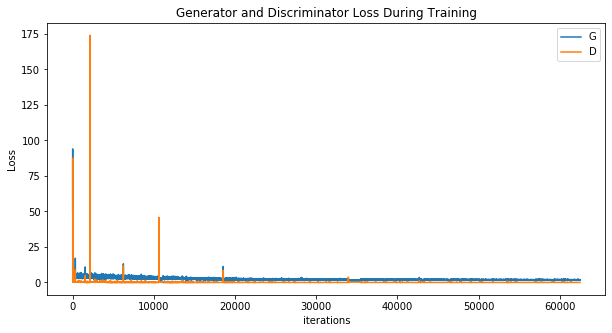

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()